# Environment Preparation


In [ ]:
!pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 709.3/709.3 kB 32.6 MB/s eta 0:00:00


In [ ]:
#Template for this notebook as well as datasets were provided by Martin Madaras and Skeletex s.r.o.. We used this as core and expanded with our
#own experiments using DLG algorithm.

import os
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"

import time
import random
import tensorflow as tf
import time
import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
import trimesh


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'

MOTION_CAM_MAX_RANGE = 1800
DATASET_THRUSTER = root_path + '/Skeletex3DData/thruster/'
DATASET_ARMADILLO = root_path + '/Skeletex3DData/armadillo/'
DATASET = DATASET_ARMADILLO

Mounted at /content/gdrive


# Data Exploration

In [ ]:
def load_scan(positions_path, normals_path, load_xyz=False):
  positions = cv2.imread(positions_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
  print(positions_path)
  positions = cv2.resize(positions, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
  normals = cv2.imread(normals_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
  normals = cv2.resize((normals + 1) / 2, (0, 0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
  xyz = []
  if load_xyz:
    for y in range(positions.shape[0]):
      for x in range(positions.shape[1]):
        if not np.all(positions[y][x] == 0) and random.randrange(20) == 0:
          xyz.append(positions[y][x])
  xyz = np.array(xyz)
  return positions, normals, xyz

In [ ]:
p_path = DATASET + 'train/scan_000_positions.exr'
n_path = DATASET + 'train/scan_000_normals.exr'
positions, normals, xyz = load_scan(p_path, n_path, True)
print(positions.shape)
print(normals.shape)
print(xyz.shape)

gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_000_positions.exr
(772, 1032, 3)
(772, 1032, 3)
(26066, 3)


In [ ]:
def load_mask(labels_path):
  mask = cv2.imread(labels_path,  cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
  mask = cv2.resize(mask, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_NEAREST)
  mask = mask[:,:,2]
  mask = np.expand_dims(mask, axis =2)
  mask = (mask>1).astype(float)
  return mask

In [ ]:
mask = load_mask(DATASET + '/train/scan_000_labels.png')
print(np.amax(mask))
print(mask.shape)

1.0
(772, 1032, 1)


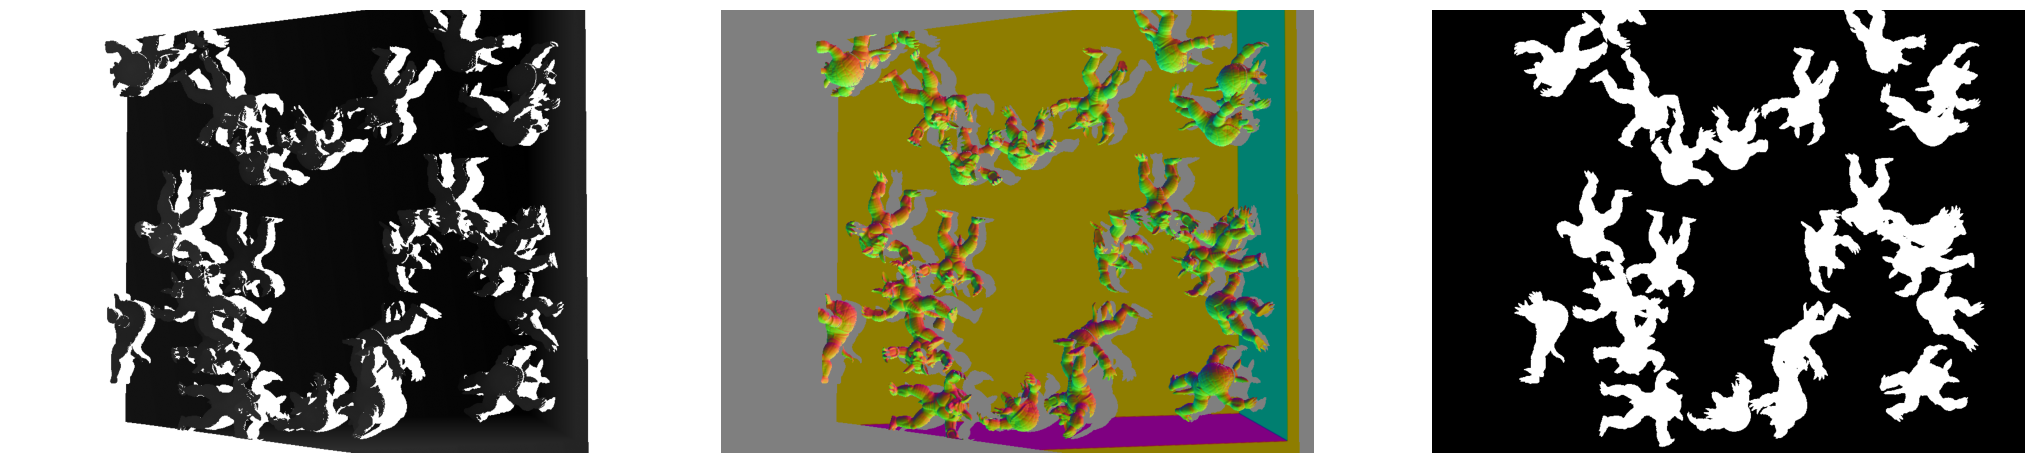

In [ ]:
def show(depth, normals, mask):
  plt.figure(figsize=(26, 20))

  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(-depth).set_cmap('gray')

  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.imshow(normals)

  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.imshow(mask[:, :, 0]).set_cmap('gray')

  plt.show()

show(positions[:, :, 2], normals, mask)

def show_pred(depth, normals, mask):
  plt.figure(figsize=(26, 20))

  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(-depth).set_cmap('gray')

  plt.subplot(1, 3, 2)
  plt.axis('off')
  plt.imshow(normals)

  plt.subplot(1, 3, 3)
  plt.axis('off')
  plt.imshow(mask).set_cmap('gray')

  plt.show()


# Dataset Parser

In [ ]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, datasets_path, gt=True):
        self.inputs, self.masks, self.positions, self.xyzs = [], [], [], []
        self.gt = gt
        self.load_data(datasets_path)

    def load_data(self, dataset_path):
        files = os.listdir(dataset_path)
        random.shuffle(files)
        for f in files:
            if "_positions" in f:
                print(dataset_path + f[:-13])
                p_path = dataset_path + f
                n_path = dataset_path + f[:-13] + 'normals.exr'
                positions, normals, xyz = load_scan(p_path, n_path, not self.gt)
                depth = positions[:, :, 2] / MOTION_CAM_MAX_RANGE
                depth = np.expand_dims(depth, axis=2)
                stacked = np.concatenate([normals, depth], axis=2)
                self.inputs.append(np.expand_dims(stacked, axis=0))
                # TO-DO STUDENTS: Load AND APPEND SEGMENTATION MASK
                if self.gt:
                  mask = load_mask(dataset_path + f[:-13] + 'labels.png')
                  self.masks.append(np.expand_dims(mask, axis = 0))
                else:
                  self.positions.append(positions)
                  self.xyzs.append(xyz)
                # TO-DO STUDENTS: Load AND APPEND SEGMENTATION MASK

    def get_positions_and_xyzs(self, index):
        return self.positions[index], self.xyzs[index]

    def __len__(self):
        return len(self.masks)

    def __getitem__(self, index):
        return self.inputs[index], self.masks[index] if self.gt else None

In [ ]:
train_generator = Generator(DATASET + 'train/')
val_generator = Generator(DATASET + 'val/')
test_generator = Generator(DATASET + 'test/')
real_generator = Generator(DATASET + 'real/', gt=False)

gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_064_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_064_positions.exr
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_080_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_080_positions.exr
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_078_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_078_positions.exr
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_022_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_022_positions.exr
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_068_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_068_positions.exr
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_020_
gdrive/My Drive/Colab Notebooks//Skeletex3DData/armadillo/train/scan_020_positions.exr
gdrive/My Drive/Colab Notebooks//S

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

In [ ]:
test_input, test_mask = test_generator[4]
print(test_input.shape)
print(test_mask.shape)

NameError: name 'test_generator' is not defined

# Neural Network


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 4)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 16) │            592 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 16) │          2,320 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 16) │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 24) │          3,480 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 24) │          5,208 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, None, None, 24) │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None, 48) │         10,416 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, None, None, 48) │         20,784 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, None, None, 24) │          4,632 │ conv2d_5[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, None, 48) │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, None, None, 24) │         10,392 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, None, None, 24) │          5,208 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, None, None, 16) │          1,552 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, None, None, 32) │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, None, None, 16) │          4,624 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)    

 Total params: 71,545 (279.47 KB)

 Trainable params: 71,545 (279.47 KB)

 Non-trainable params: 0 (0.00 B)

None
Total number of layers: 18


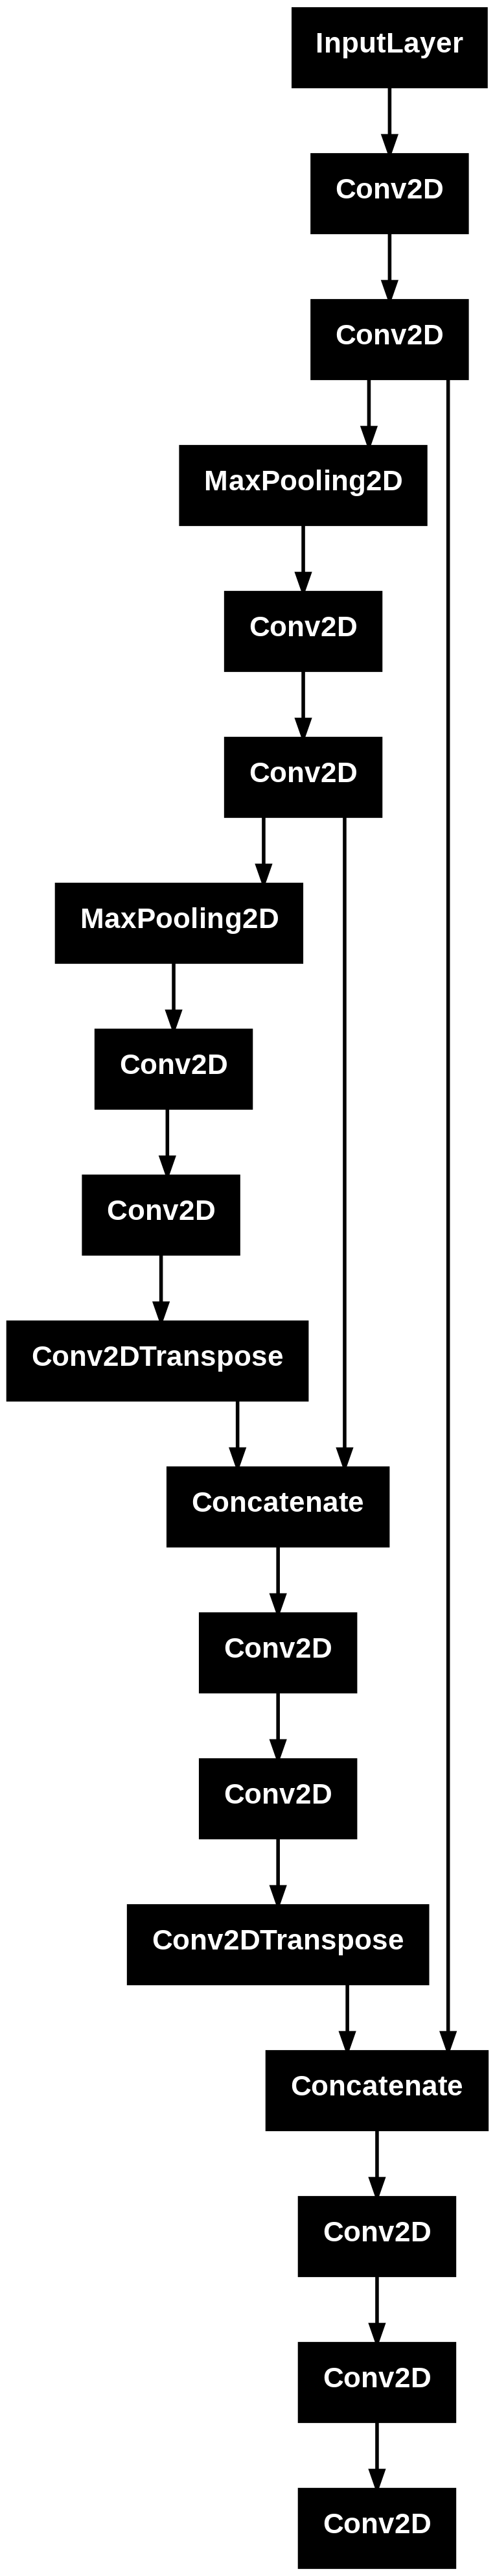

In [ ]:
def net(i):
    c1 = tf.keras.layers.Conv2D(16,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(i)
    c1 = tf.keras.layers.Conv2D(16,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D(2)(c1)

    c2 = tf.keras.layers.Conv2D(24,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(24,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D(2)(c2)

    c3 = tf.keras.layers.Conv2D(48,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(48,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(c3)


    u4 = tf.keras.layers.Conv2DTranspose(24,2, strides = (2,2), padding='same')(c3)
    u4 = tf.keras.layers.concatenate([u4,c2])

    c4 = tf.keras.layers.Conv2D(24,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(u4)
    c4 = tf.keras.layers.Conv2D(24,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(c4)

    u5 = tf.keras.layers.Conv2DTranspose(16,2, strides = (2,2), padding='same')(c4)
    u5 = tf.keras.layers.concatenate([u5,c1])

    c5 = tf.keras.layers.Conv2D(16,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(u5)
    c5 = tf.keras.layers.Conv2D(16,3,activation=tf.keras.layers.LeakyReLU(), padding='same')(c5)



    o = tf.keras.layers.Conv2D(1, 1, activation='sigmoid') (c5)
    return o


def generate():
    i = tf.keras.Input(shape=(None, None, 4))
    o = net(i)
    model = tf.keras.Model(inputs=i, outputs=o)

    print(model.summary())
    print('Total number of layers: {}'.format(len(model.layers)))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

model = generate()
tf.keras.utils.plot_model(model, to_file='model.png')

In [ ]:
start = time.time()
history = model.fit(train_generator,
                    epochs=32,
                    validation_data=val_generator,
                    validation_freq=5)
print(f"Elapsed time: {time.time() - start} seconds")

In [ ]:
real_input, _ = real_generator[2]
print(real_input.shape)
prediction = model.predict(real_input)
print(prediction.shape)
show_pred(real_input[0, :, :, 3], real_input[0,:,:,:3], prediction[0])
model.save_weights("model.weights.h5")

<h1>DLG EXPERIMENTS</h1>

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, None, None, 4)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_176 (Conv2D)       │ (None, None, None, 16) │            592 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_177 (Conv2D)       │ (None, None, None, 16) │          2,320 │ conv2d_176[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_32          │ (None, None, None, 16) │              0 │ conv2d_177[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_178 (Conv2D)       │ (None, None, None, 24) │          3,480 │ max_pooling2d_32[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_179 (Conv2D)       │ (None, None, None, 24) │          5,208 │ conv2d_178[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_33          │ (None, None, None, 24) │              0 │ conv2d_179[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_180 (Conv2D)       │ (None, None, None, 48) │         10,416 │ max_pooling2d_33[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_181 (Conv2D)       │ (None, None, None, 48) │         20,784 │ conv2d_180[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_32       │ (None, None, None, 24) │          4,632 │ conv2d_181[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_32            │ (None, None, None, 48) │              0 │ conv2d_transpose_32[0… │
│ (Concatenate)             │                        │                │ conv2d_179[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_182 (Conv2D)       │ (None, None, None, 24) │         10,392 │ concatenate_32[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_183 (Conv2D)       │ (None, None, None, 24) │          5,208 │ conv2d_182[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_33       │ (None, None, None, 16) │          1,552 │ conv2d_183[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_33            │ (None, None, None, 32) │              0 │ conv2d_transpose_33[0… │
│ (Concatenate)             │                        │                │ conv2d_177[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_184 (Conv2D)       │ (None, None, None, 16) │          4,624 │ concatenate_33[0][0]   │
├──────────────────────

 Total params: 71,545 (279.47 KB)

 Trainable params: 71,545 (279.47 KB)

 Non-trainable params: 0 (0.00 B)

None
Total number of layers: 18


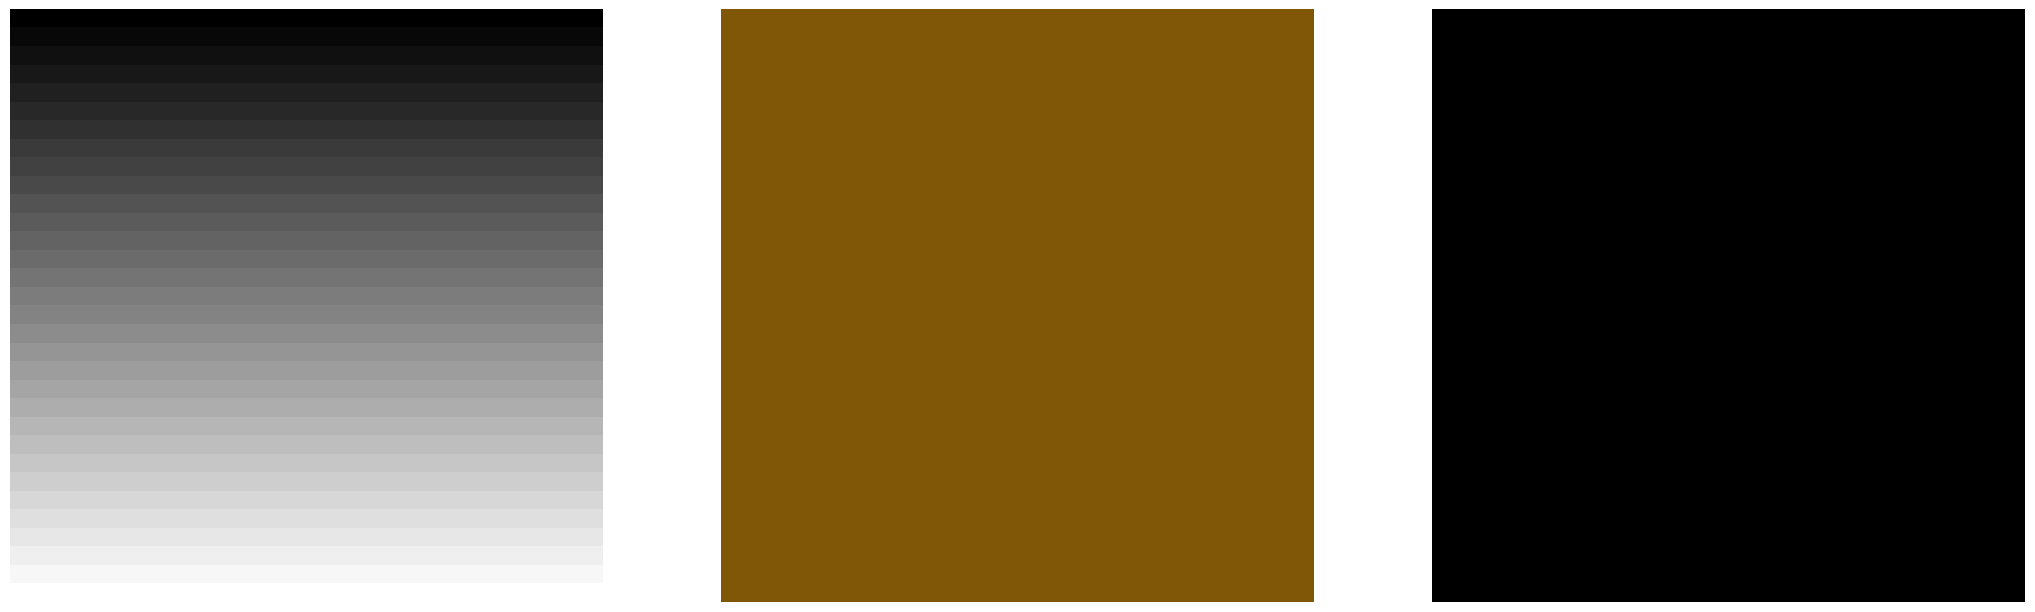

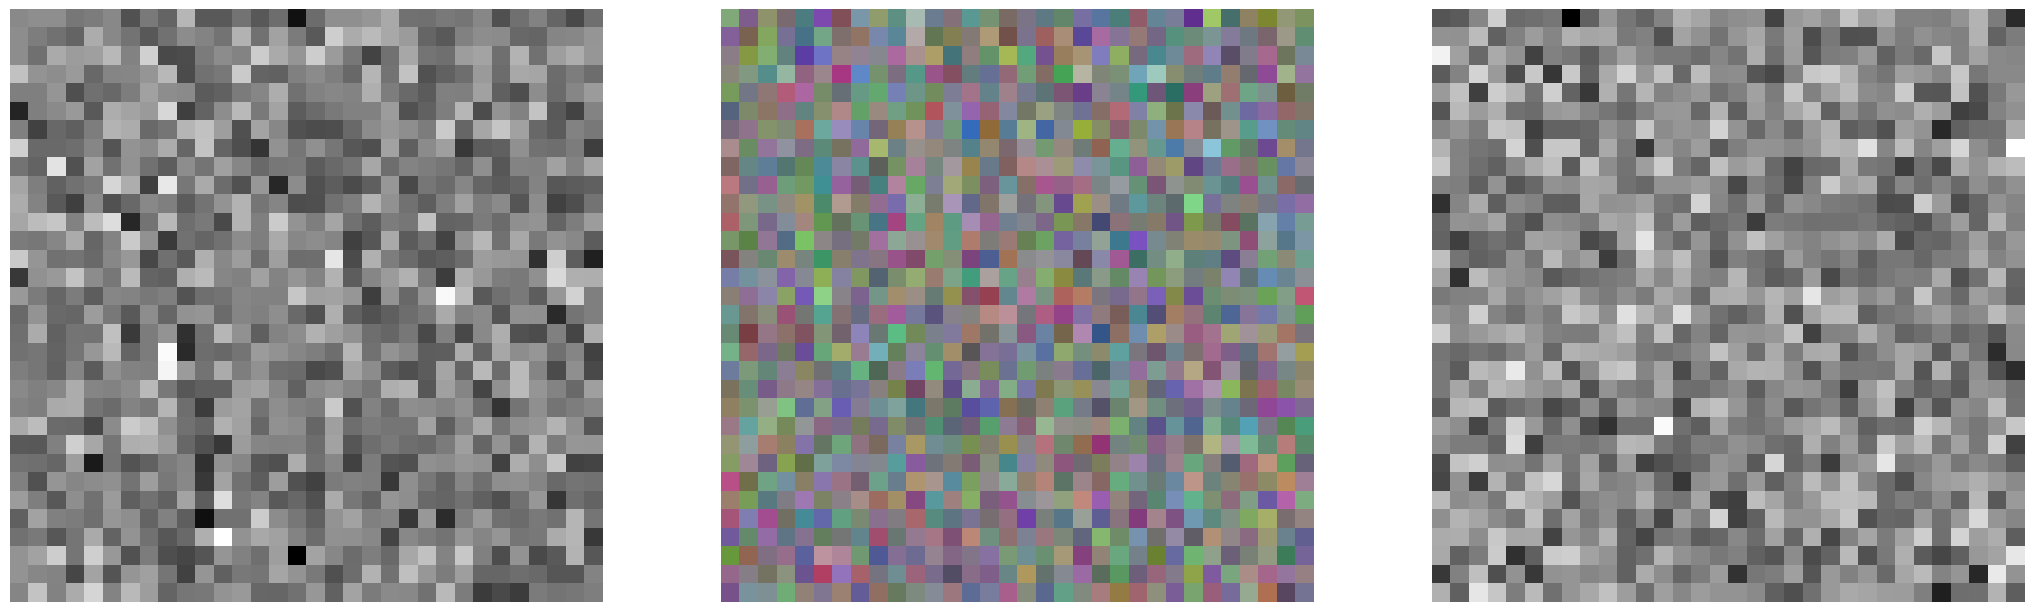

0 0.9399


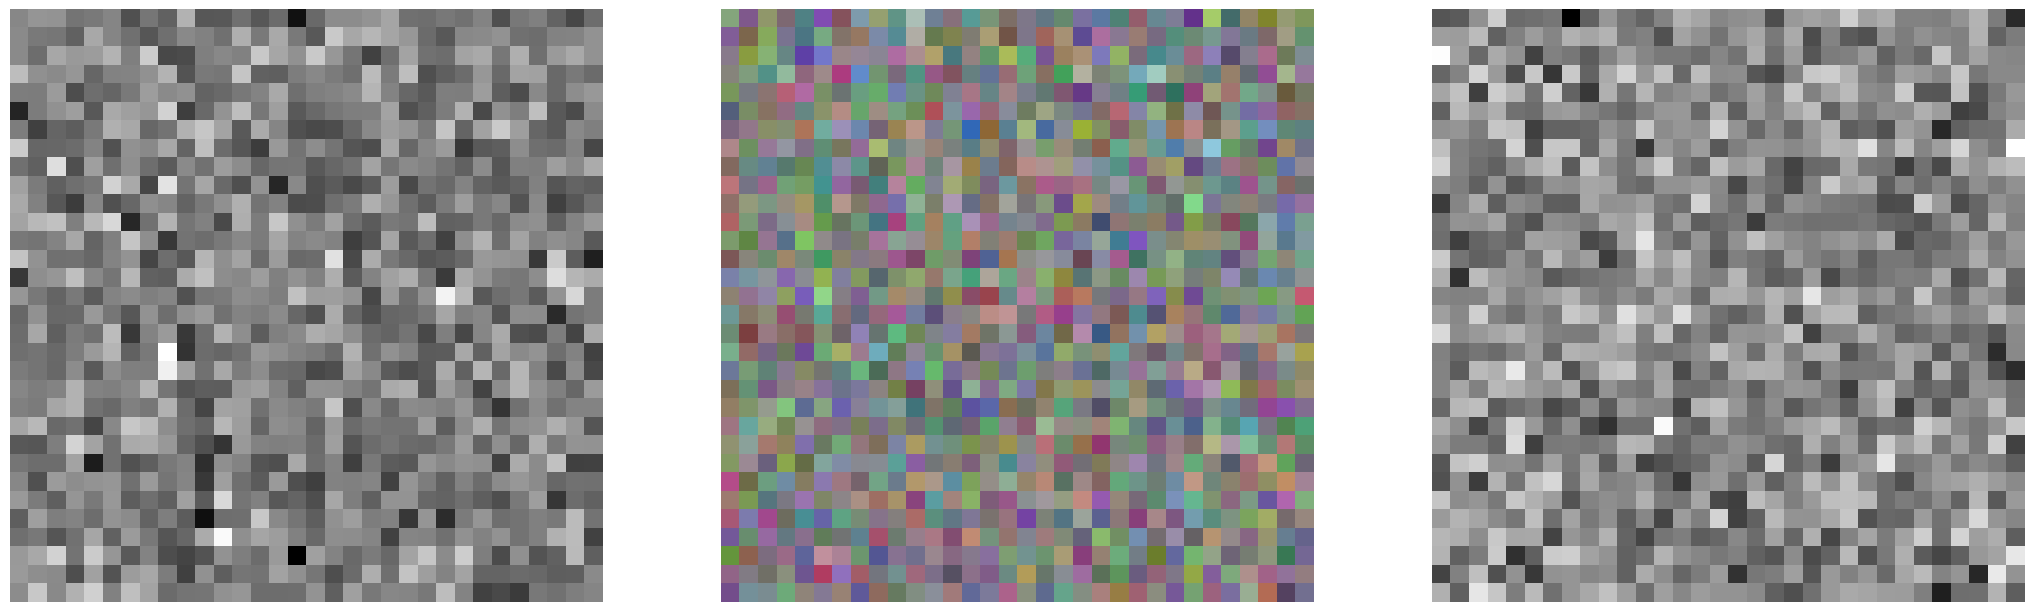

50 0.0163


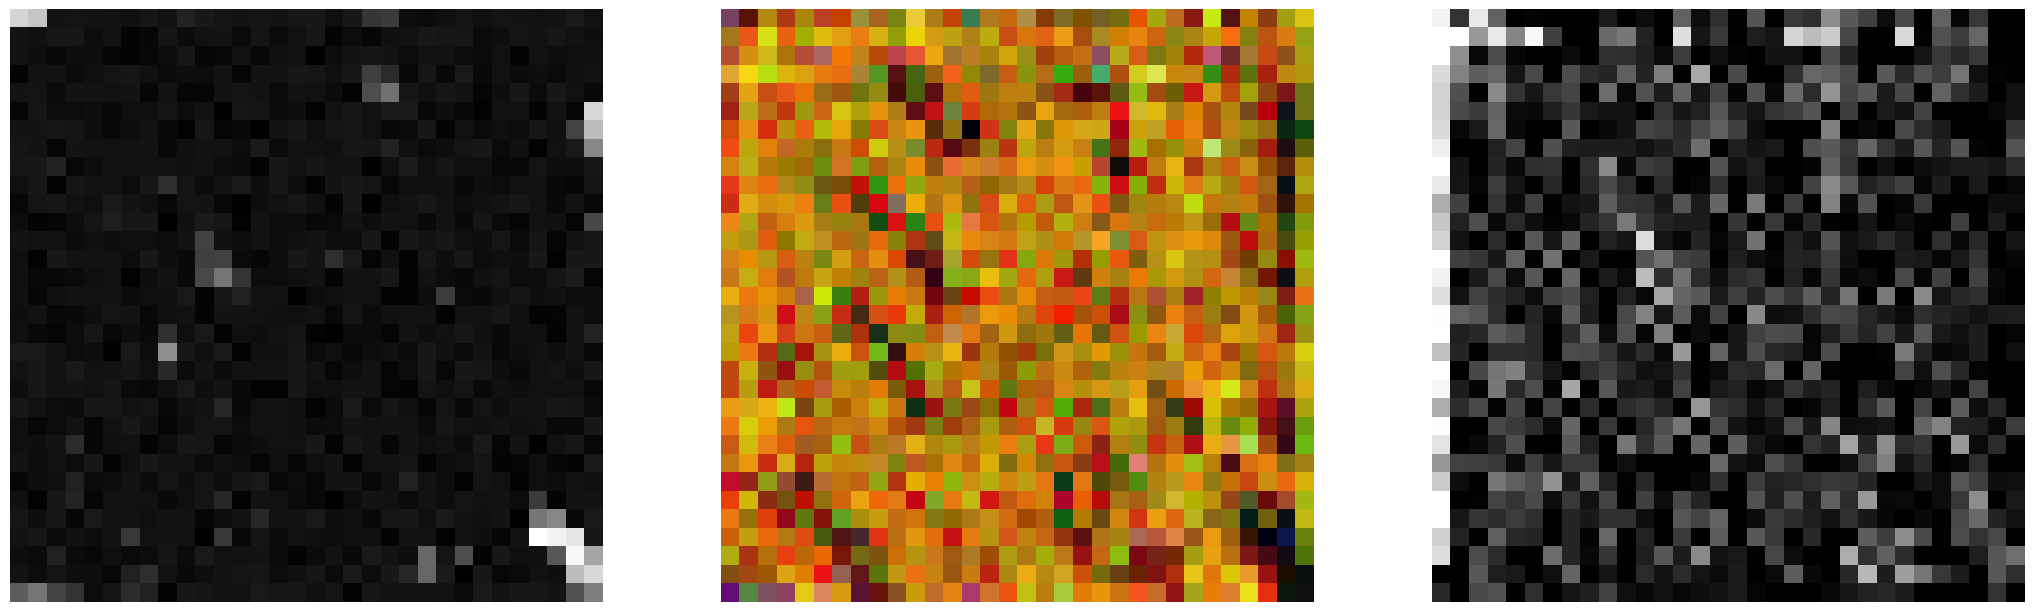

100 0.0038


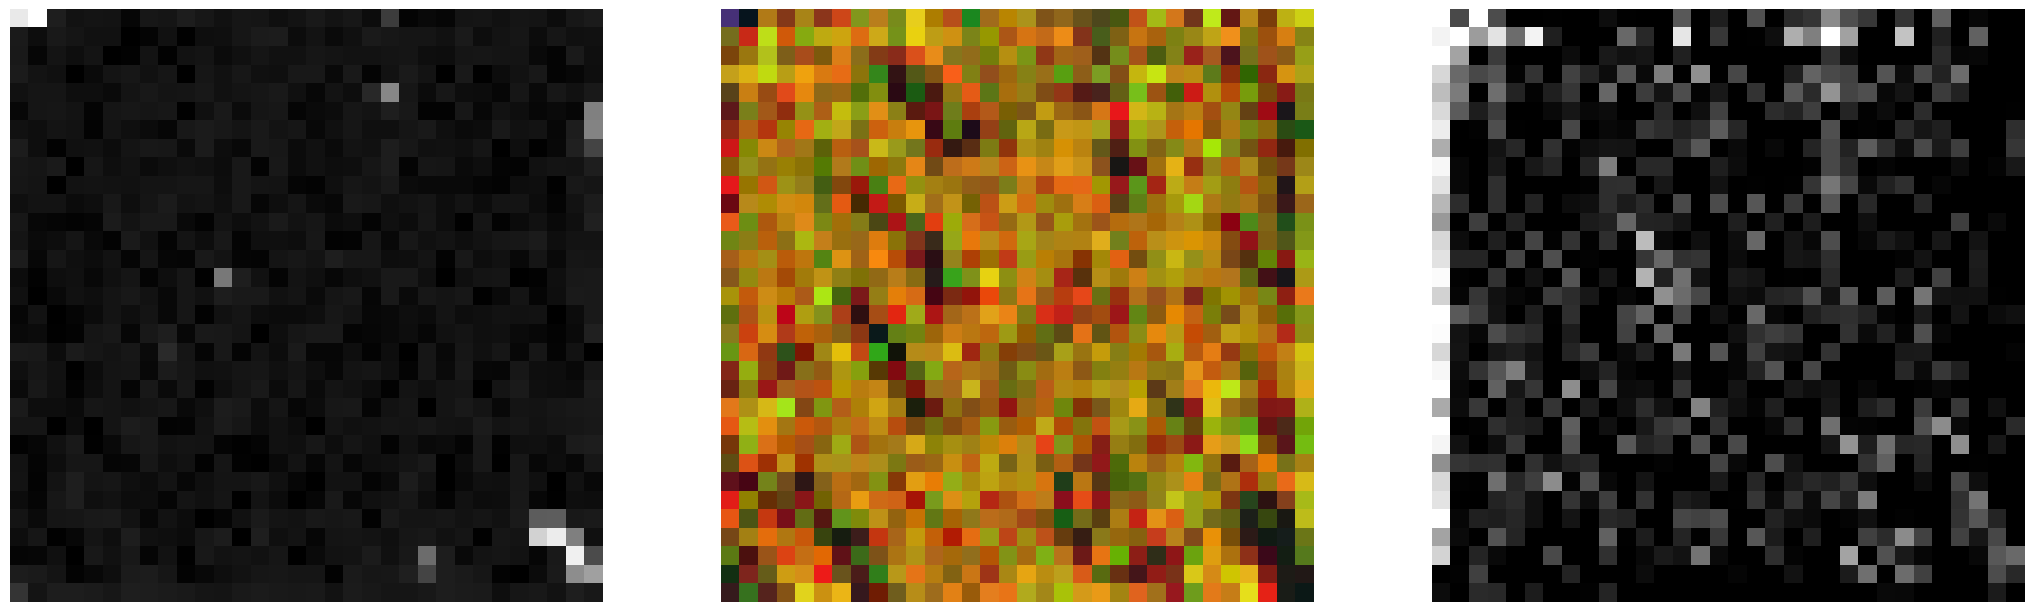

150 0.0019


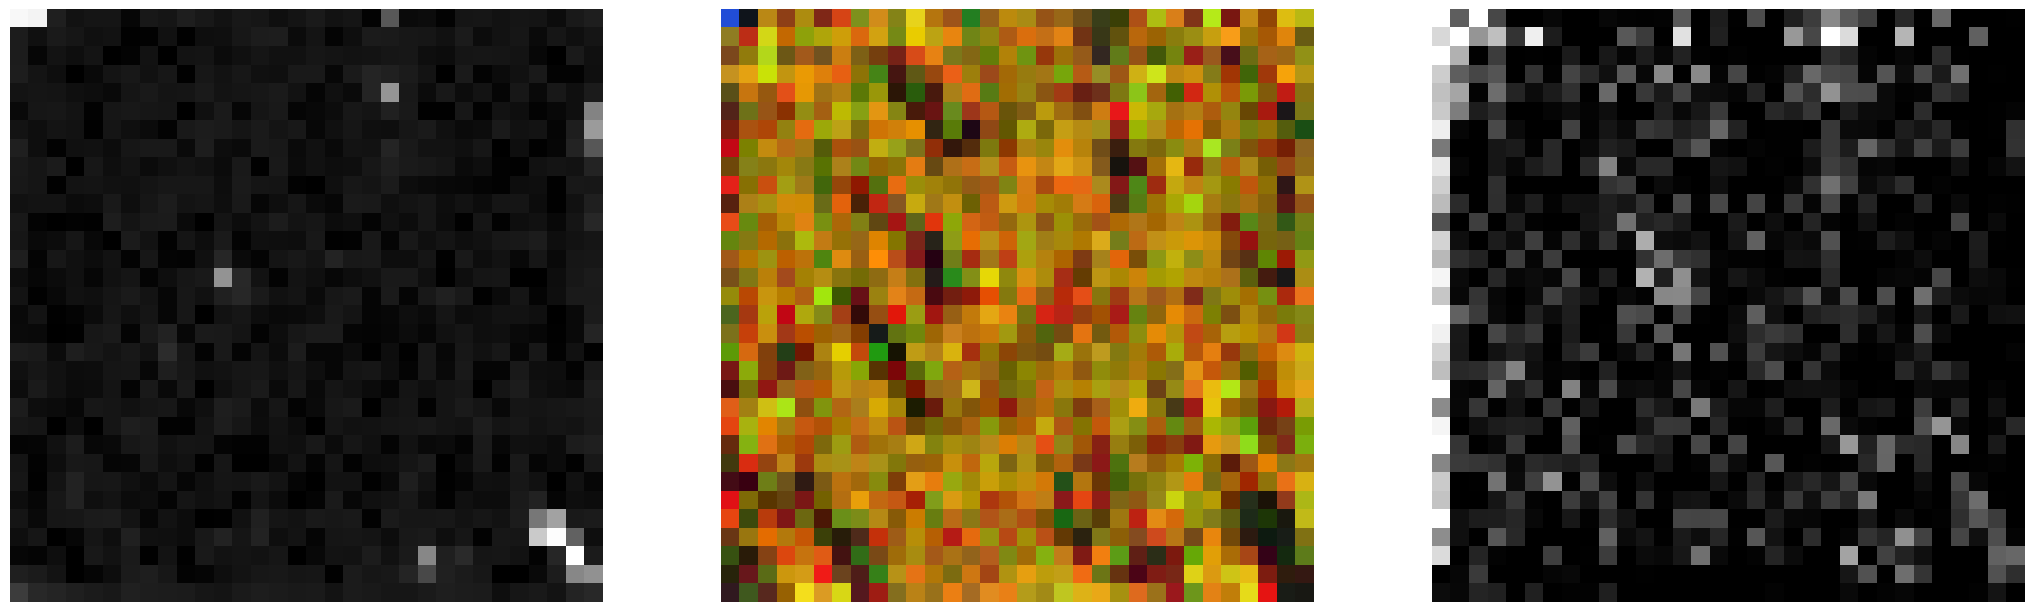

200 0.0013


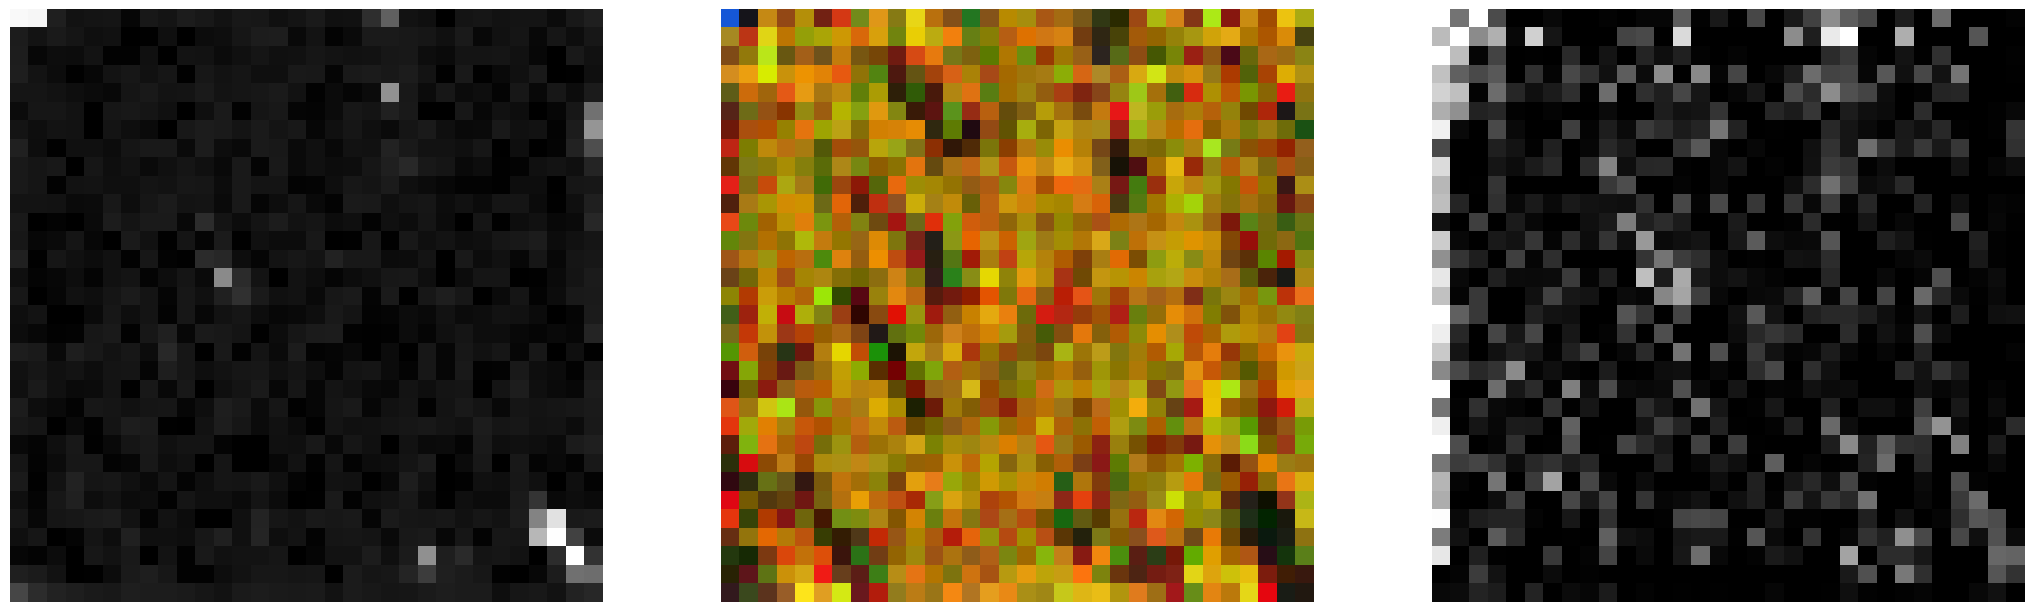

250 0.0009


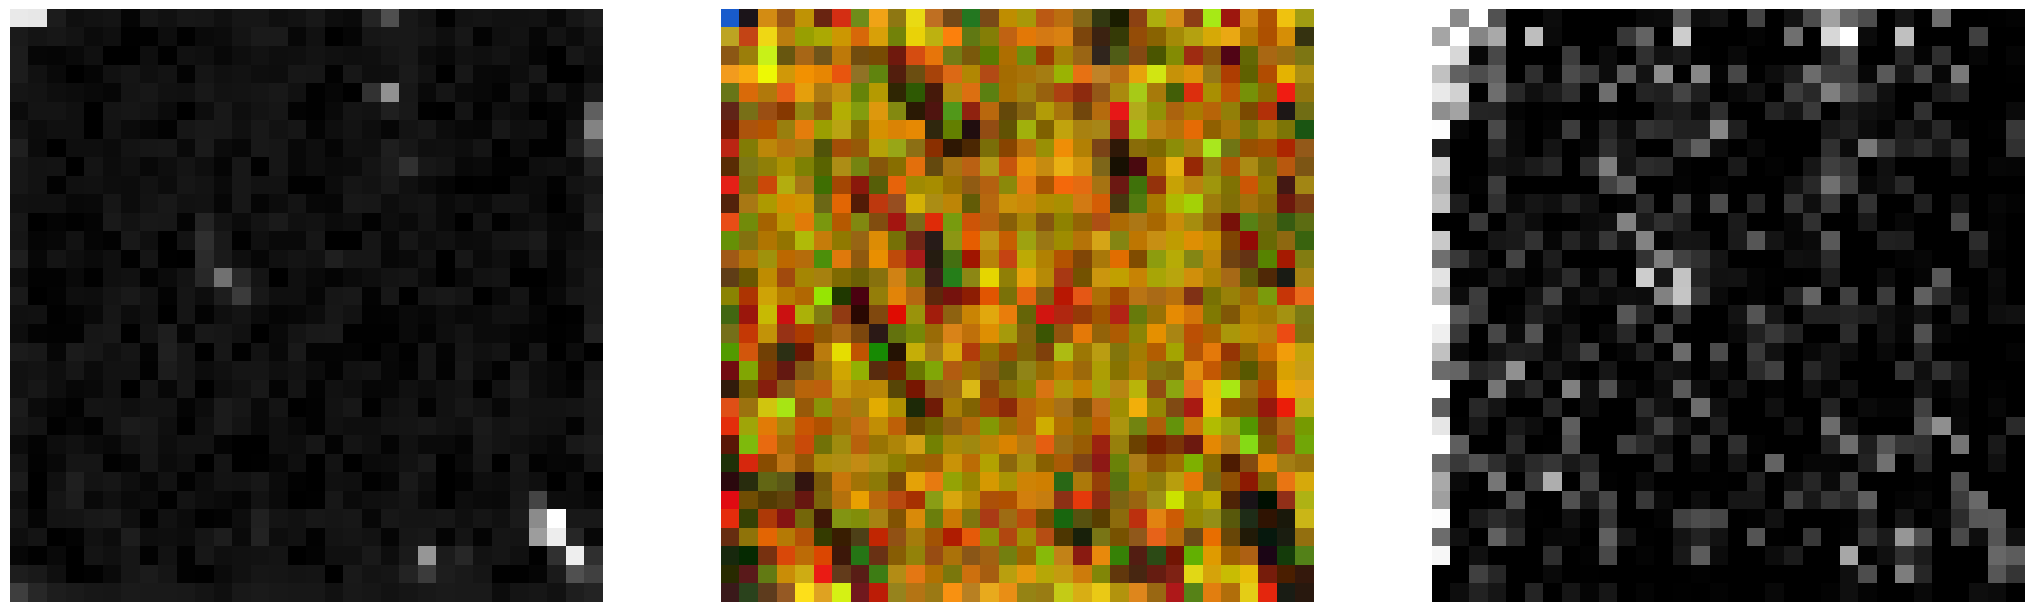

300 0.0008


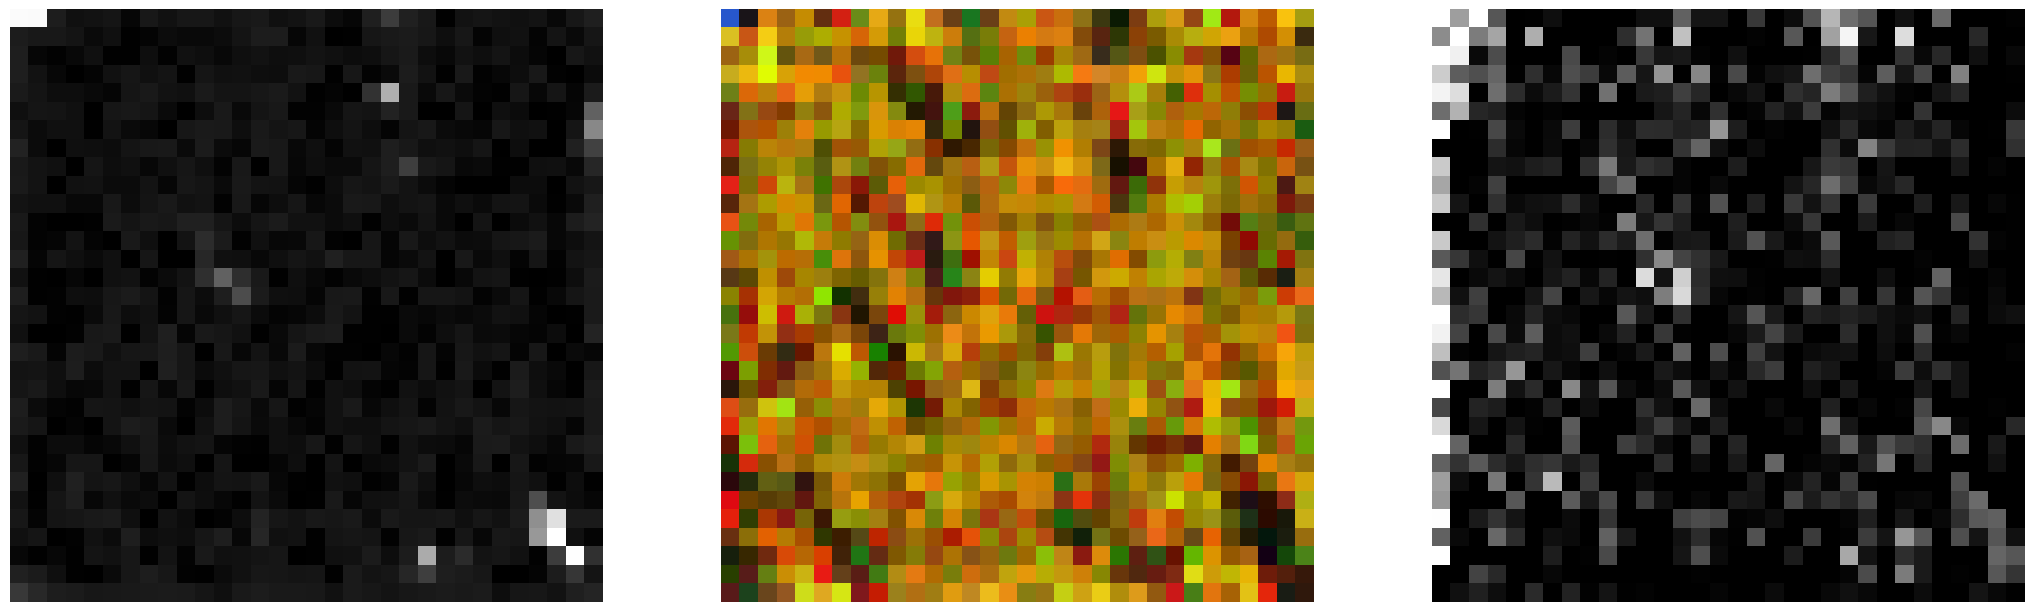

350 0.0007


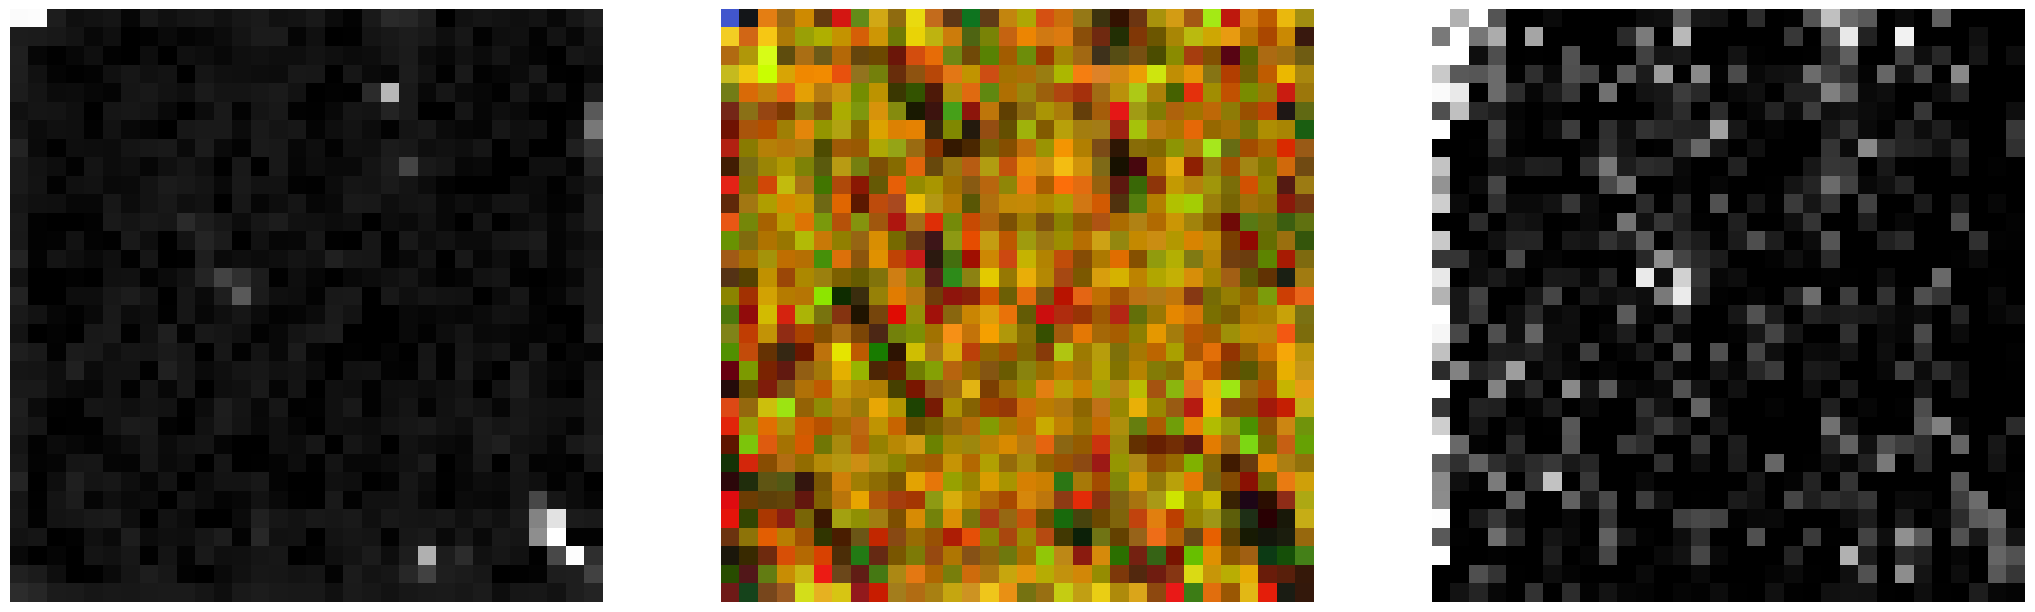

400 0.0005


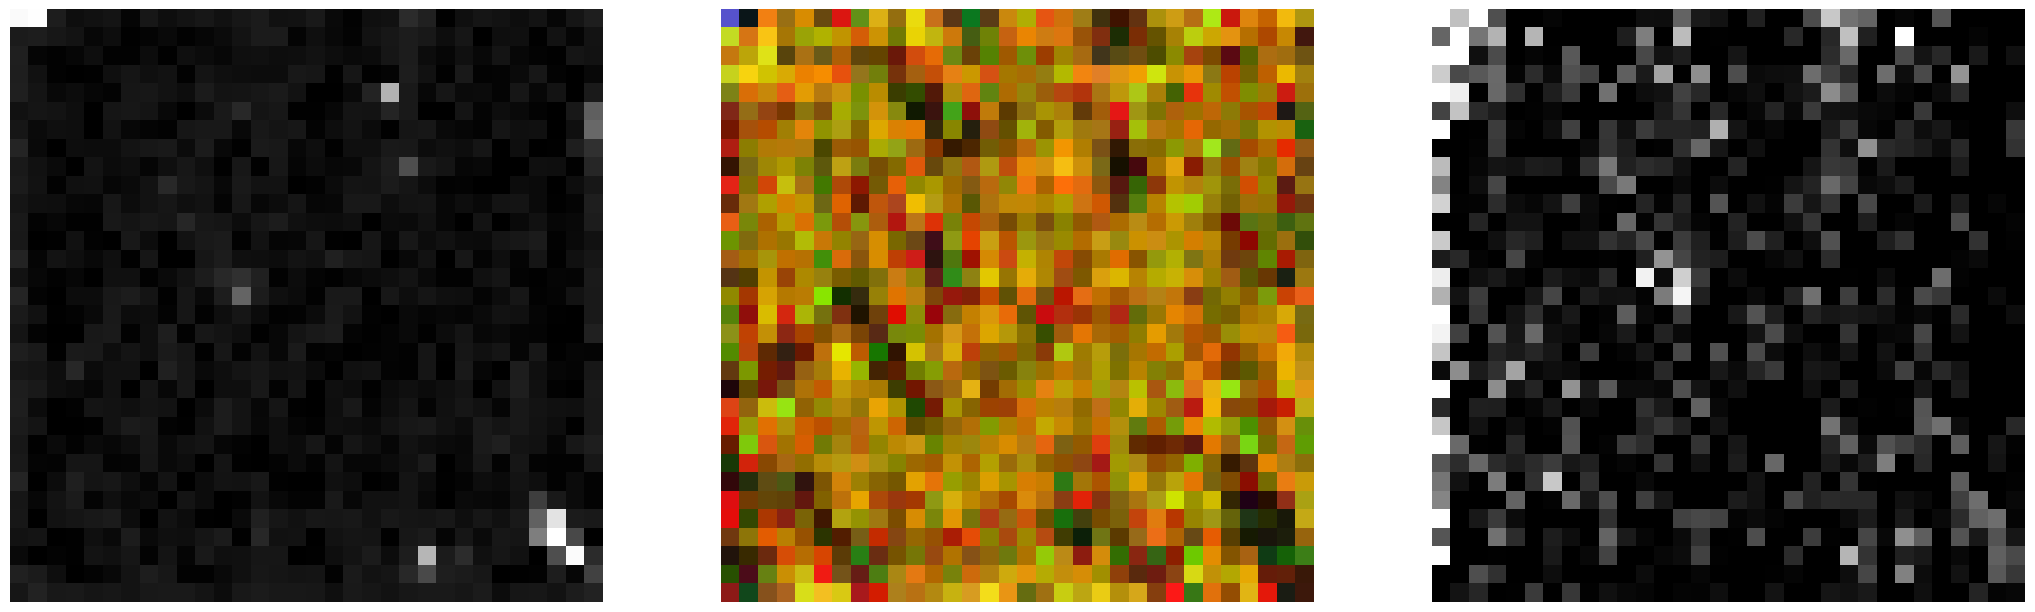

450 0.0005


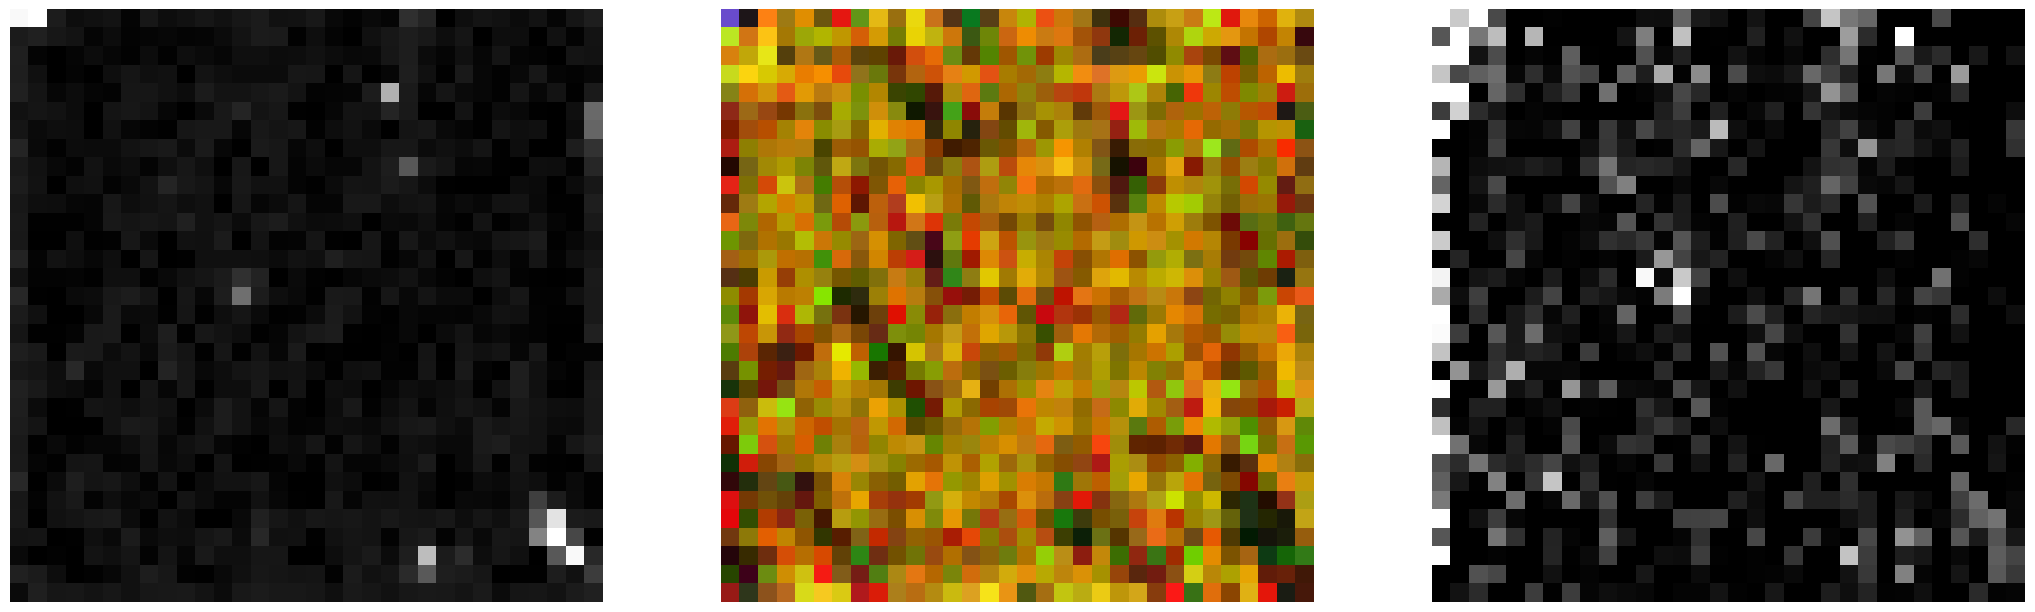

0 0.0048


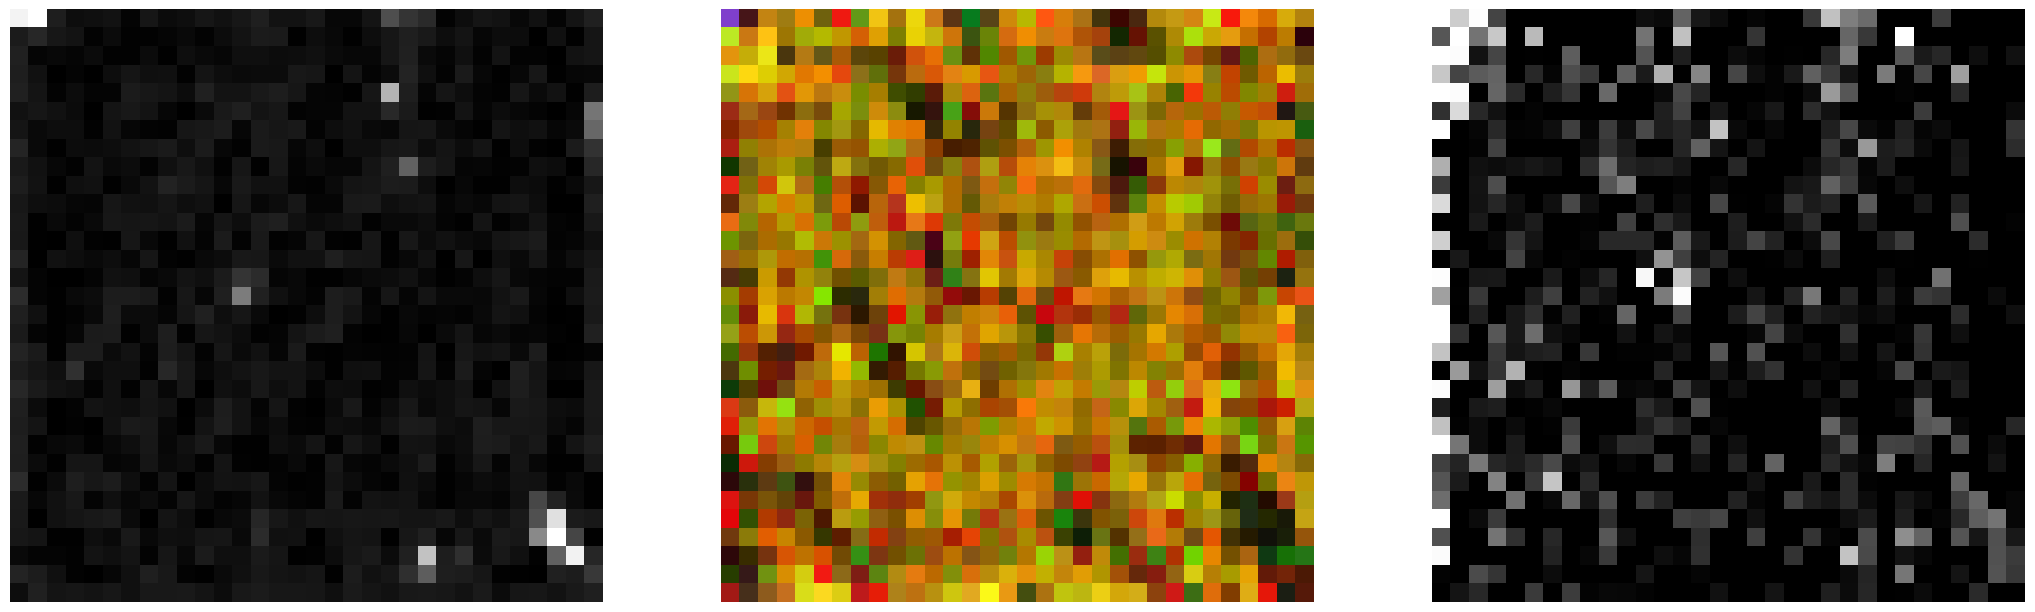

50 0.0046


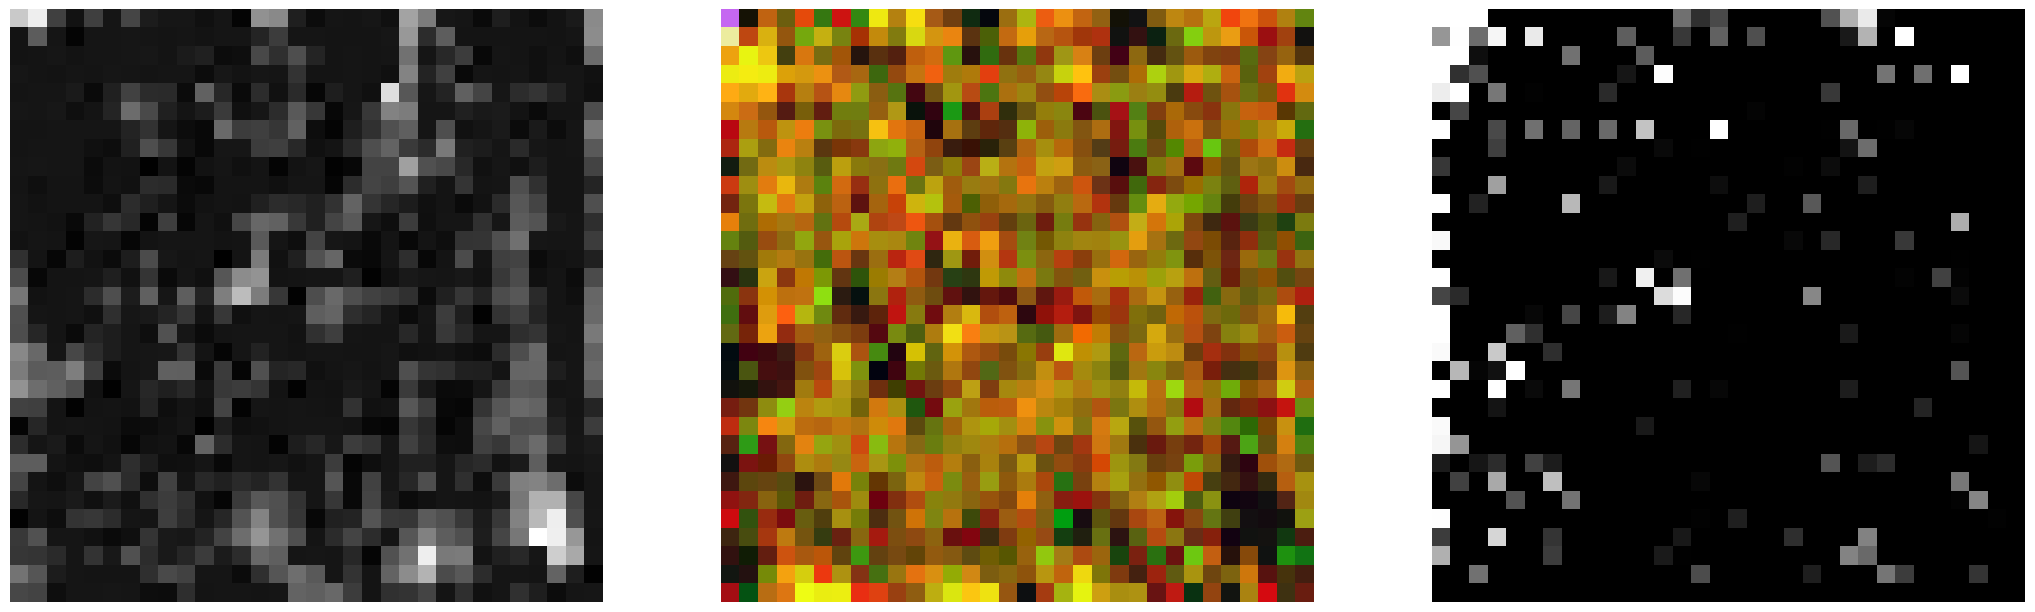

100 0.0071


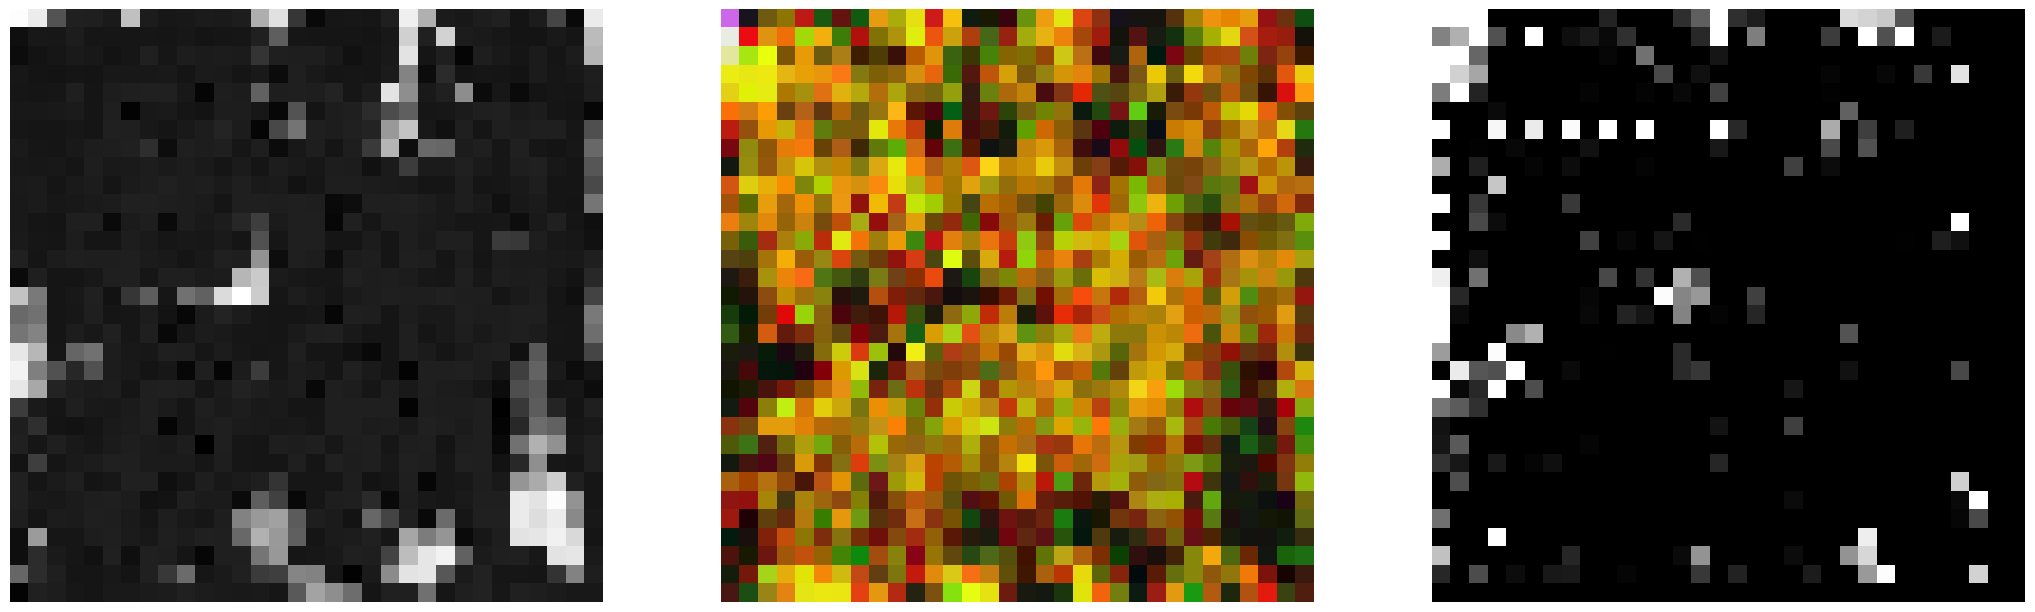

150 0.0072


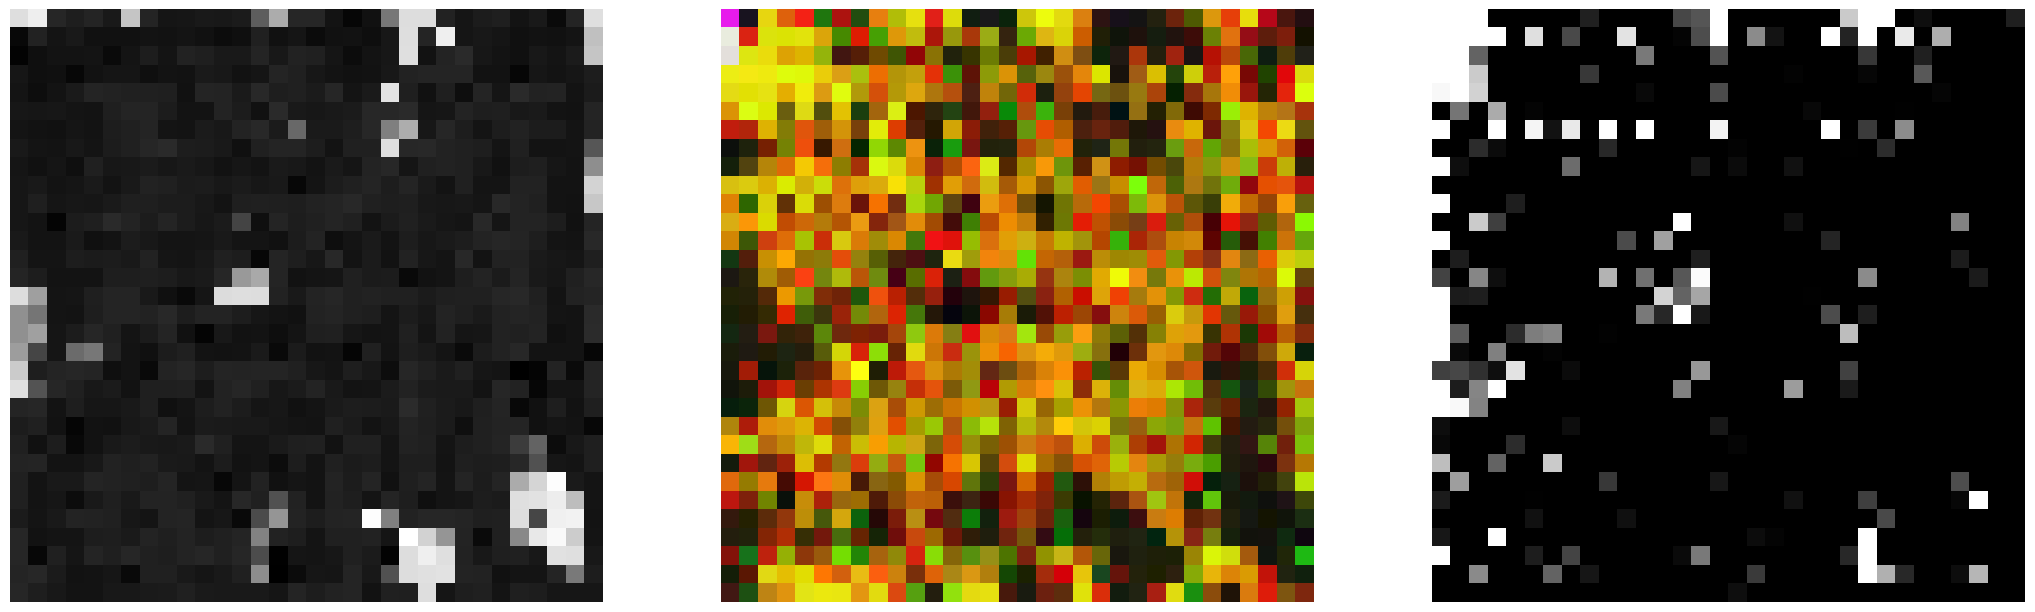

200 0.0065


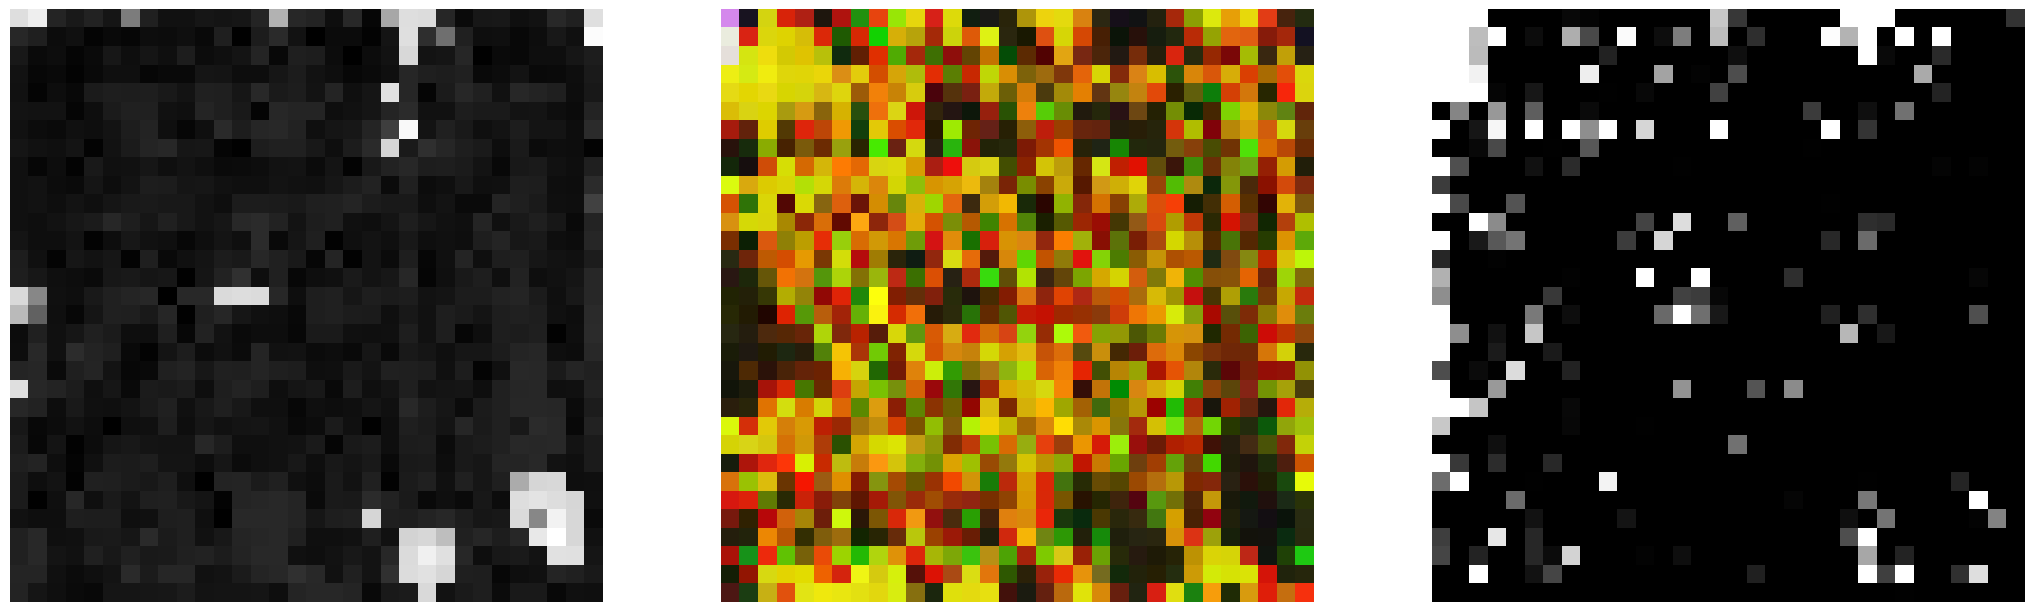

250 0.0074


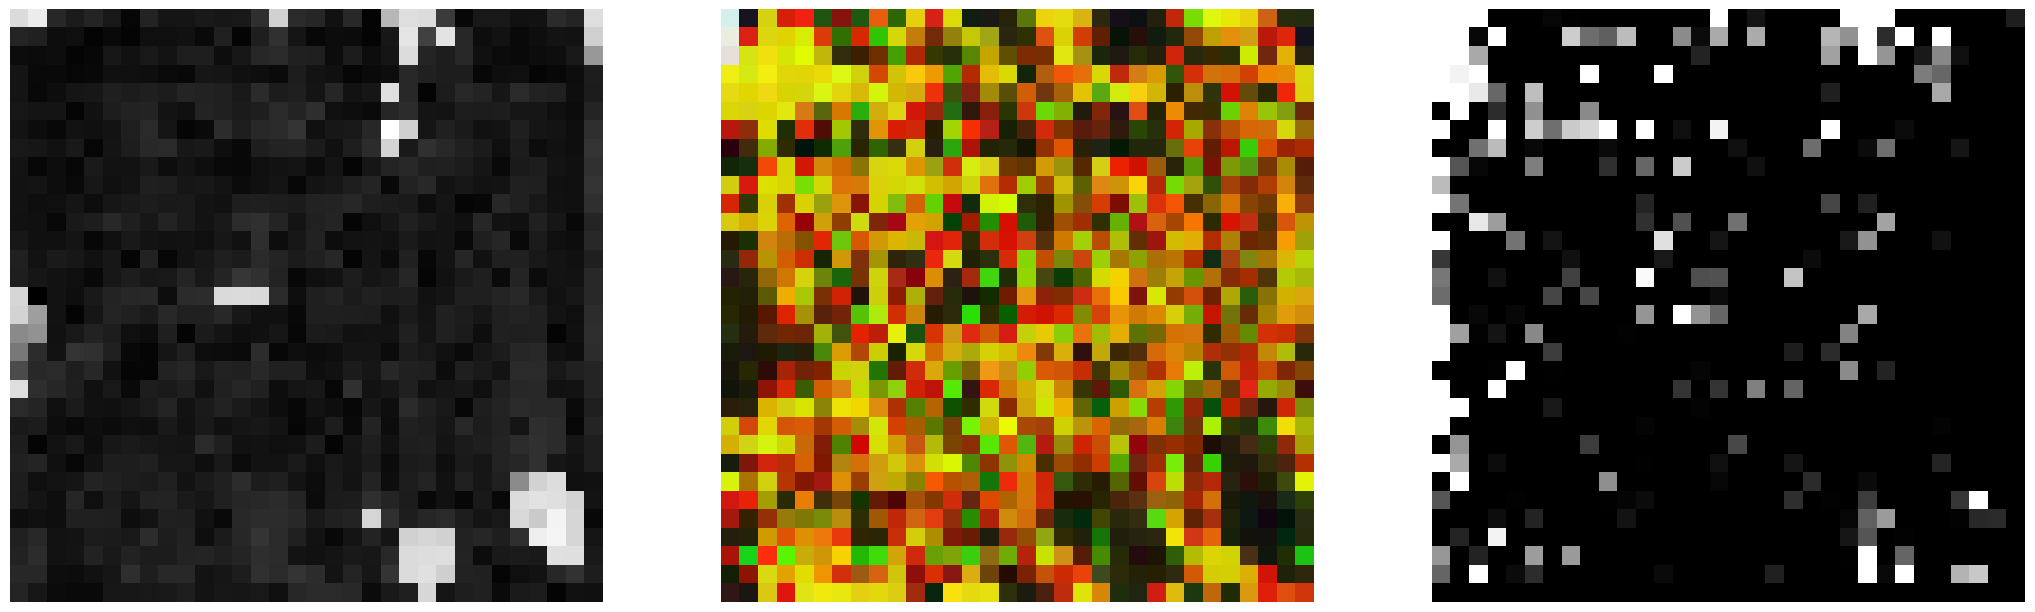

300 0.0054


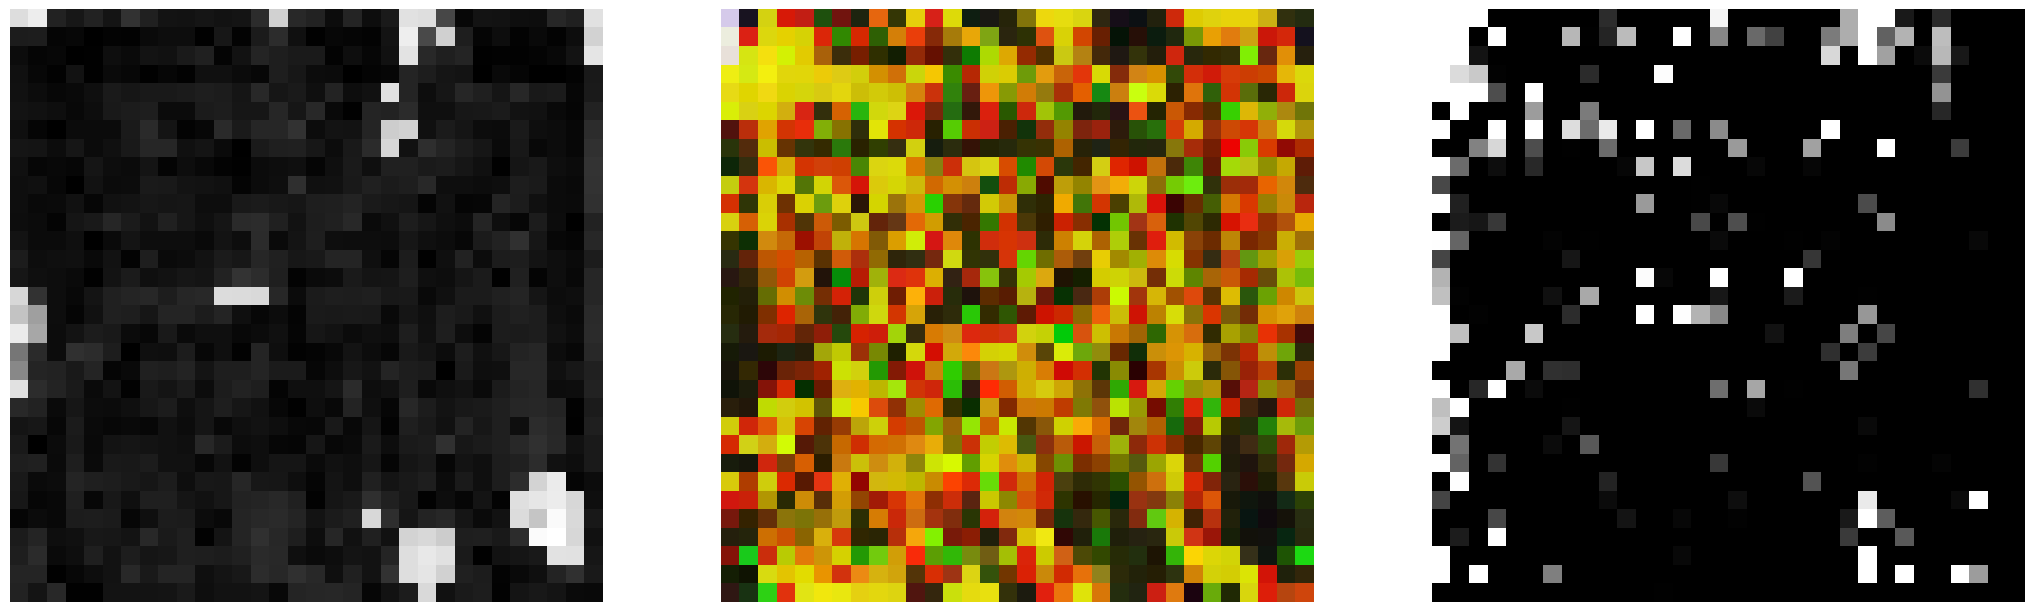

350 0.0066


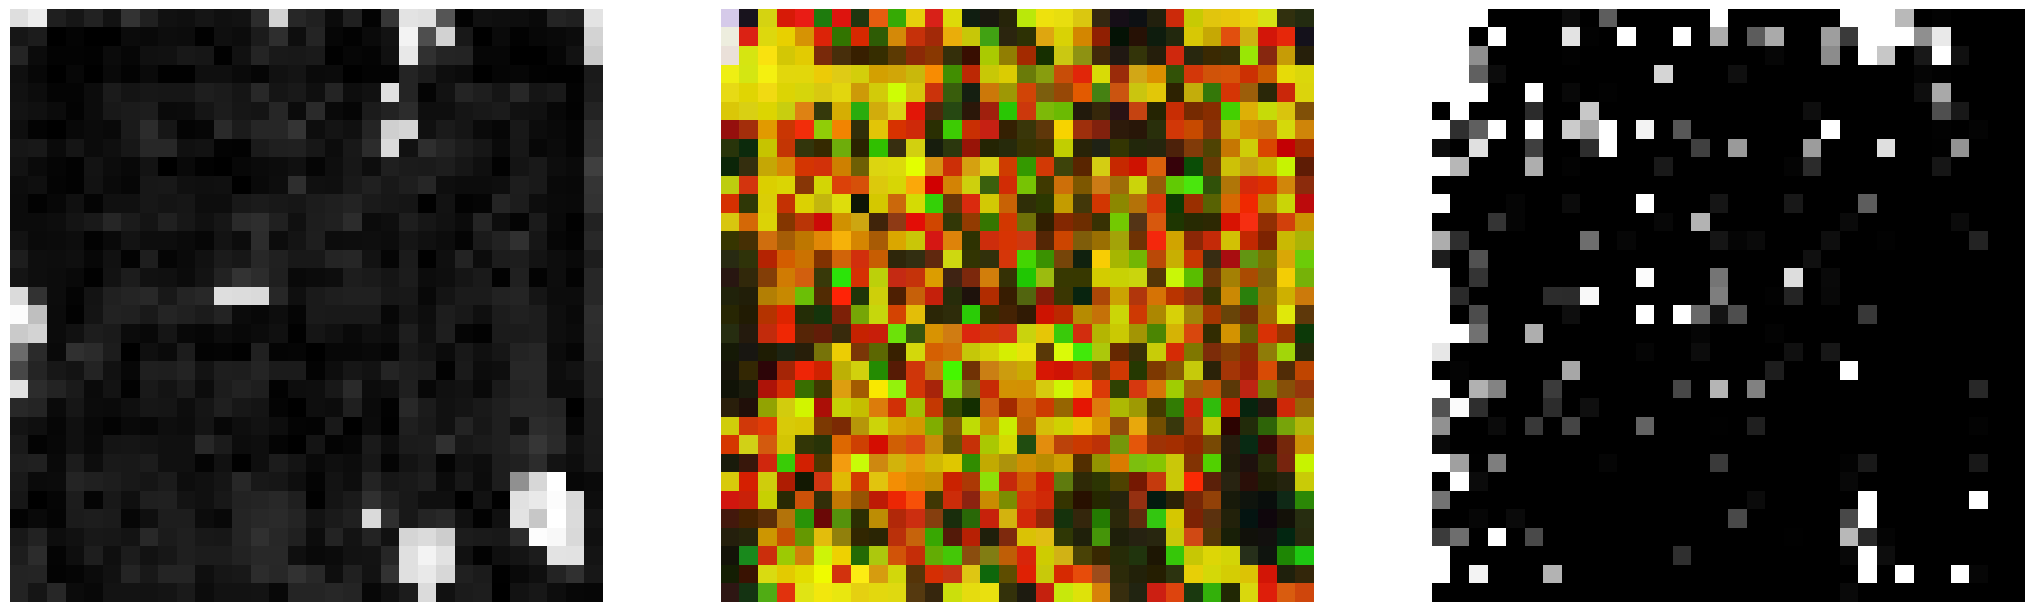

400 0.0055


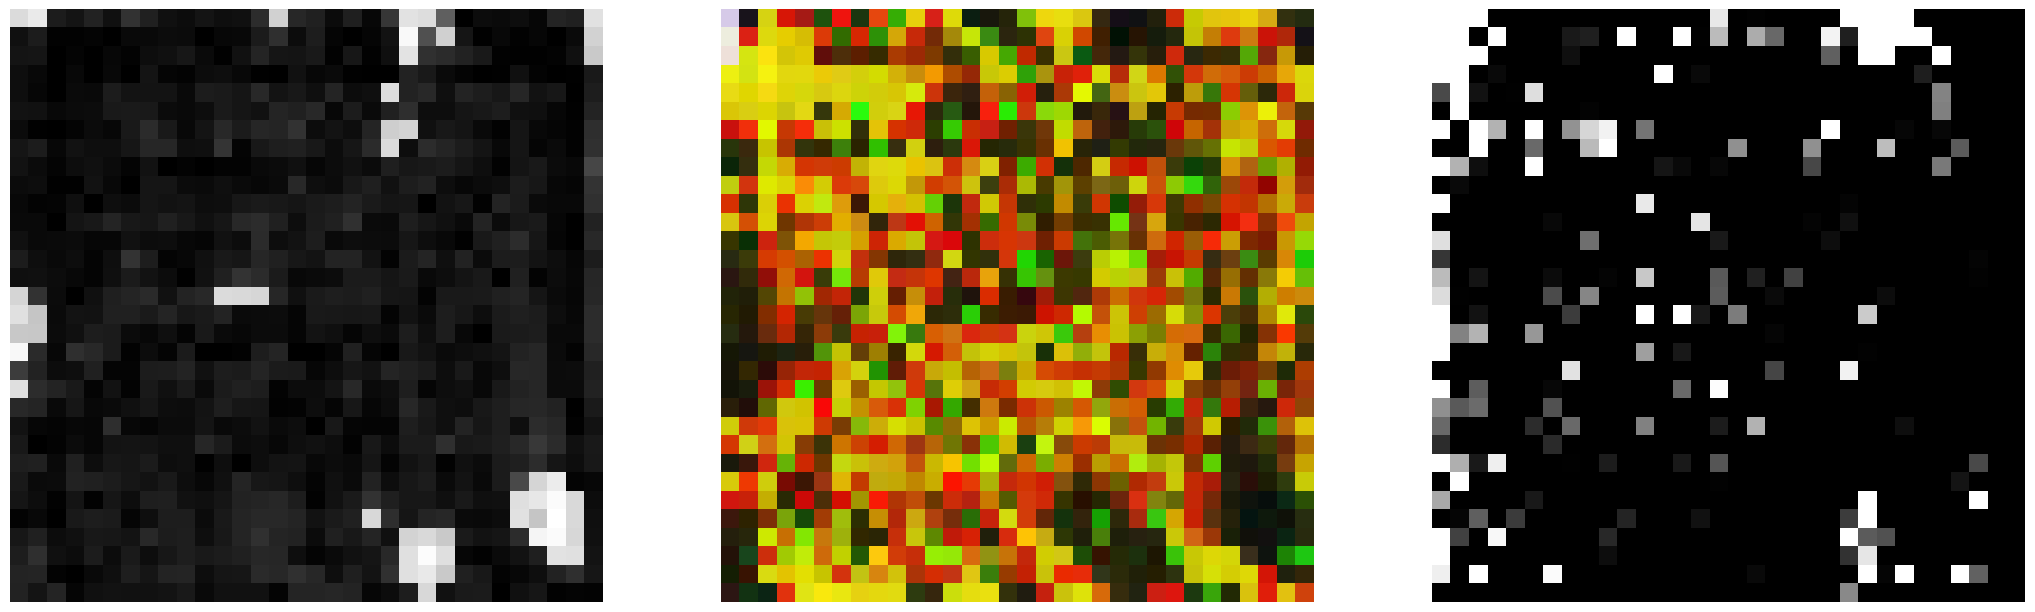

450 0.0053


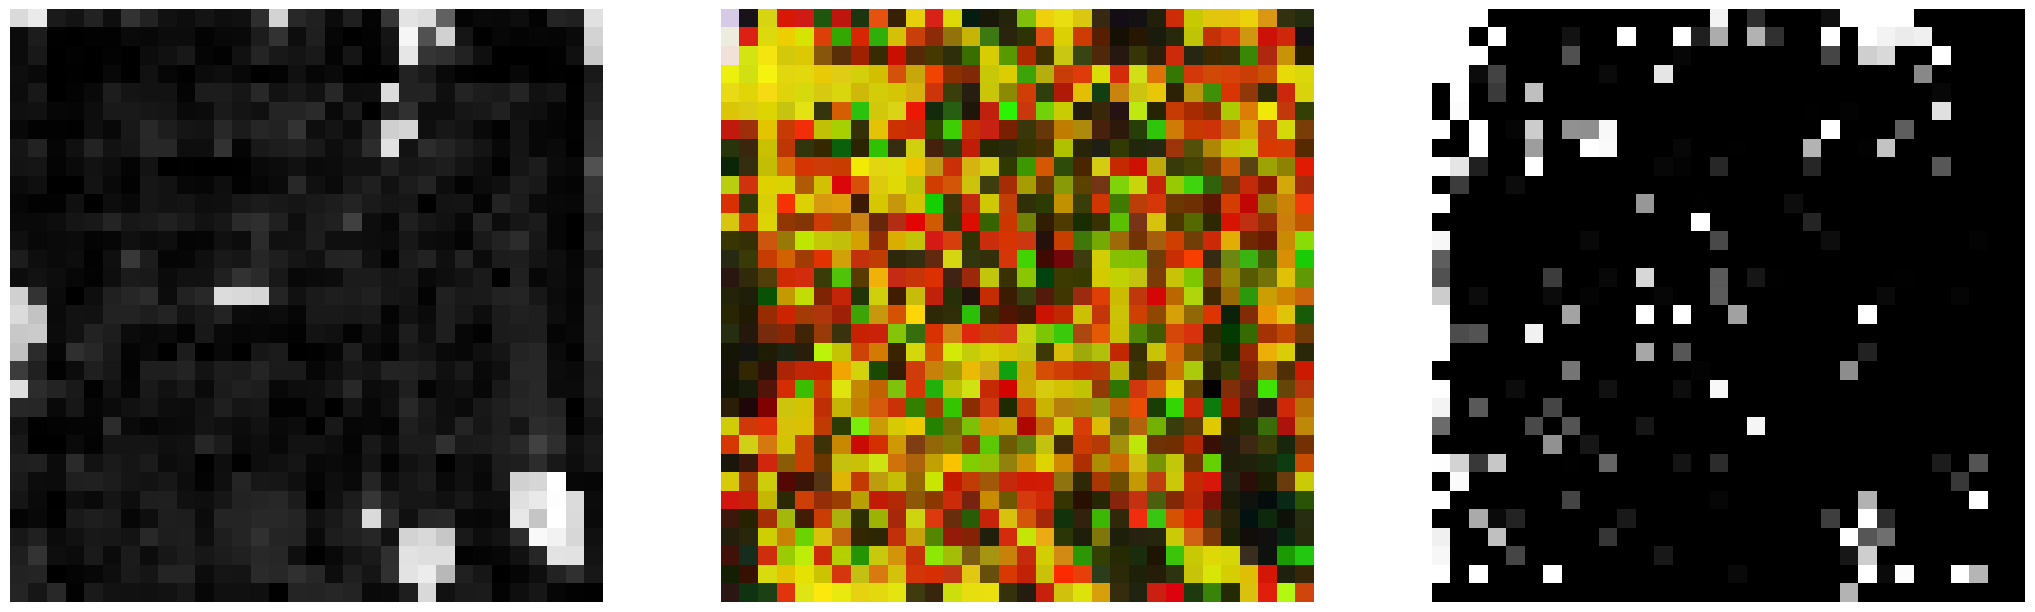

0 0.0717


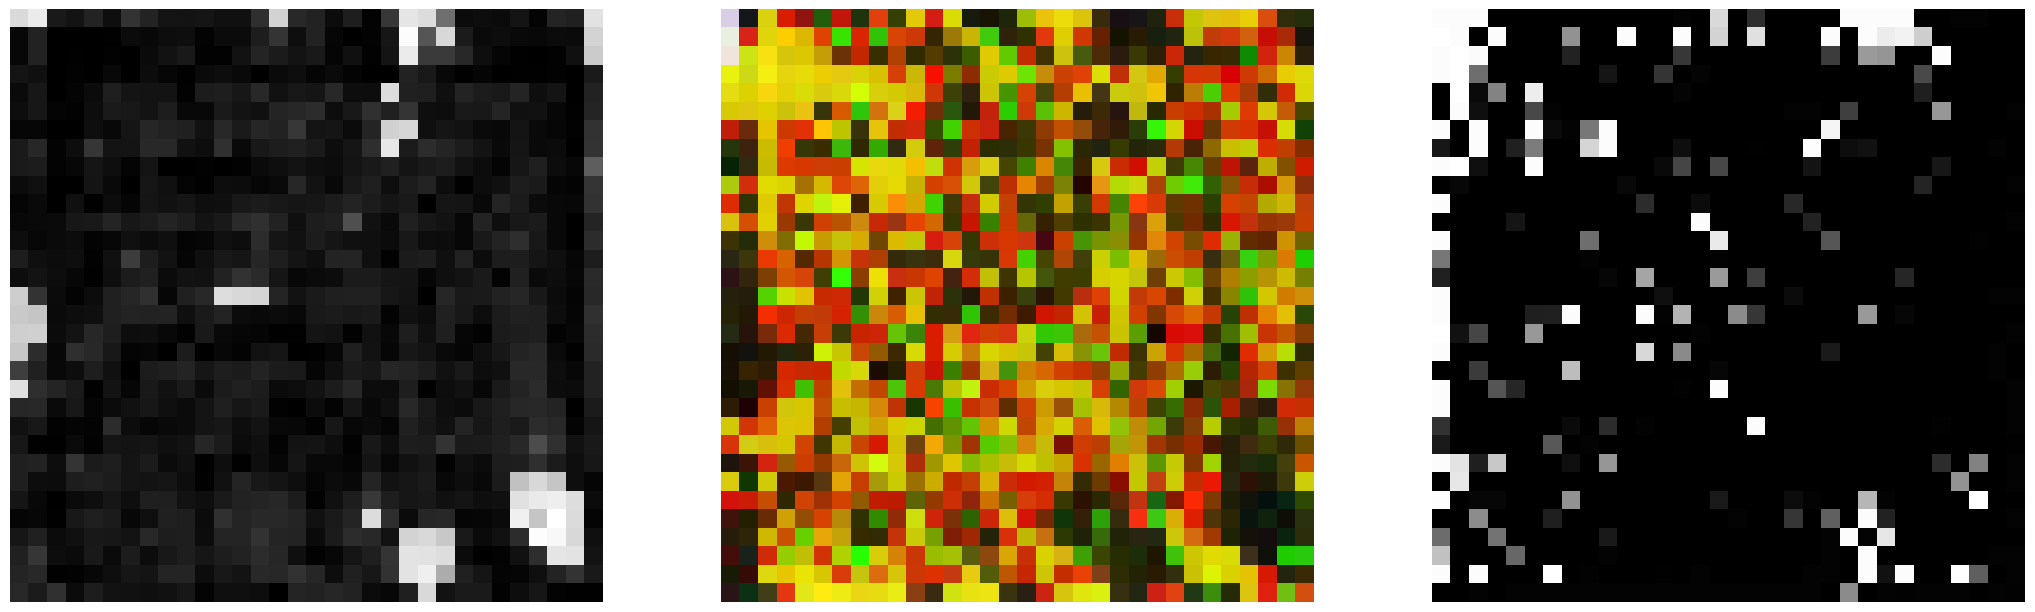

50 0.0178


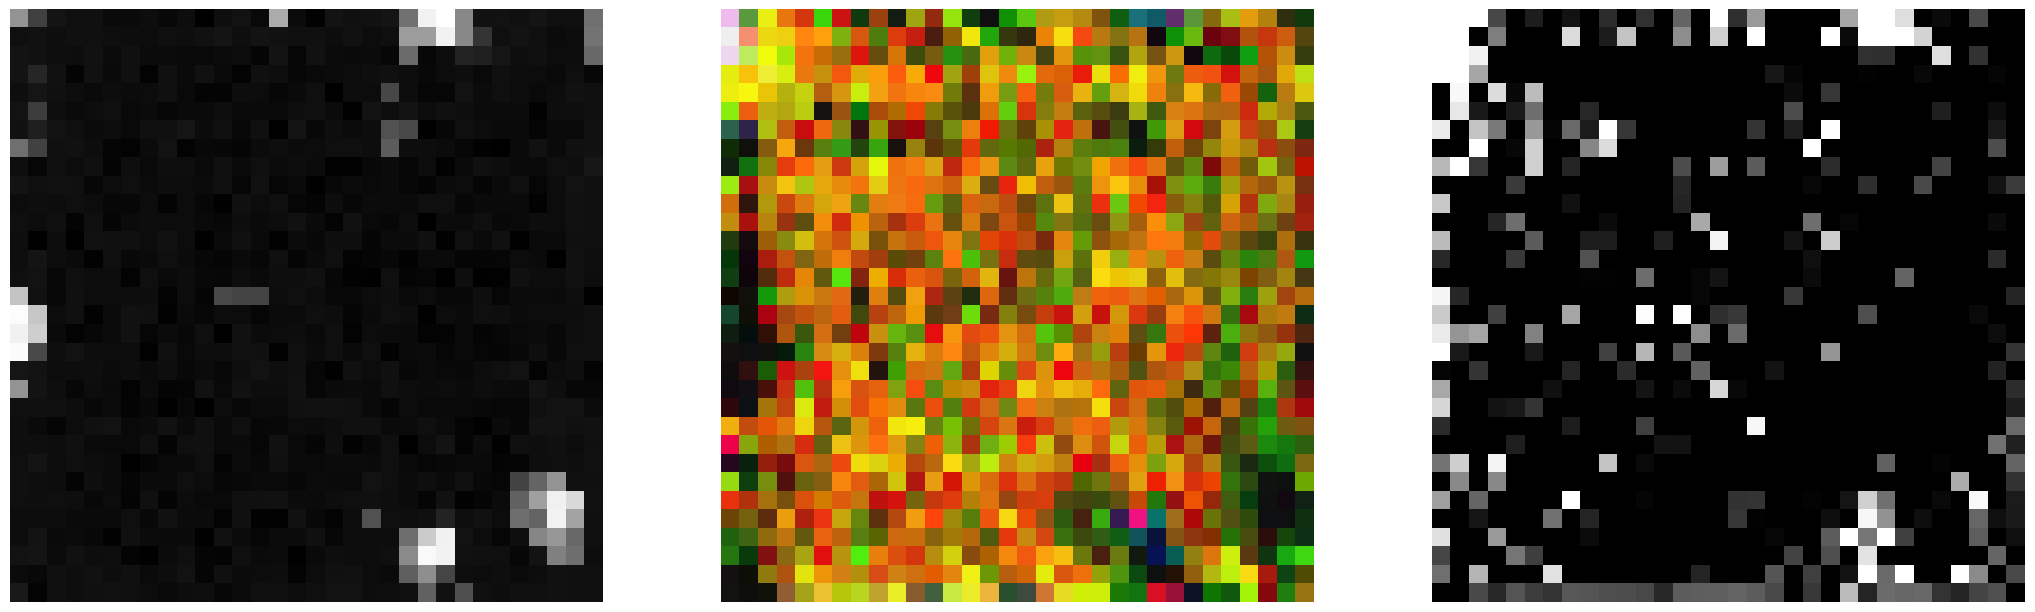

100 0.0113


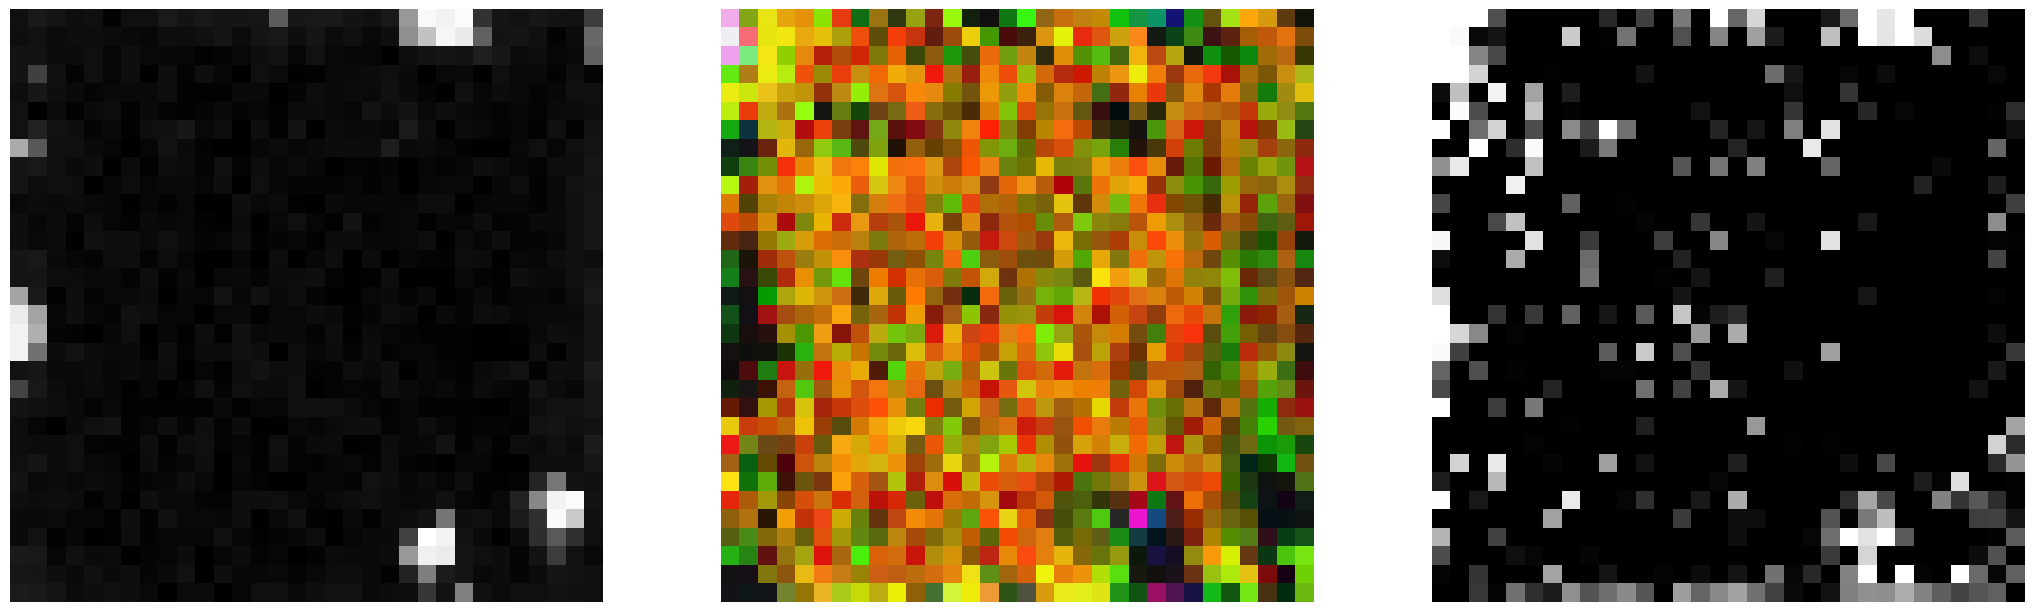

150 0.0087


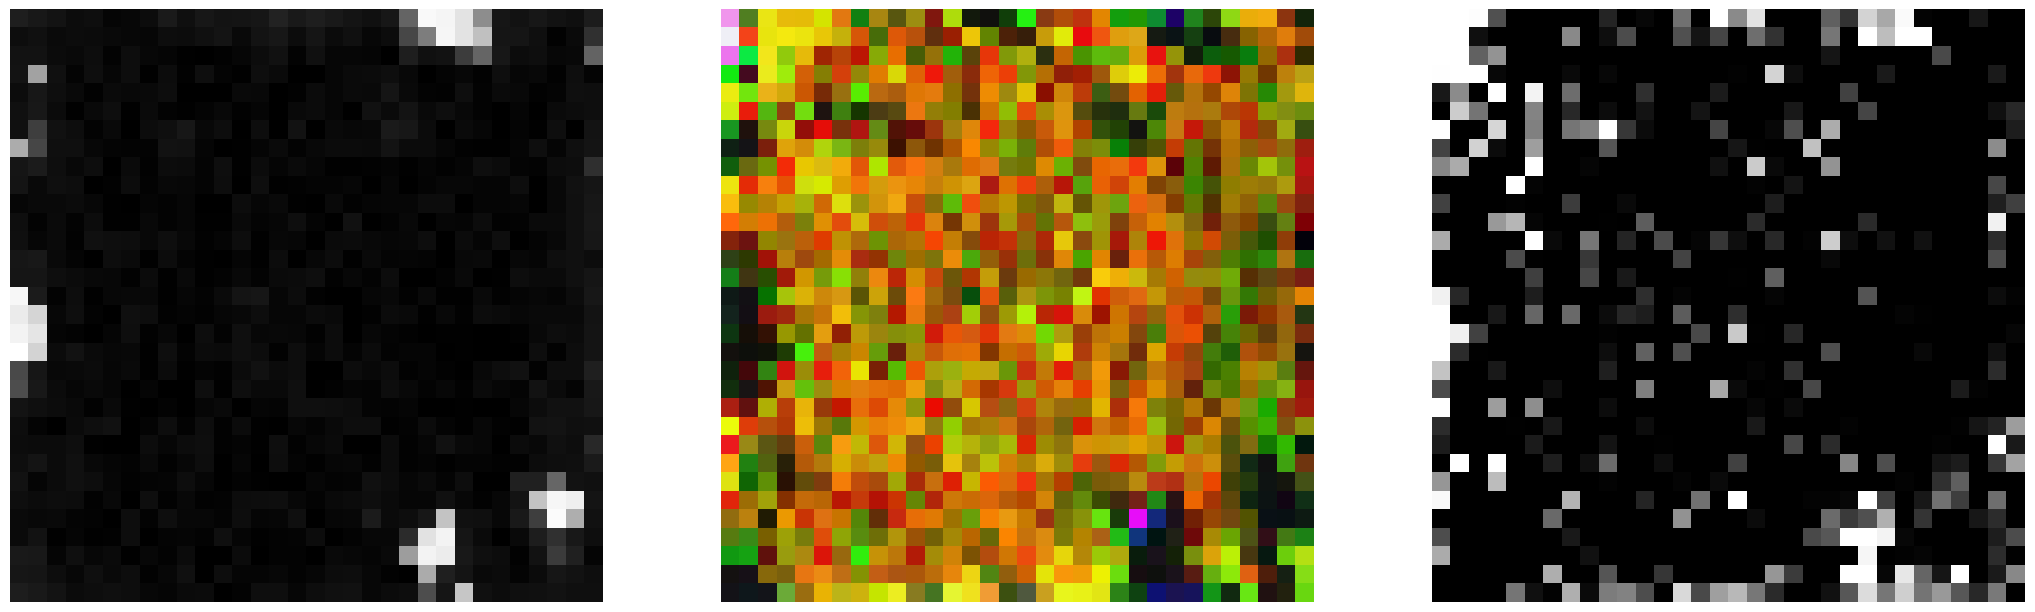

200 0.0072


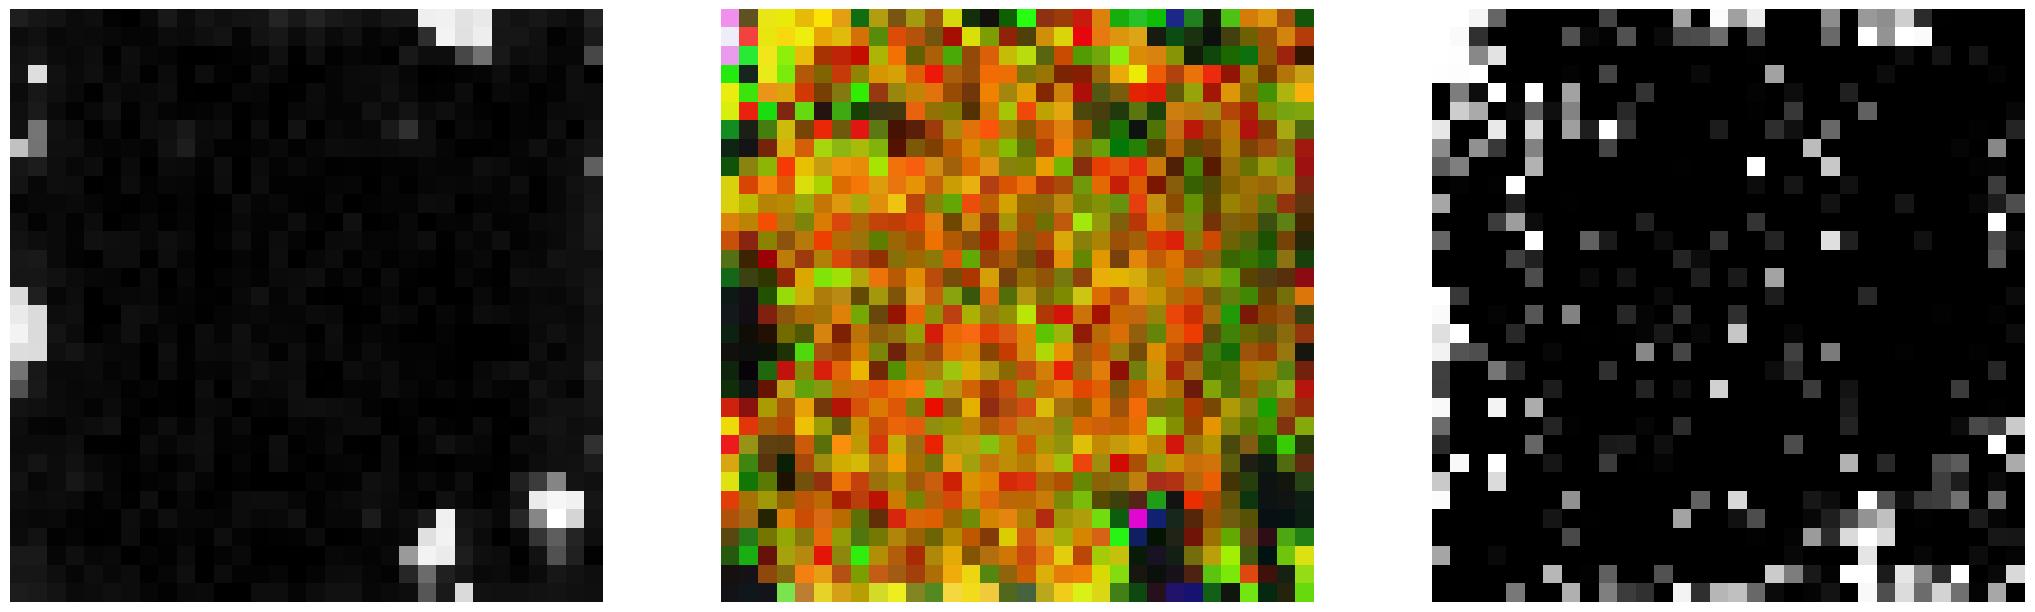

250 0.0071


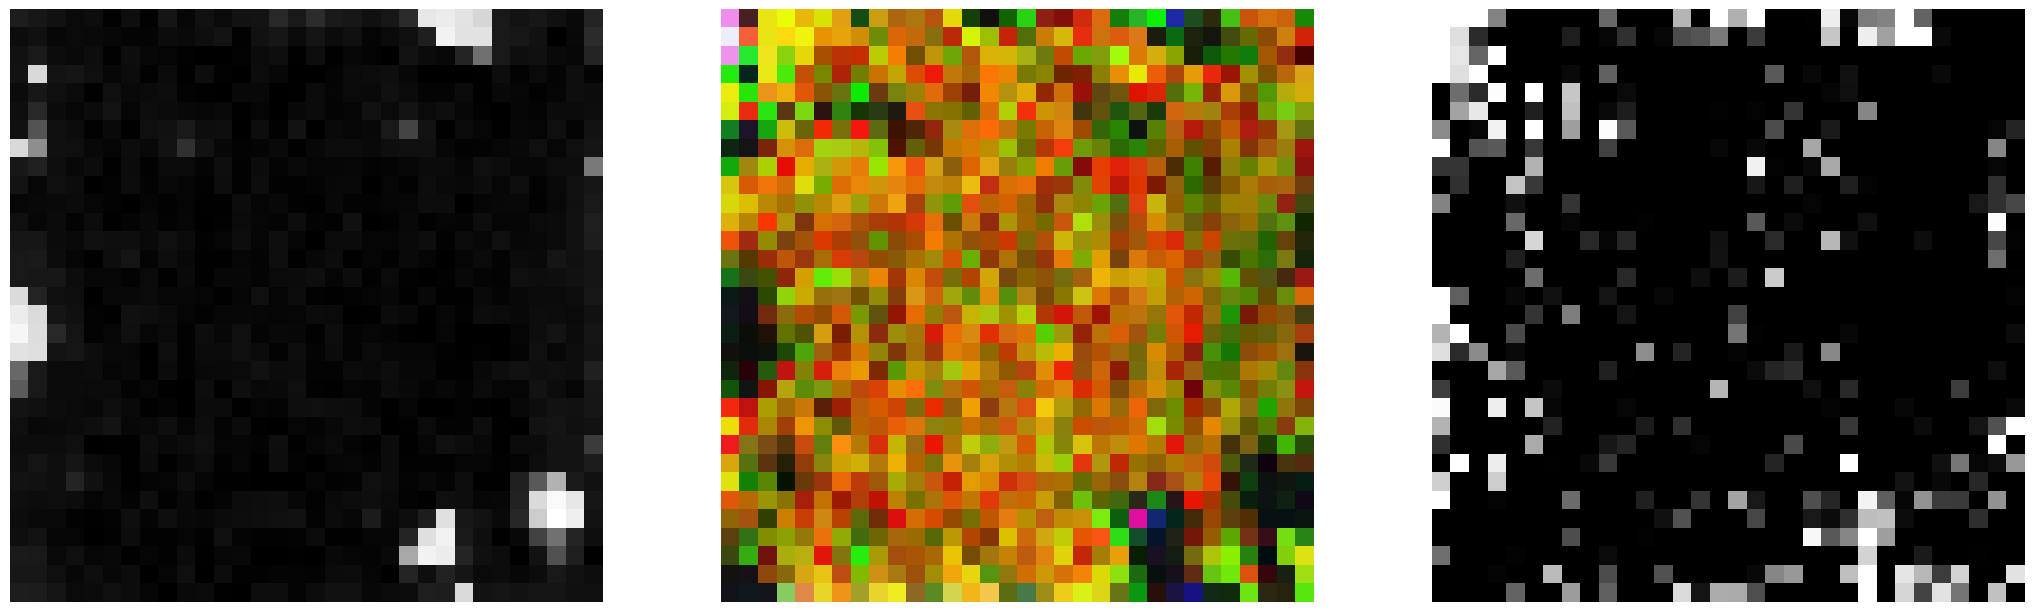

300 0.0062


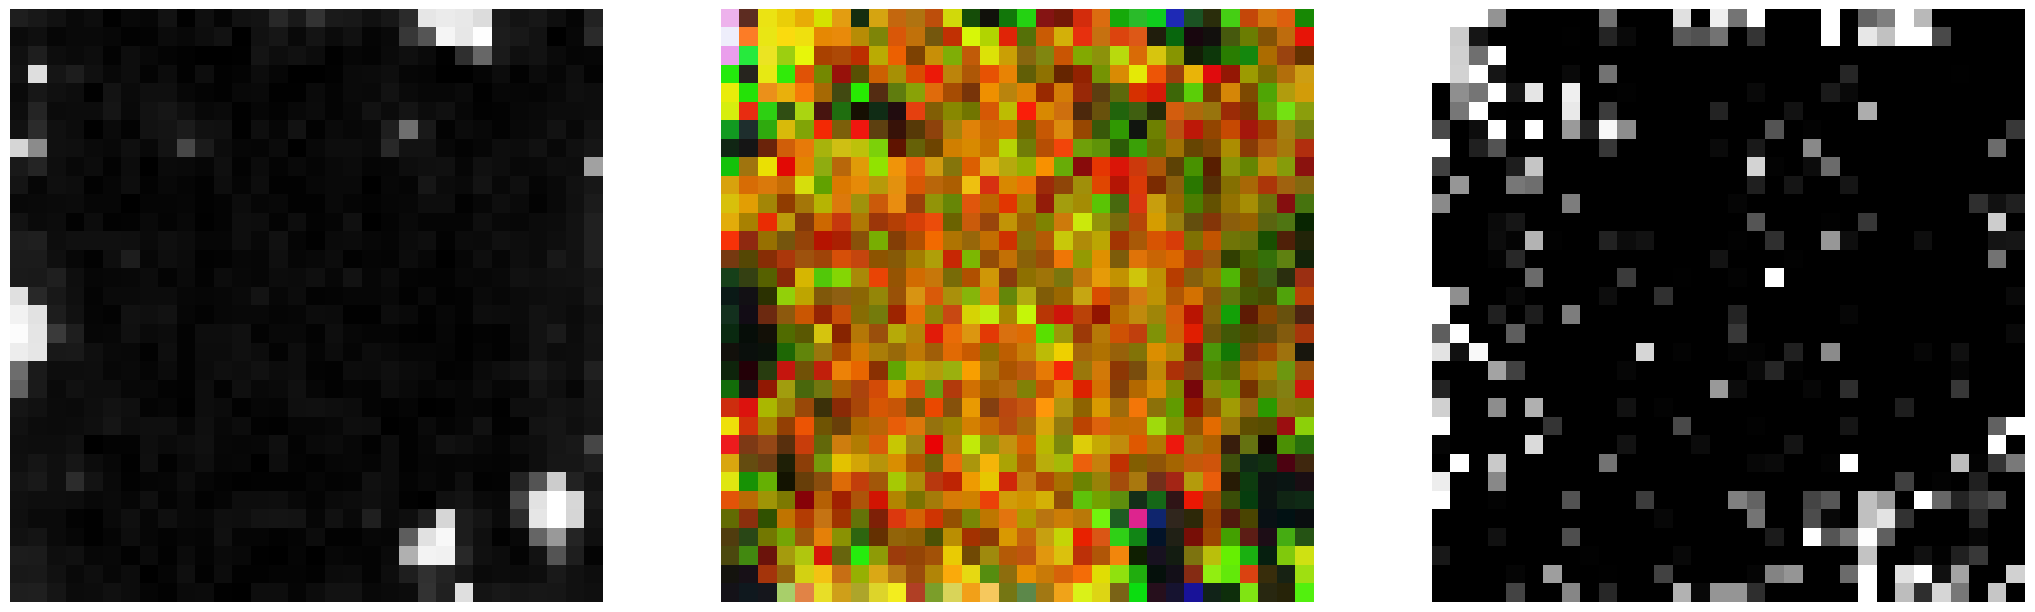

350 0.0066


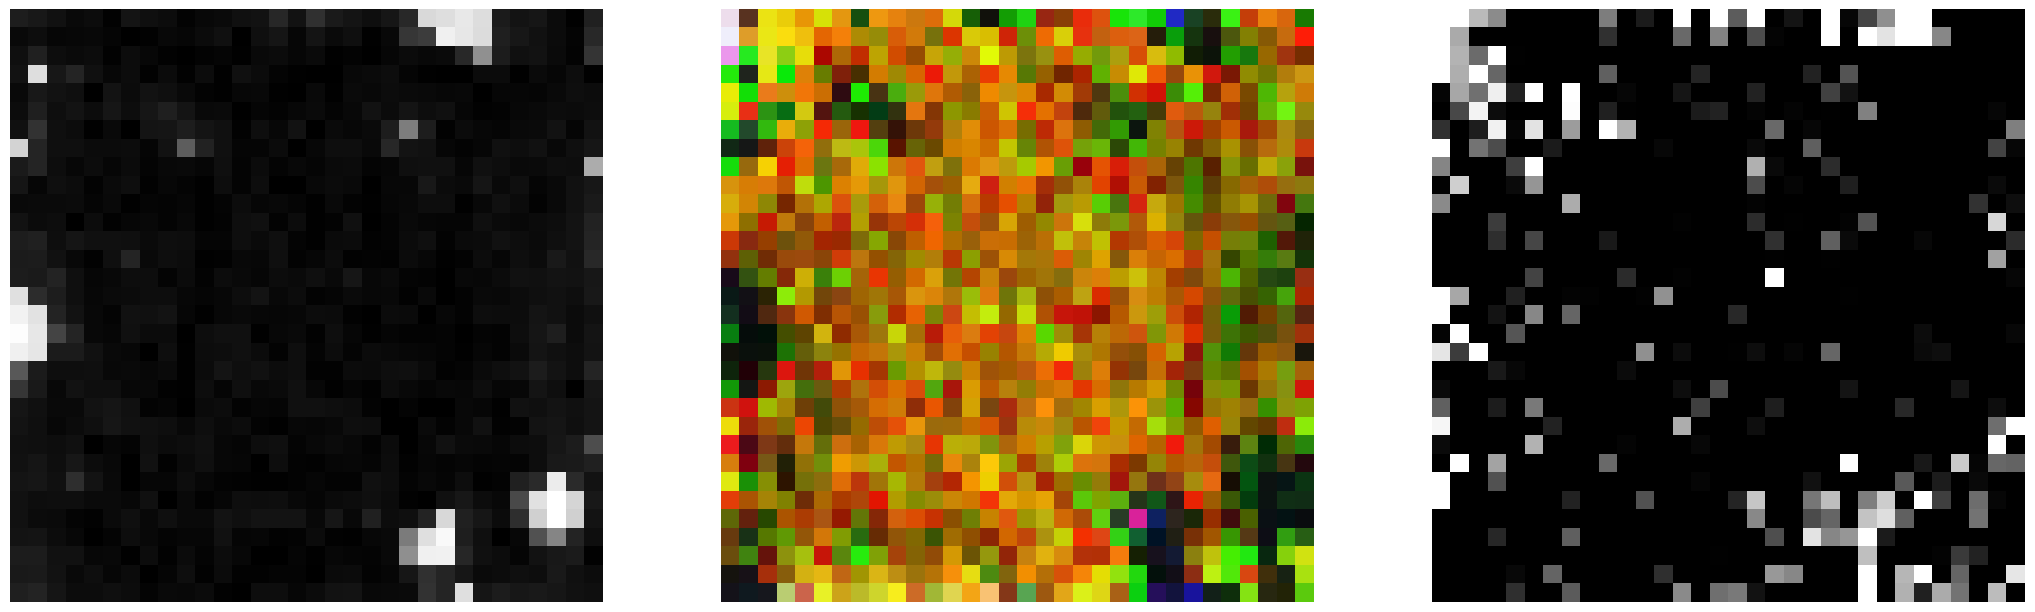

400 0.0055


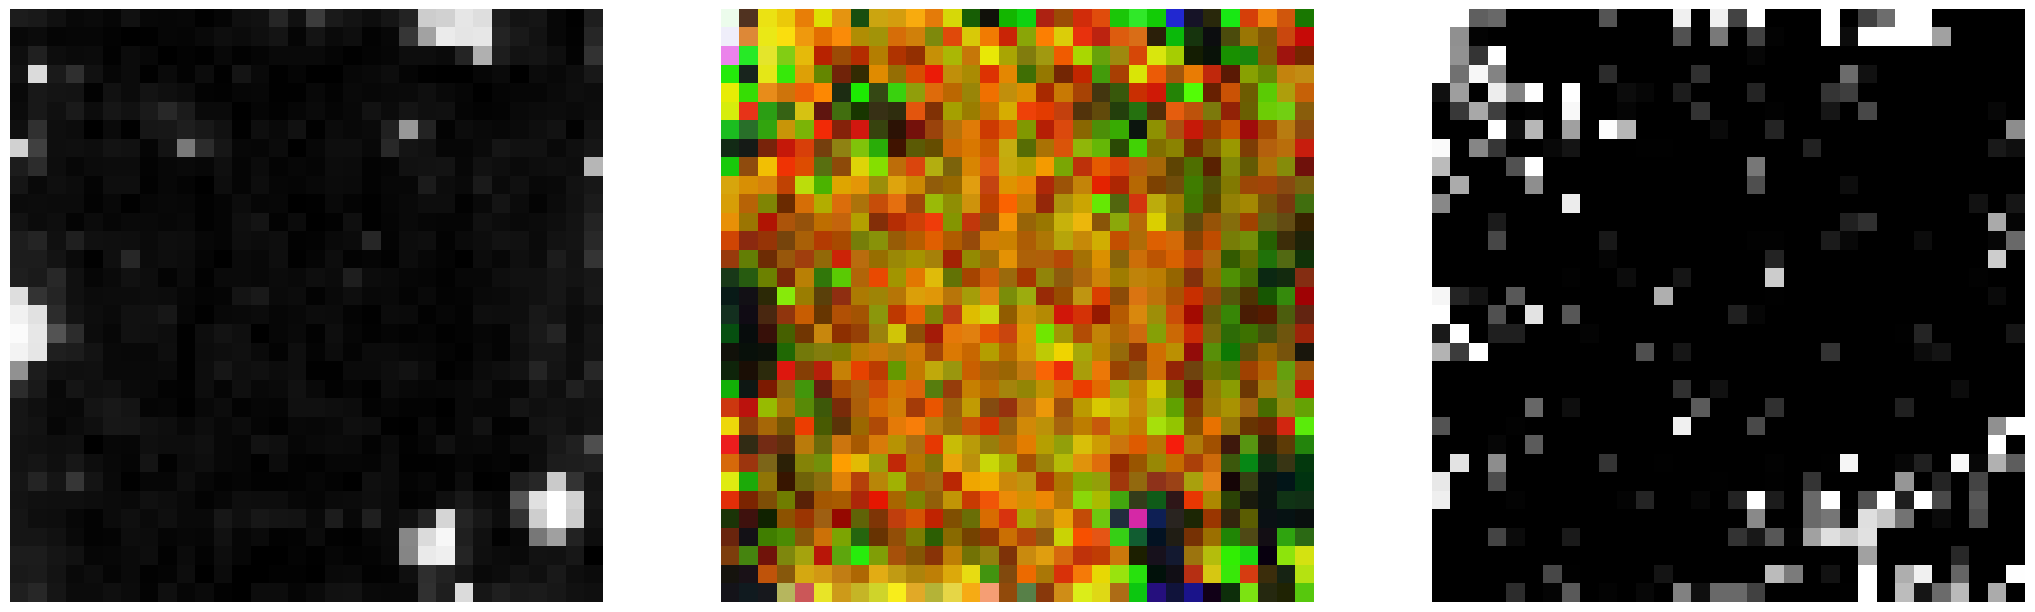

450 0.0058


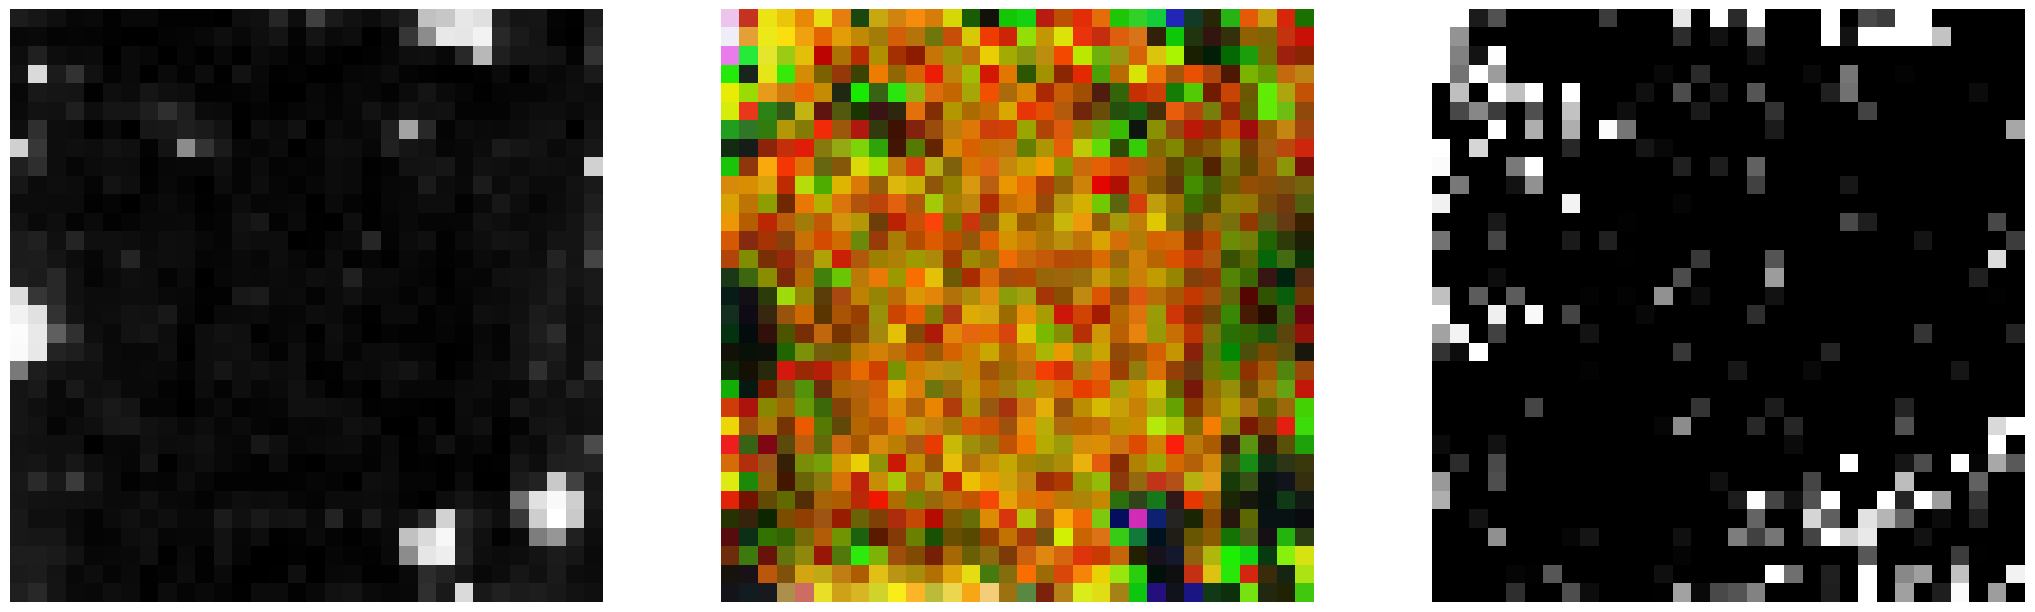

0 0.0162


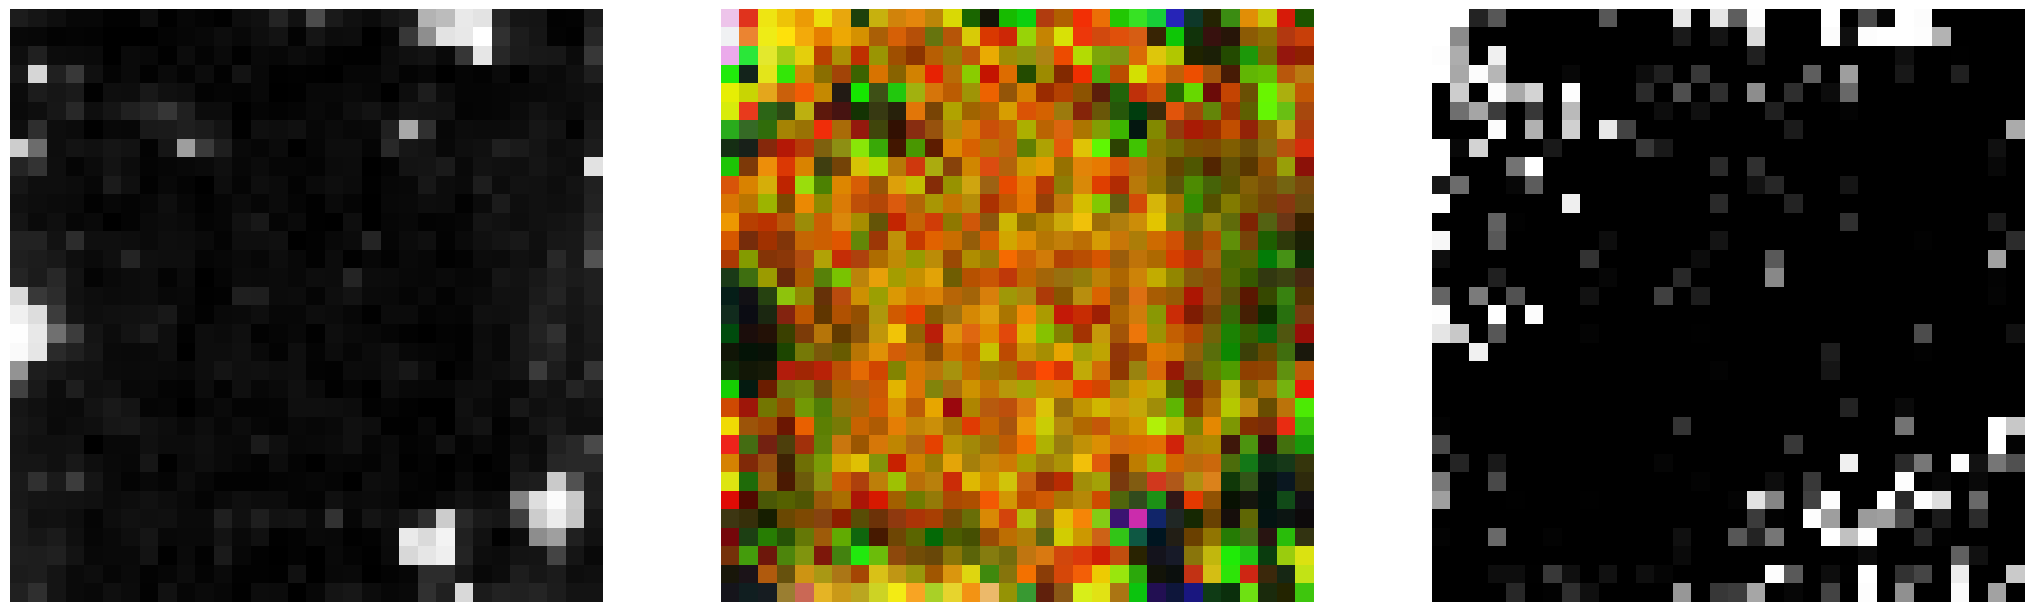

50 0.0177


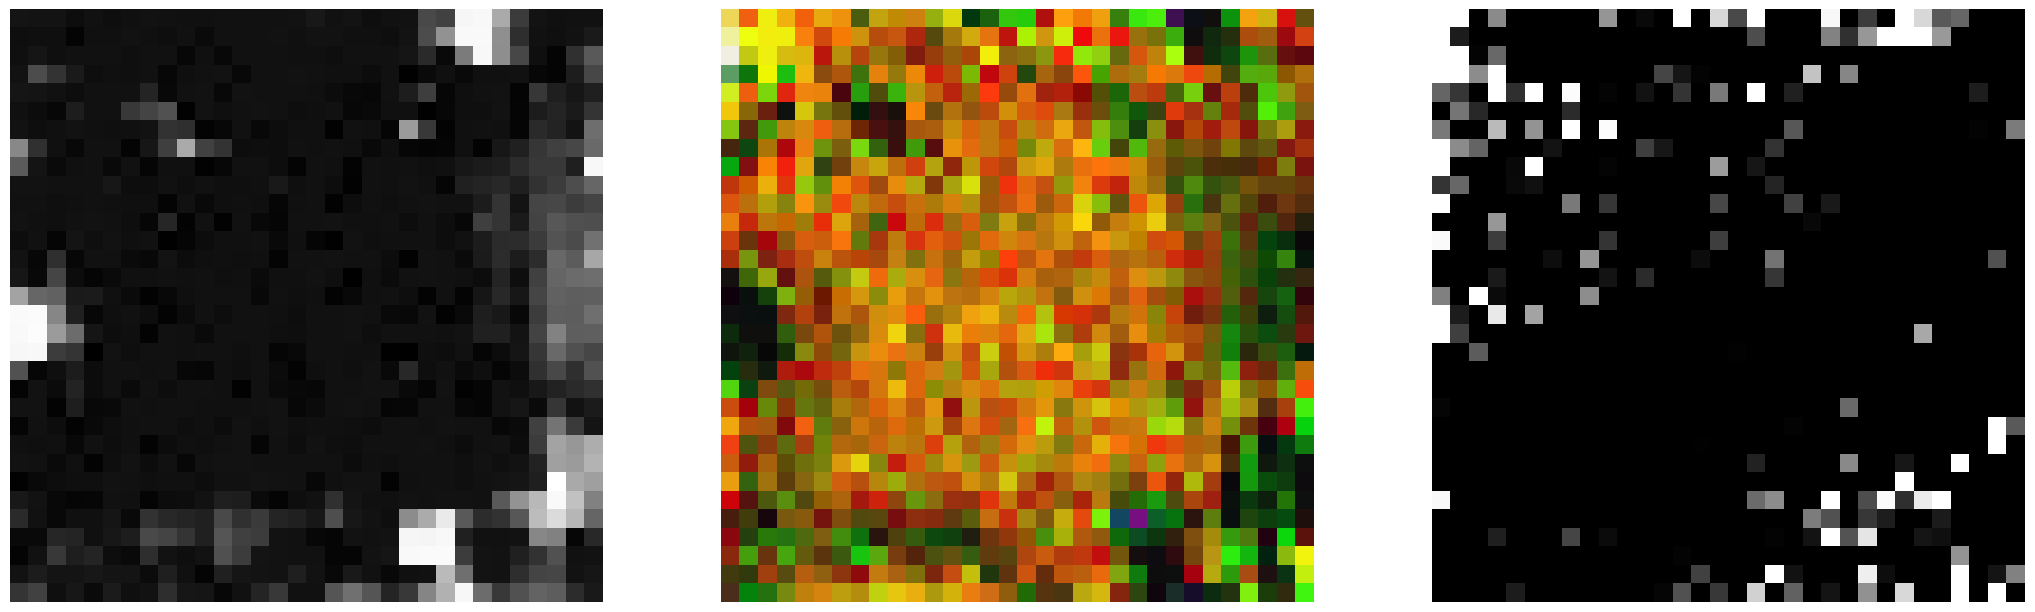

100 0.0205


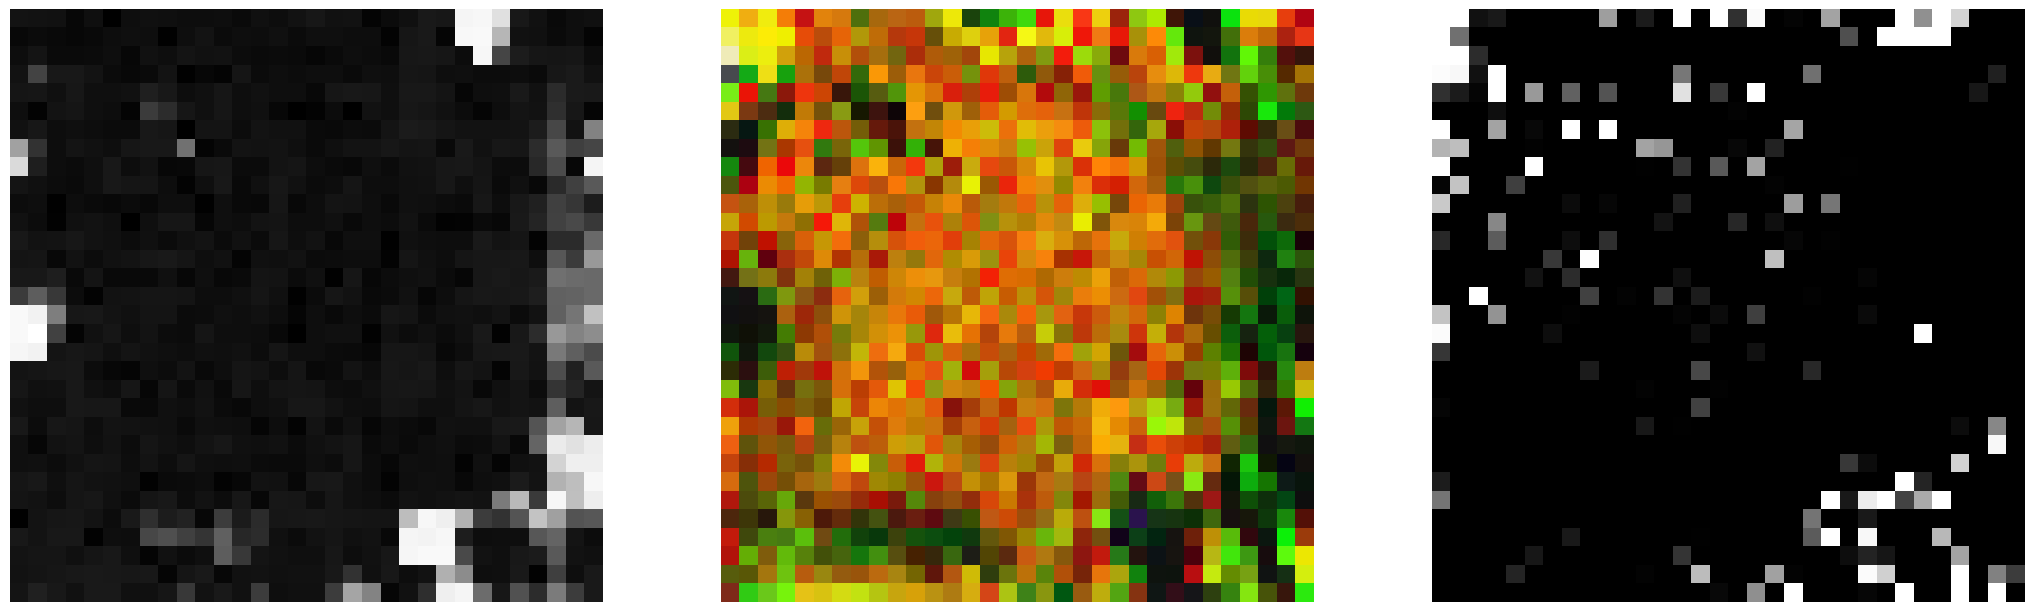

150 0.0187


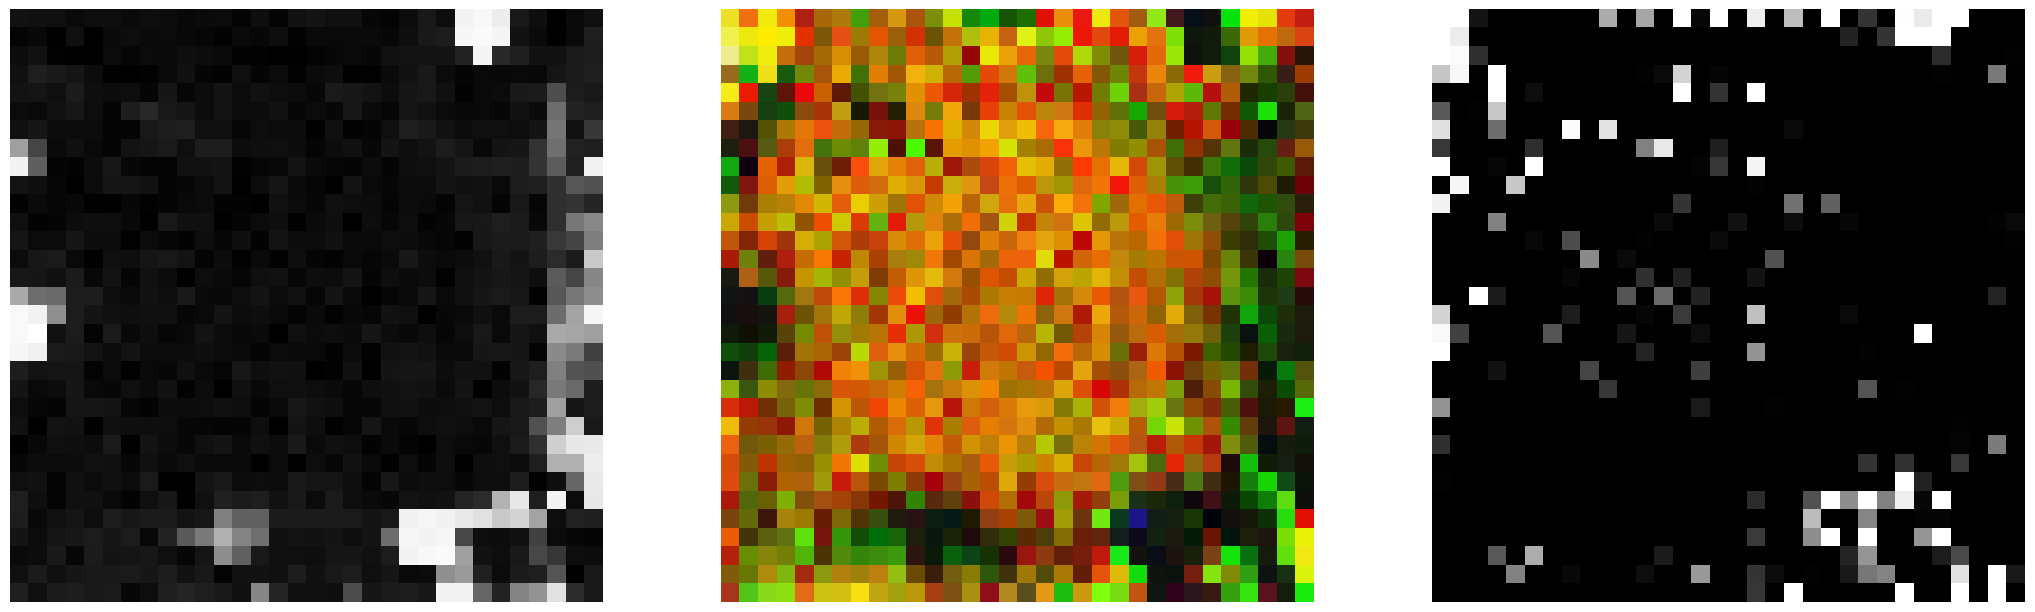

200 0.0222


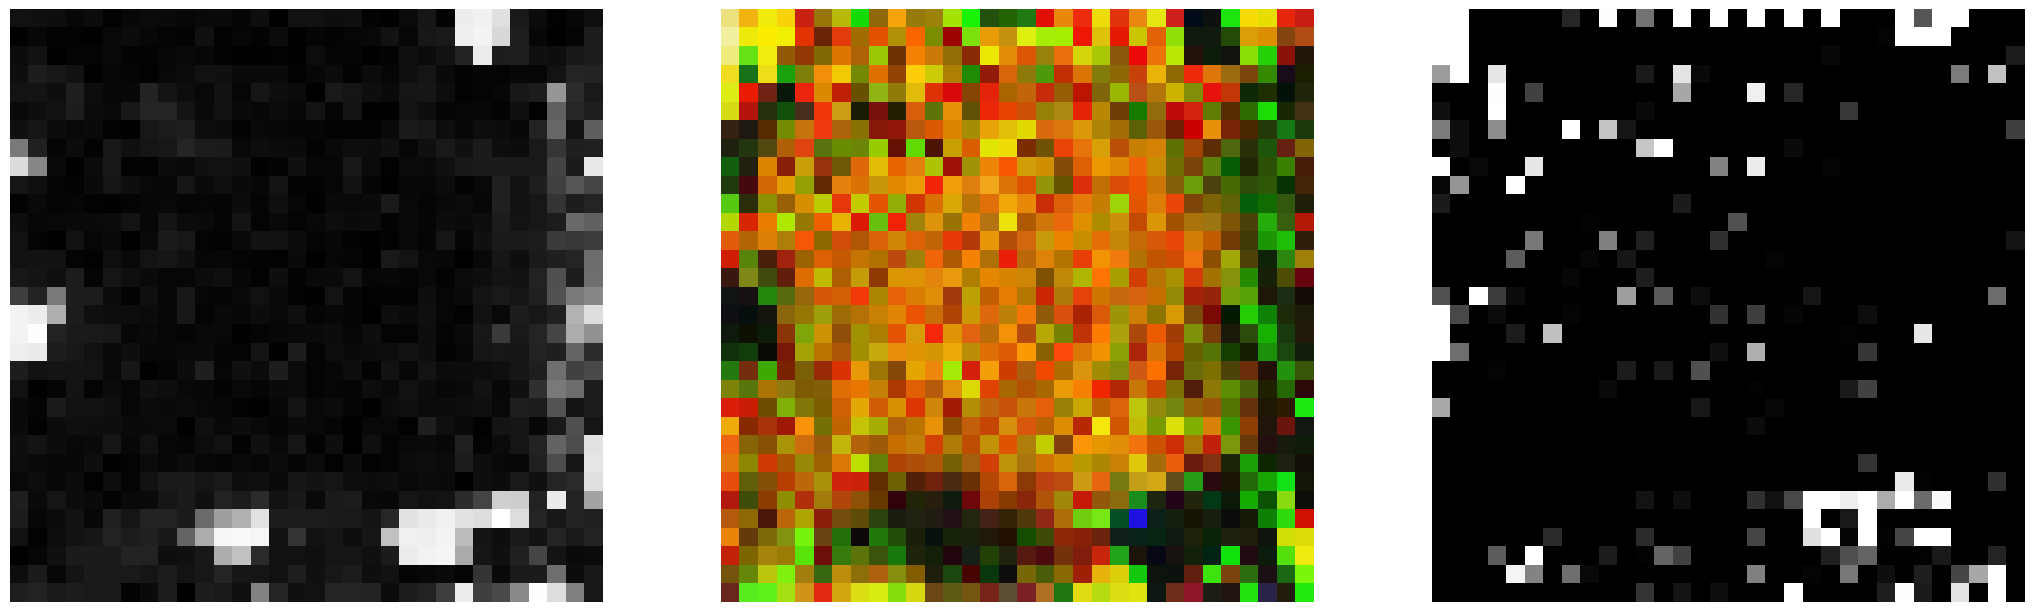

250 0.0229


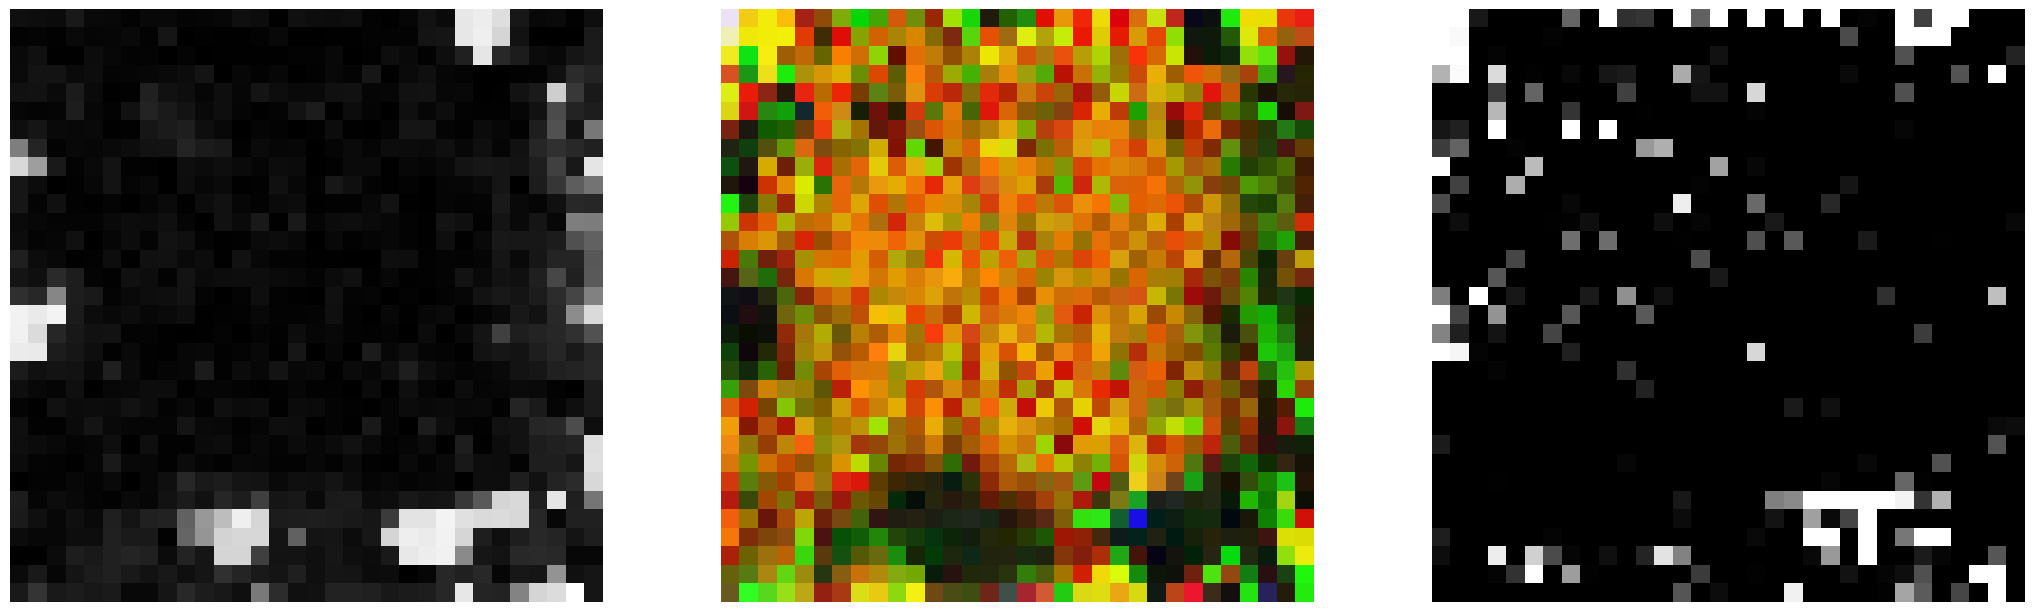

300 0.0244


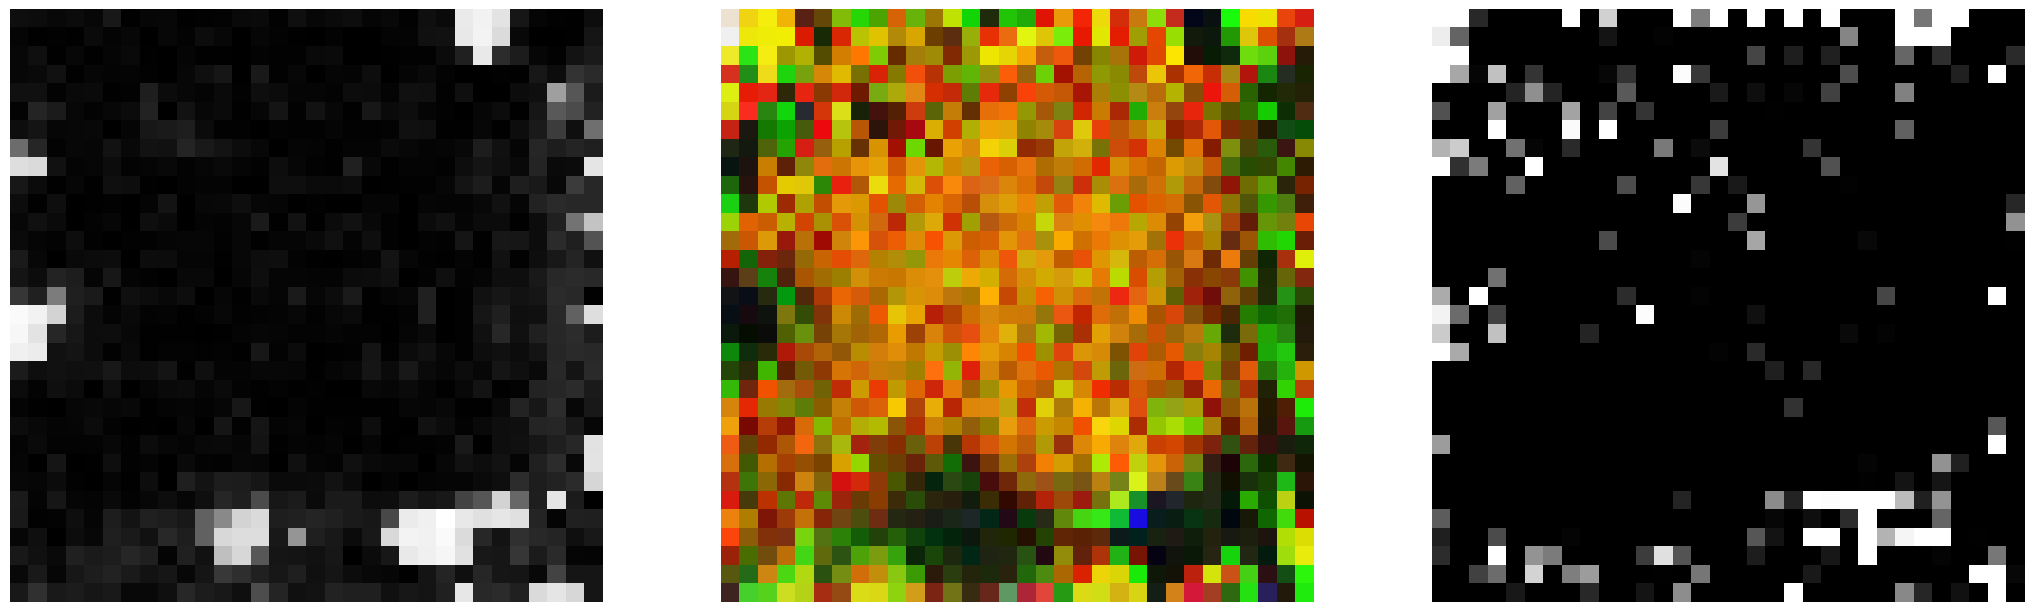

350 0.0278


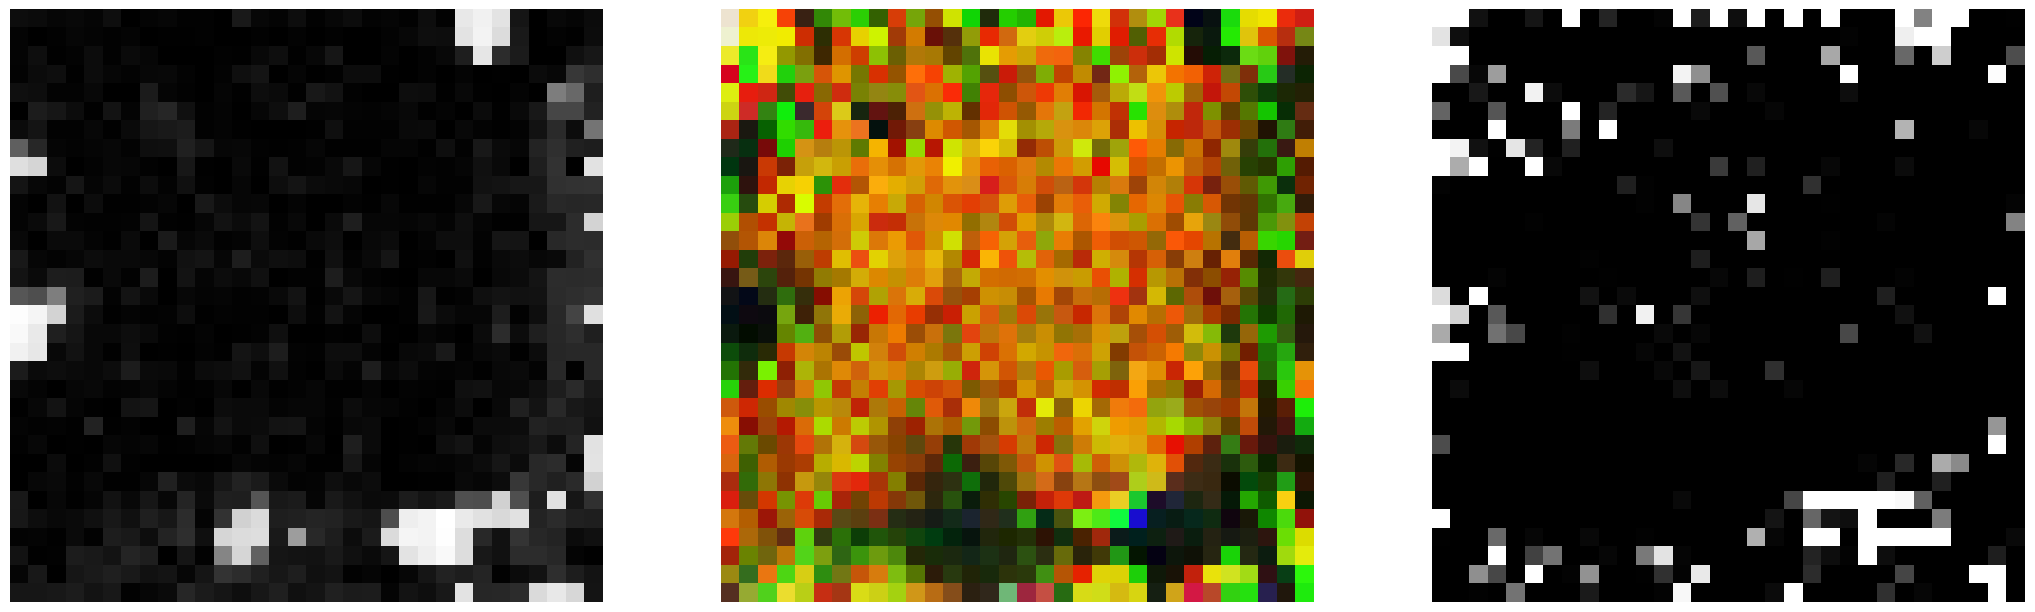

400 0.0208


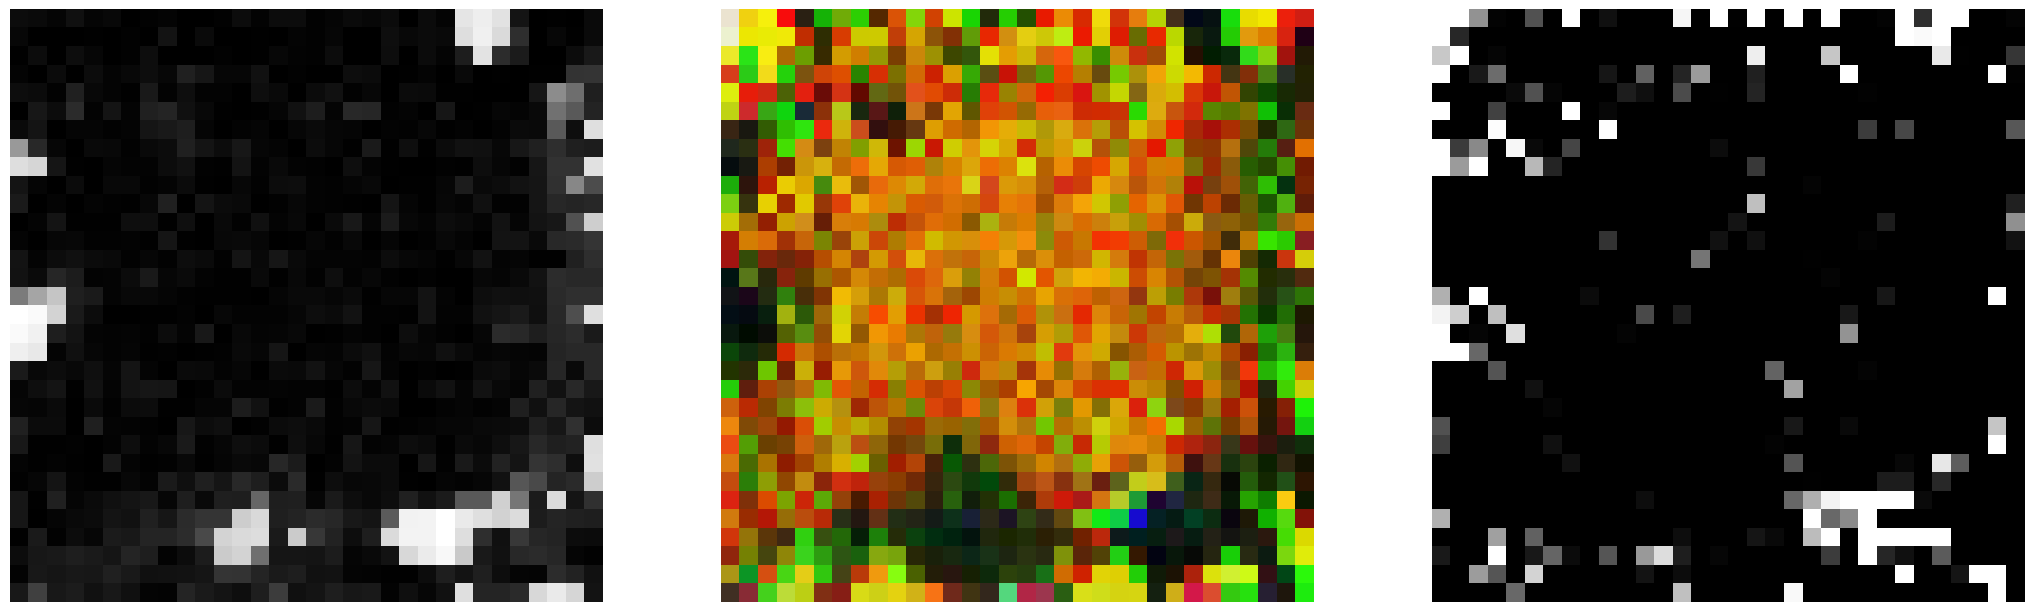

450 0.0177


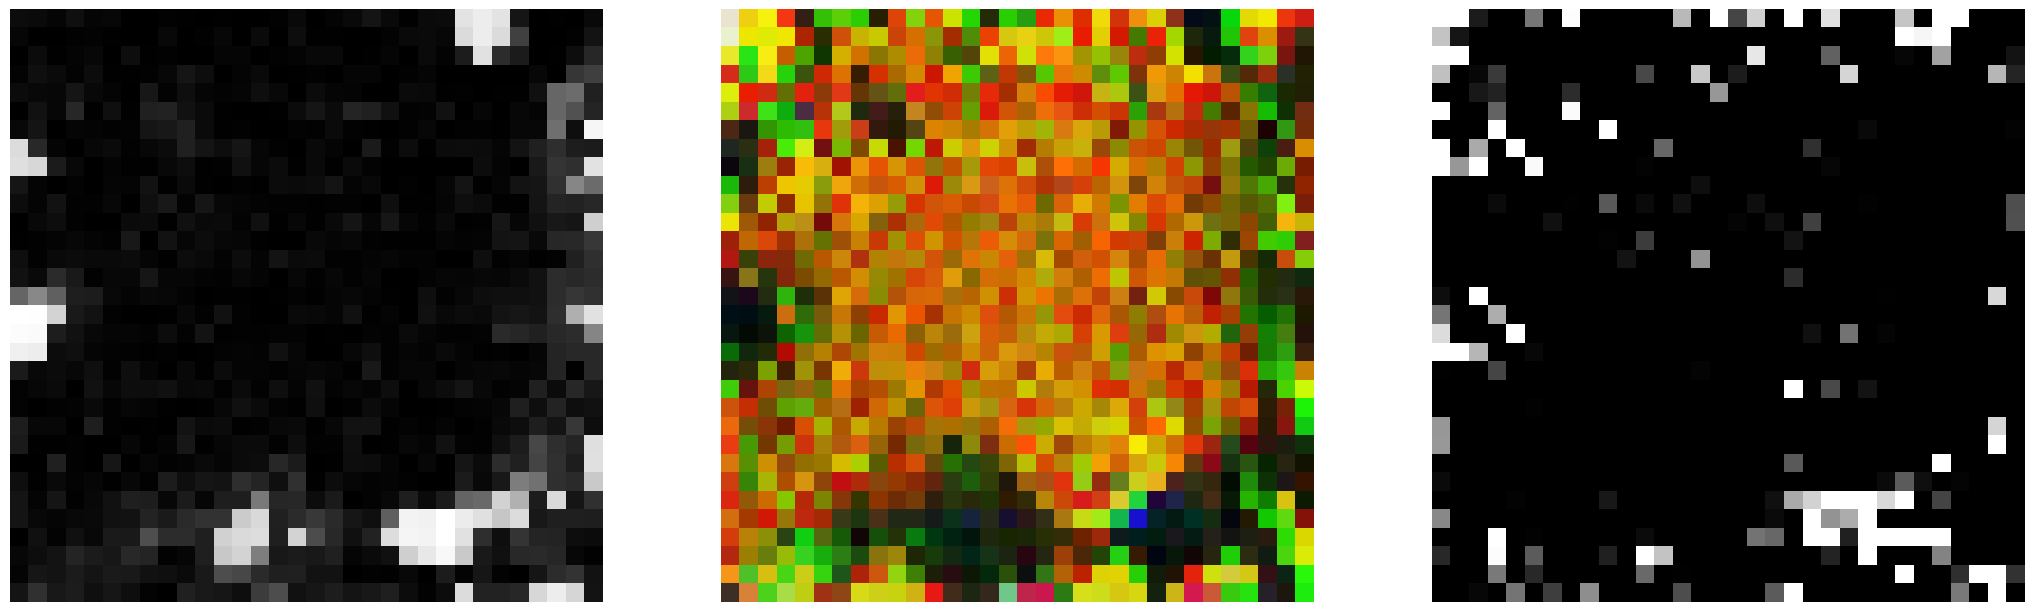

0 0.0224


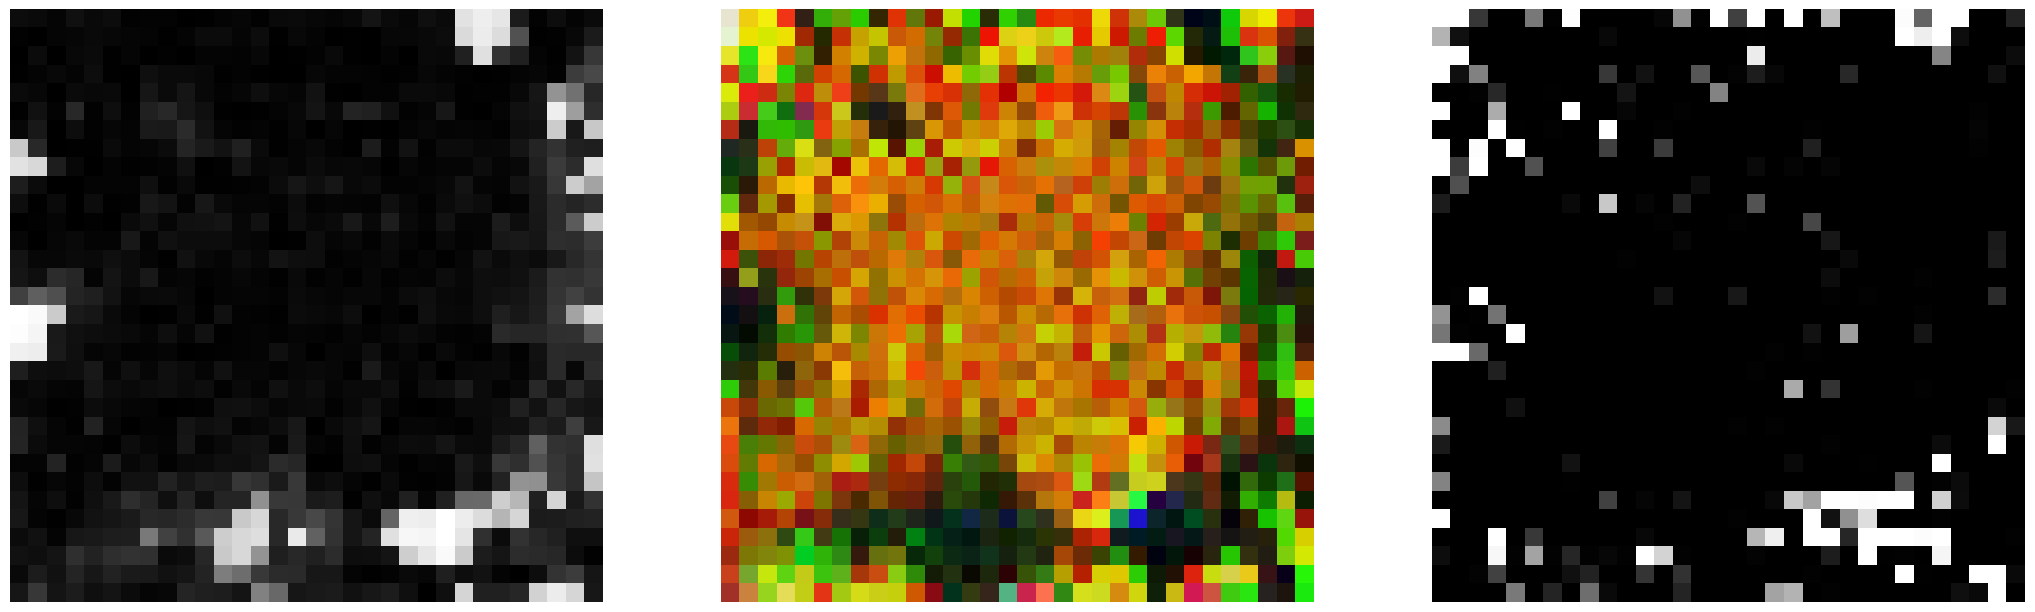

50 0.0121


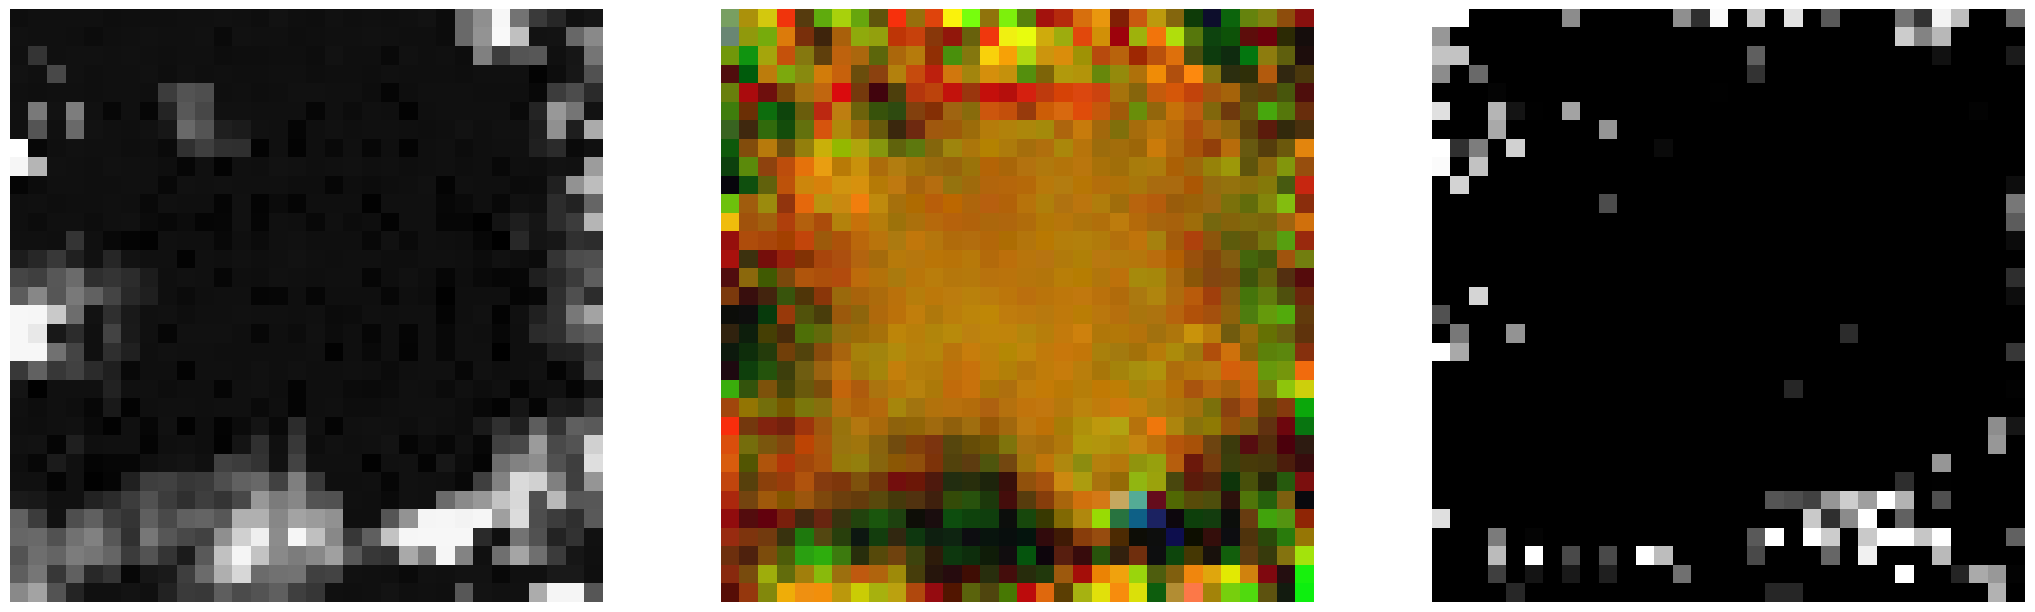

100 0.0086


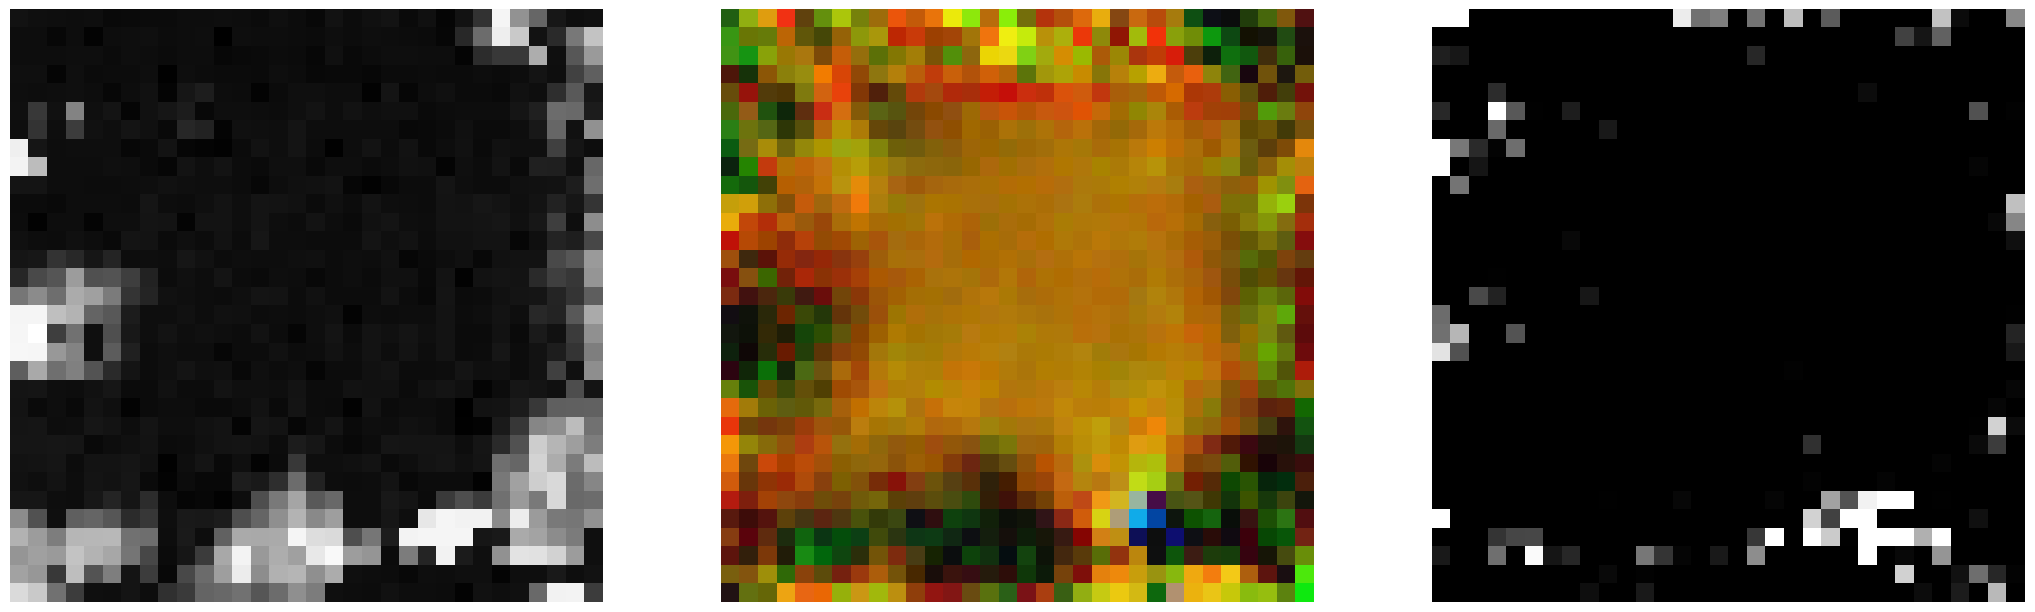

150 0.0082


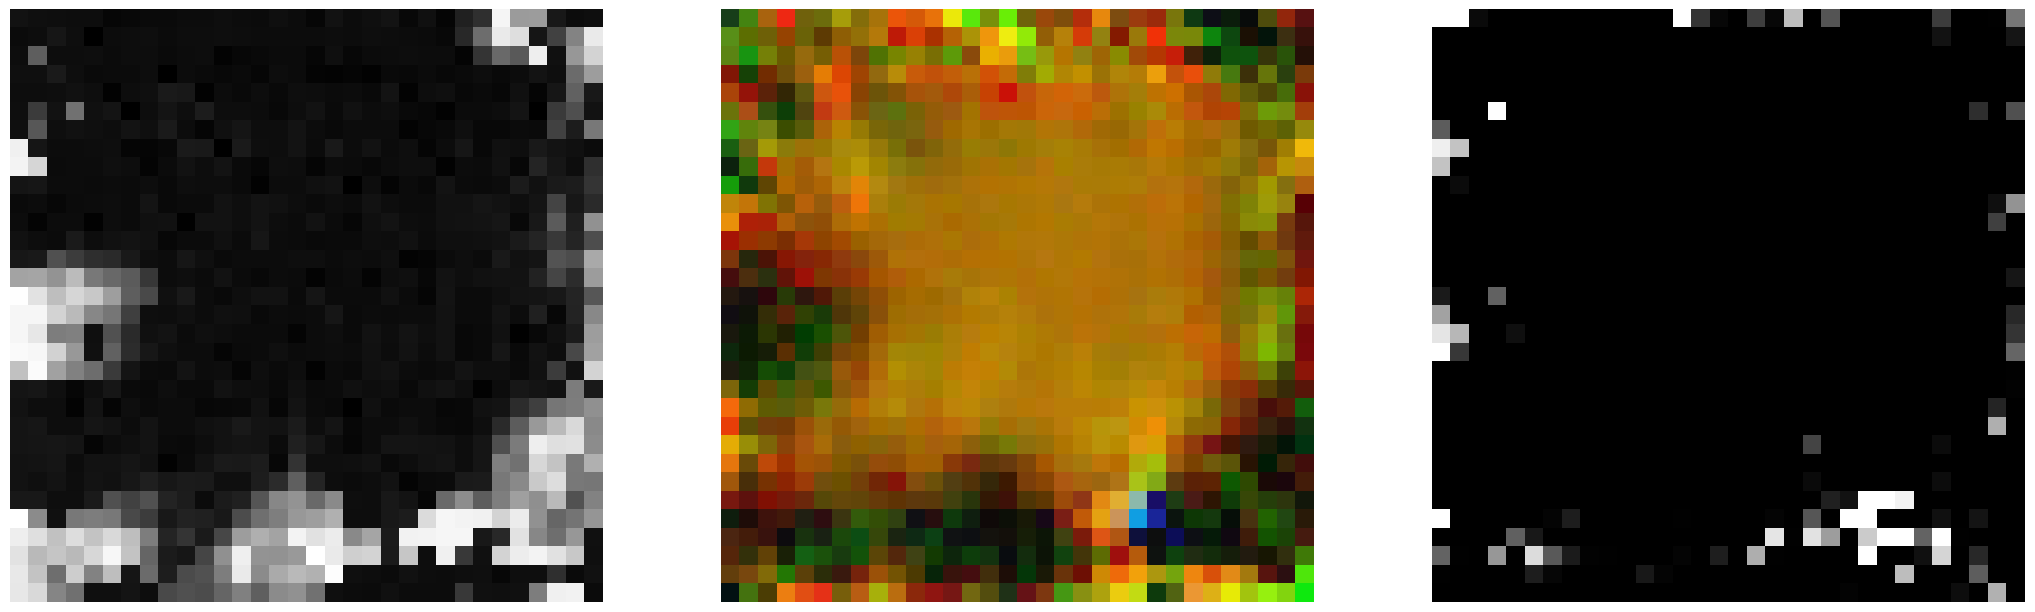

200 0.0073


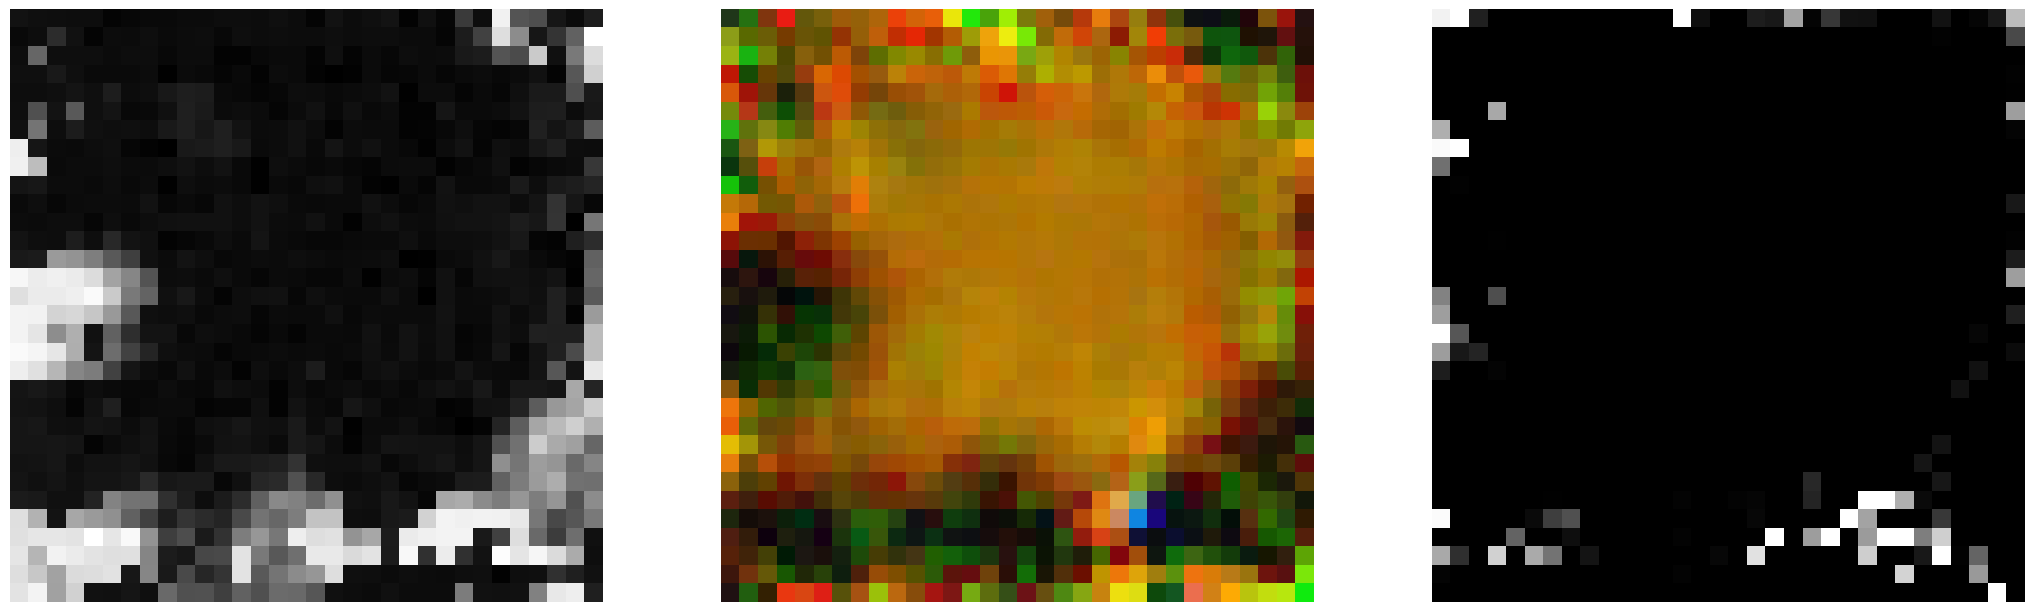

250 0.0085


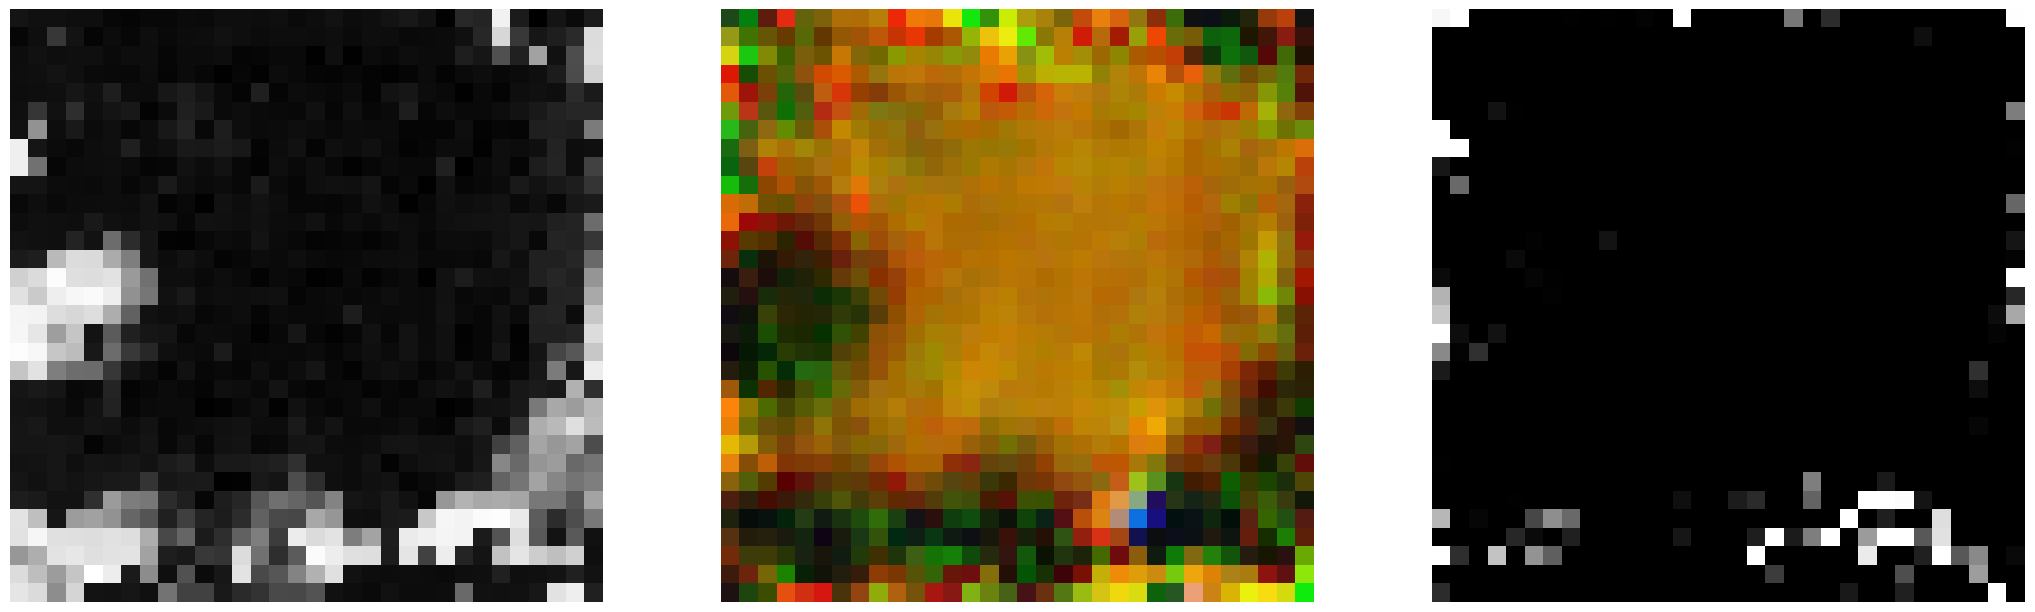

300 0.0081


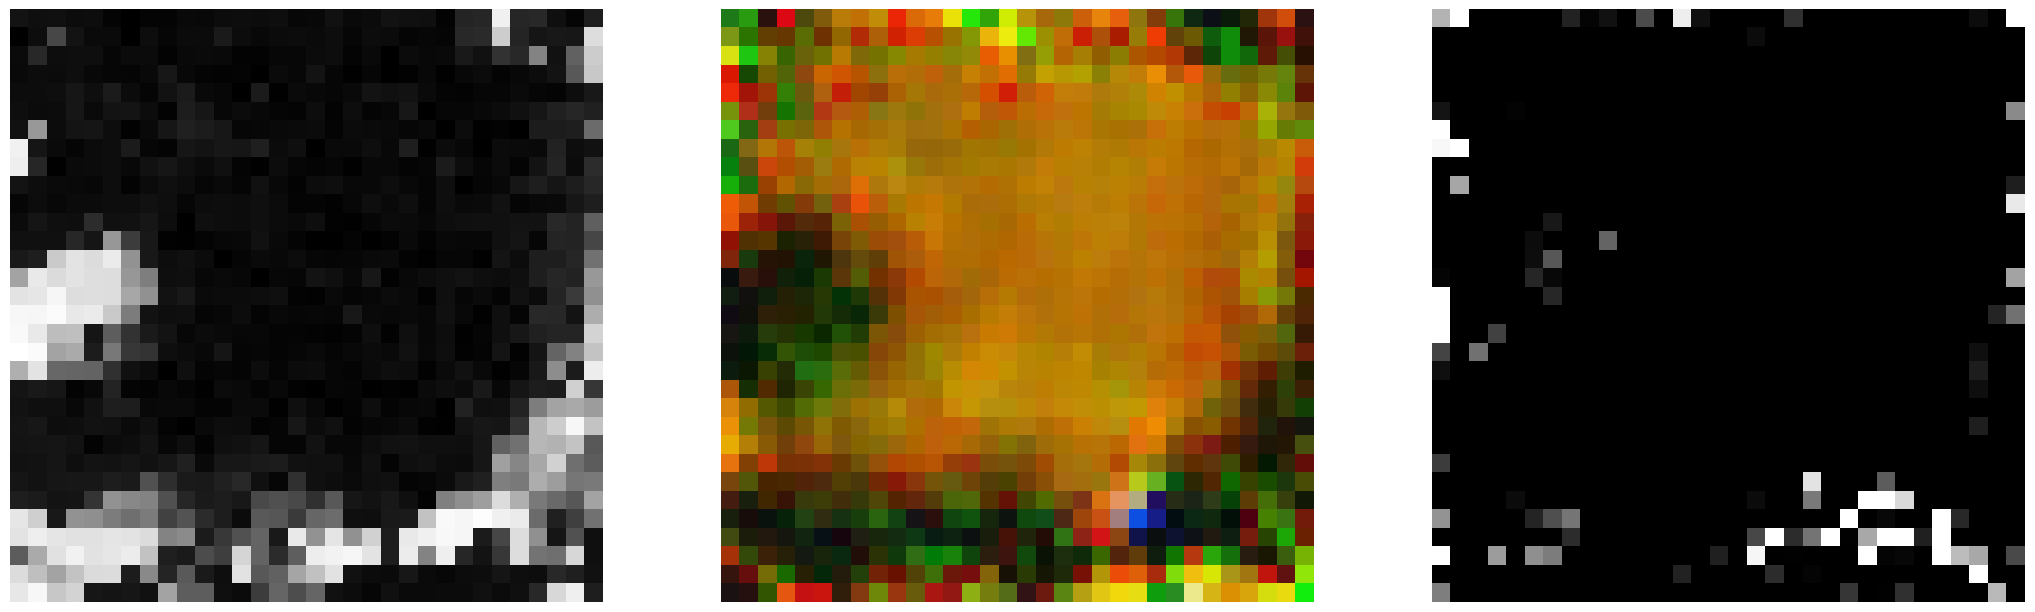

350 0.0074


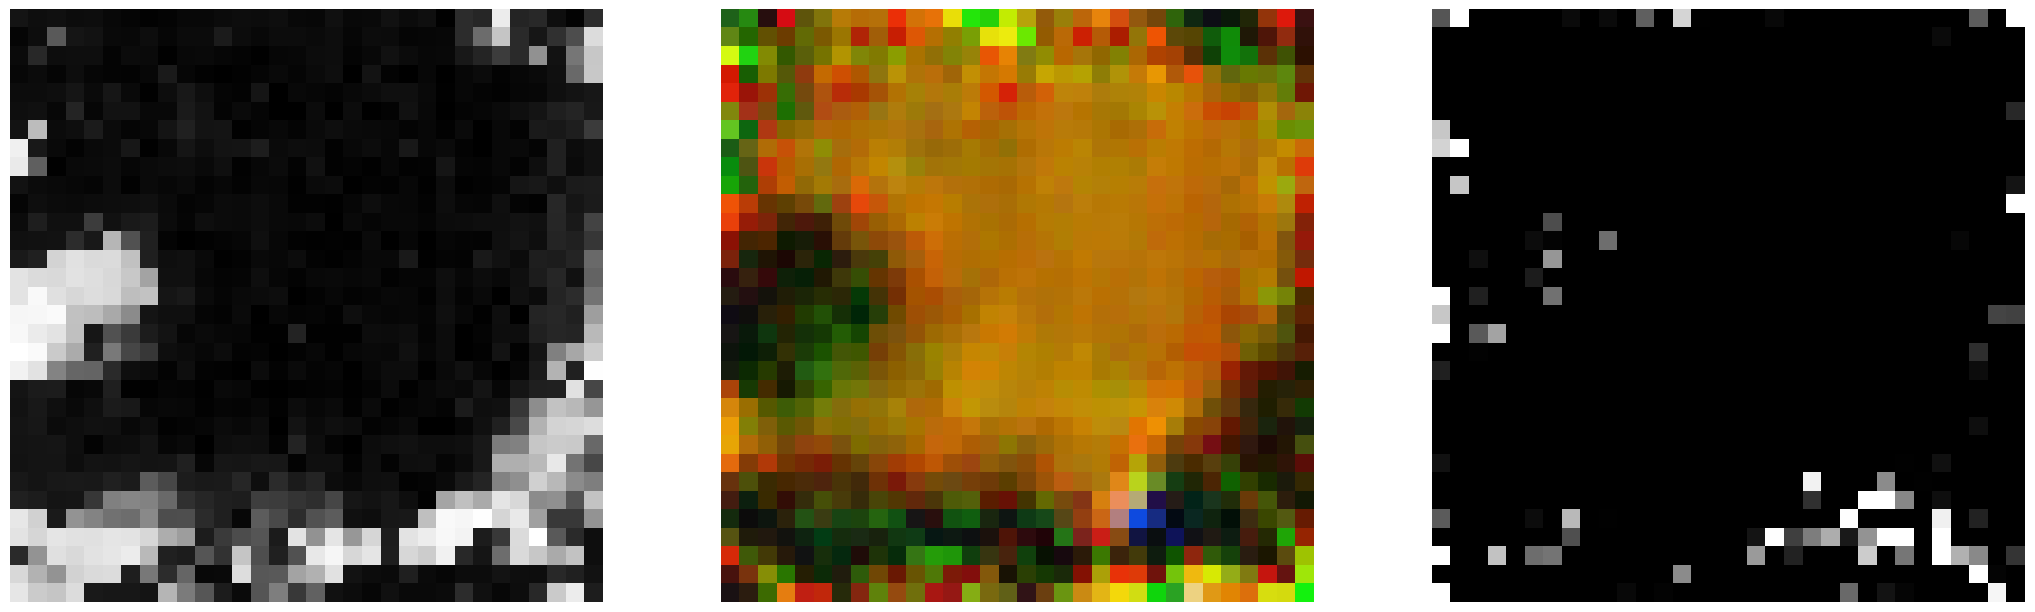

400 0.0076


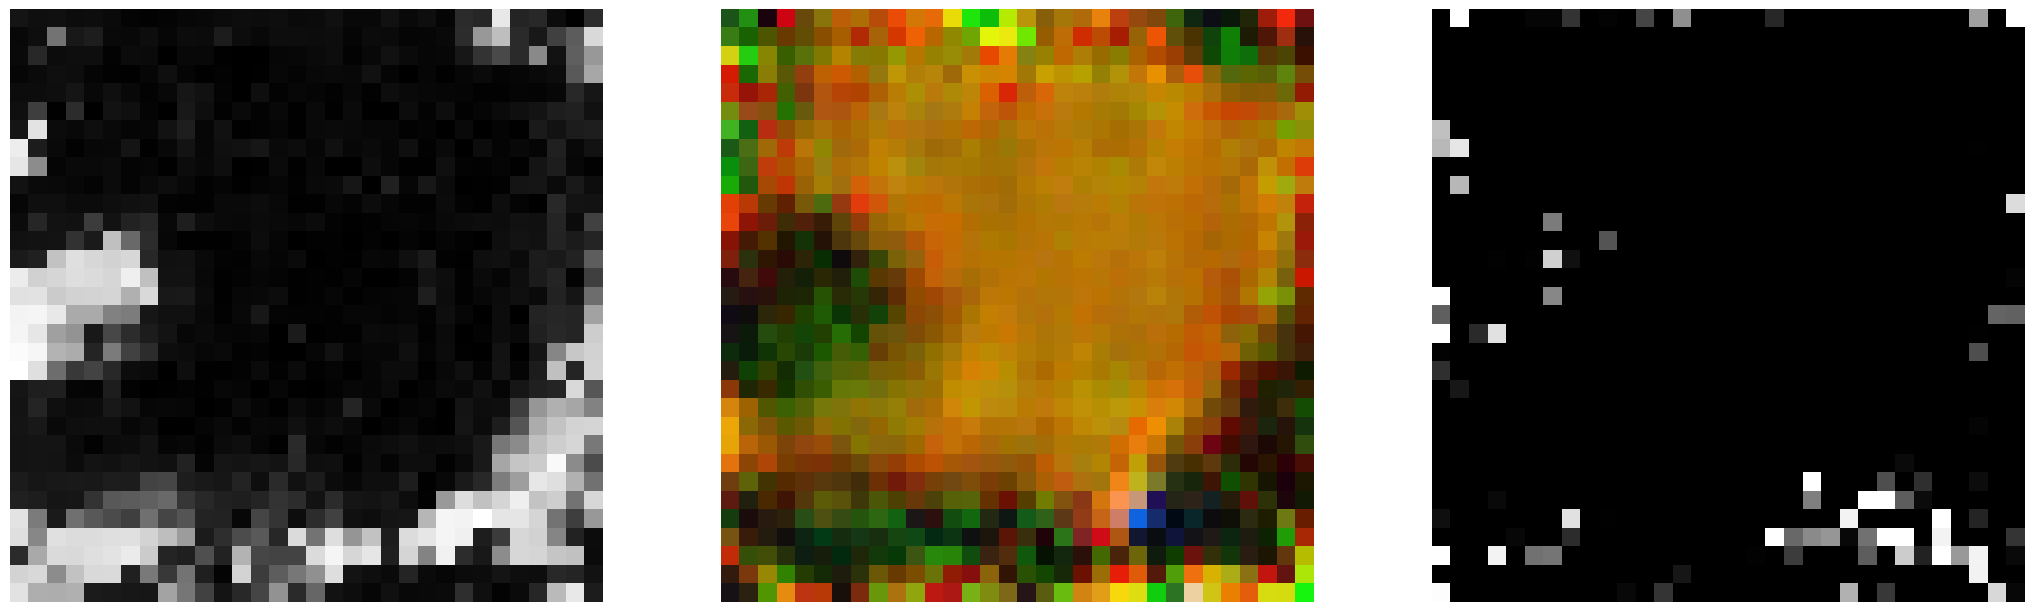

450 0.0081


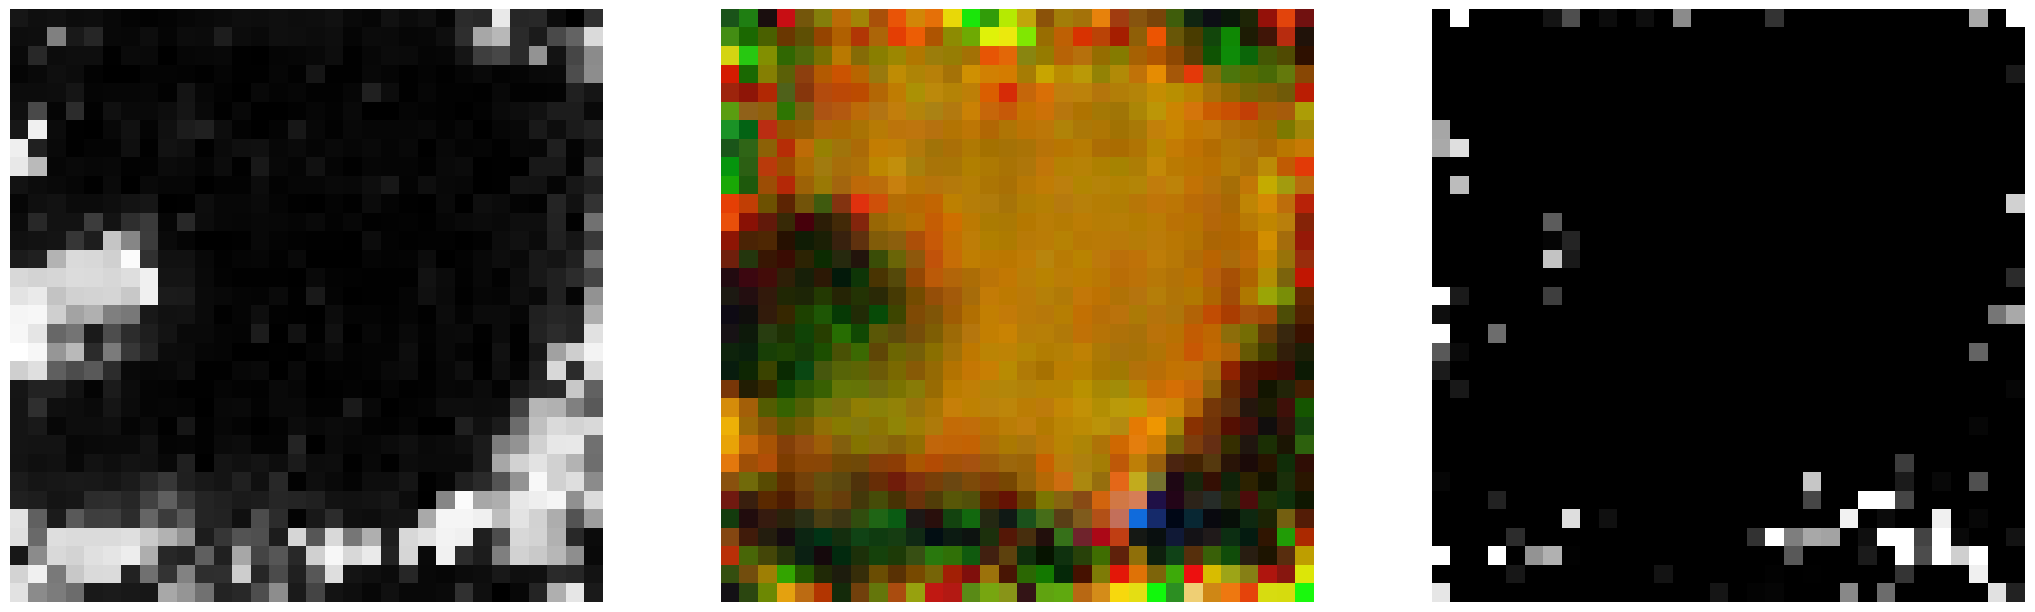

0 0.0083


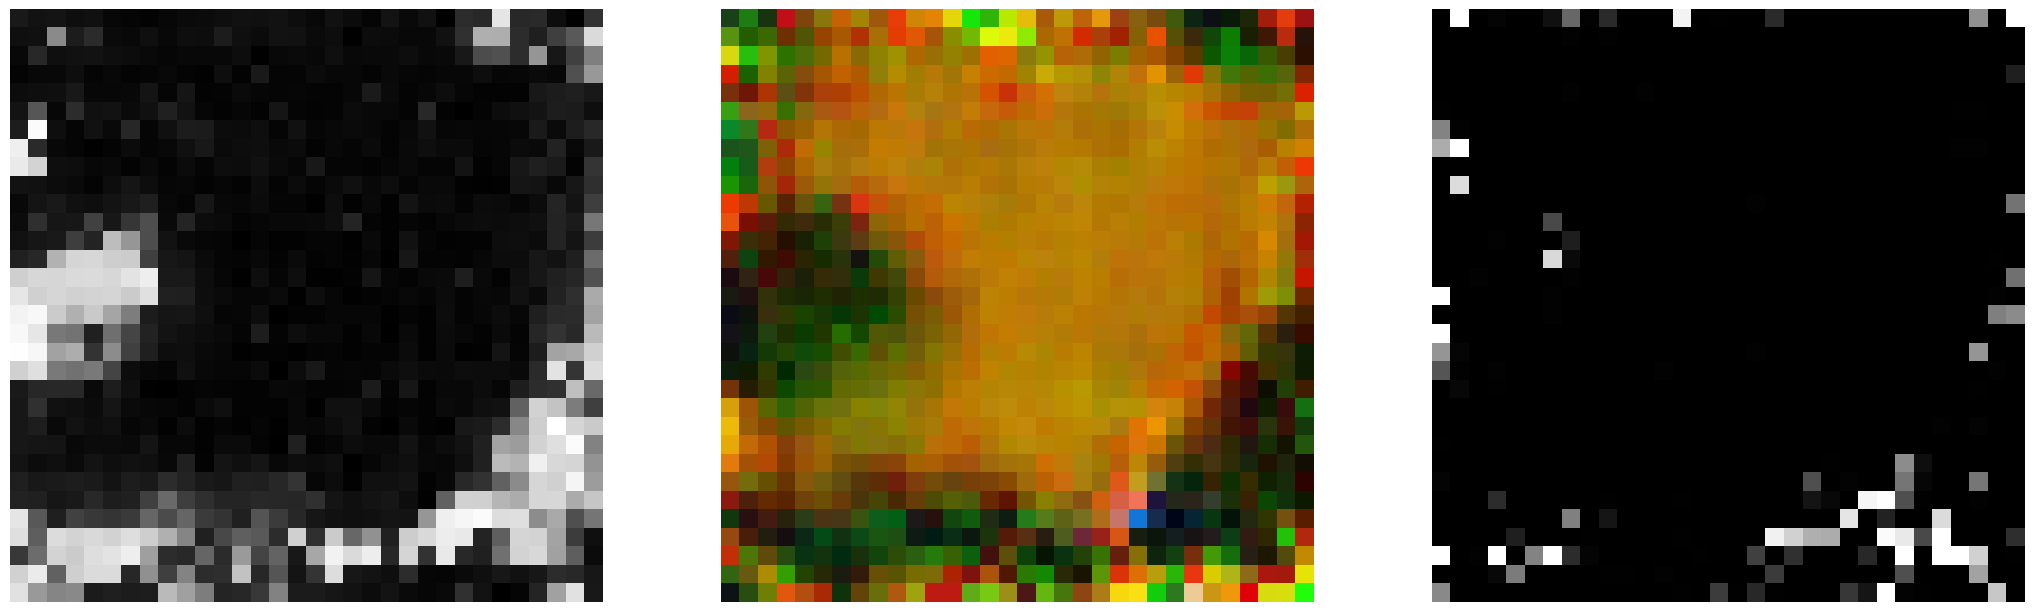

50 0.0093


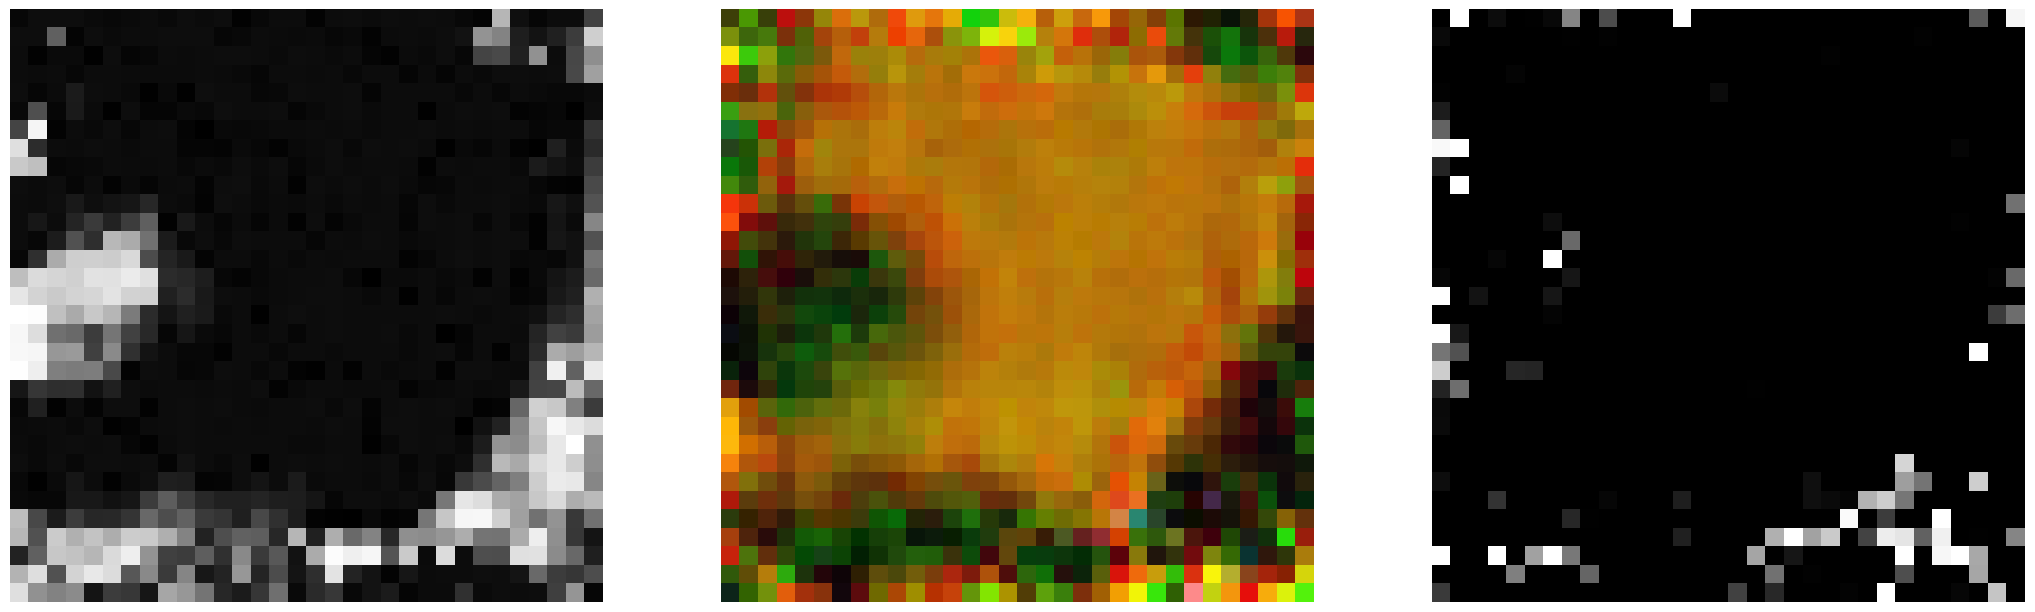

100 0.0085


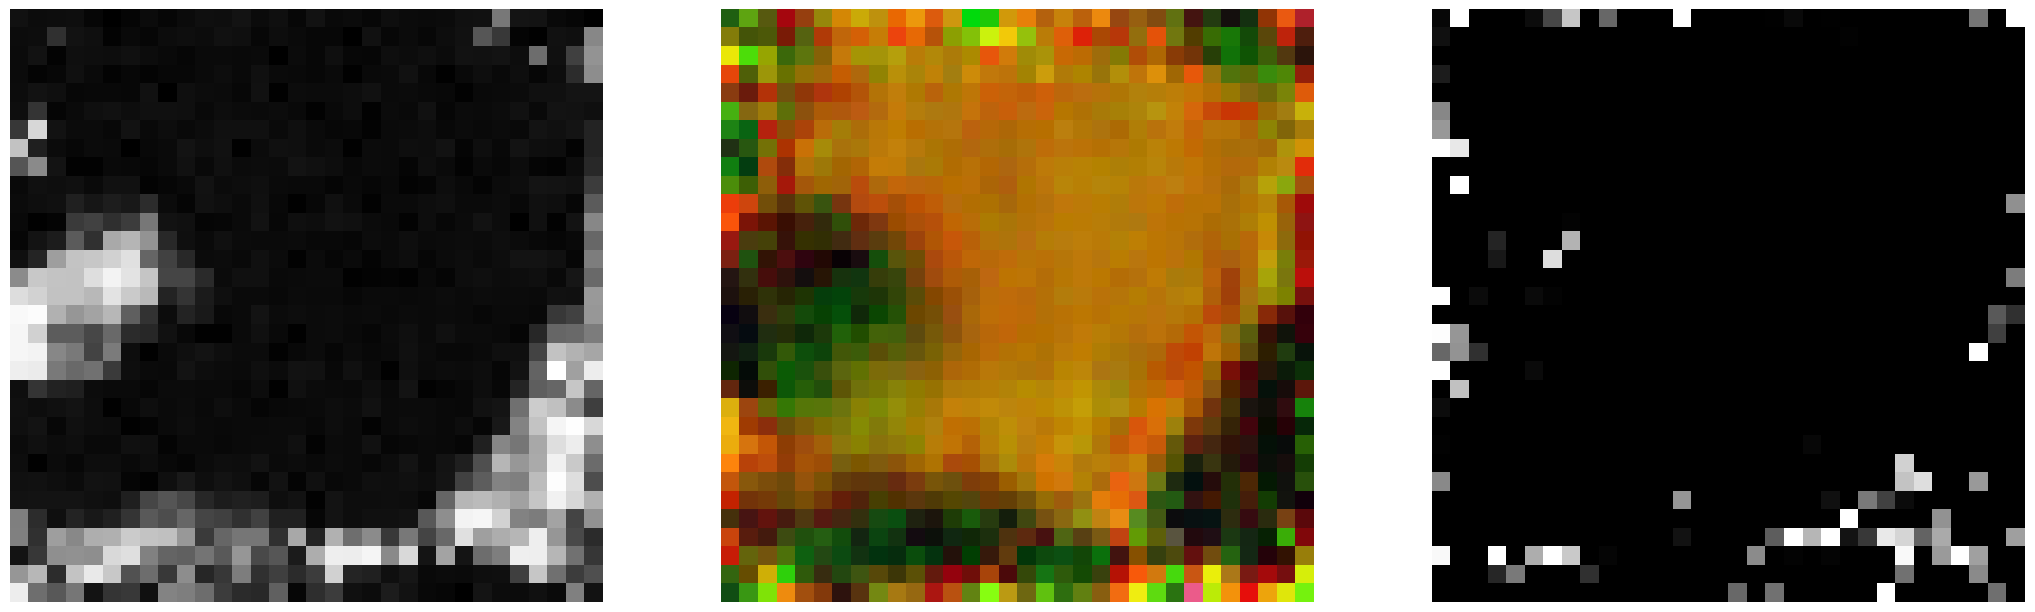

150 0.0082


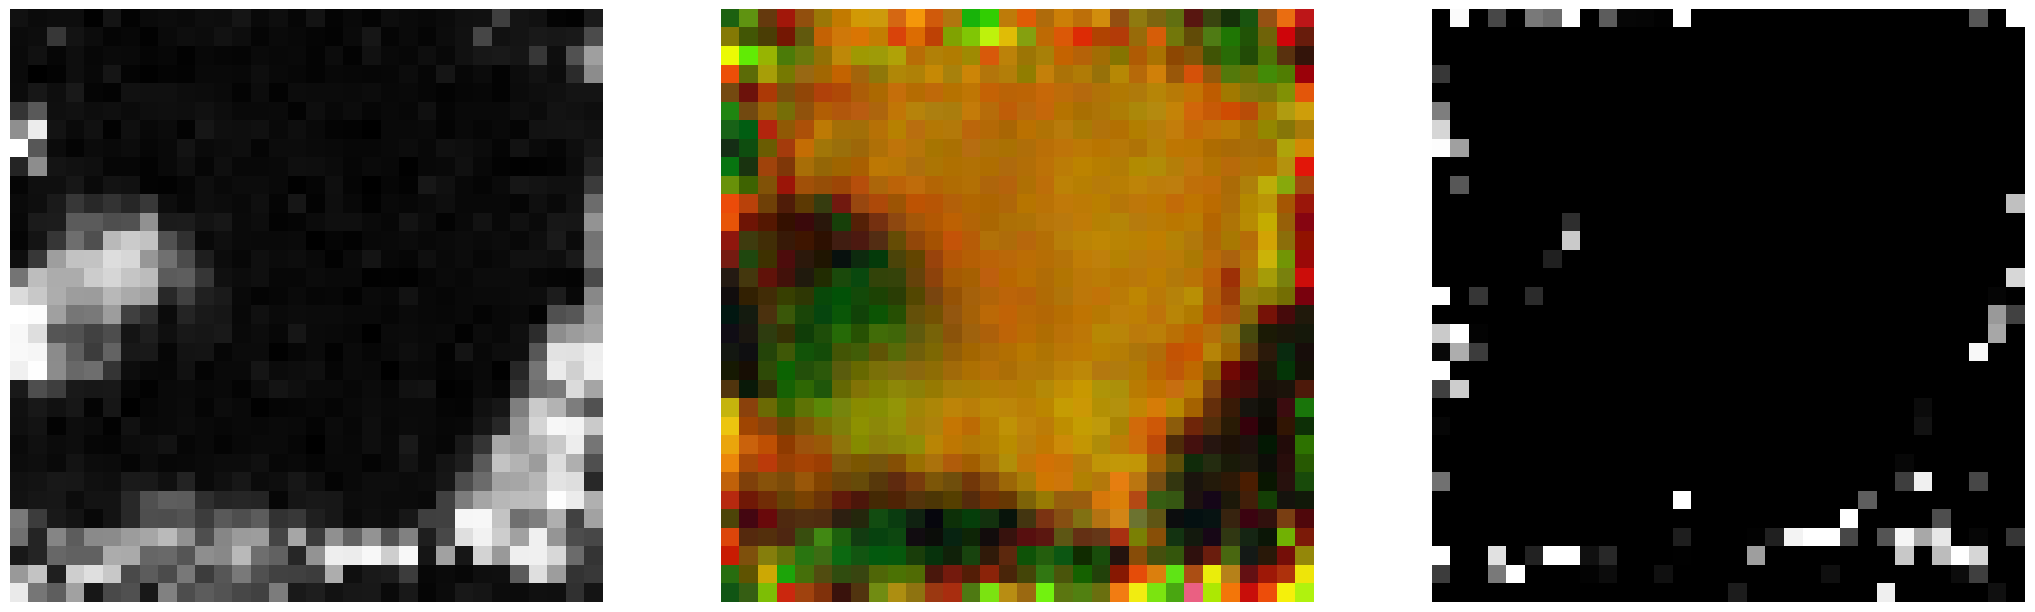

200 0.0127


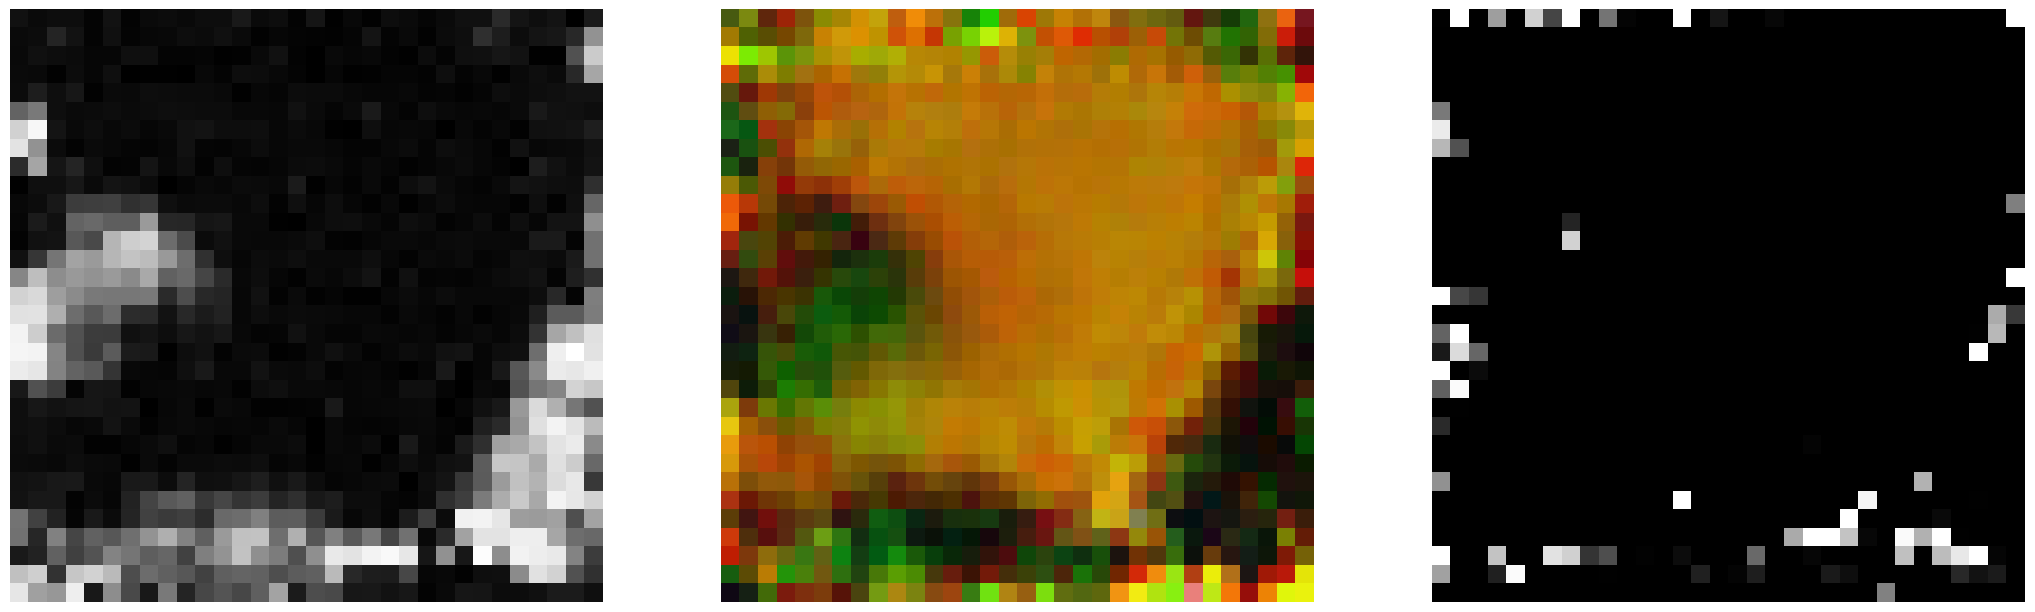

250 0.0097


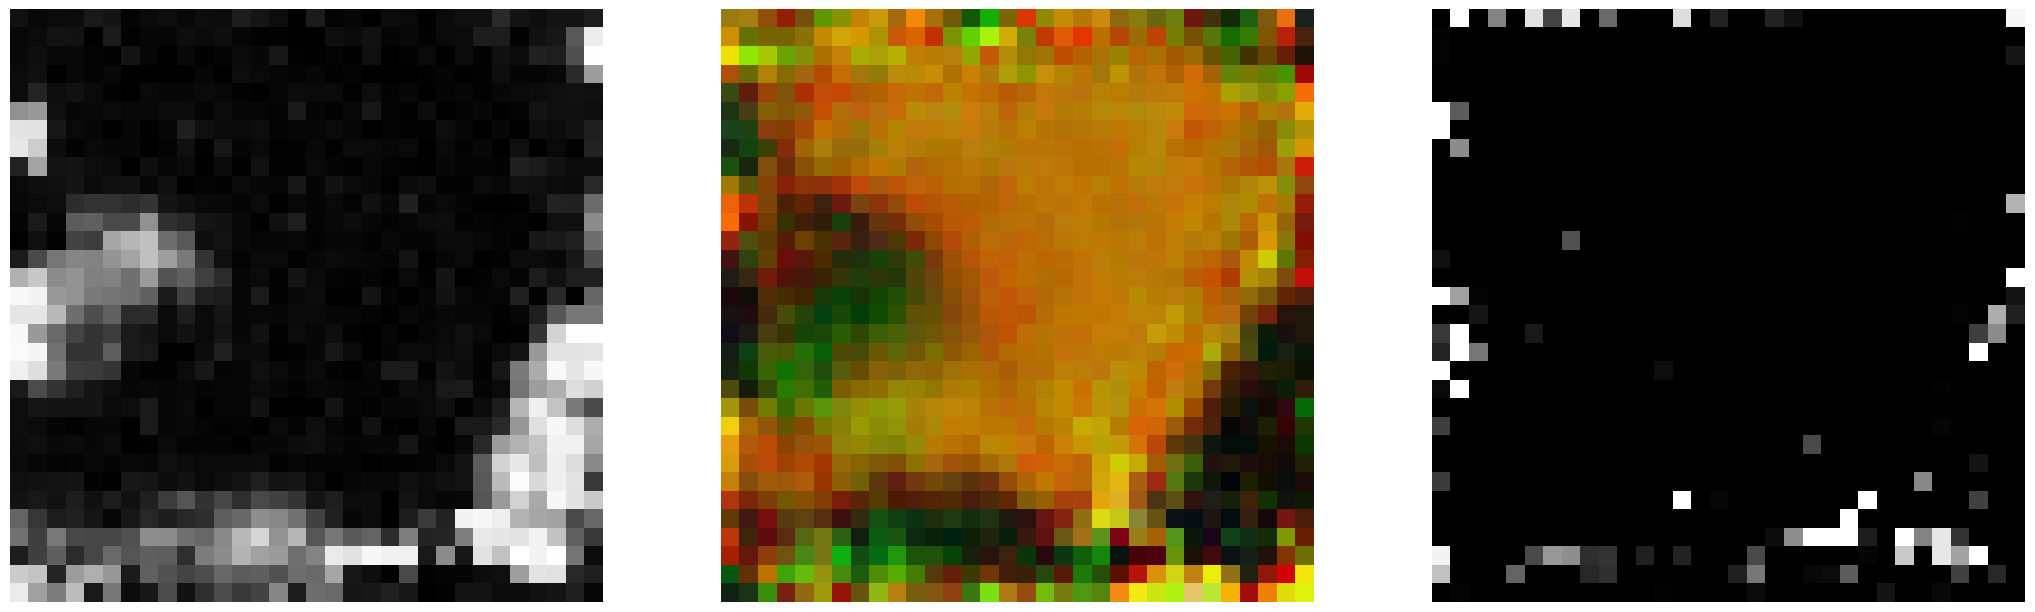

300 0.0094


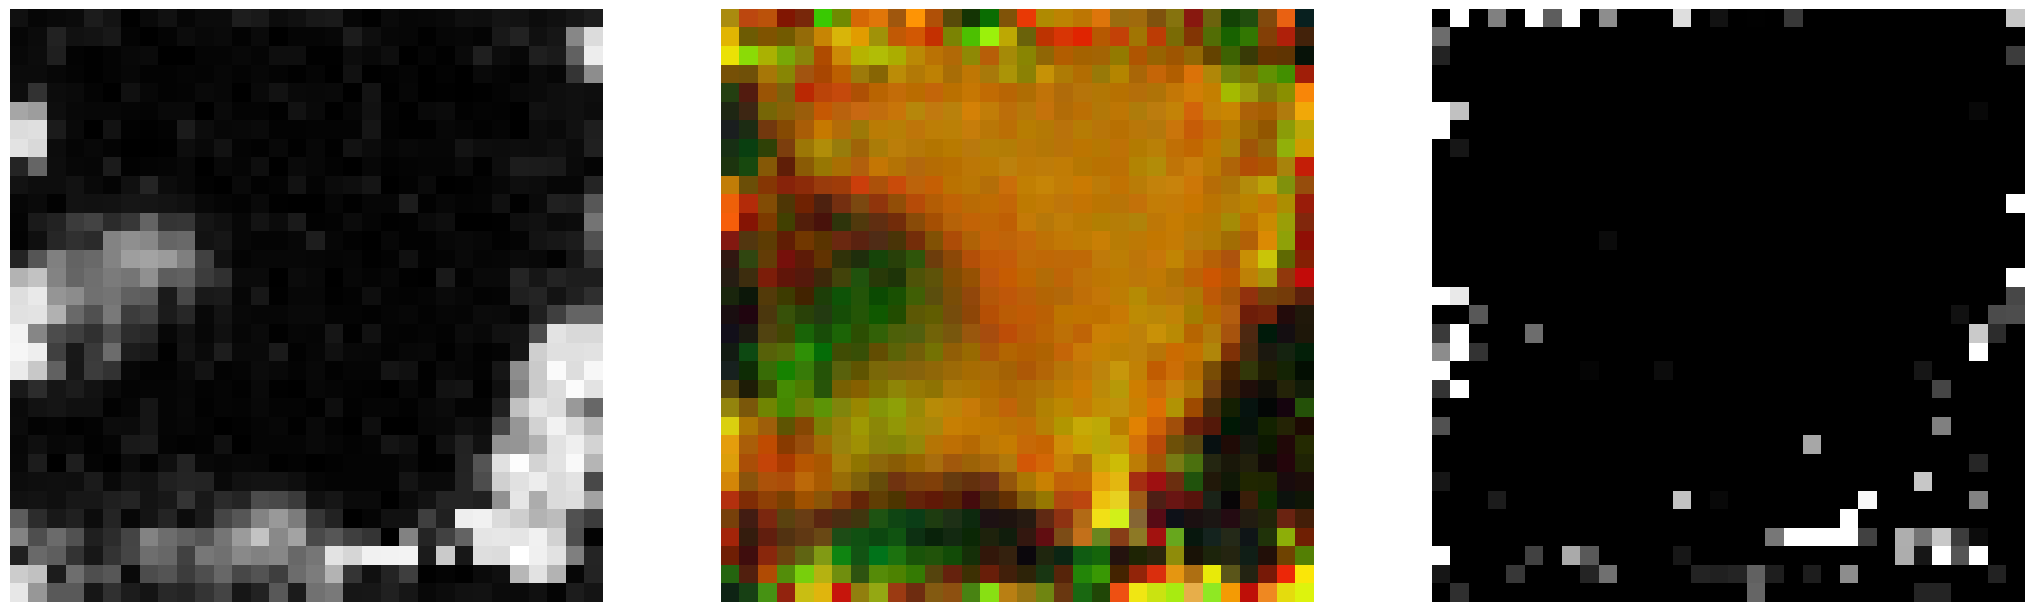

350 0.0088


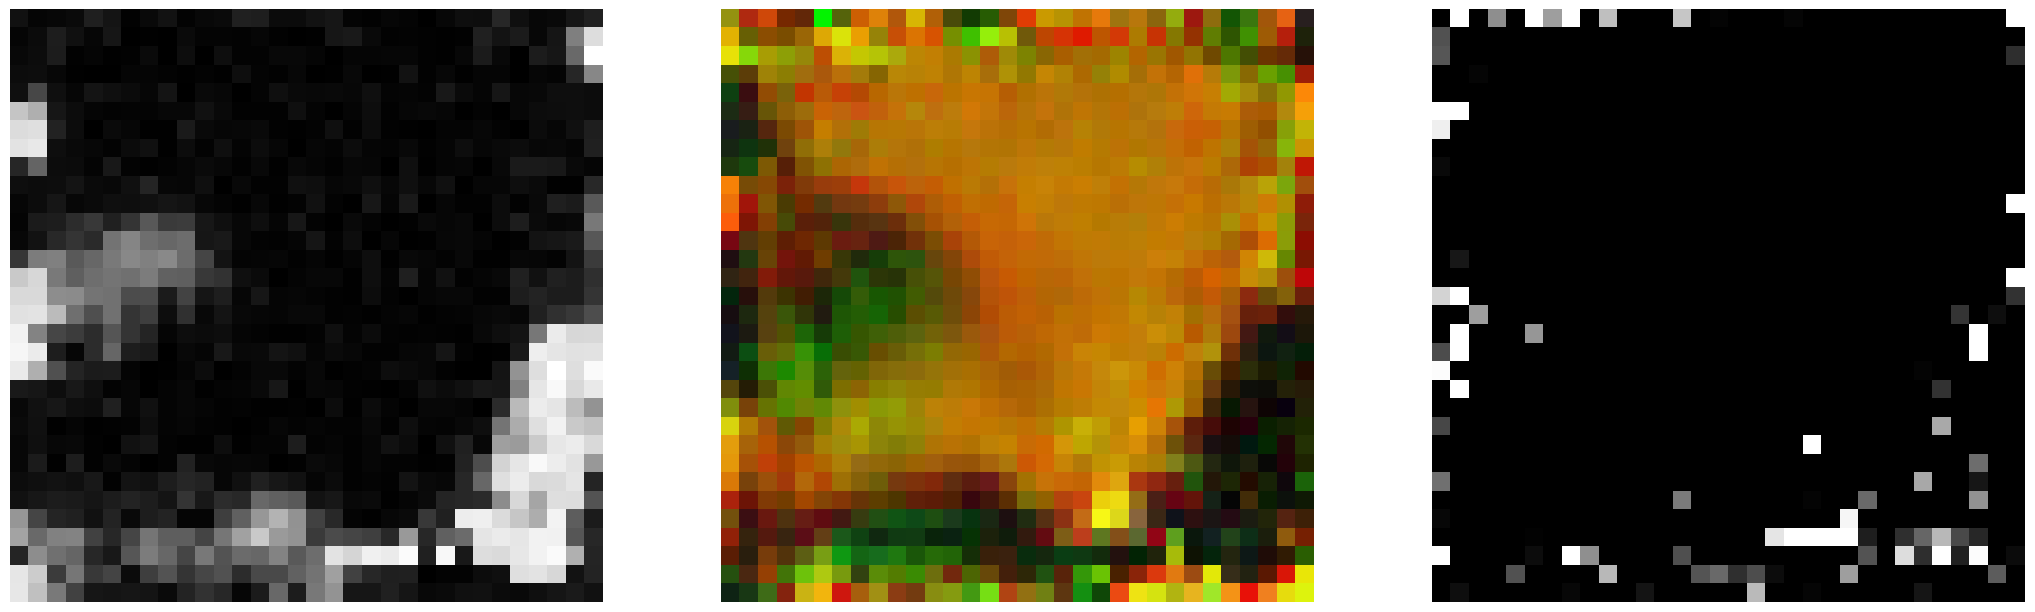

400 0.0099


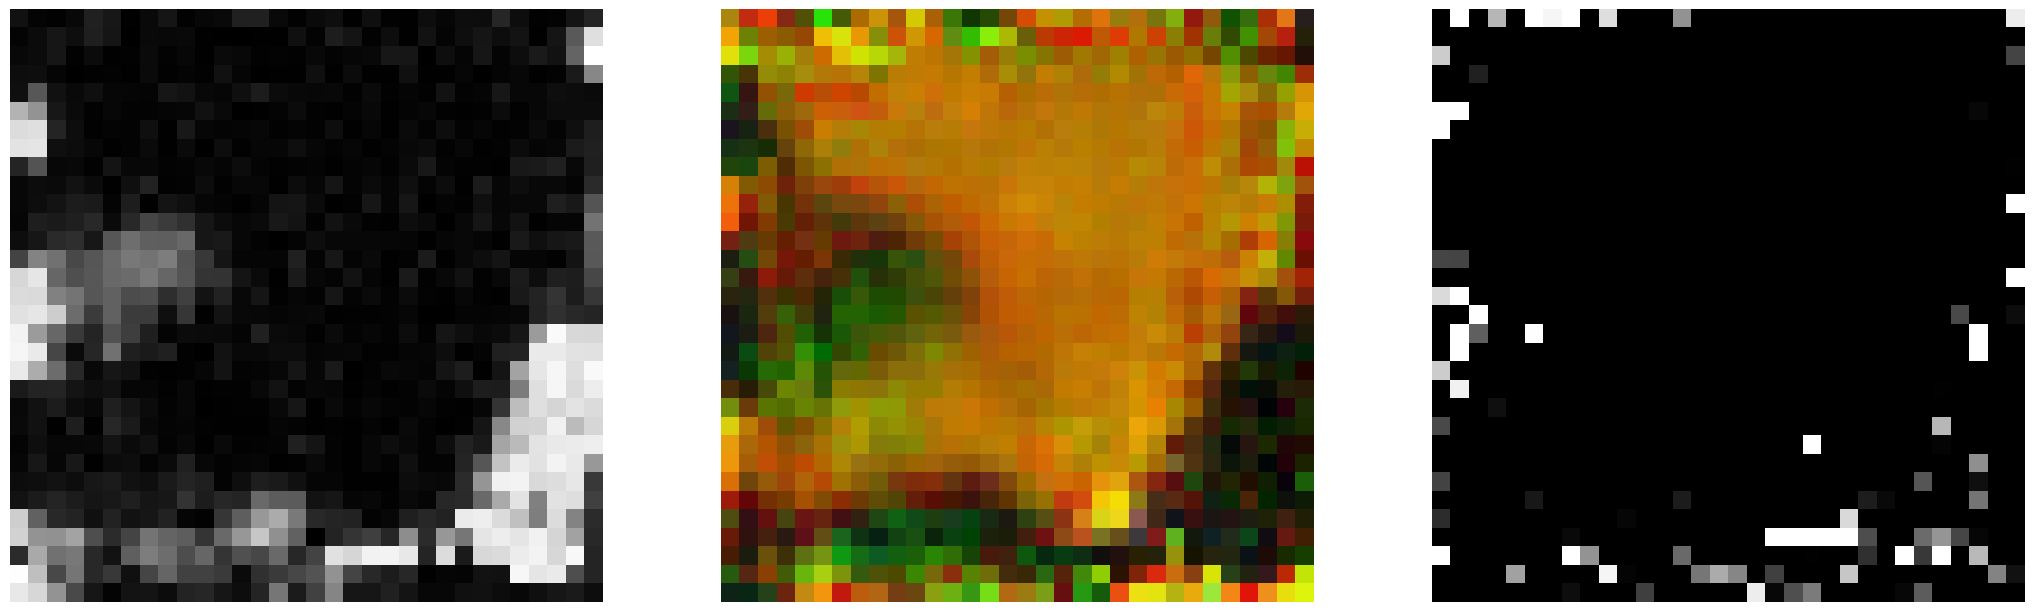

450 0.0093


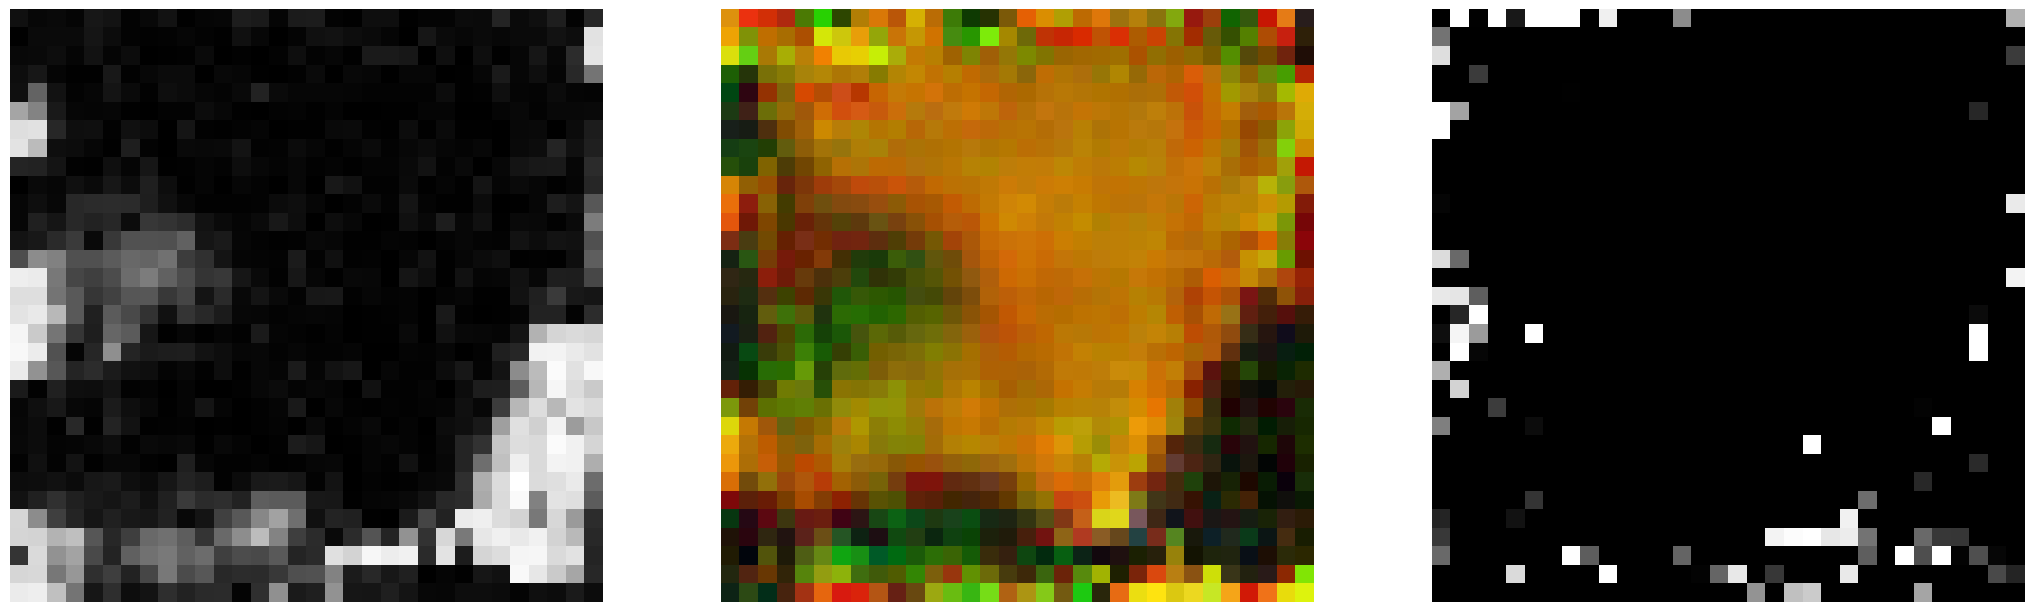

0 0.0090


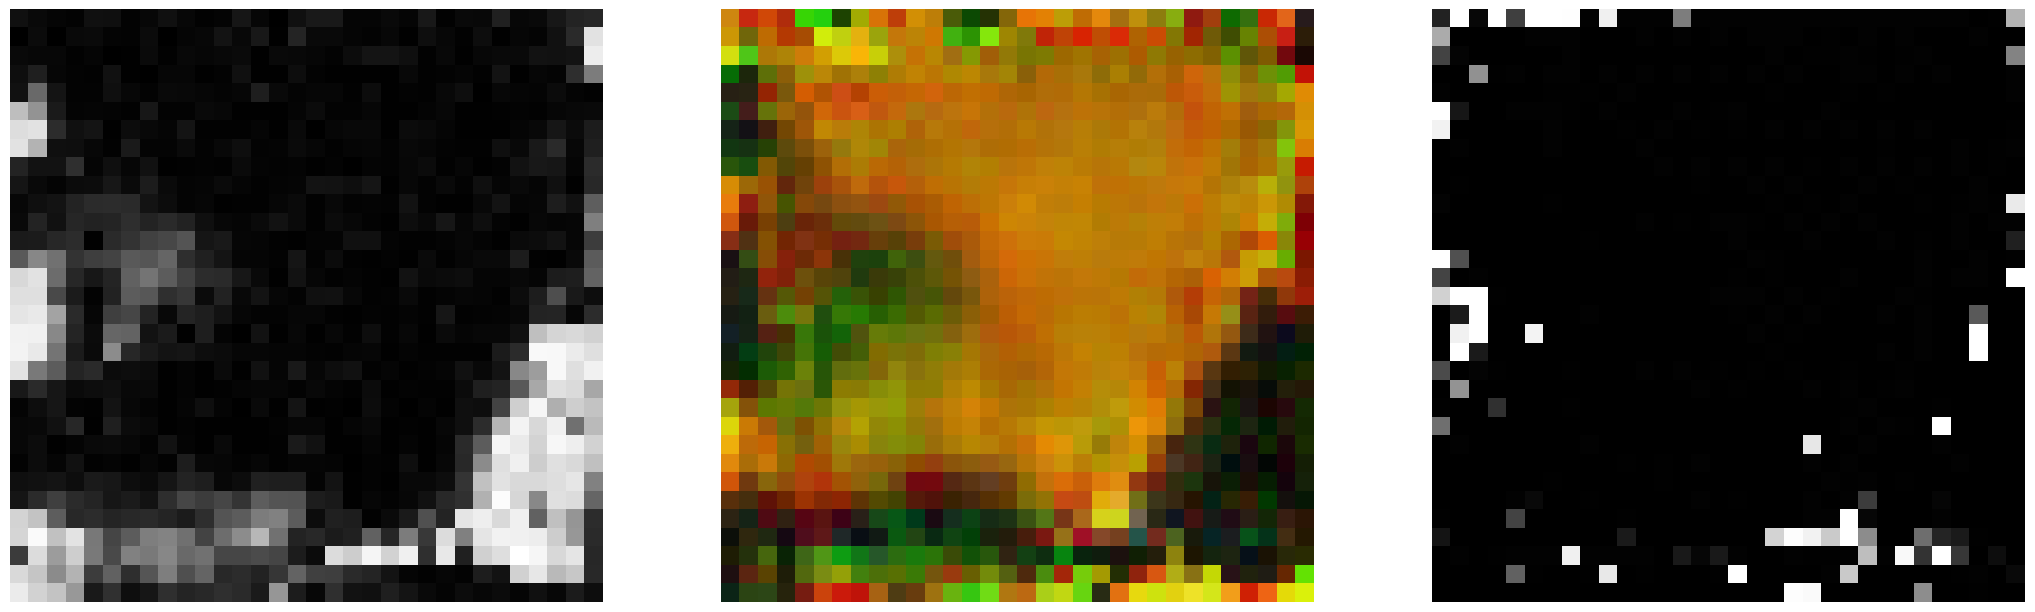

50 0.0085


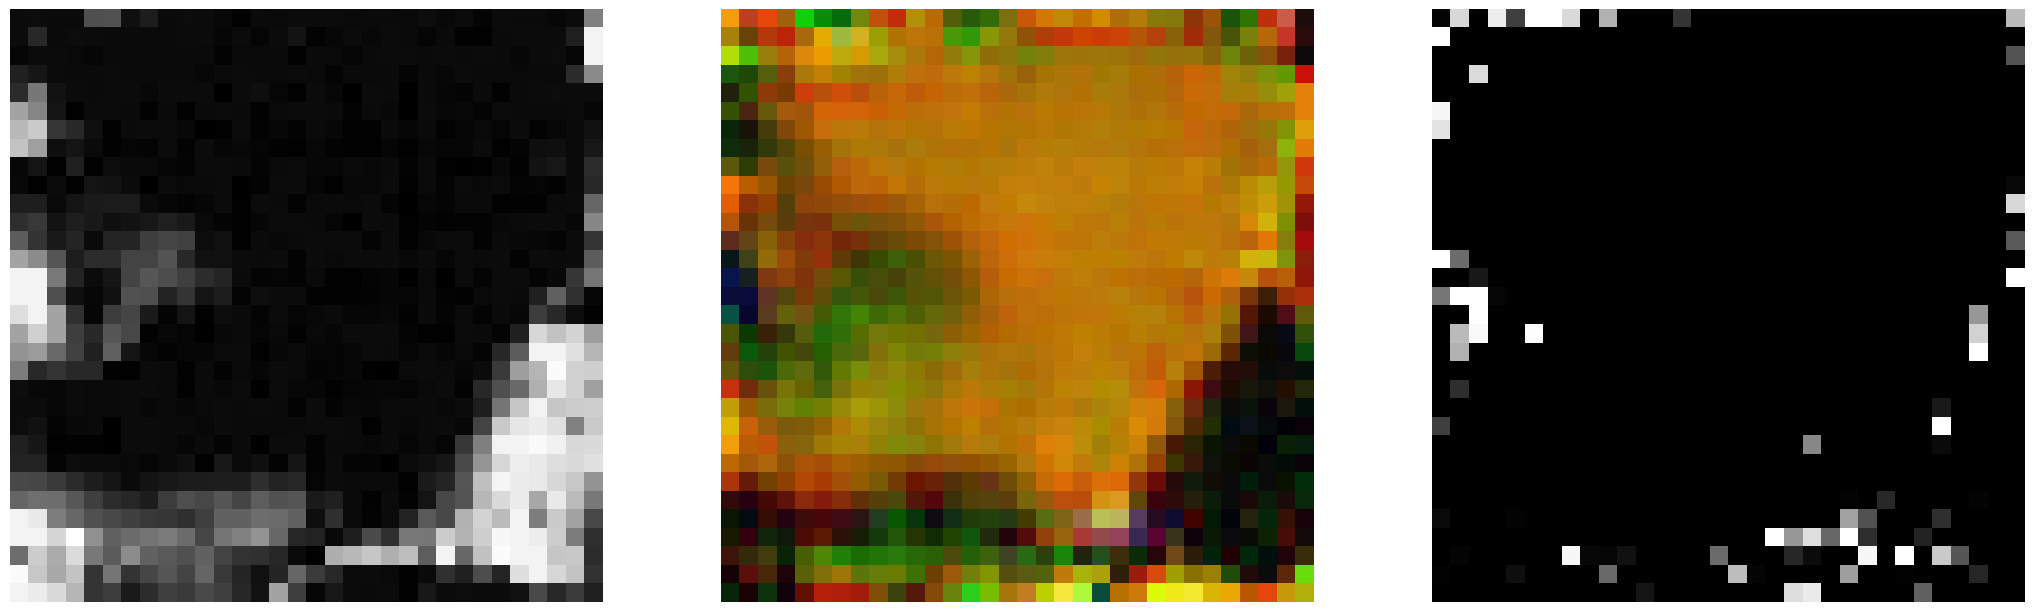

100 0.0083


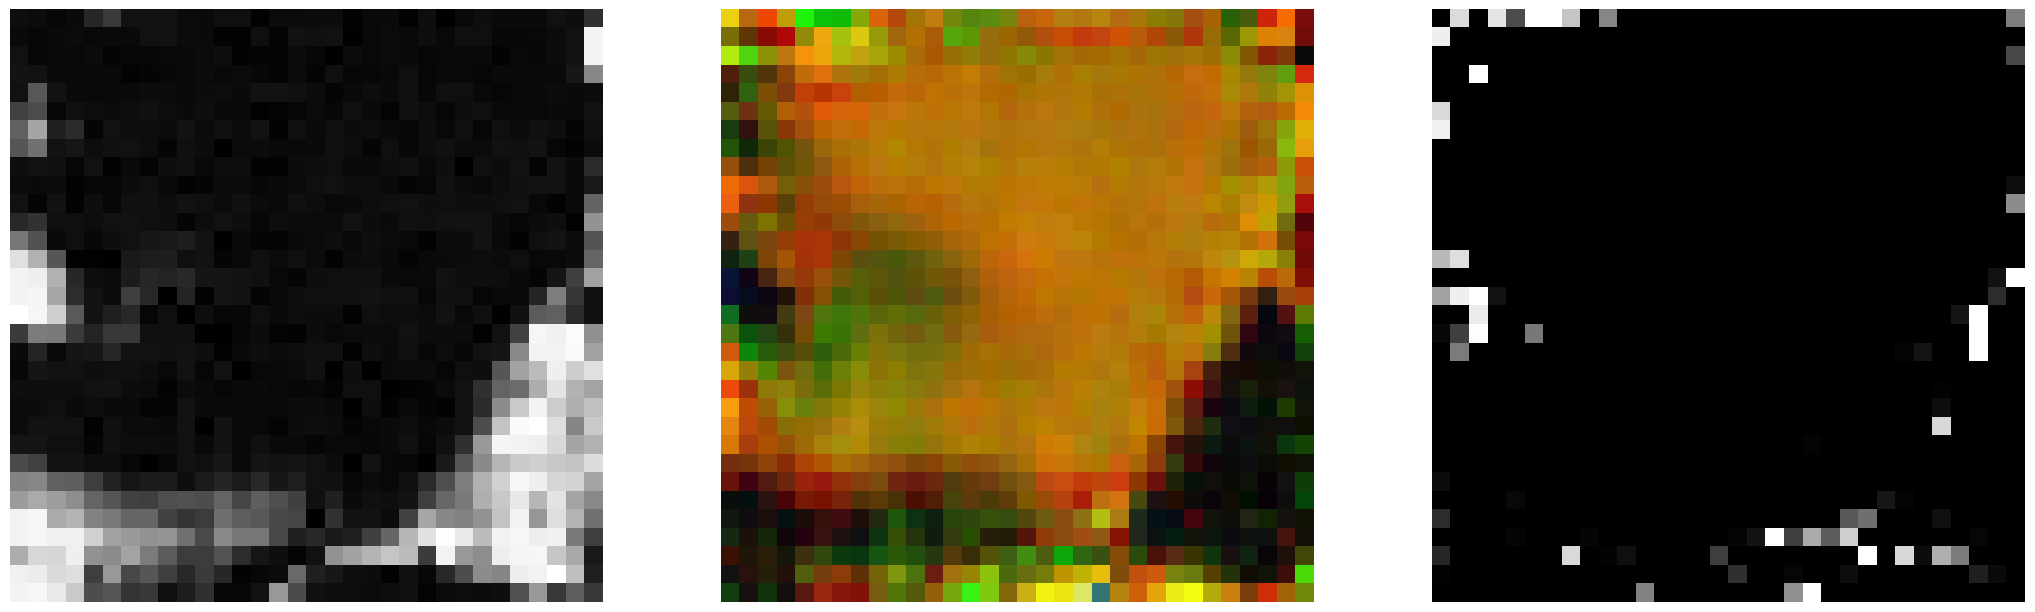

150 0.0081


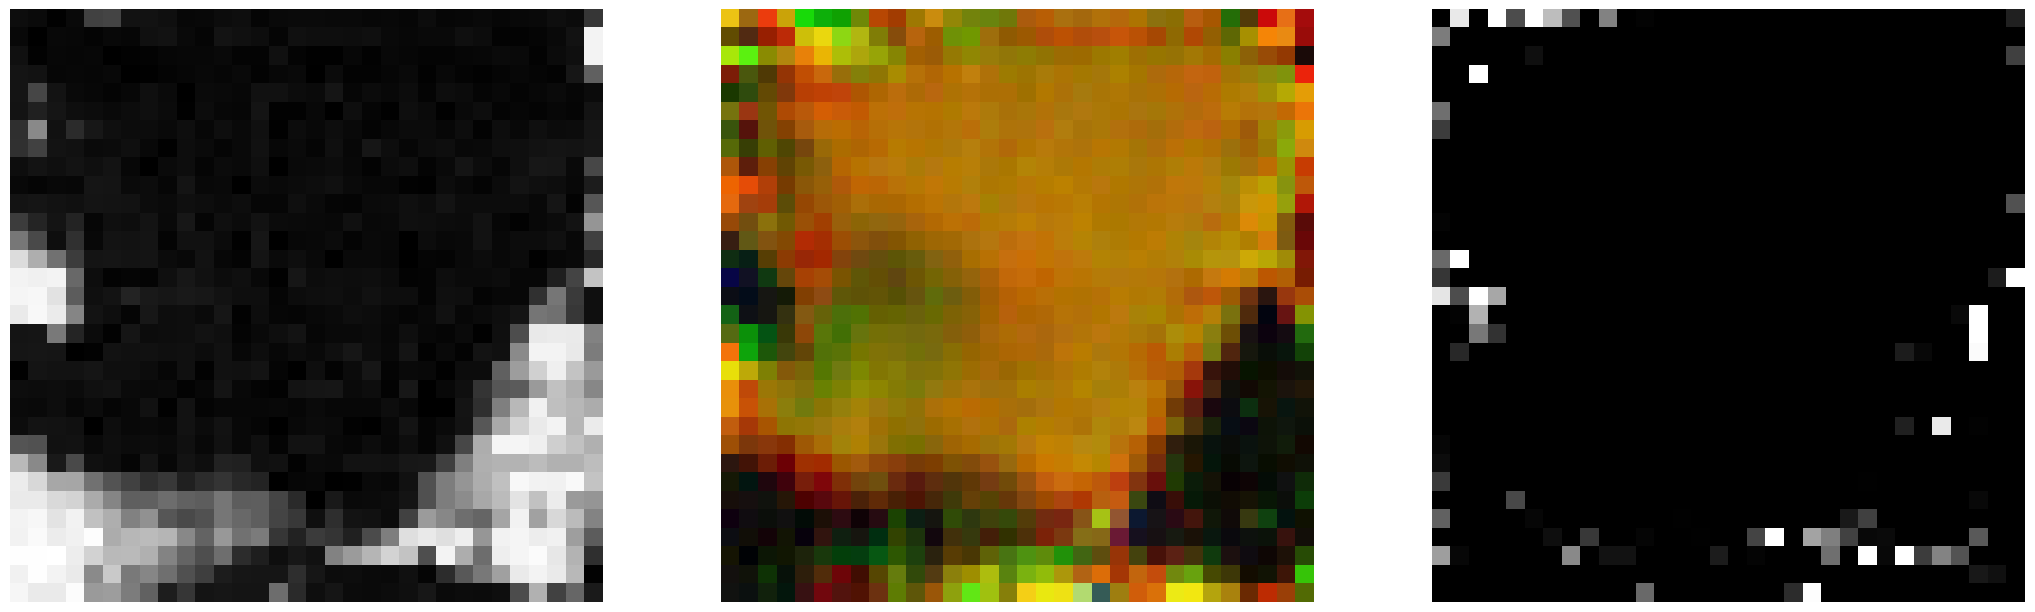

200 0.0078


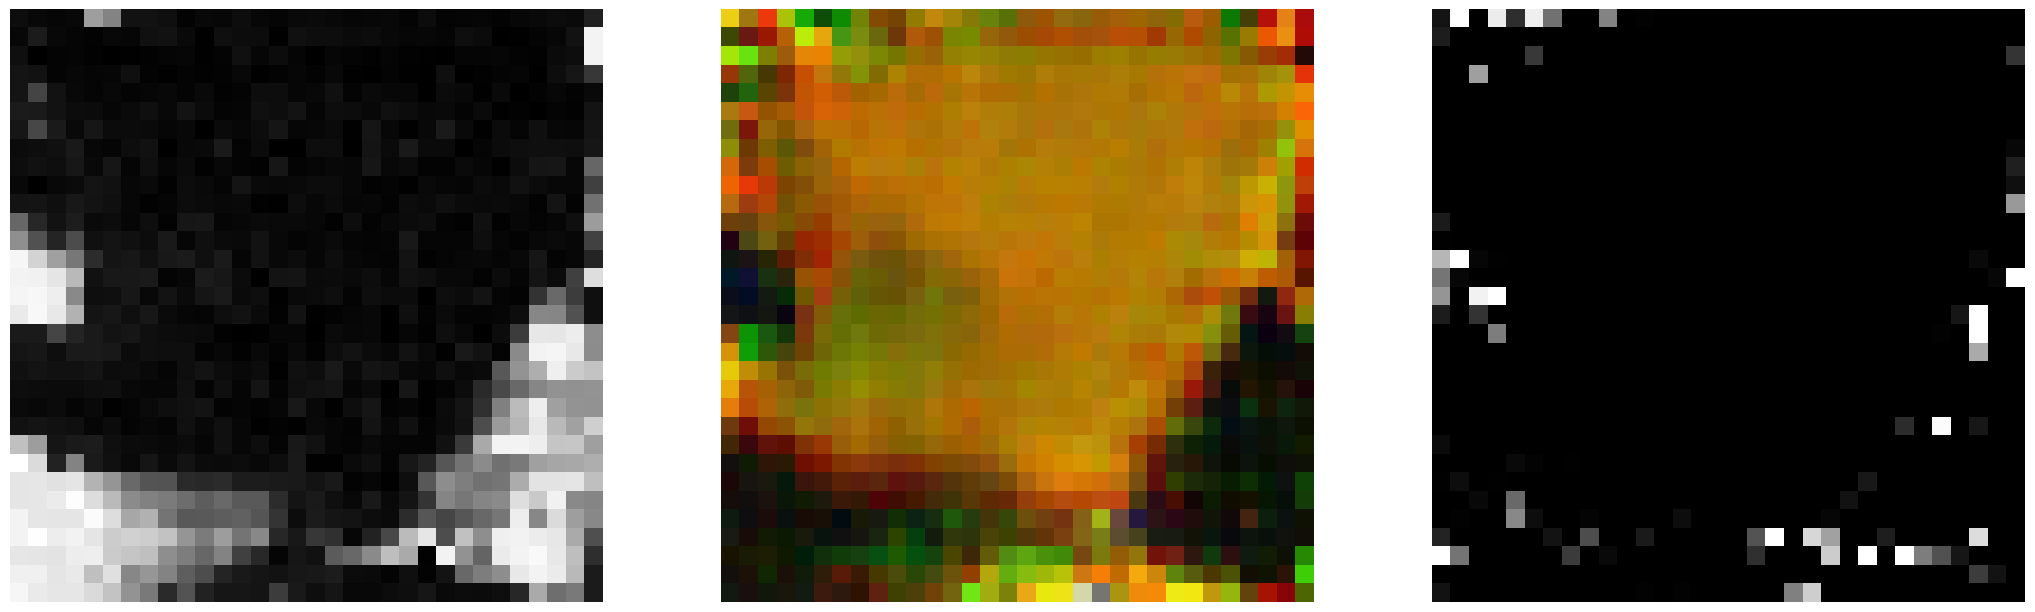

250 0.0079


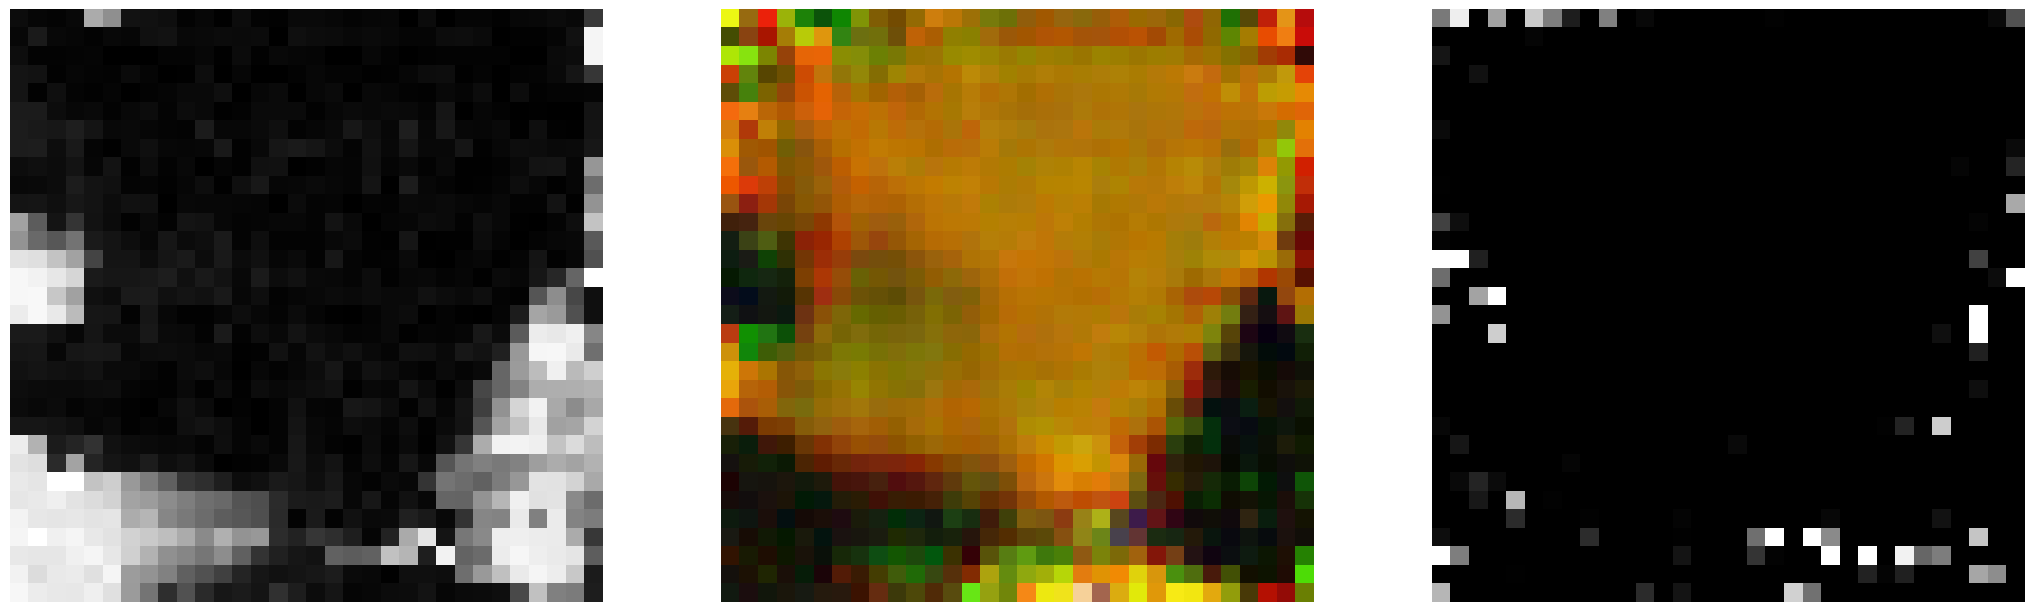

300 0.0079


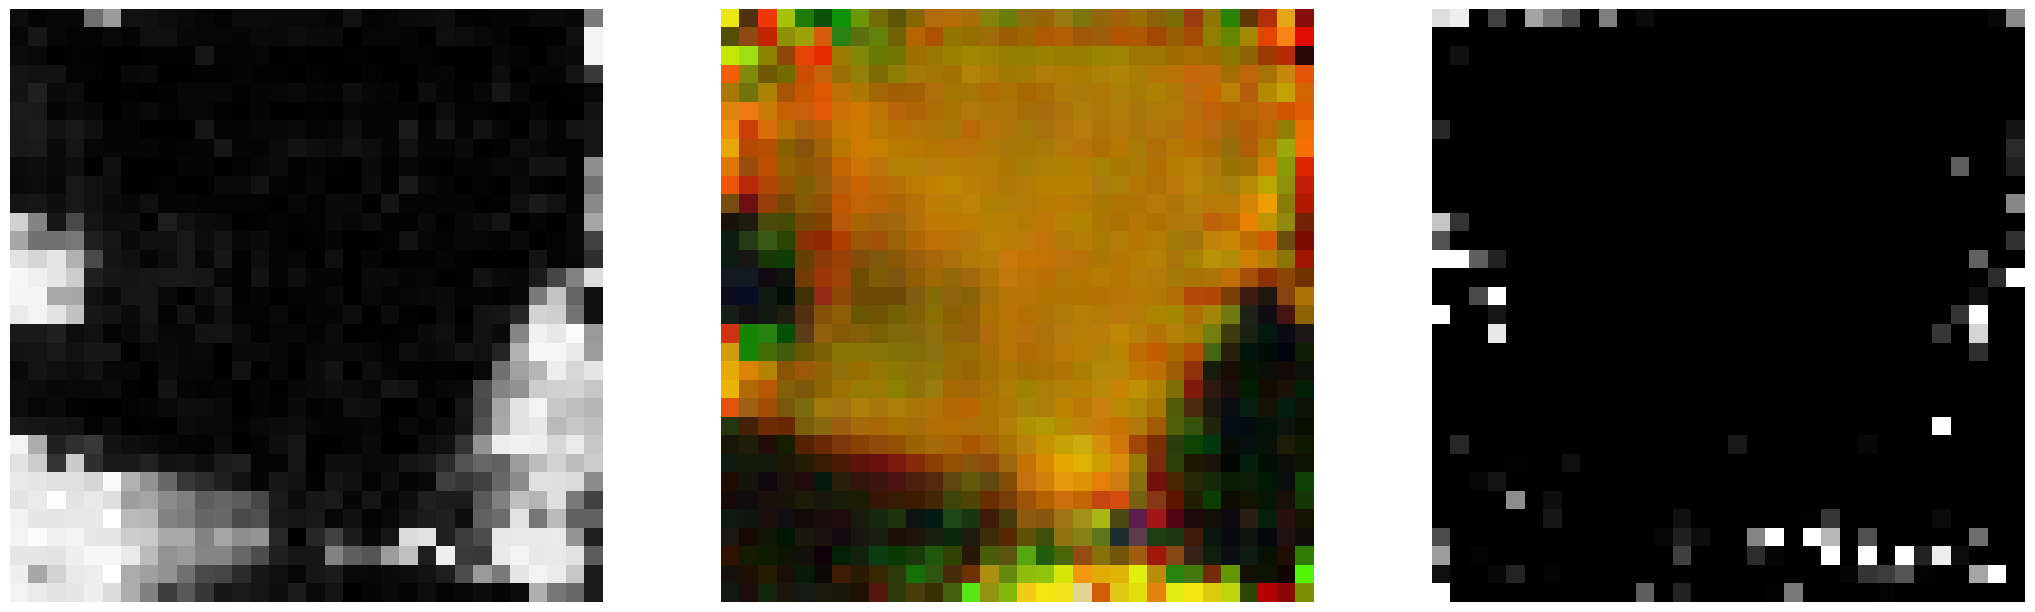

350 0.0086


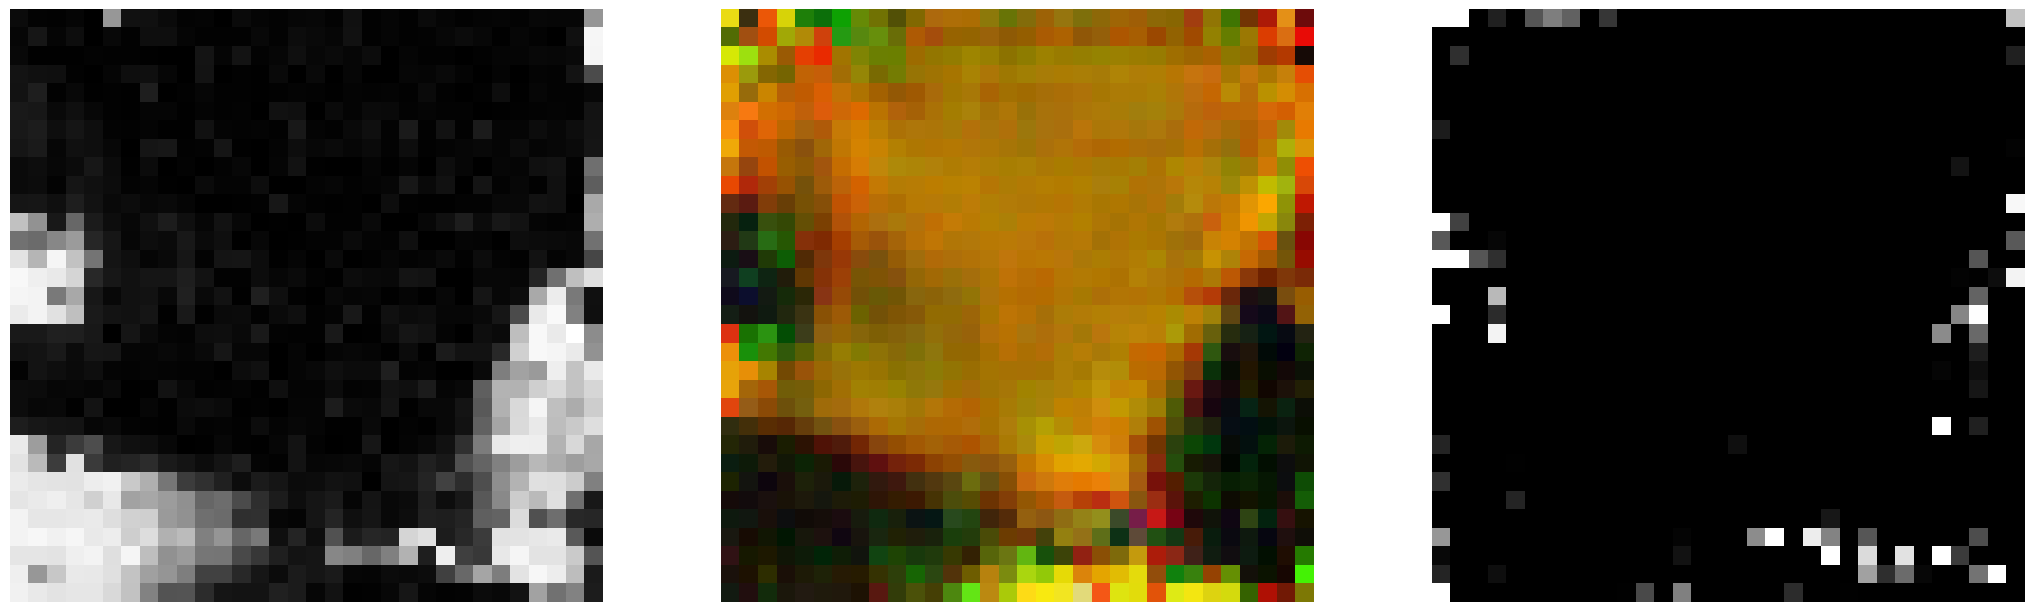

400 0.0074


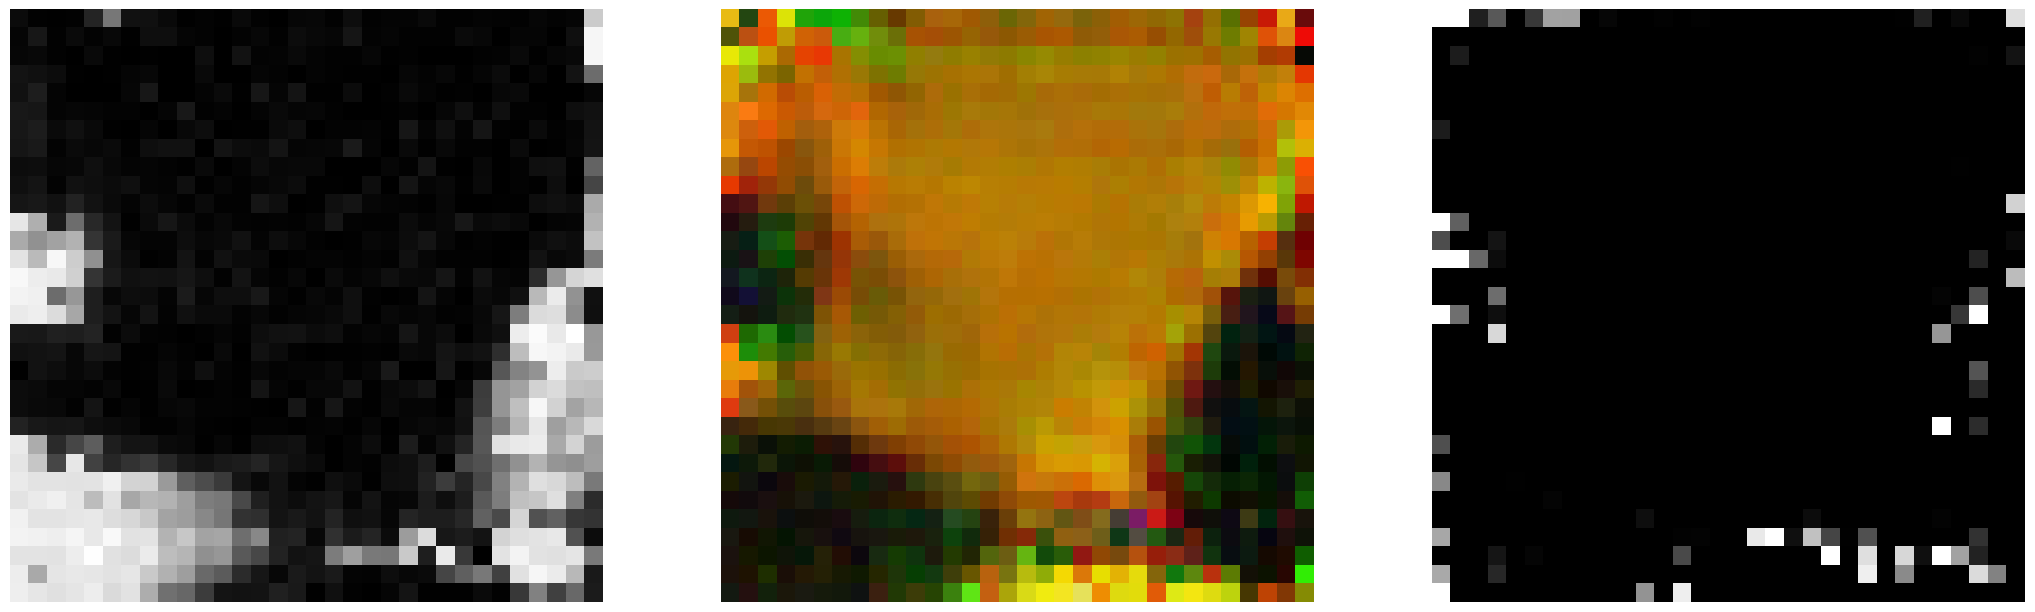

450 0.0082


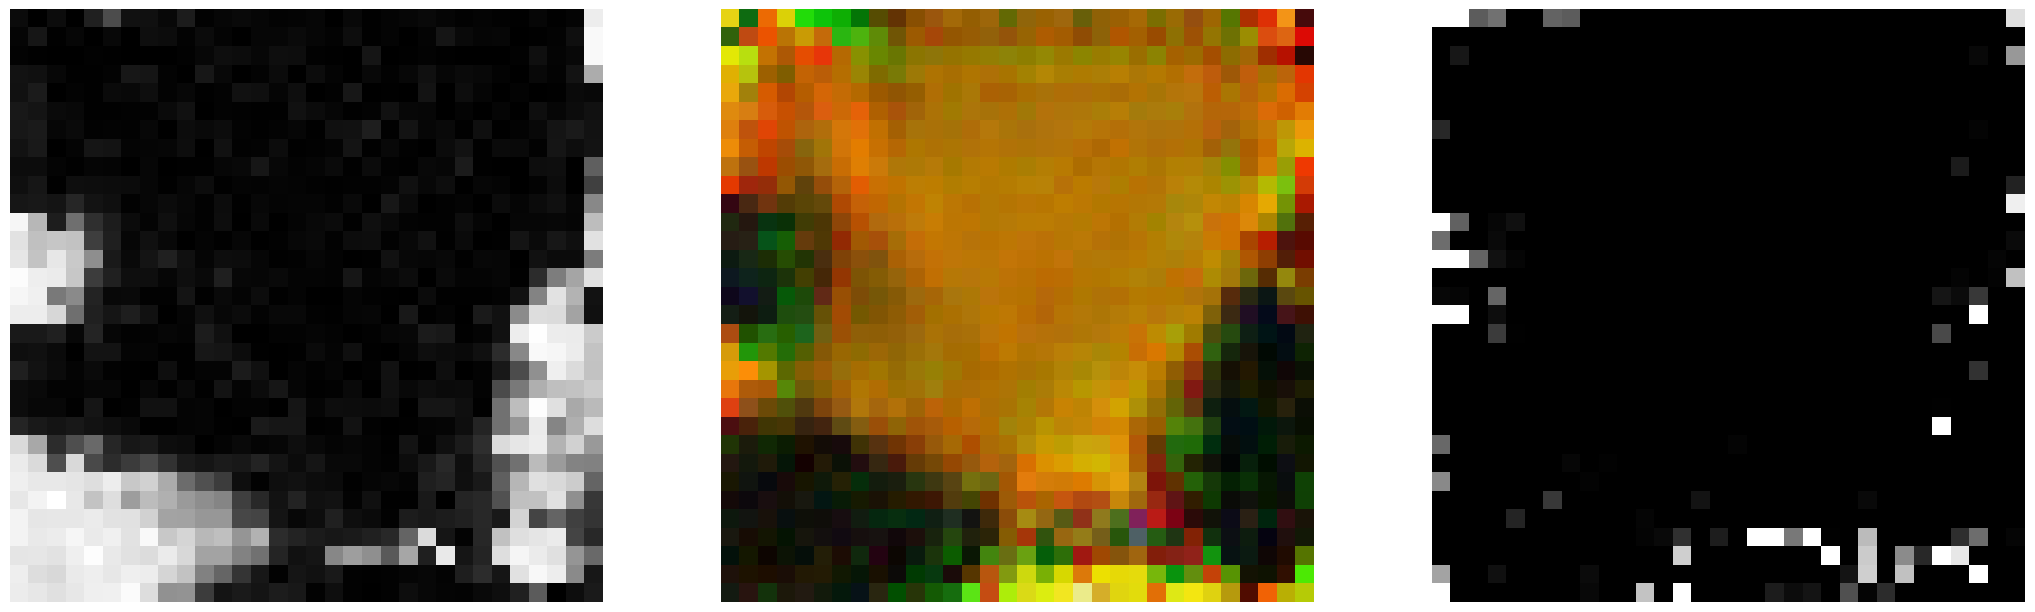

0 0.0088


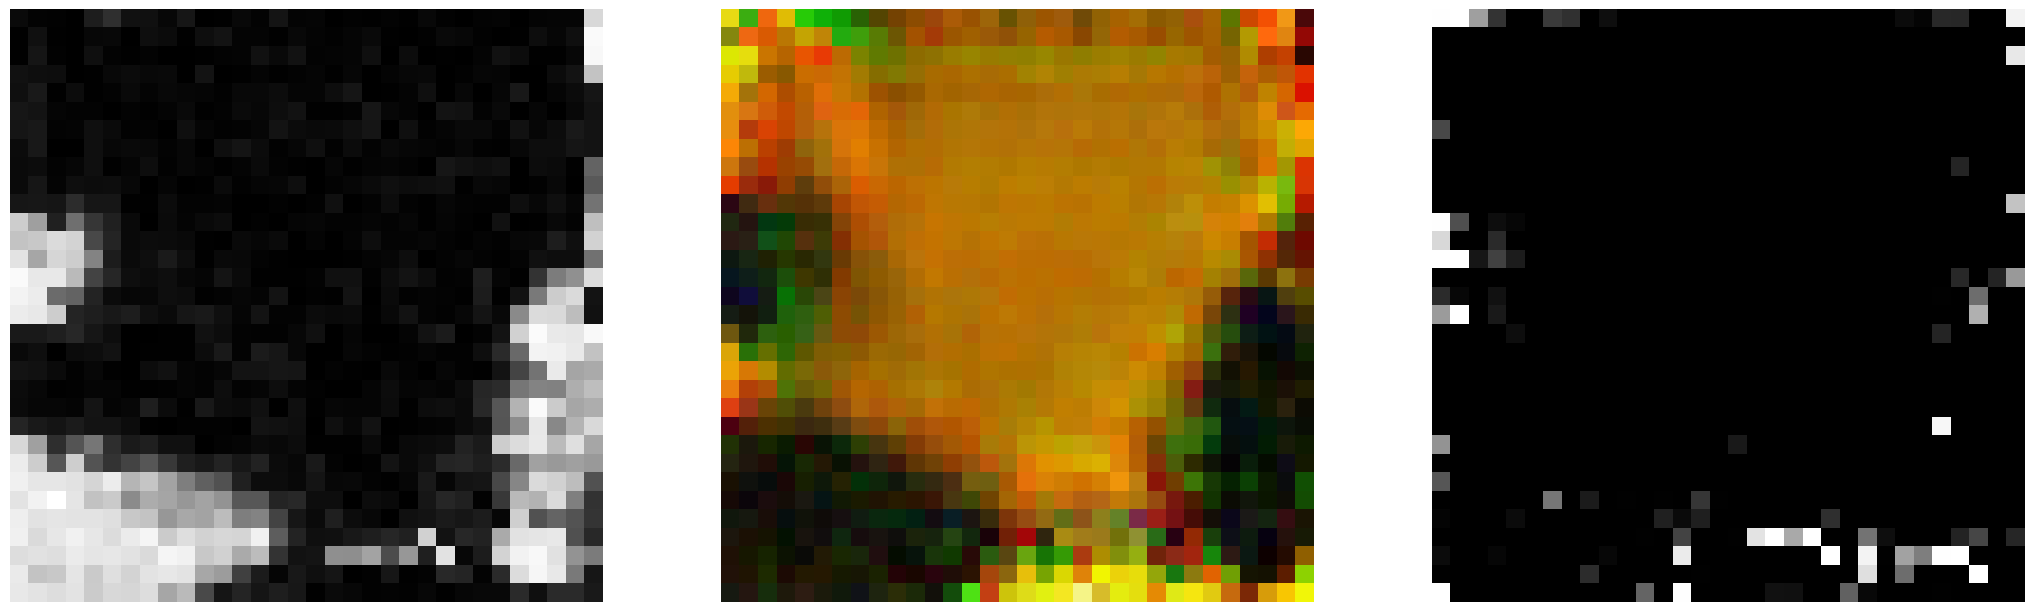

50 0.0089


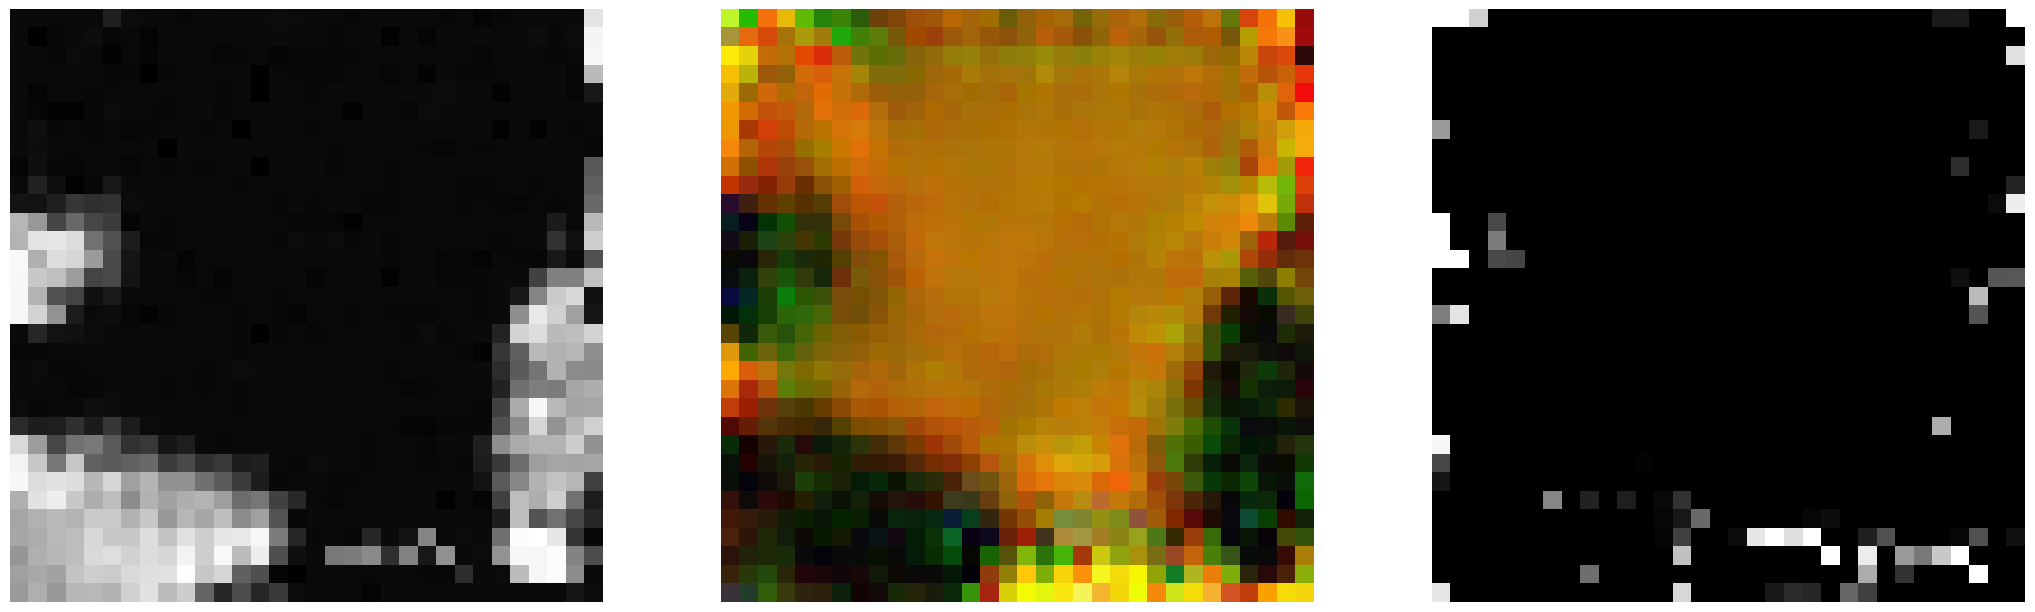

100 0.0103


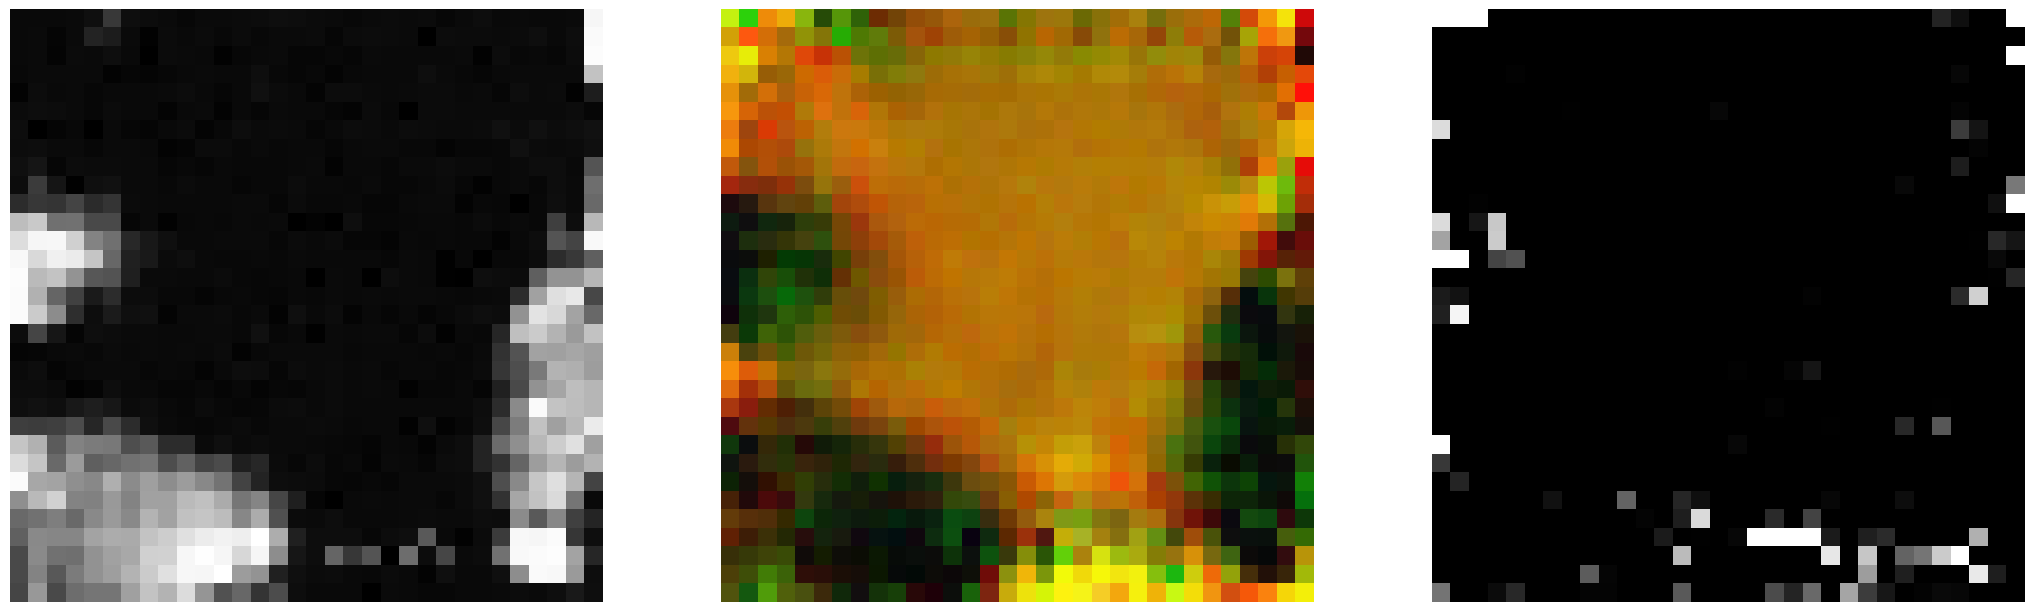

150 0.0080


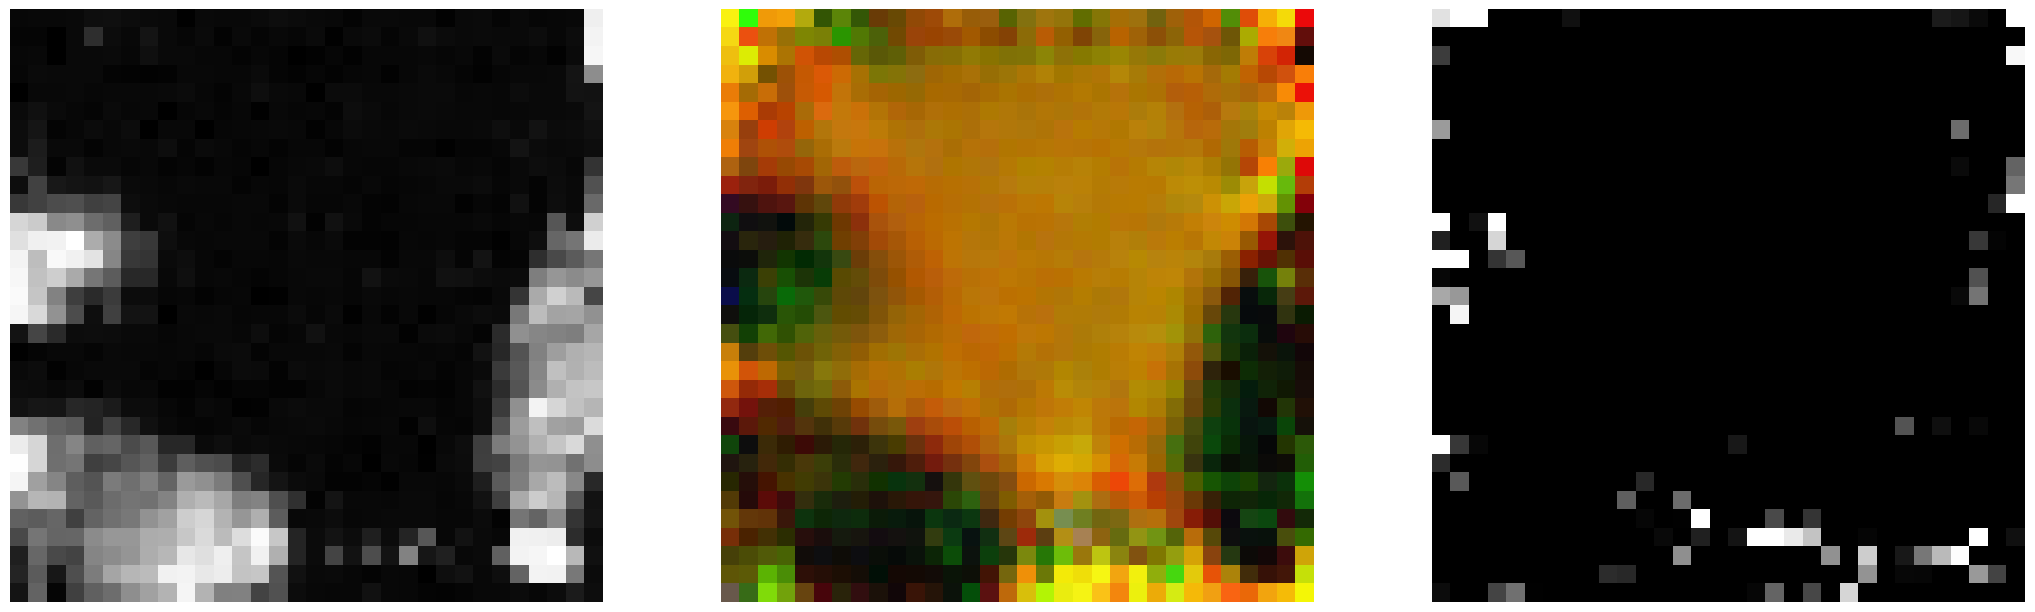

200 0.0087


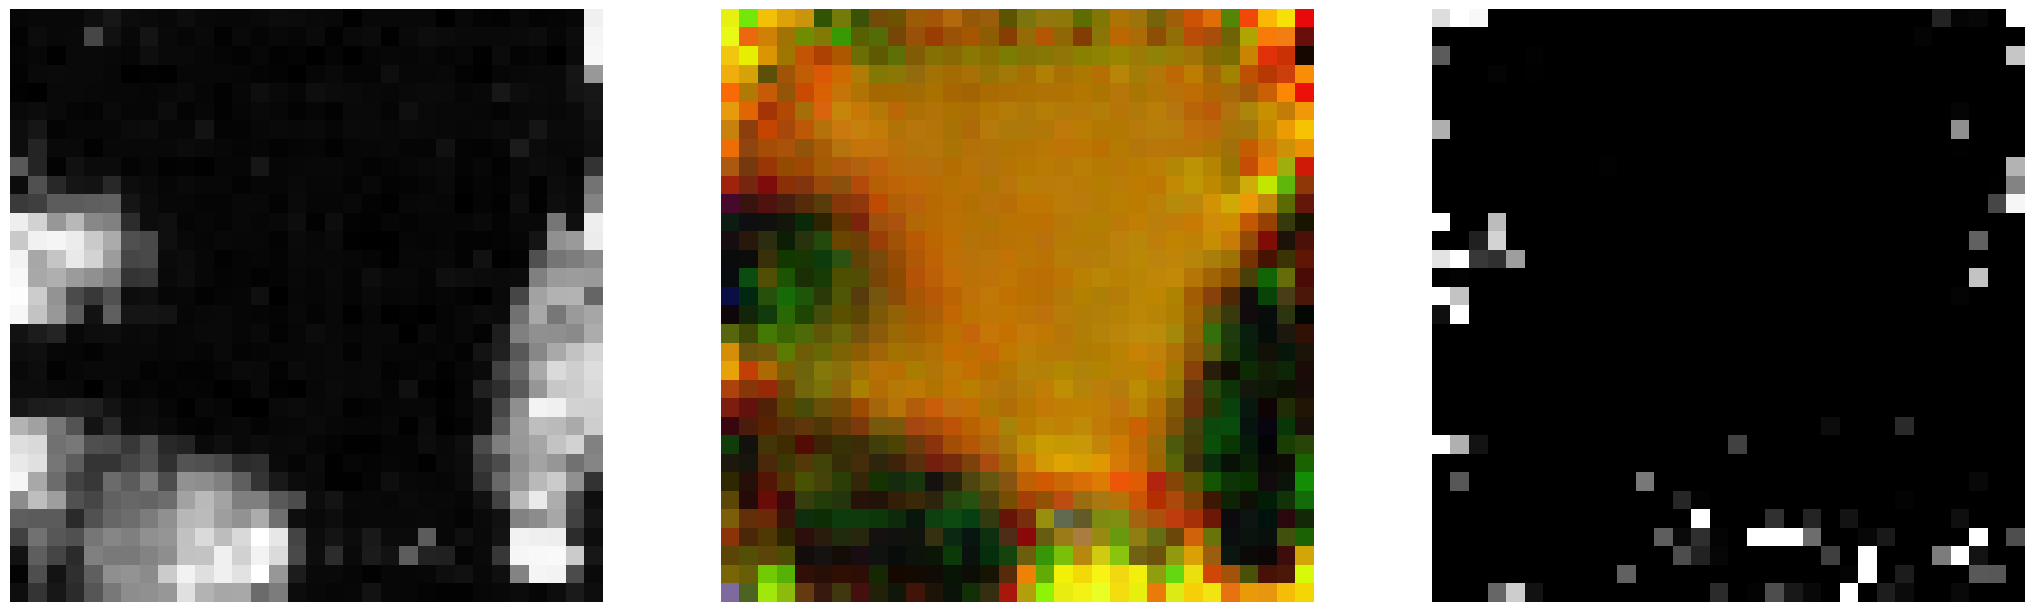

250 0.0098


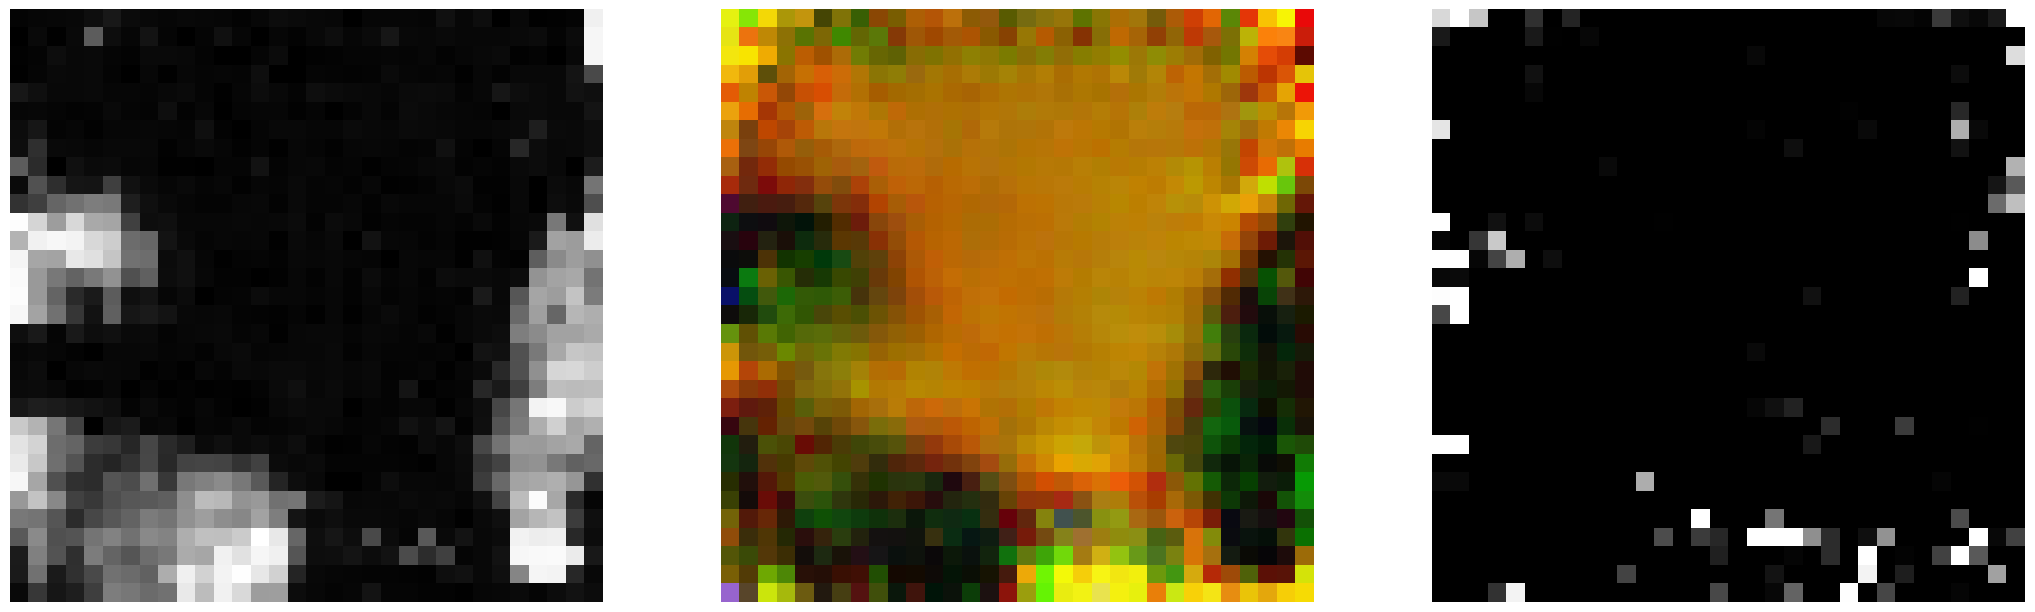

300 0.0093


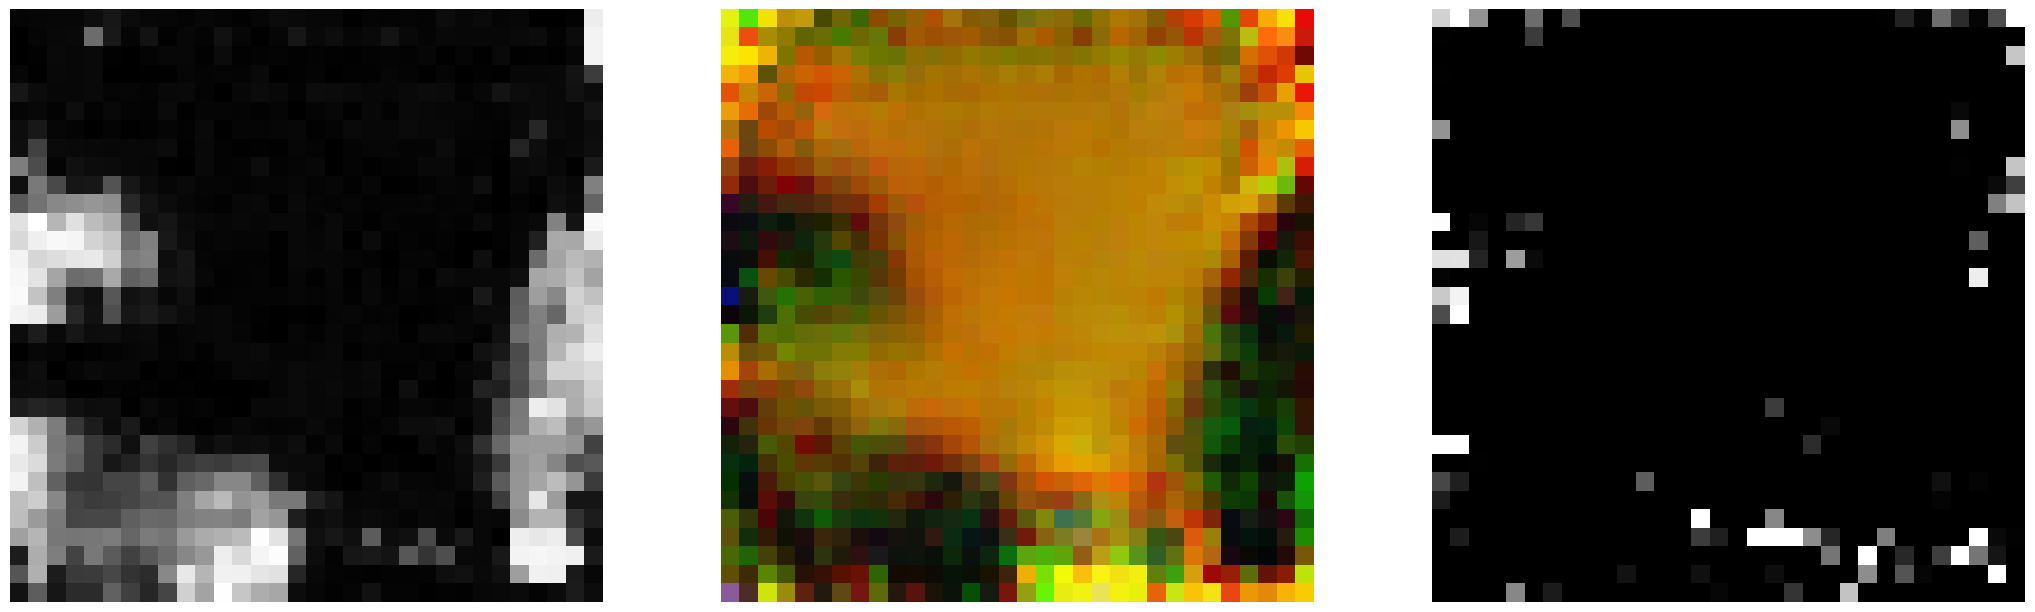

350 0.0090


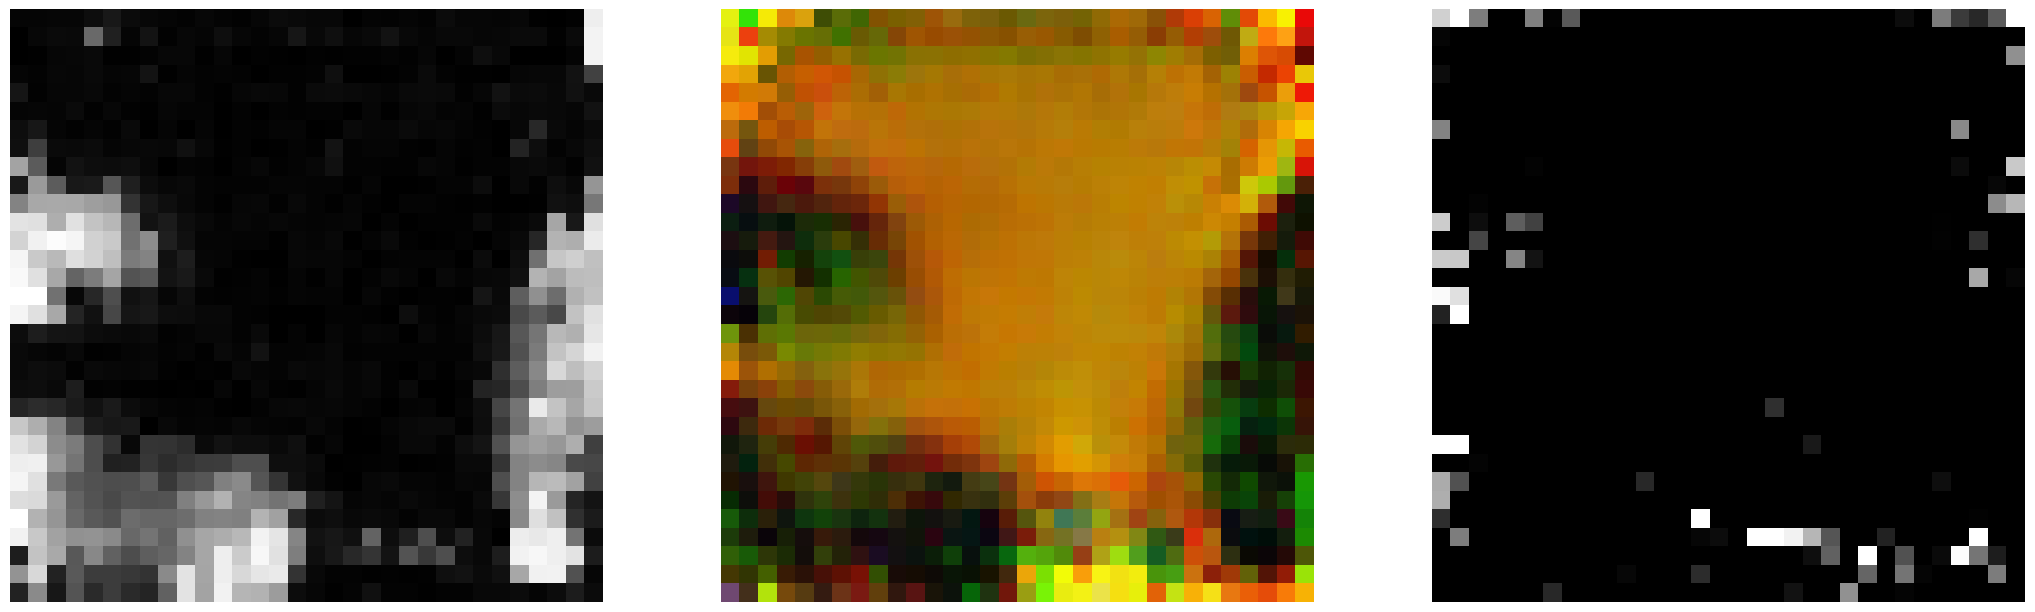

400 0.0112


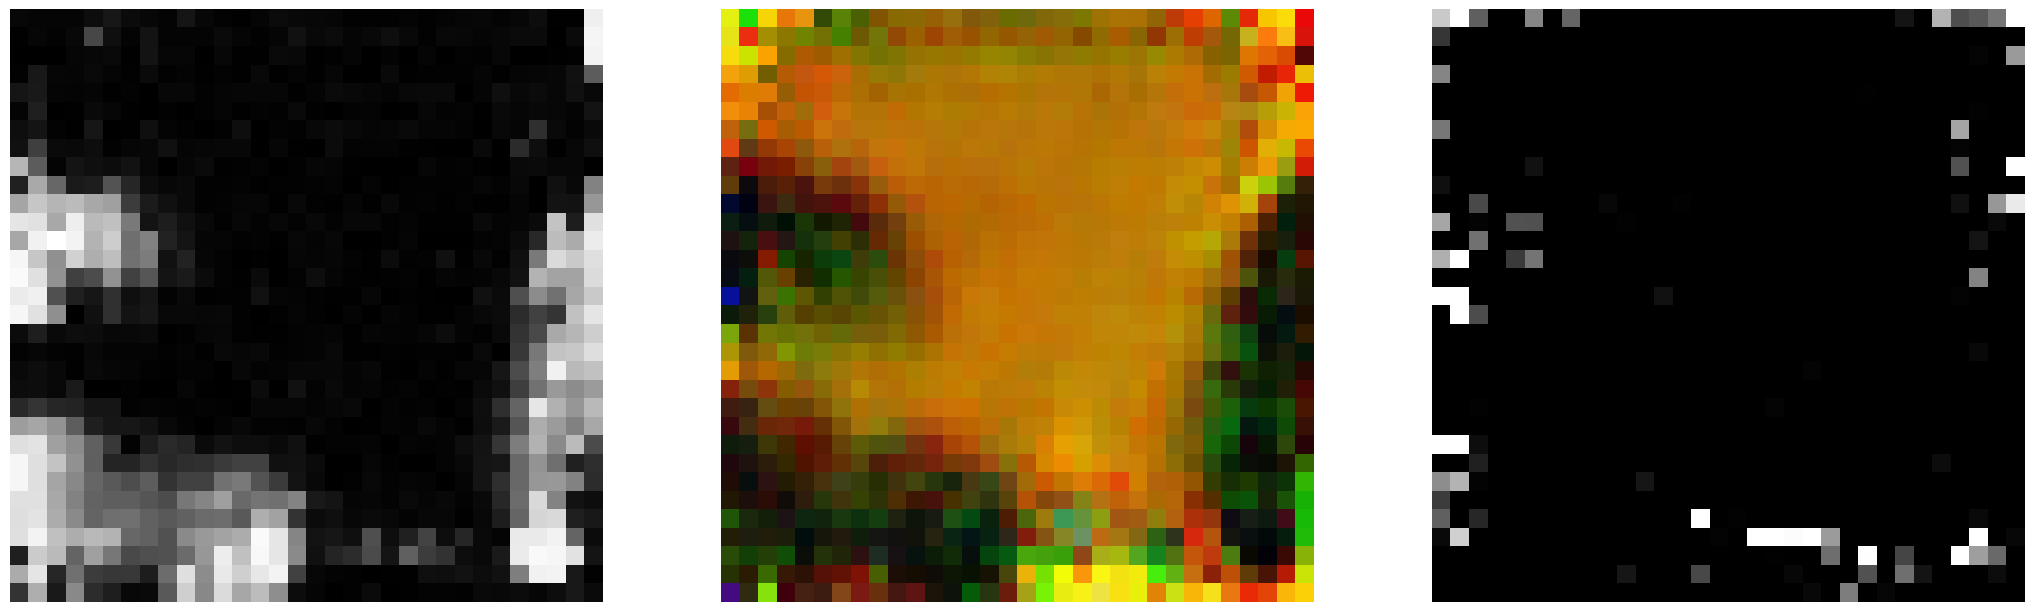

450 0.0082


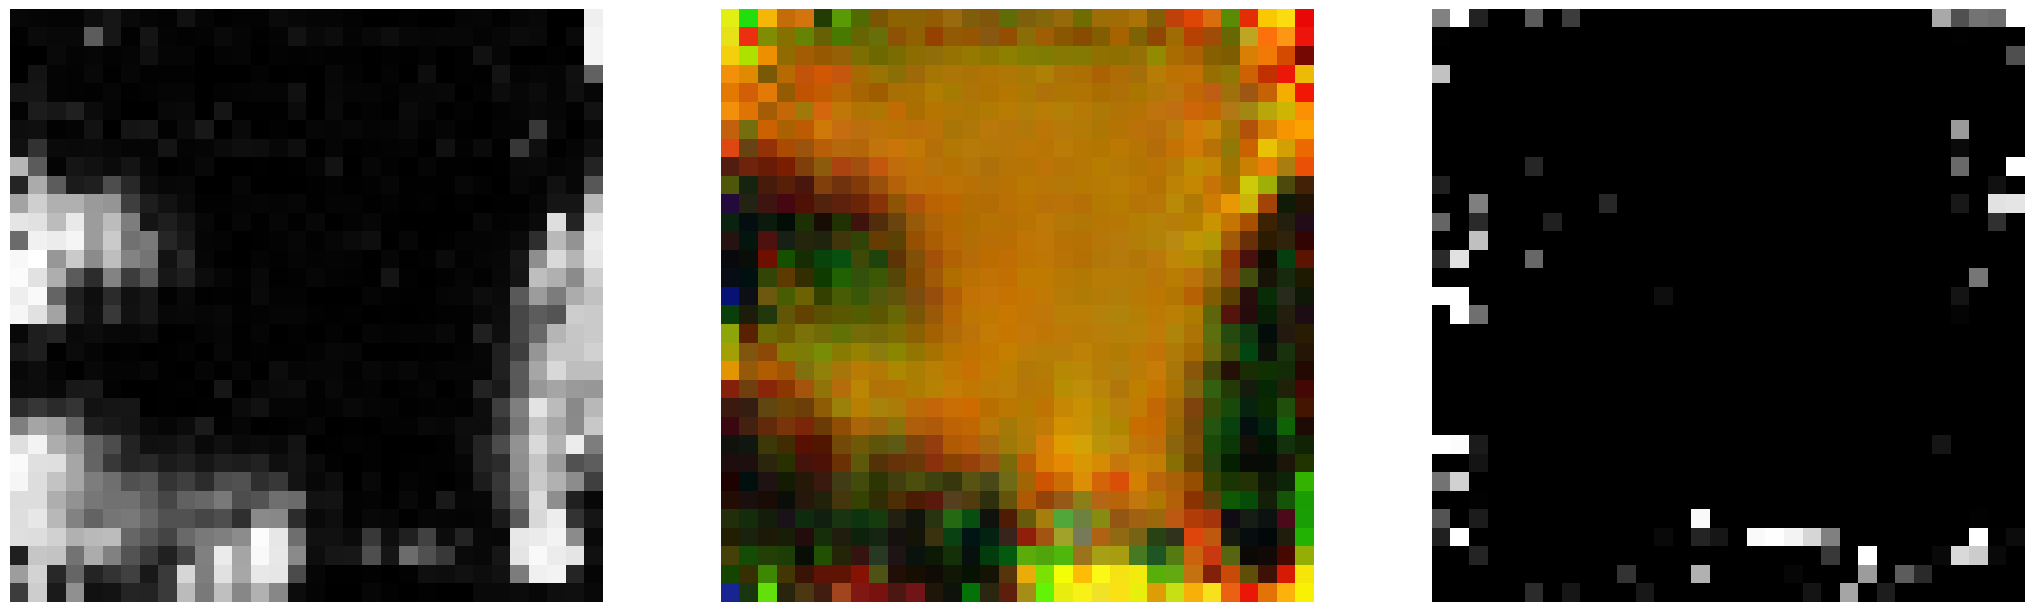

0 0.0083


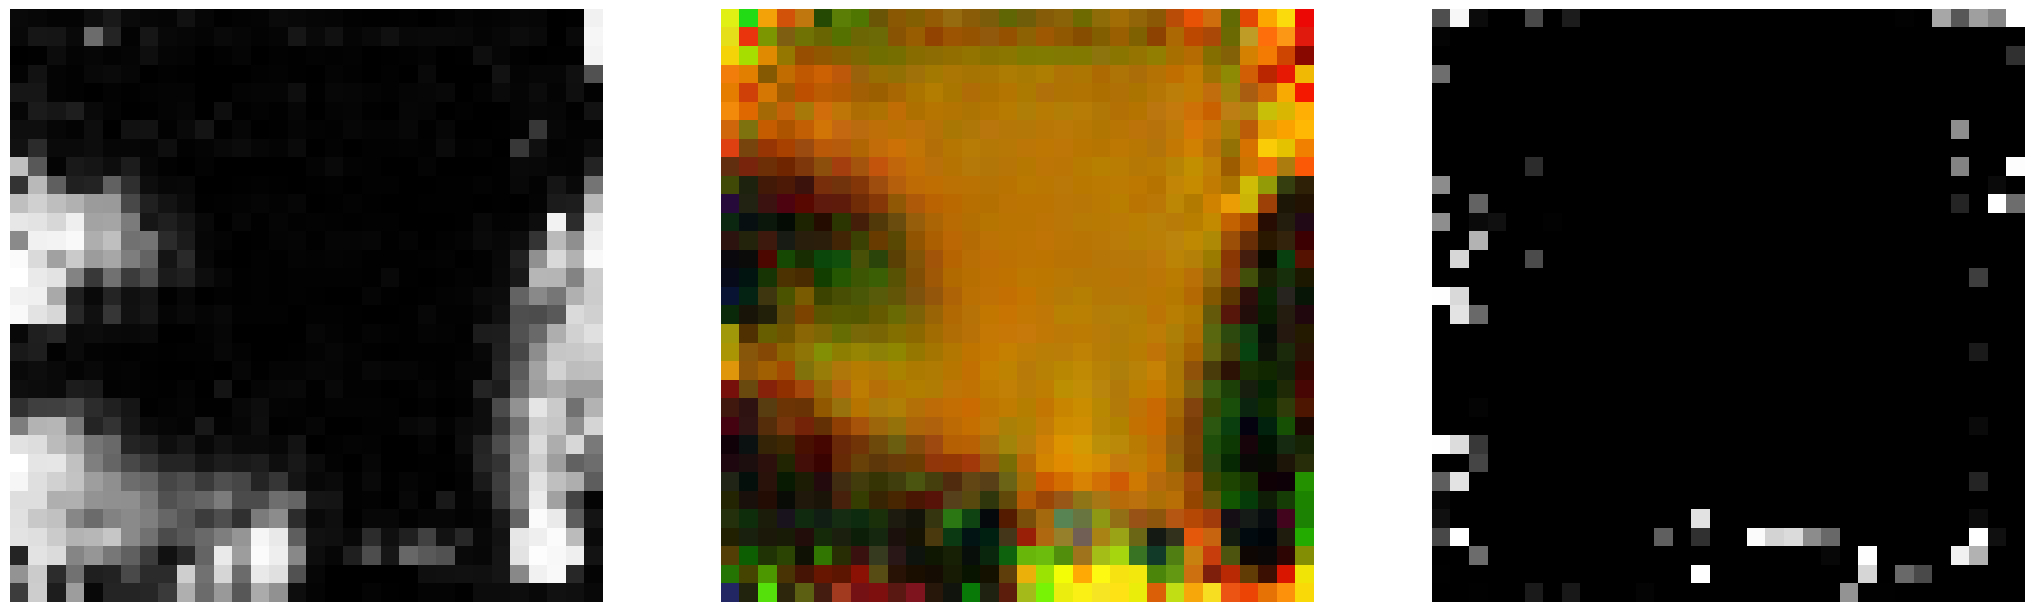

50 0.0082


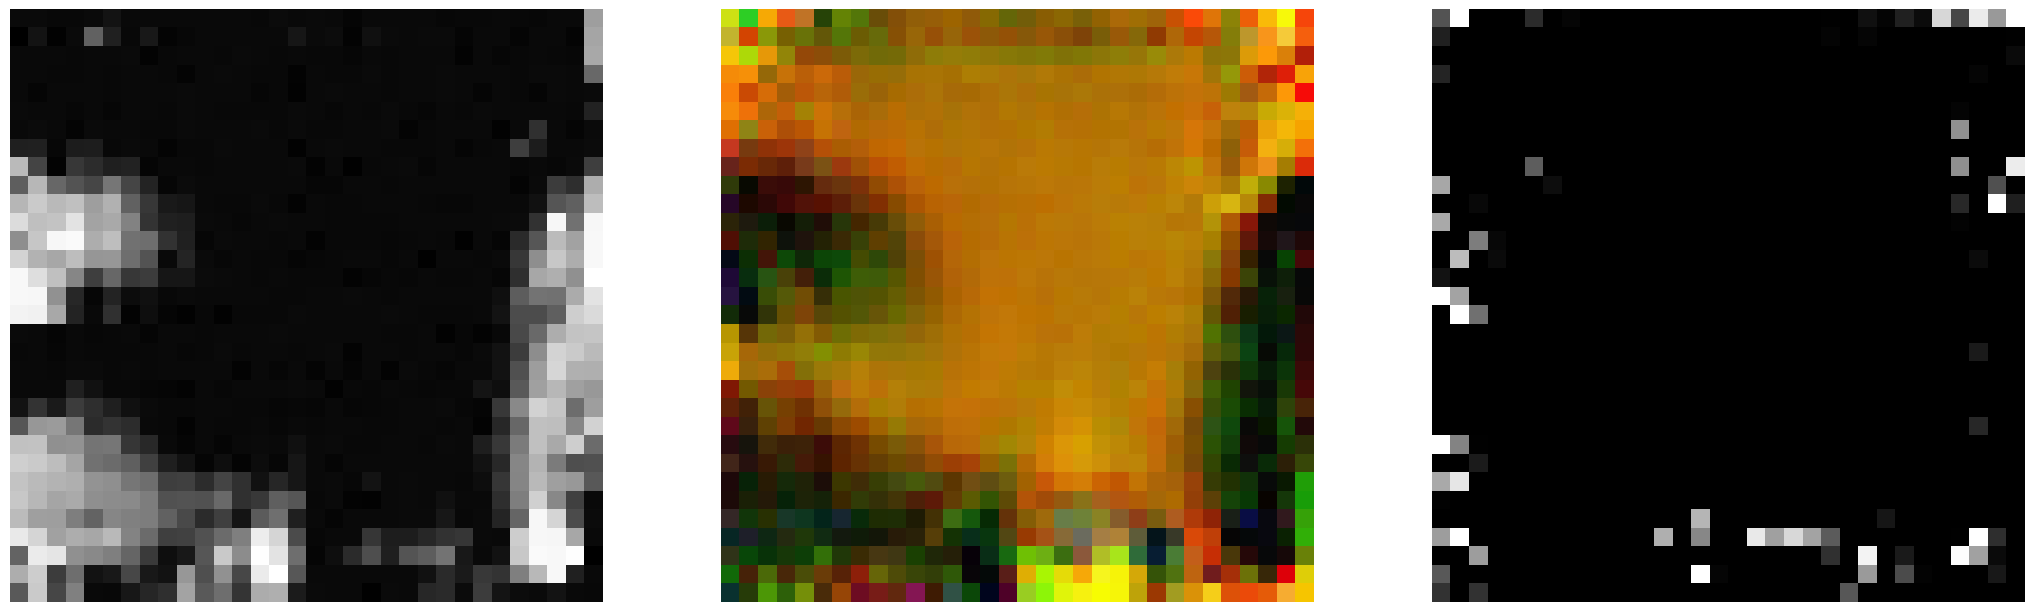

100 0.0080


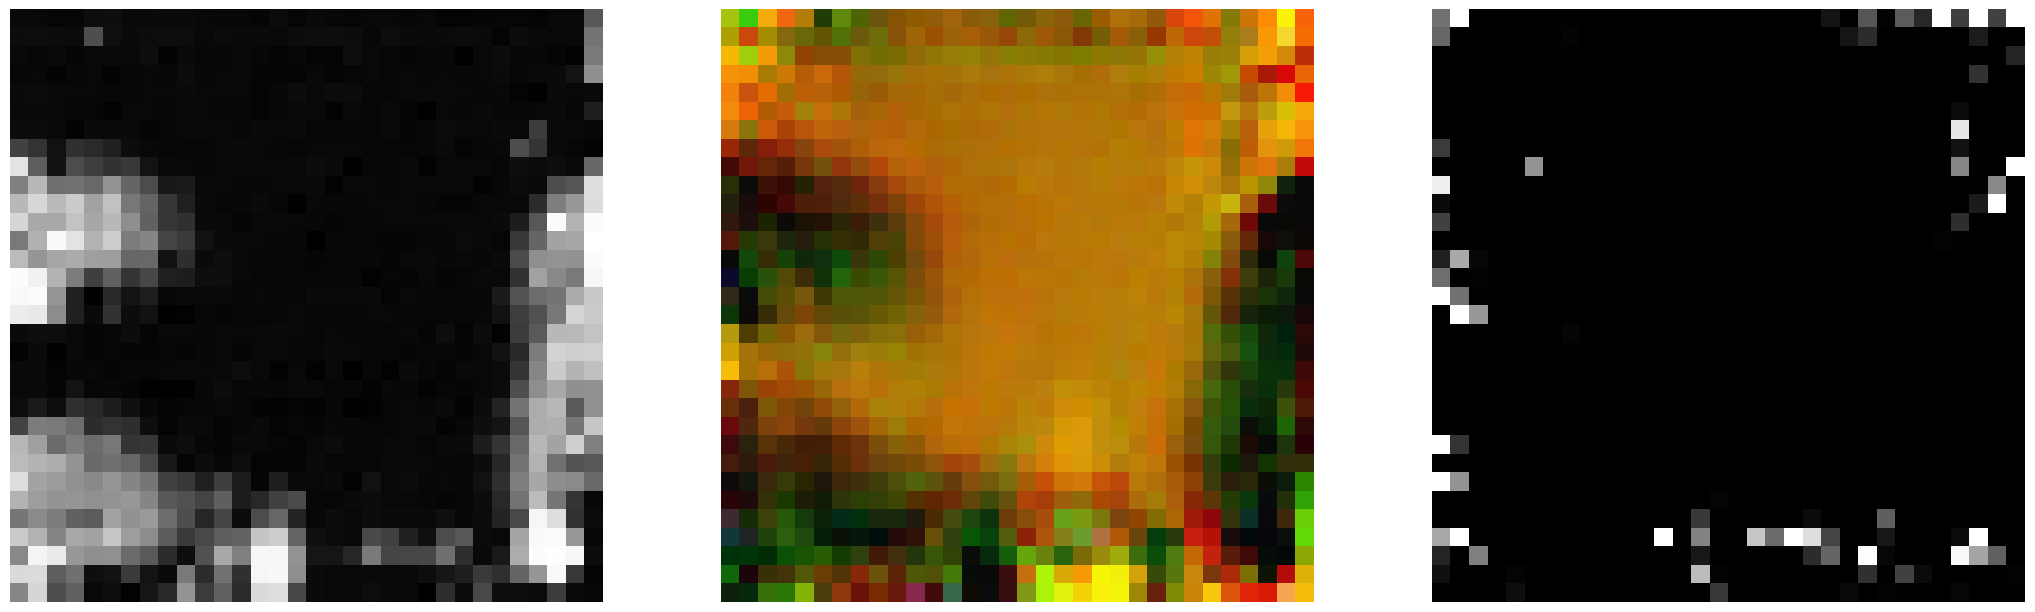

150 0.0090


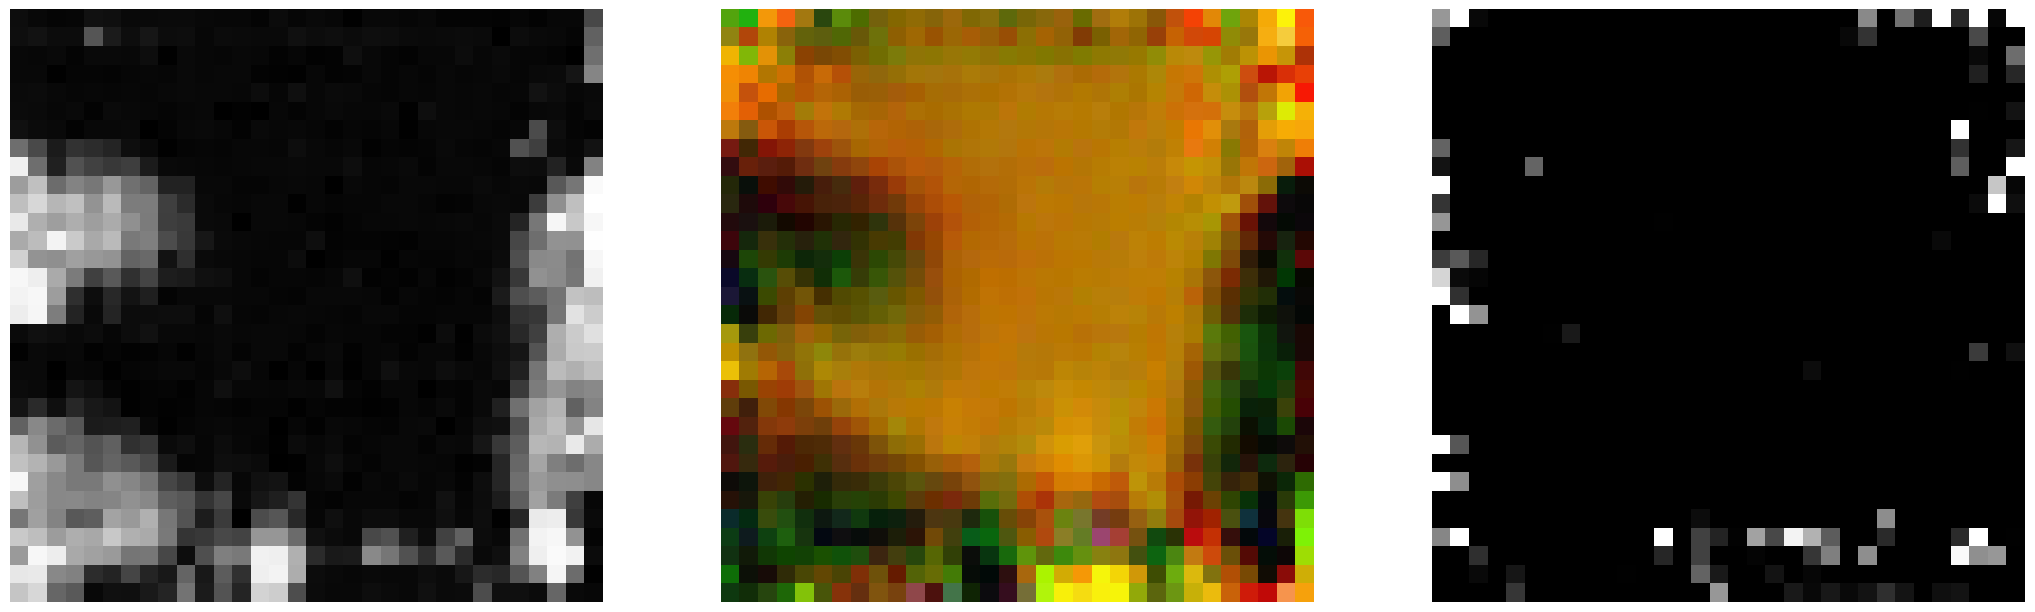

200 0.0095


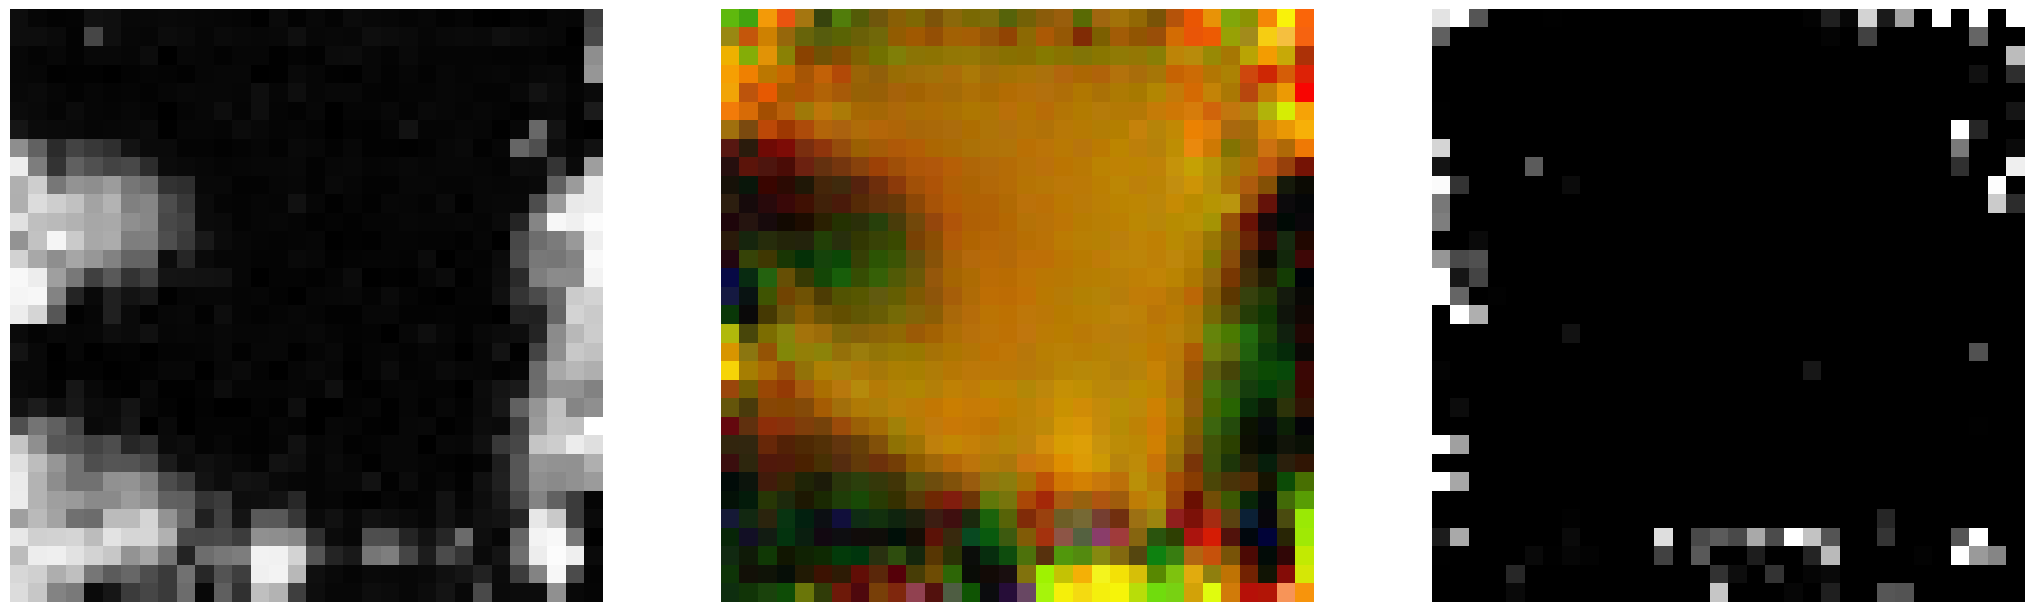

250 0.0087


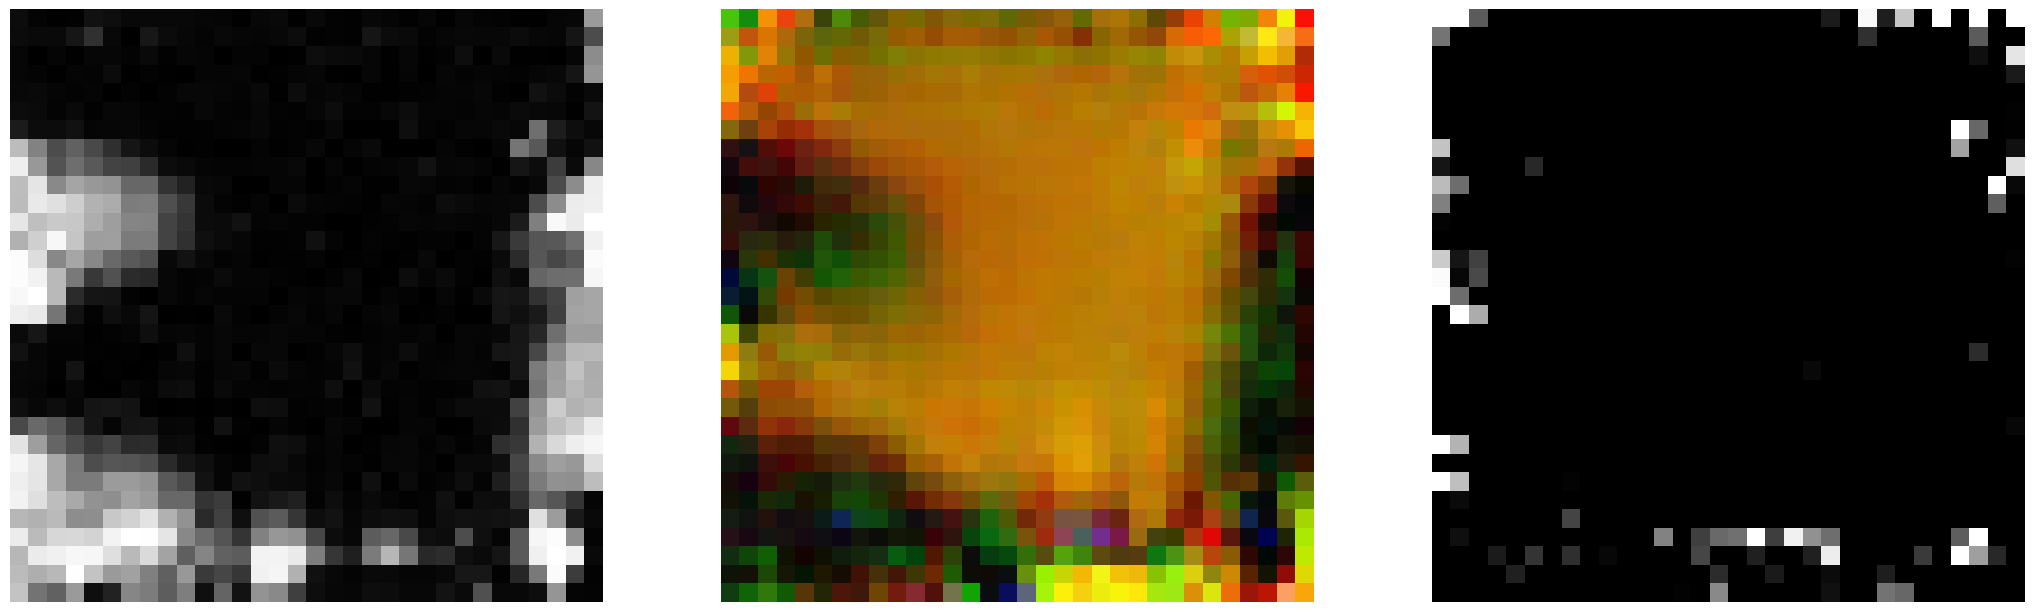

300 0.0090


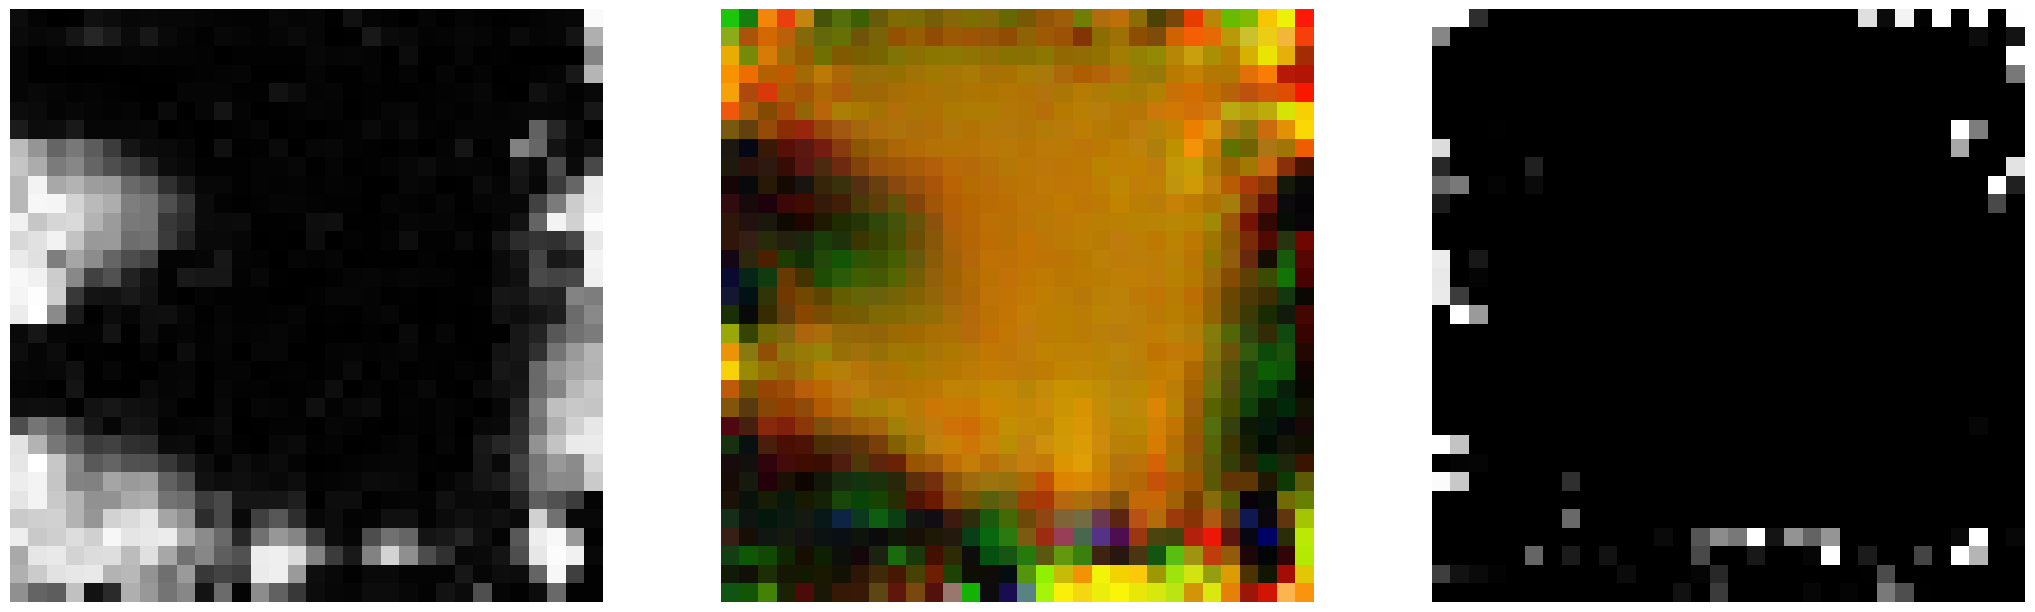

350 0.0101


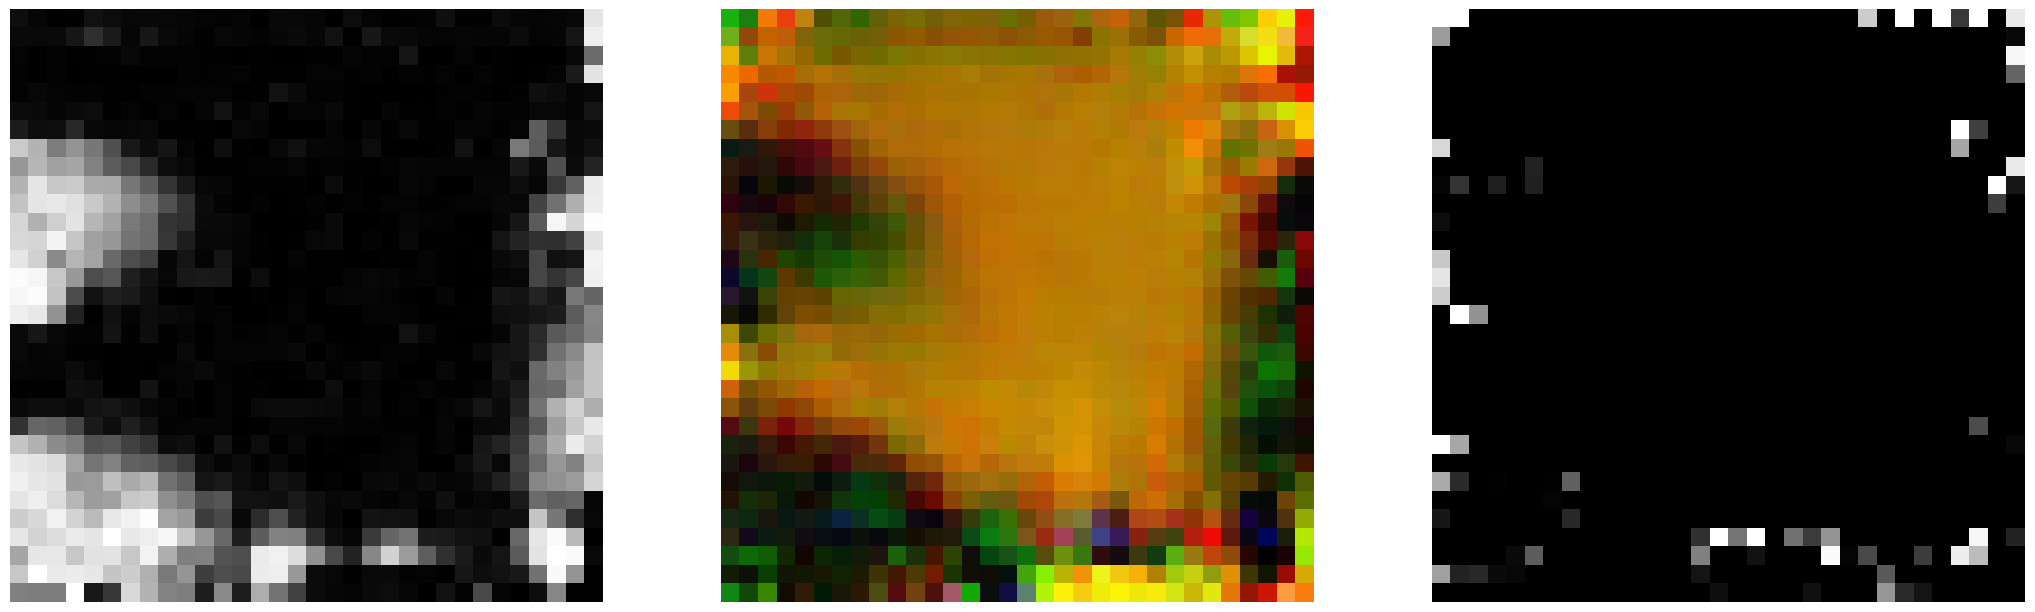

400 0.0083


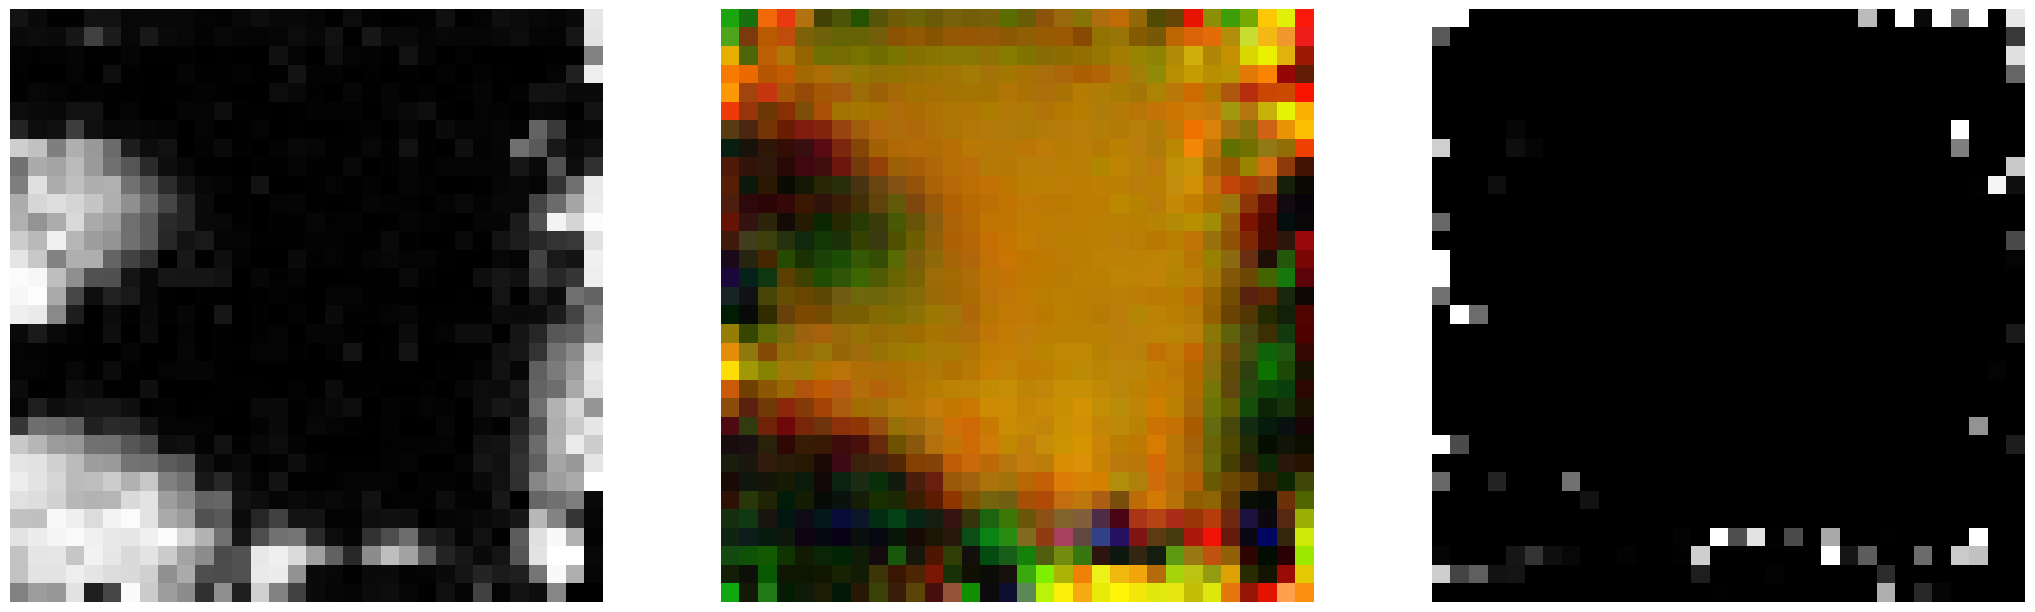

450 0.0075


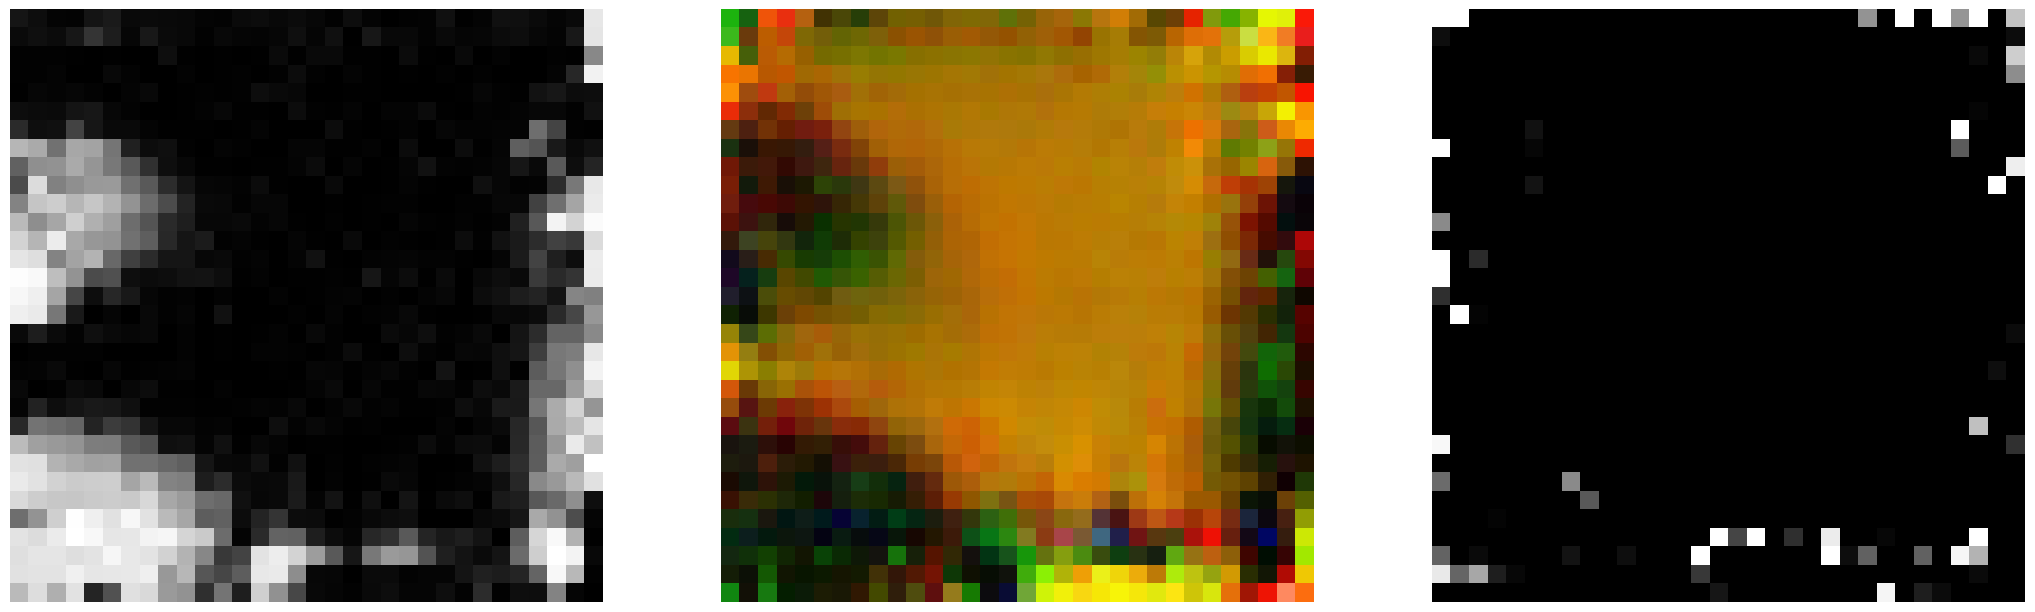

0 0.0089


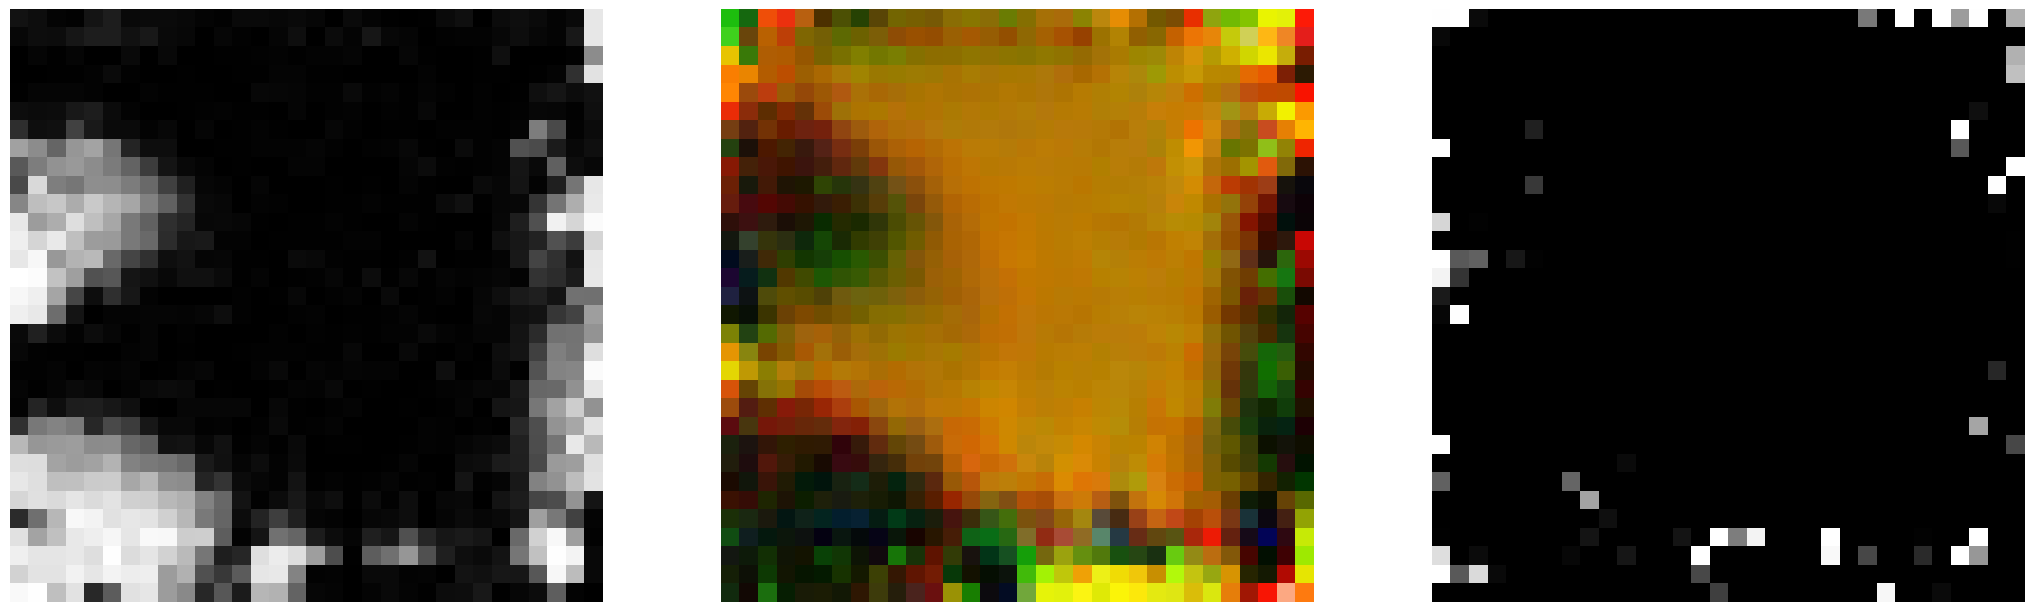

50 0.0086


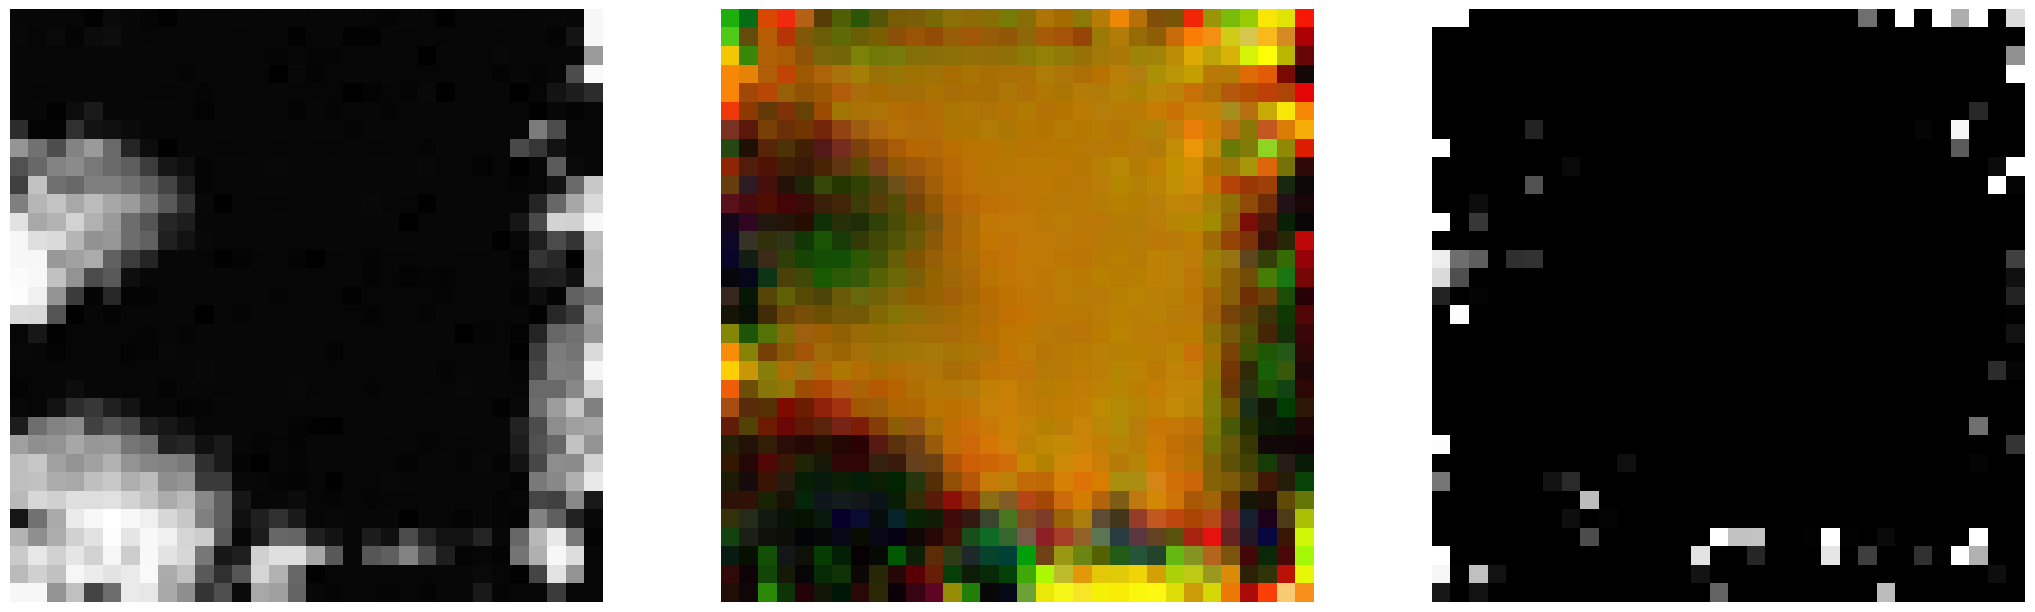

100 0.0074


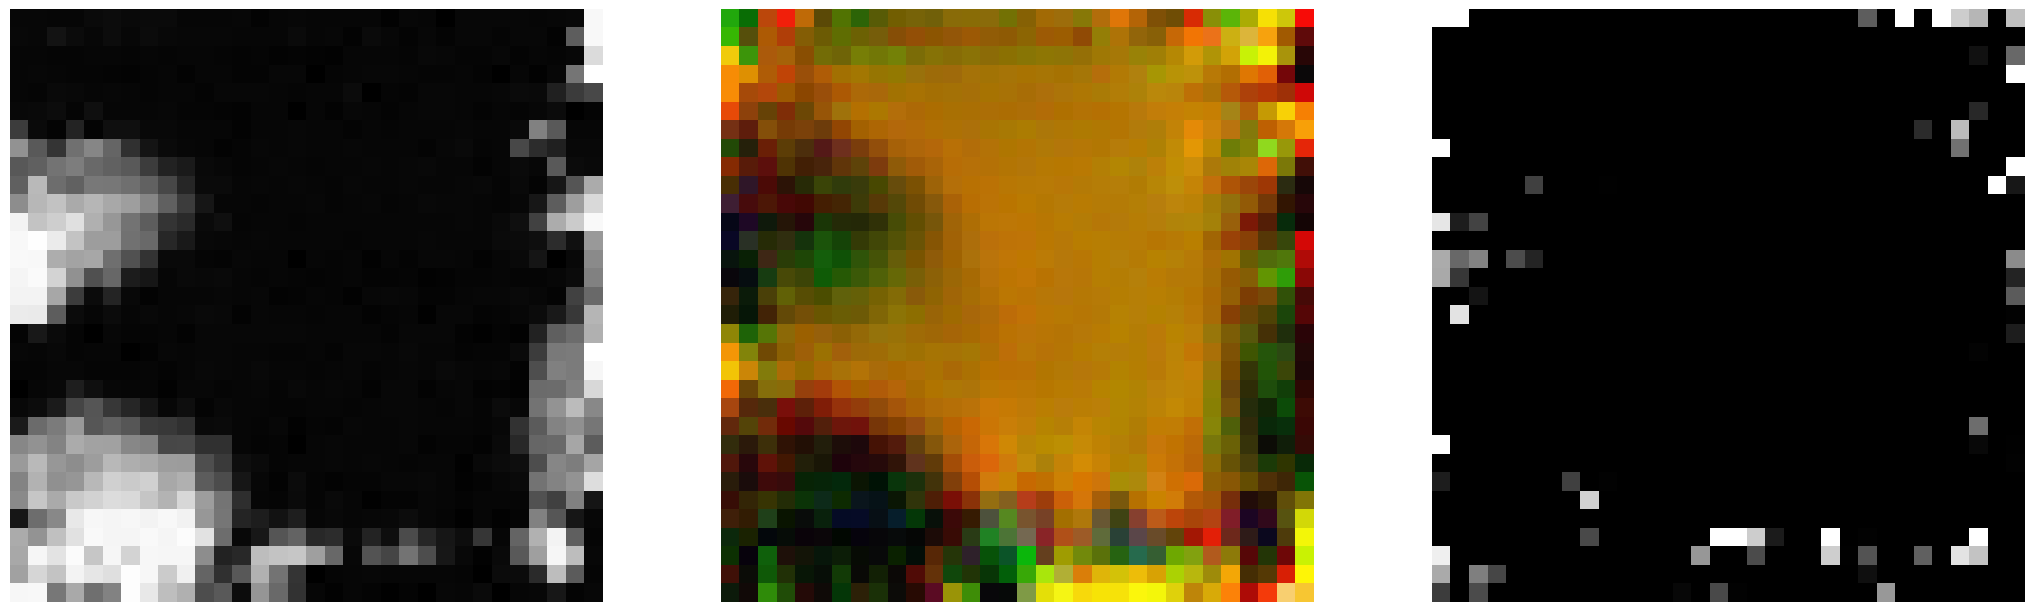

150 0.0078


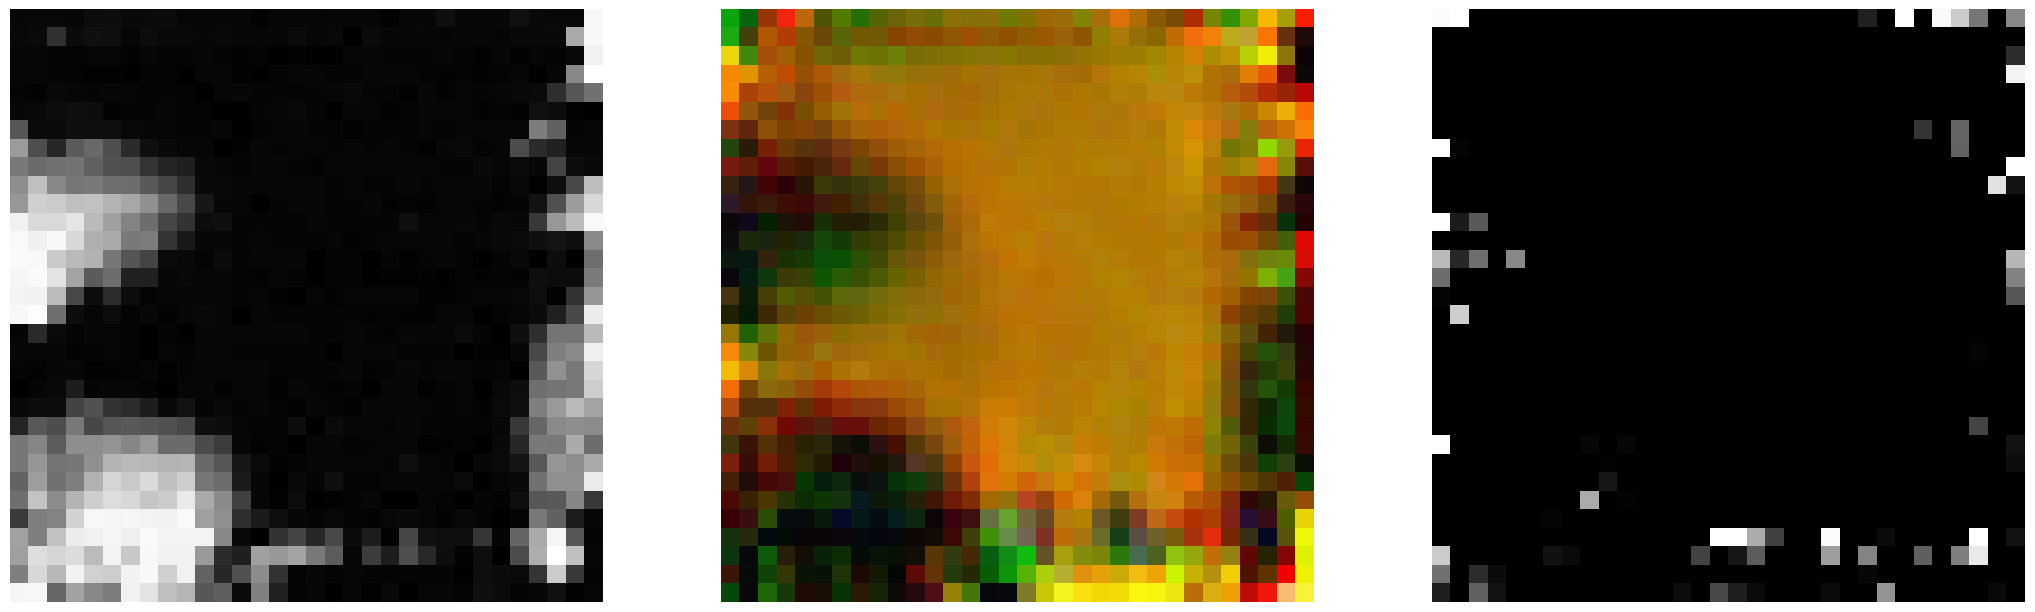

200 0.0075


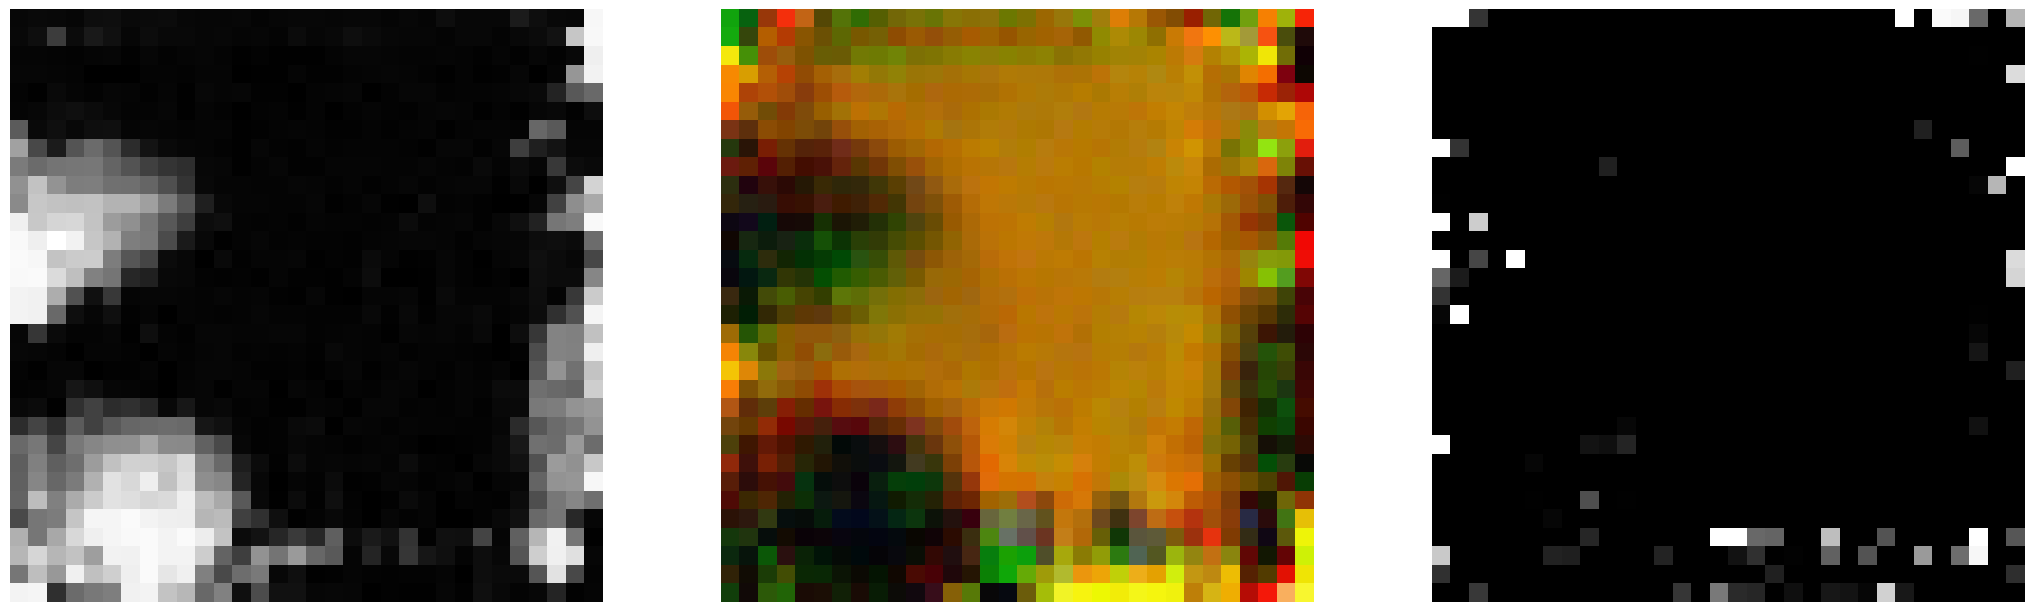

250 0.0085


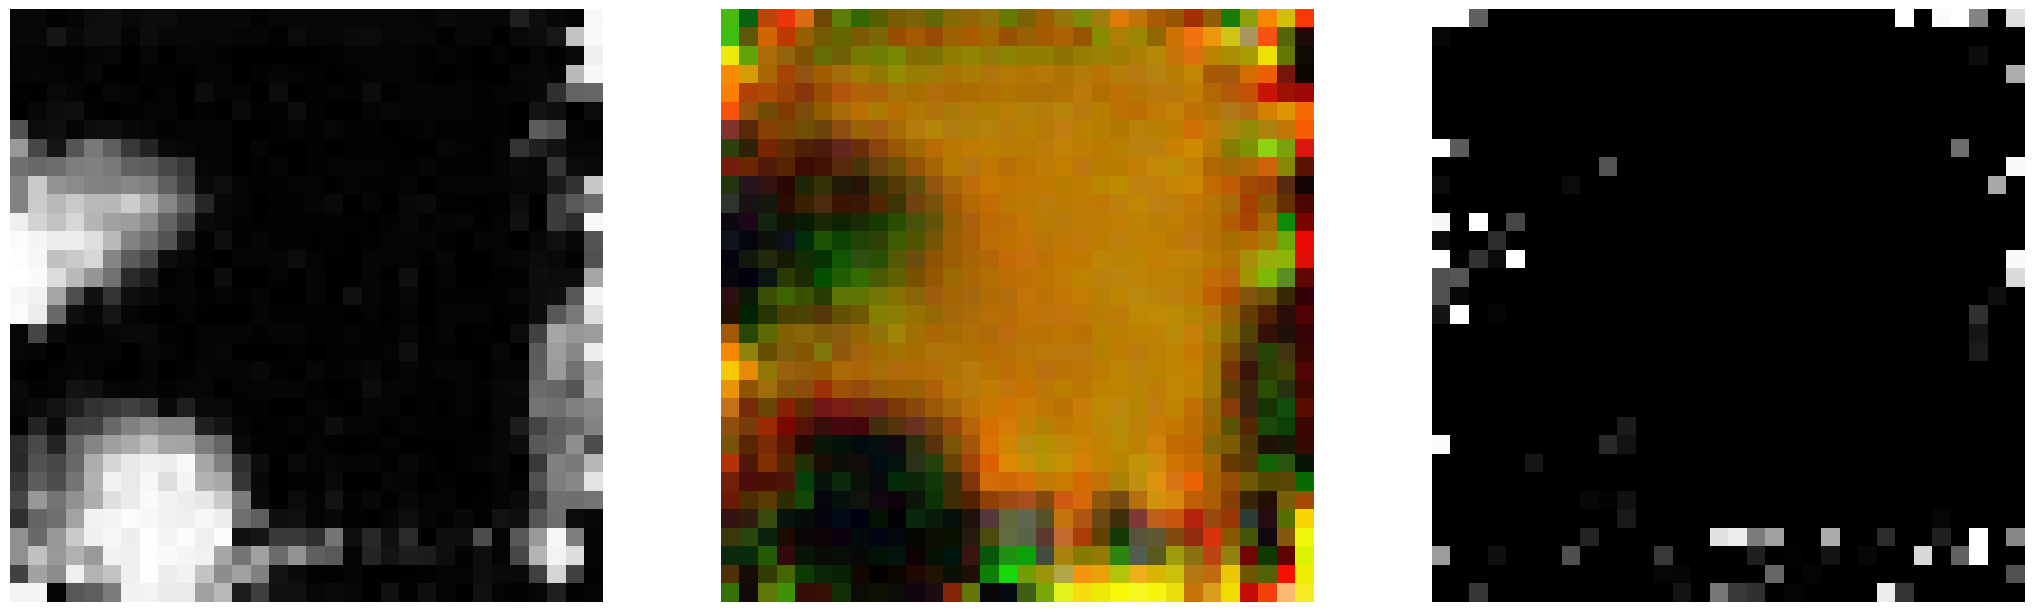

300 0.0086


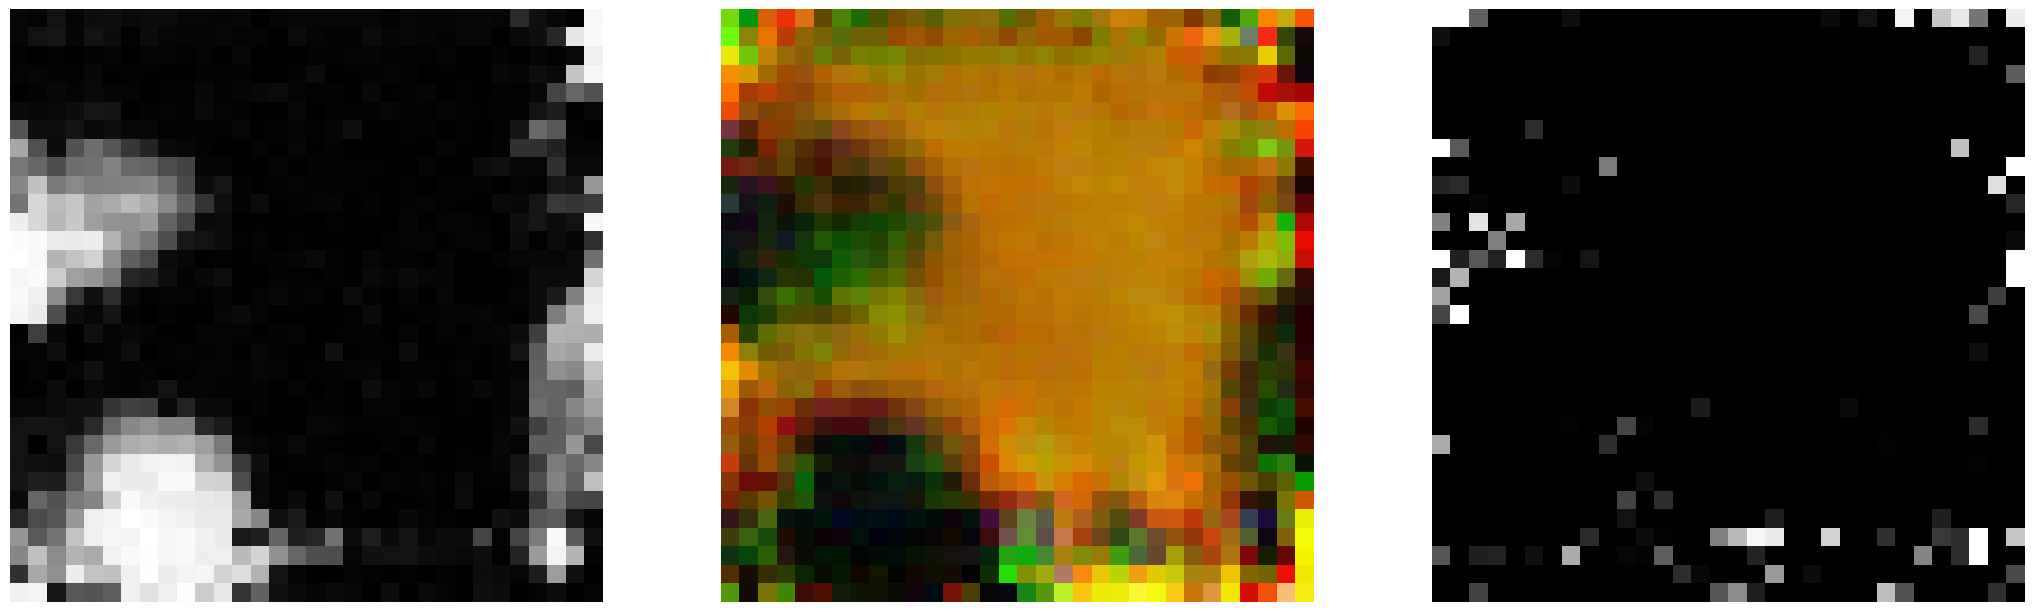

350 0.0093


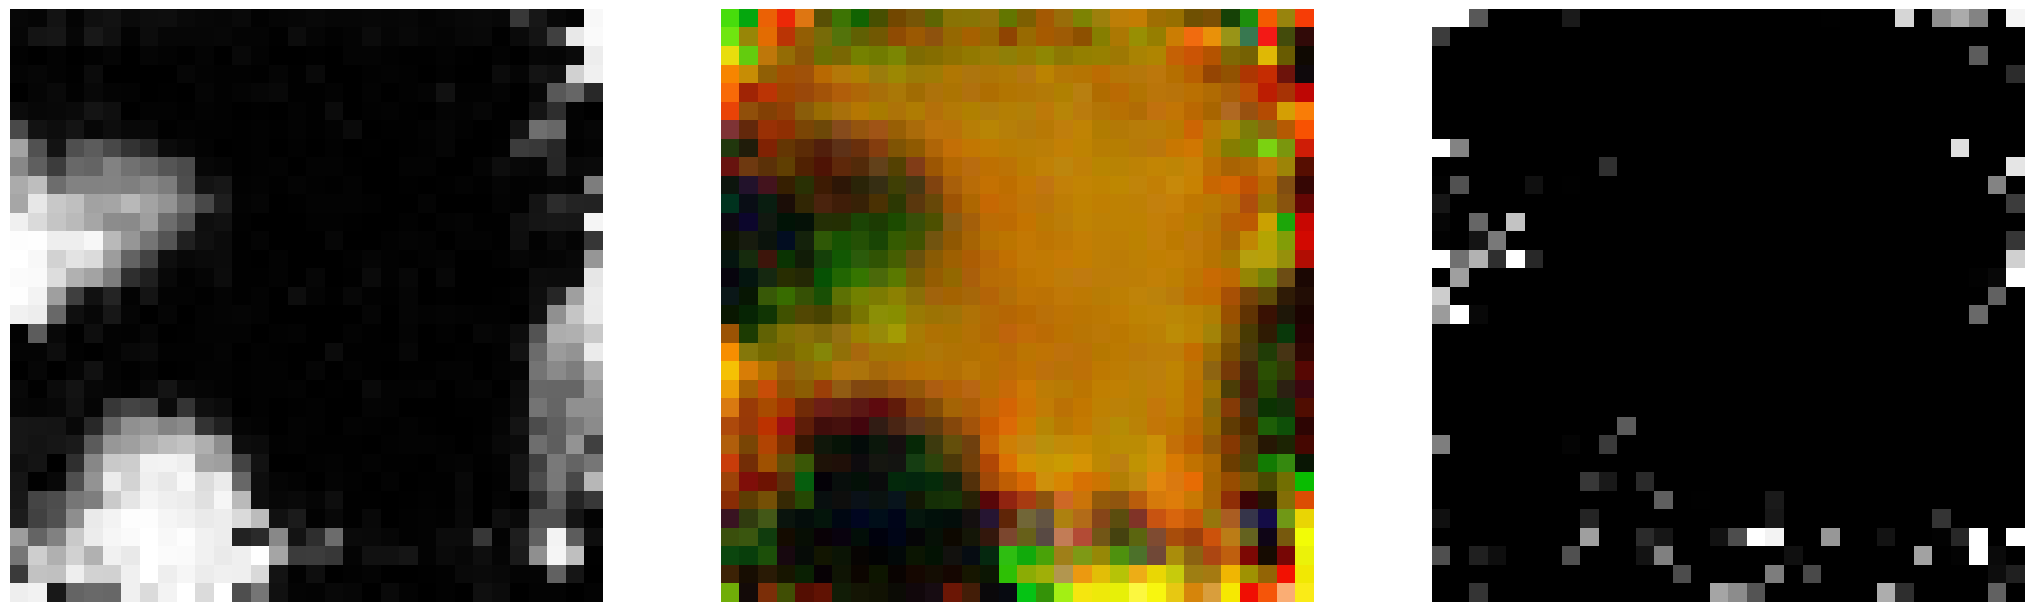

400 0.0109


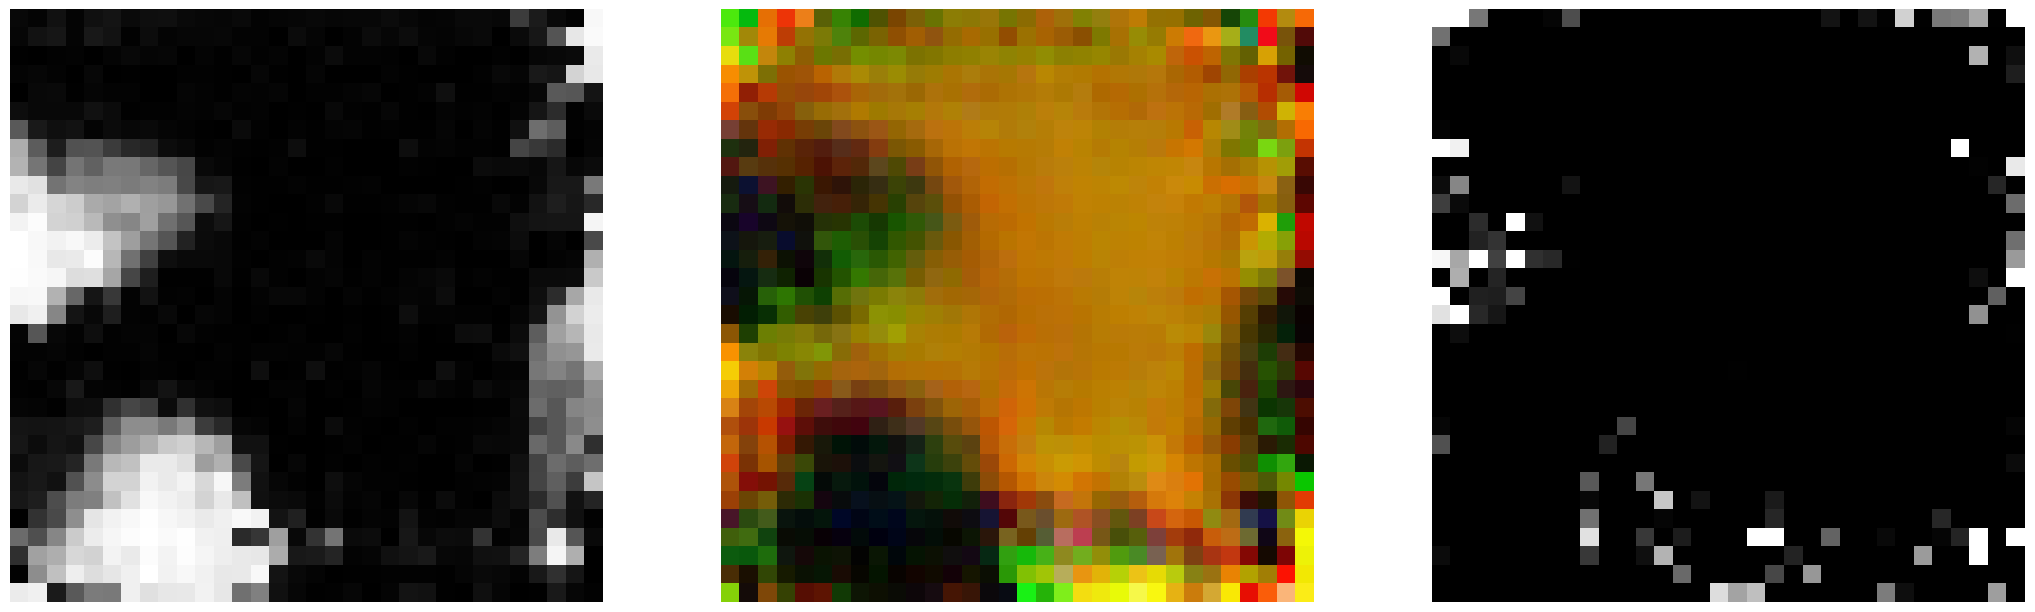

450 0.0091


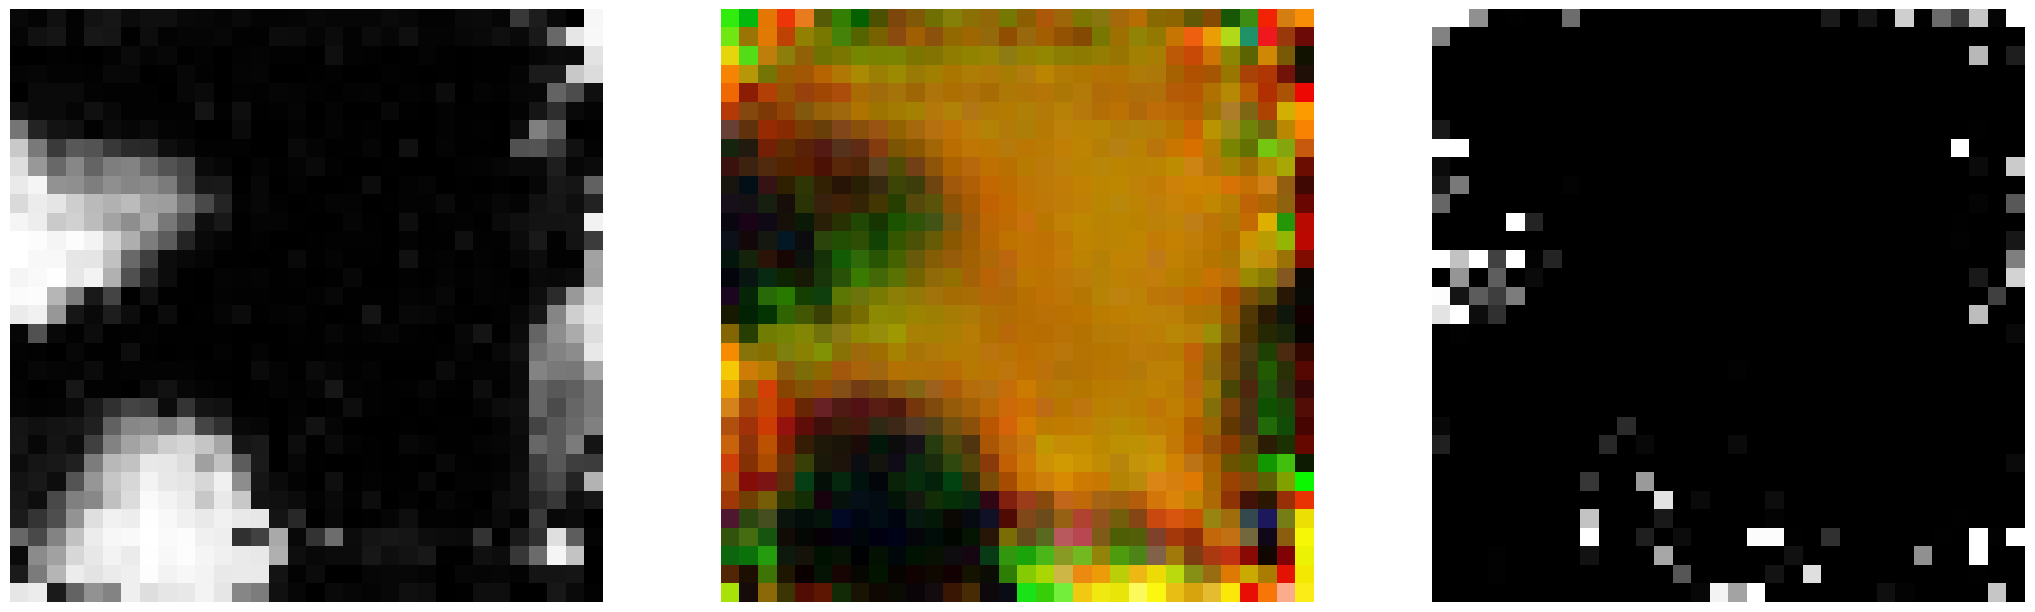

0 0.0093


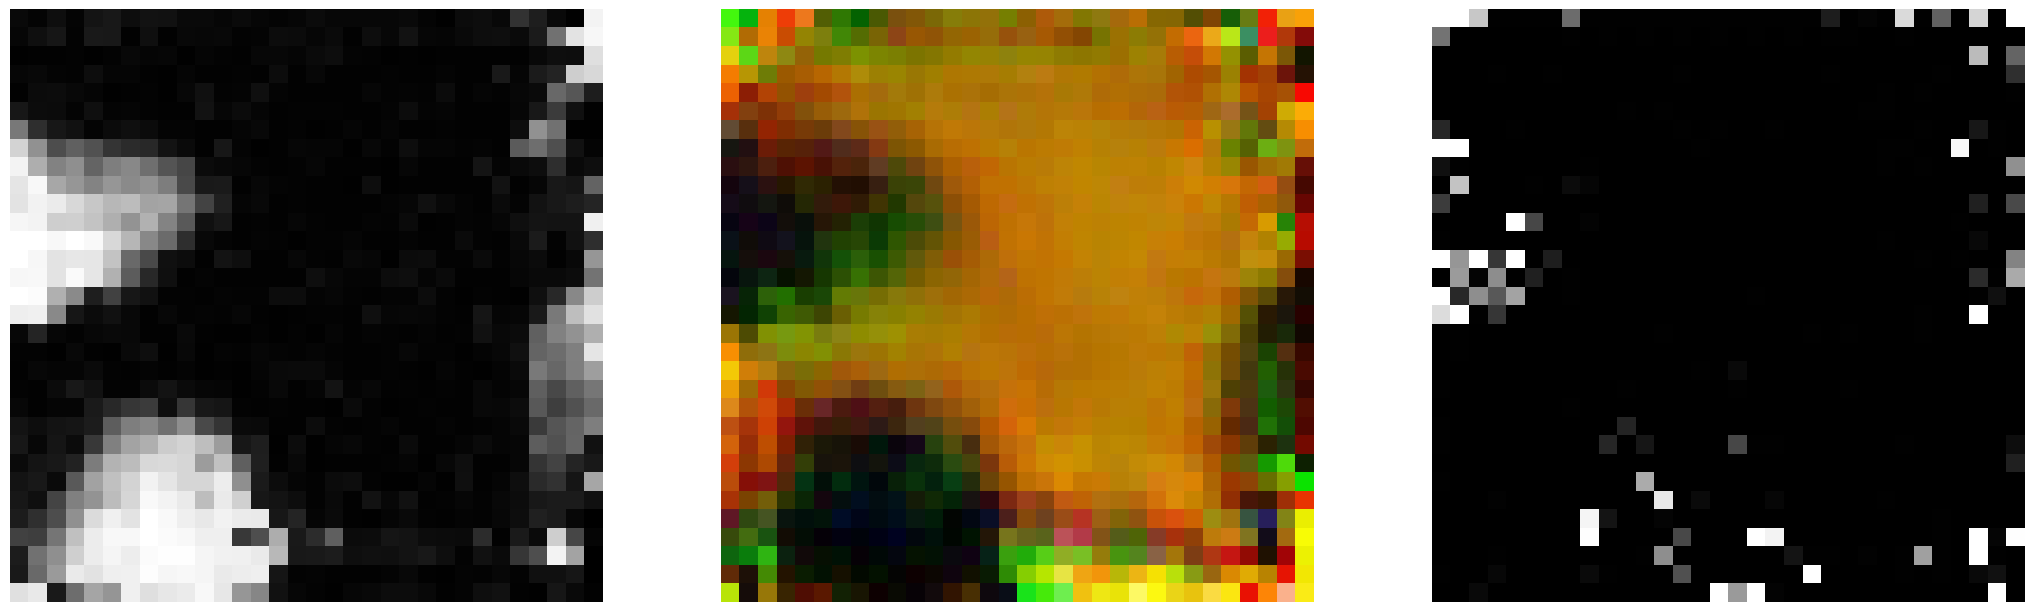

50 0.0087


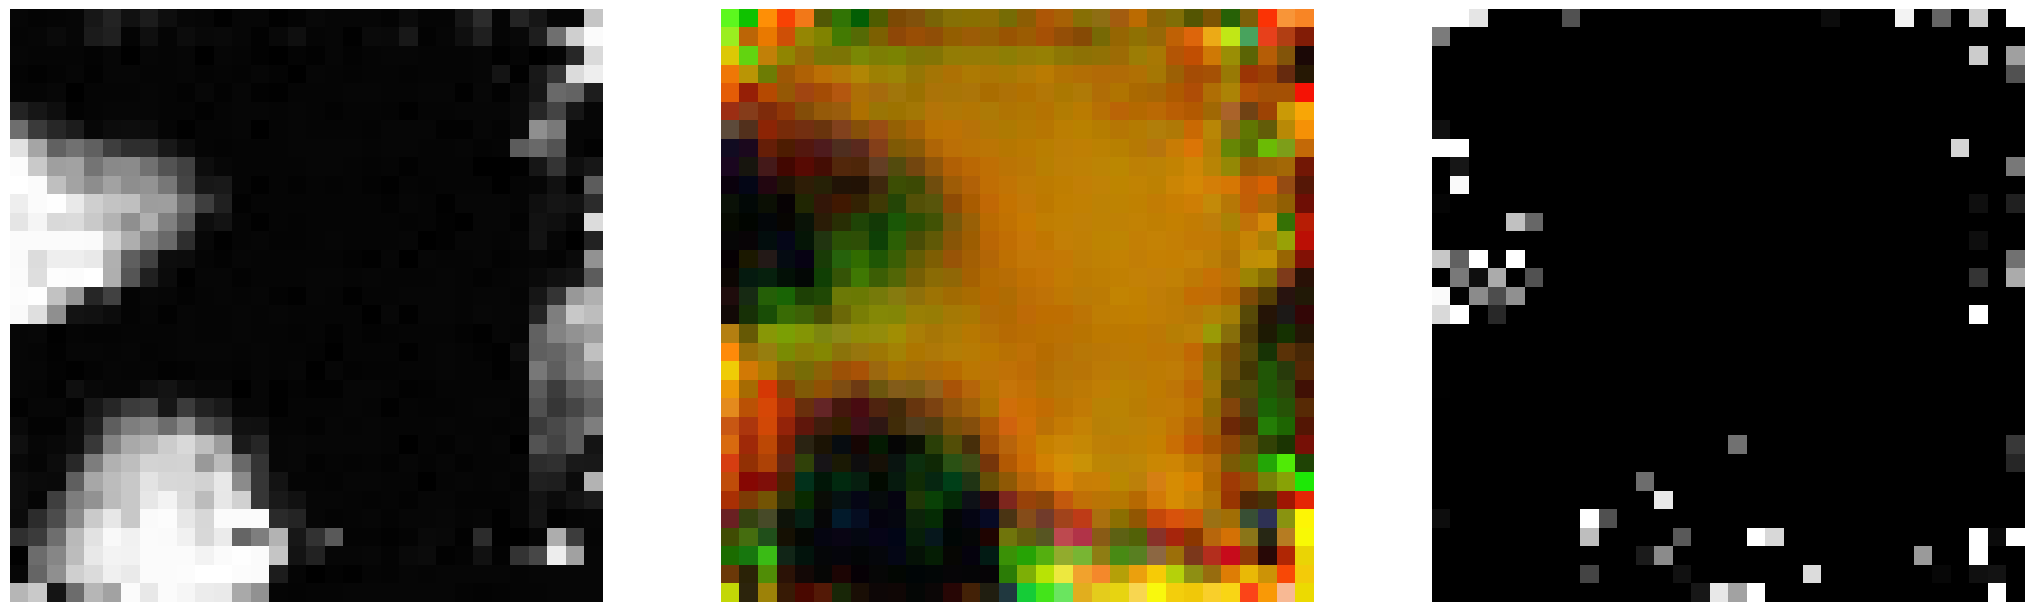

100 0.0090


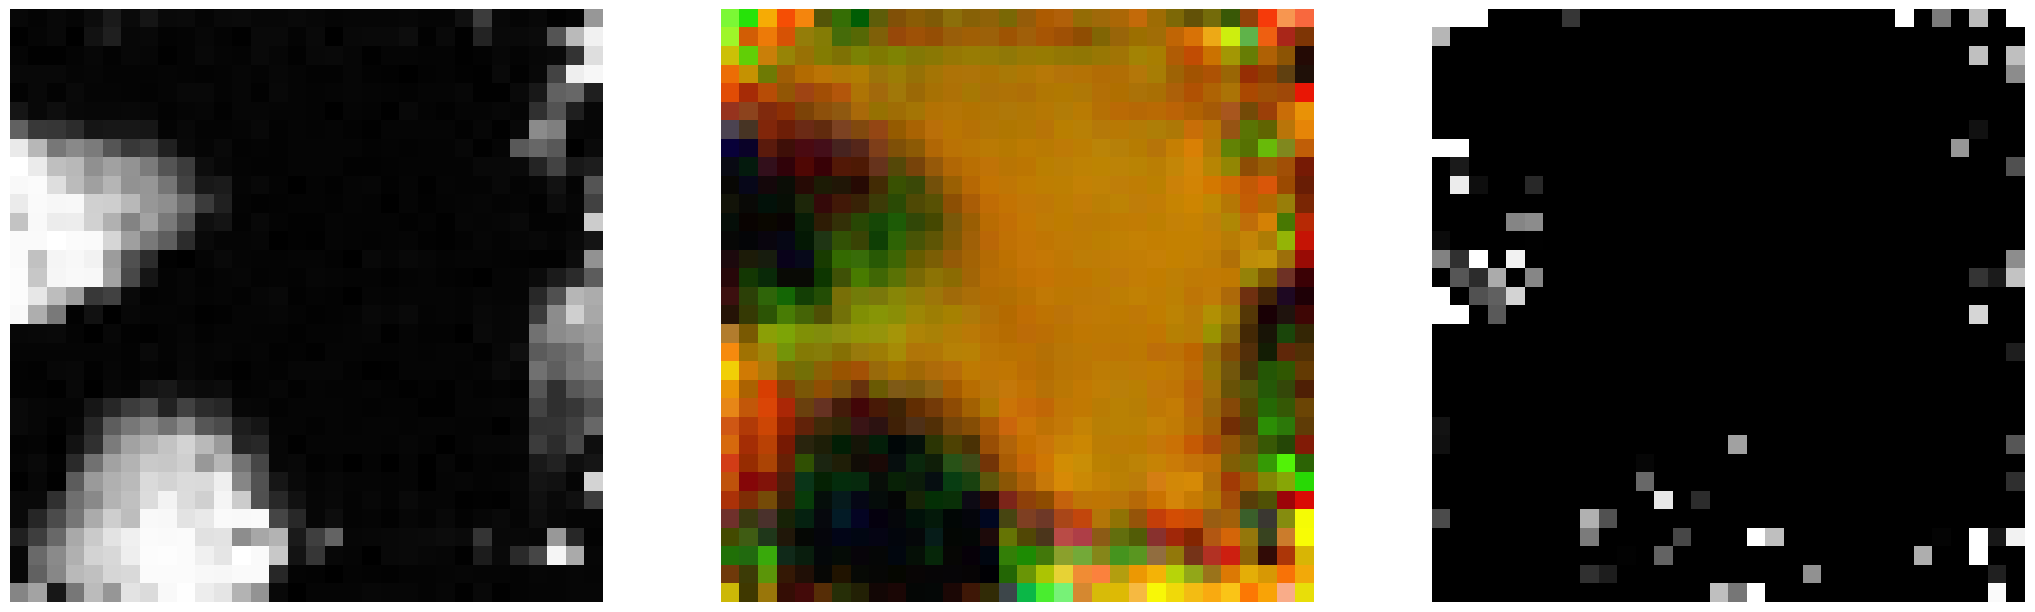

150 0.0089


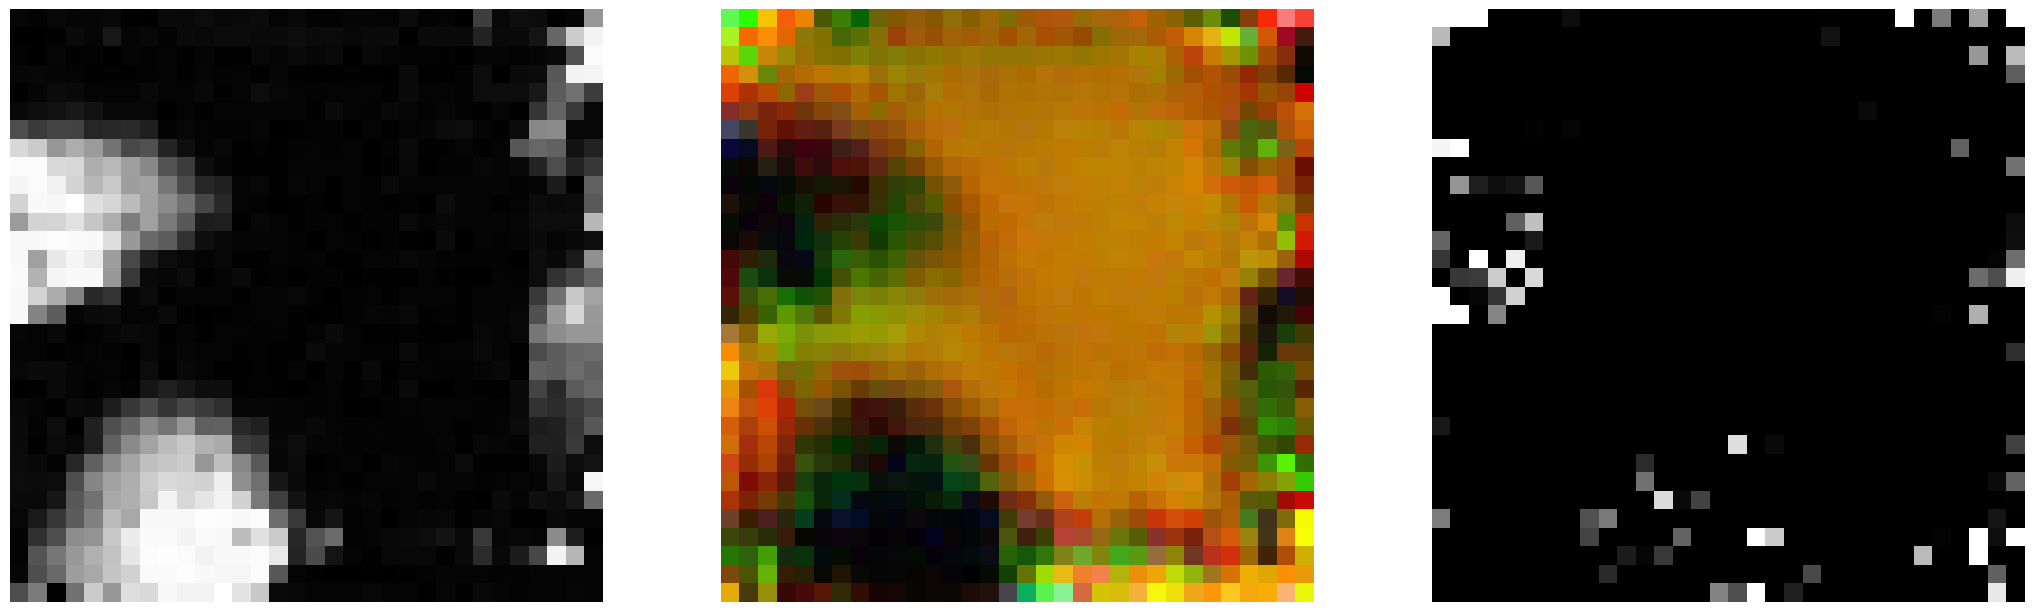

200 0.0093


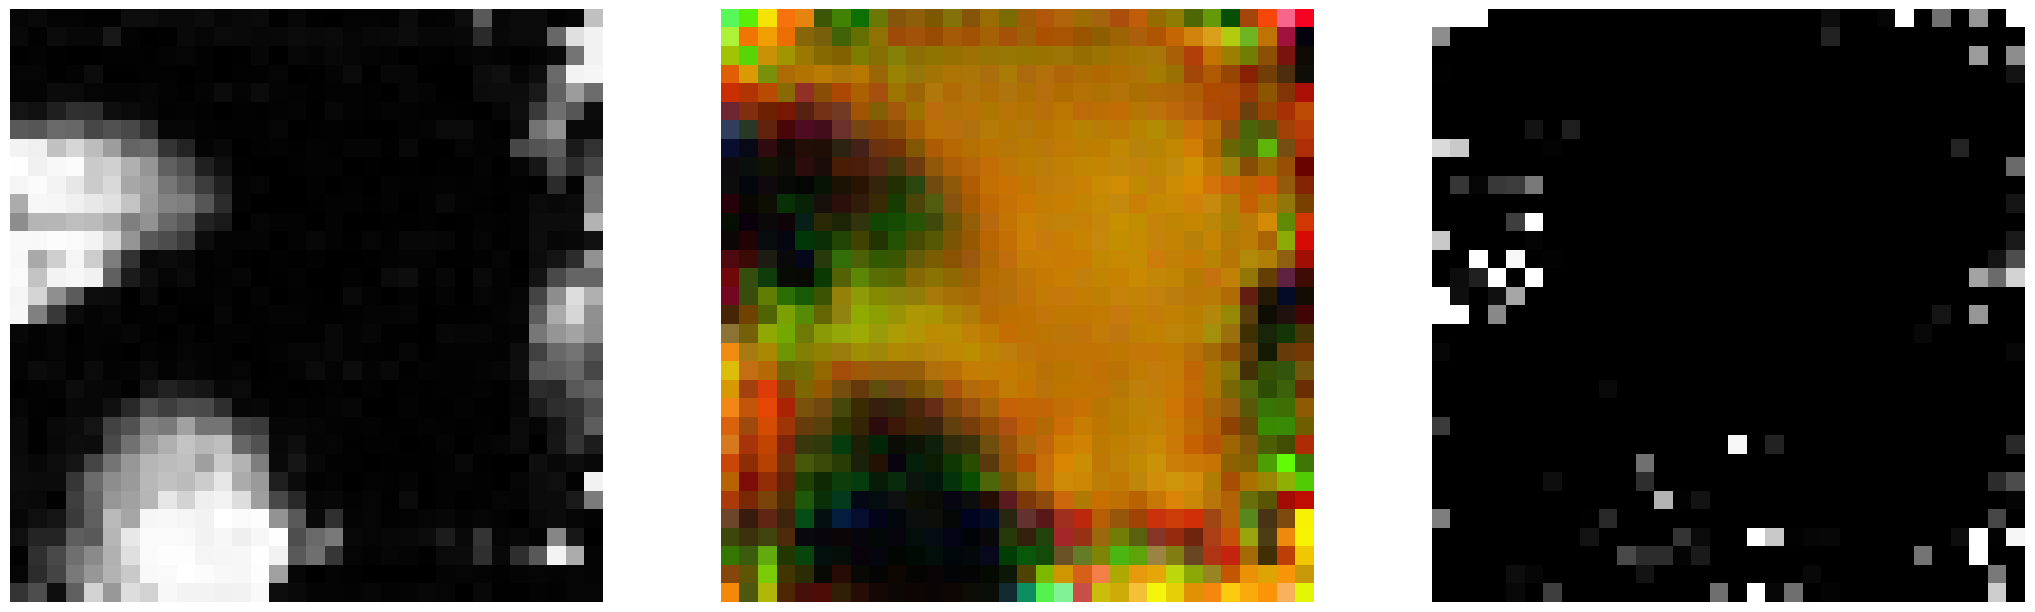

250 0.0126


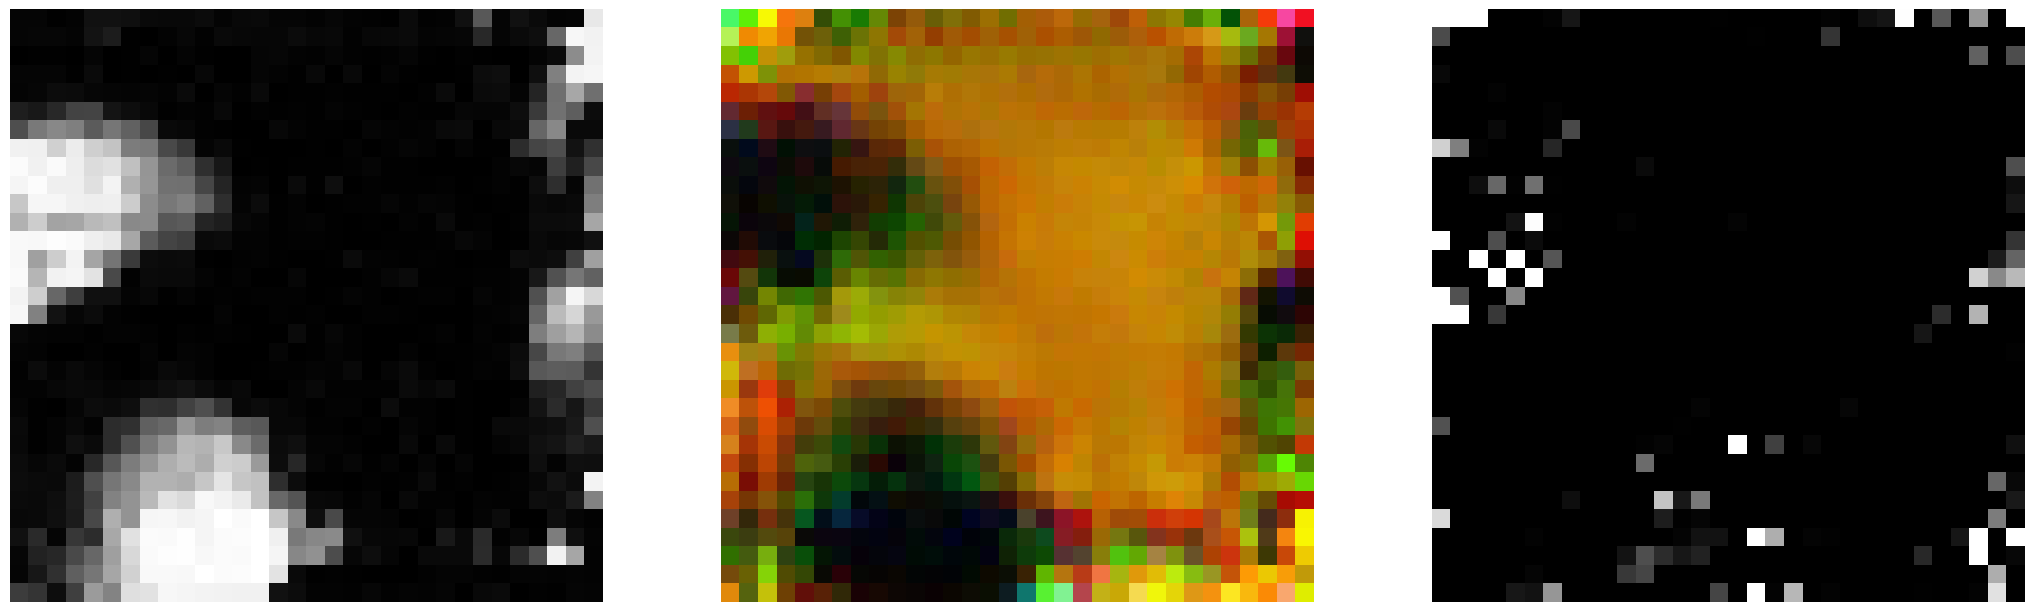

300 0.0099


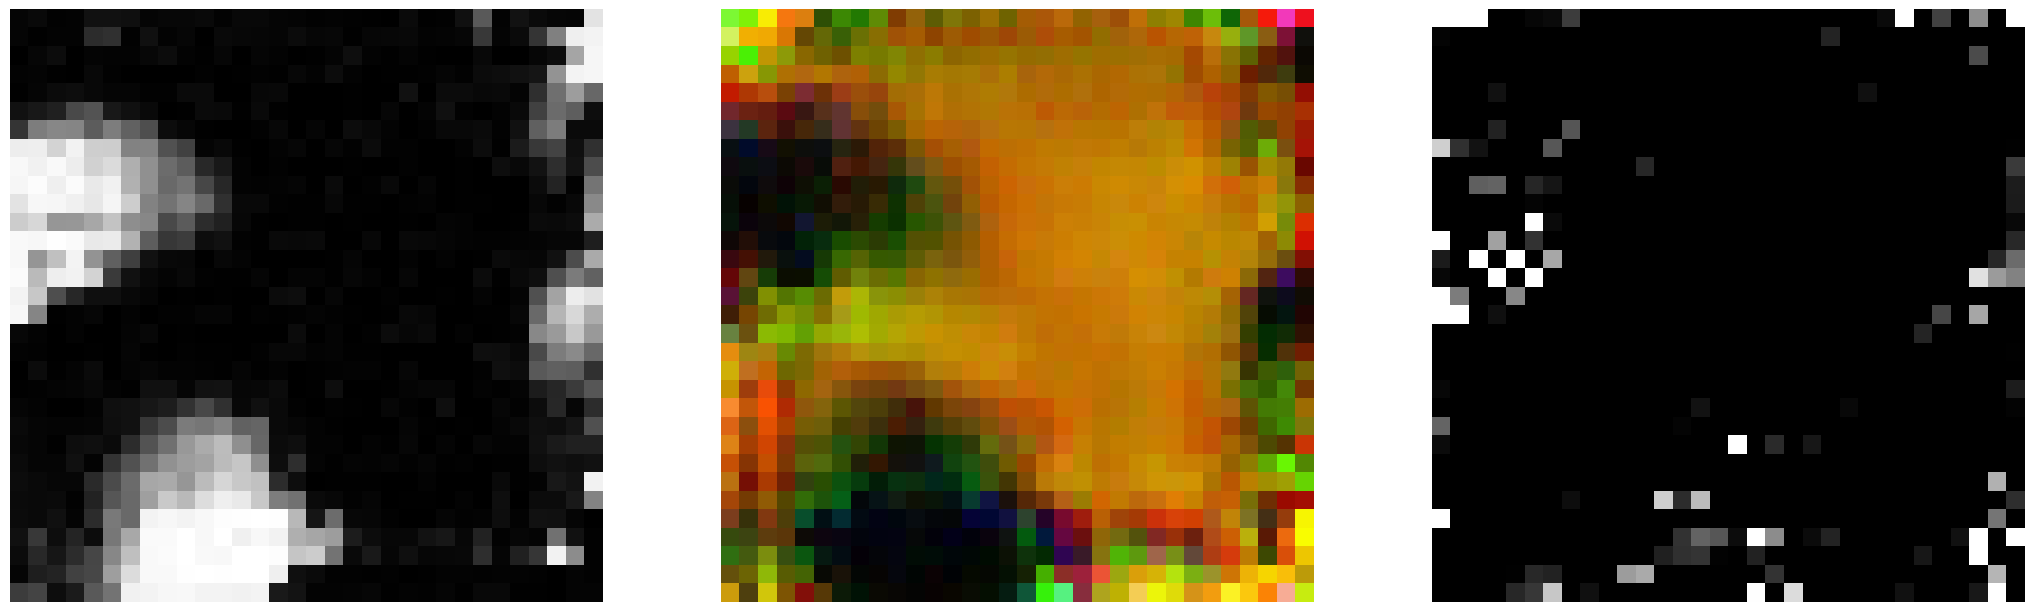

350 0.0101


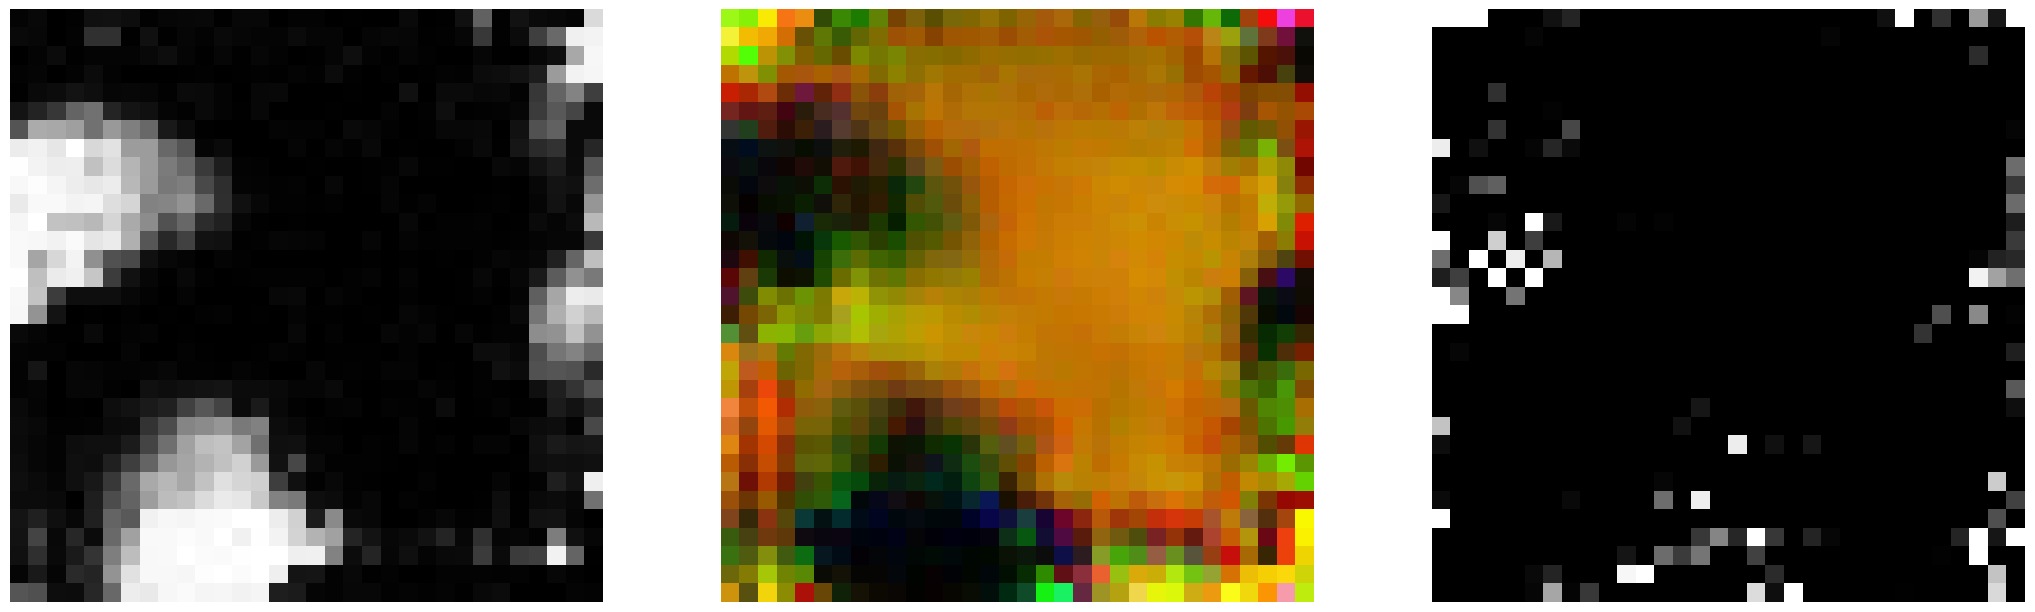

400 0.0118


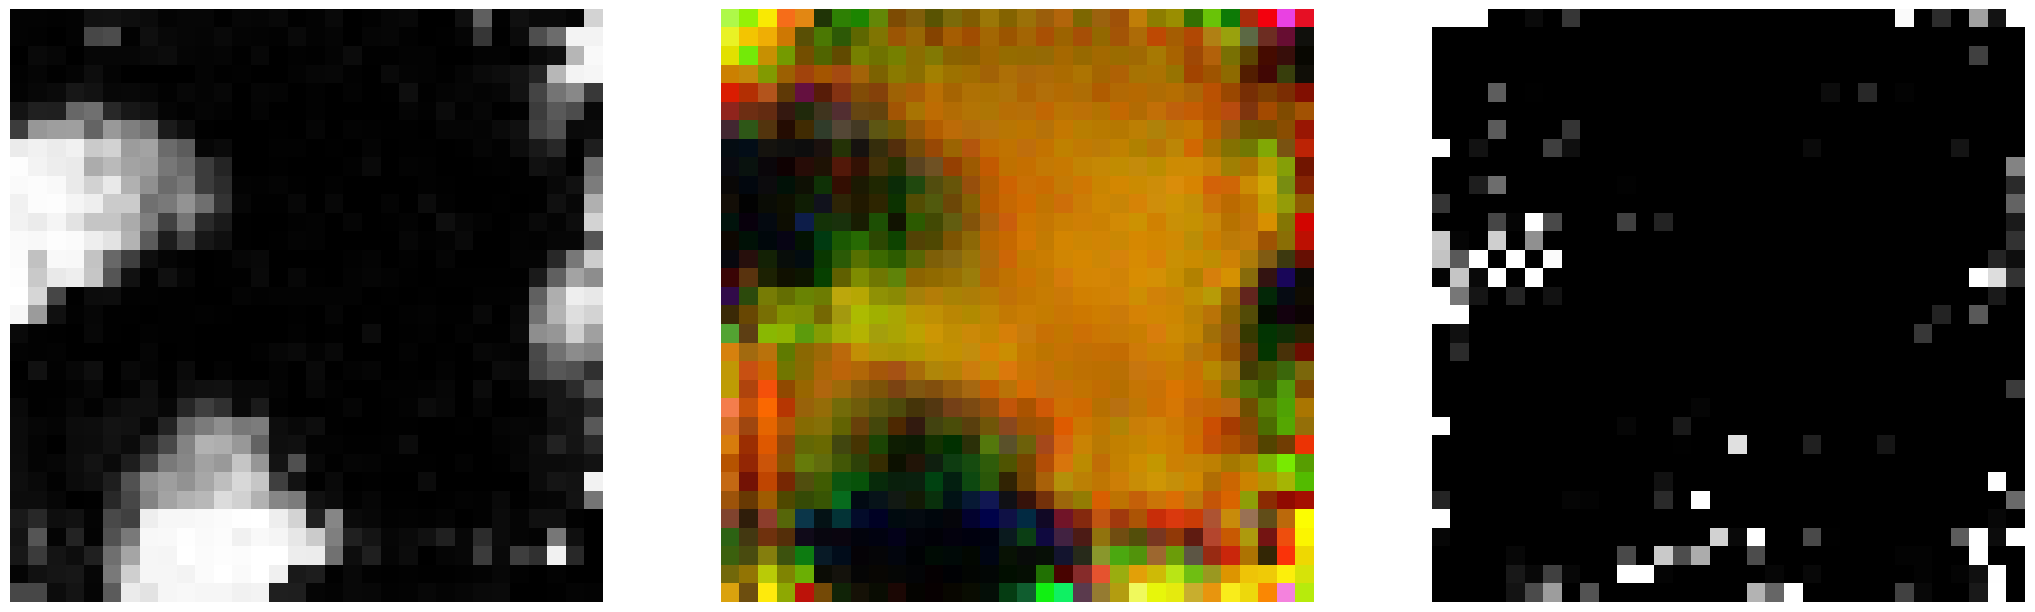

450 0.0109


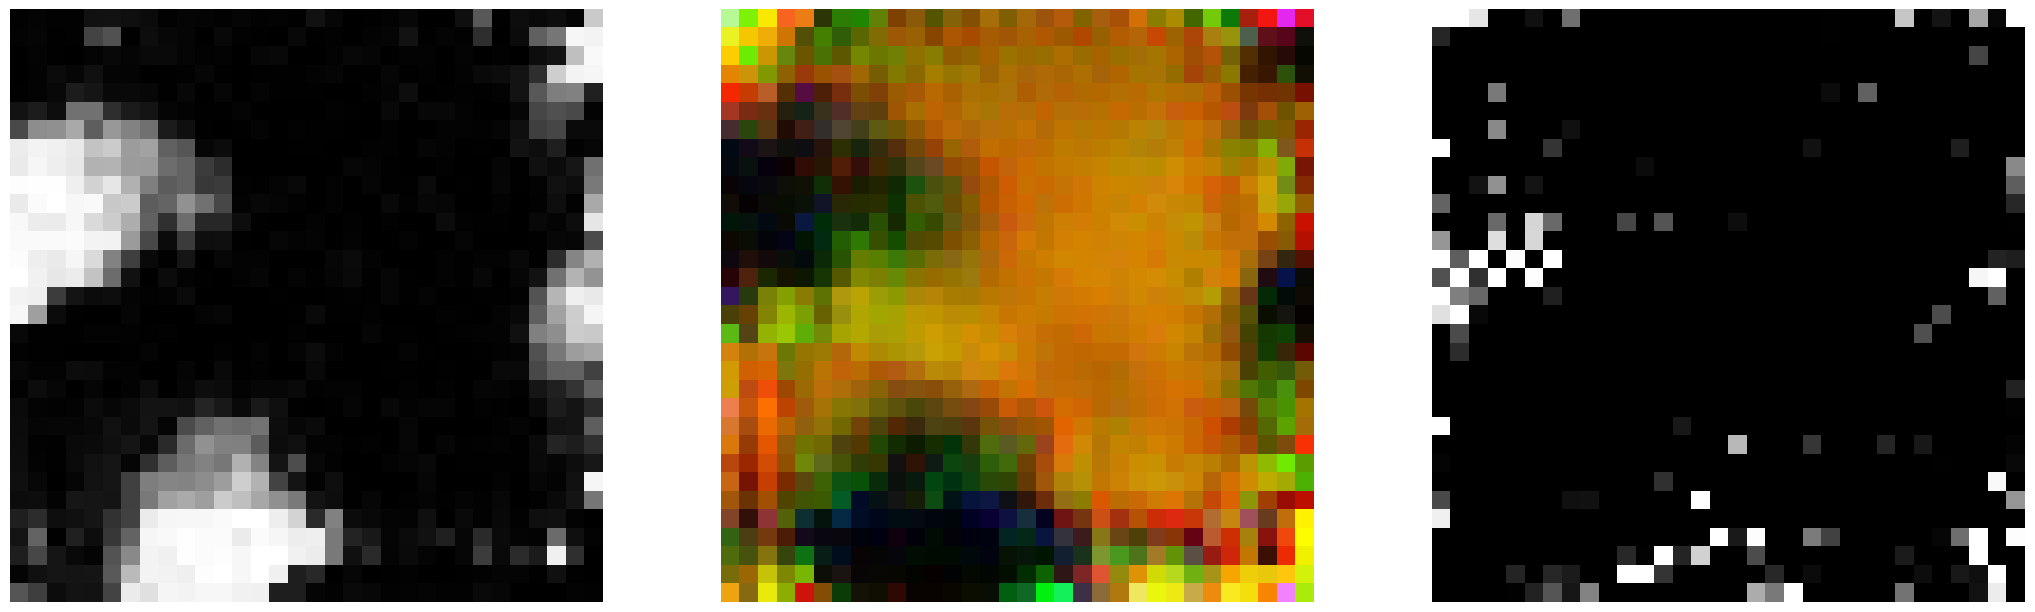

0 0.0111


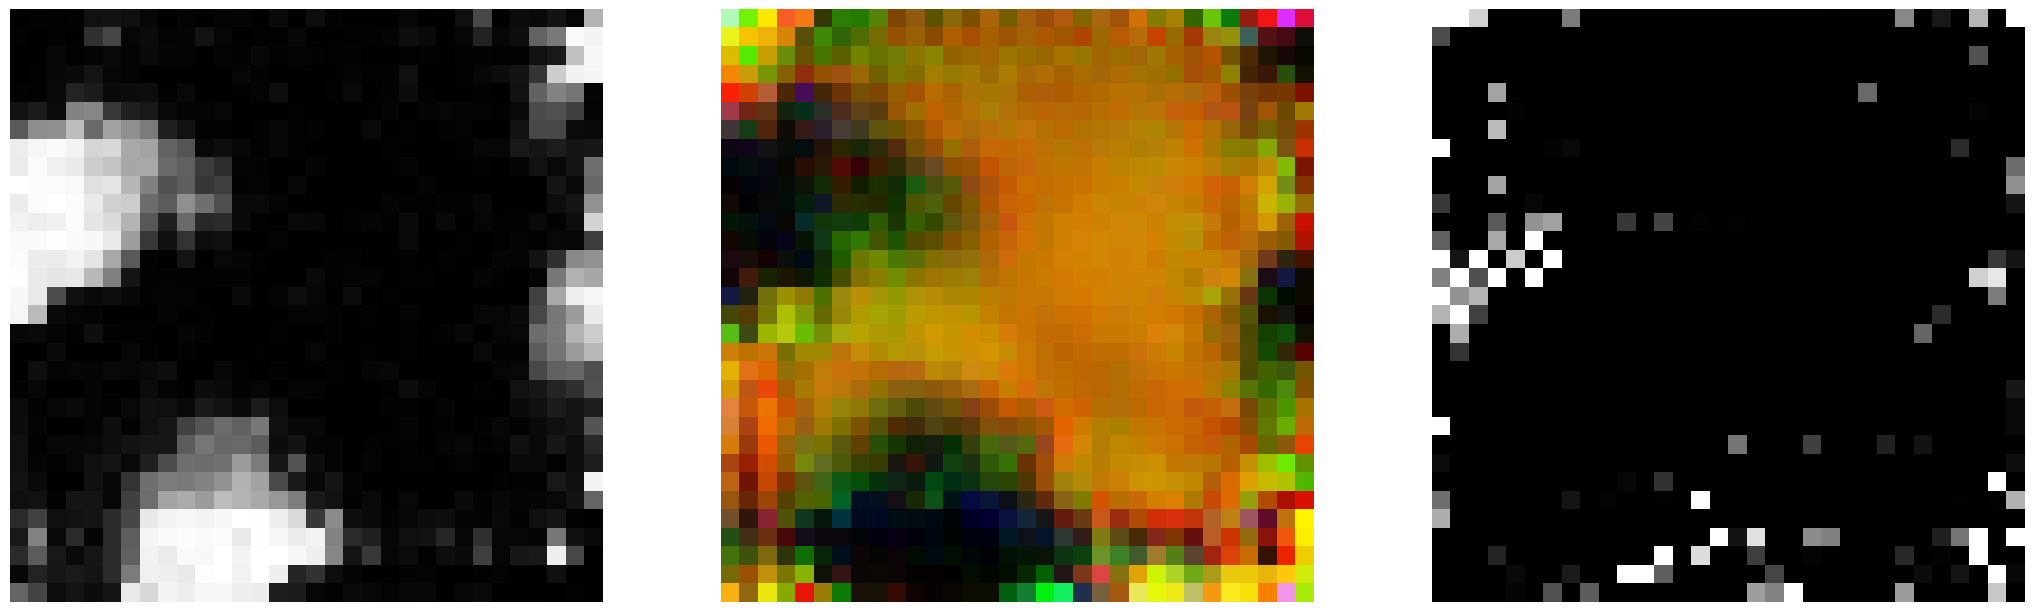

50 0.0112


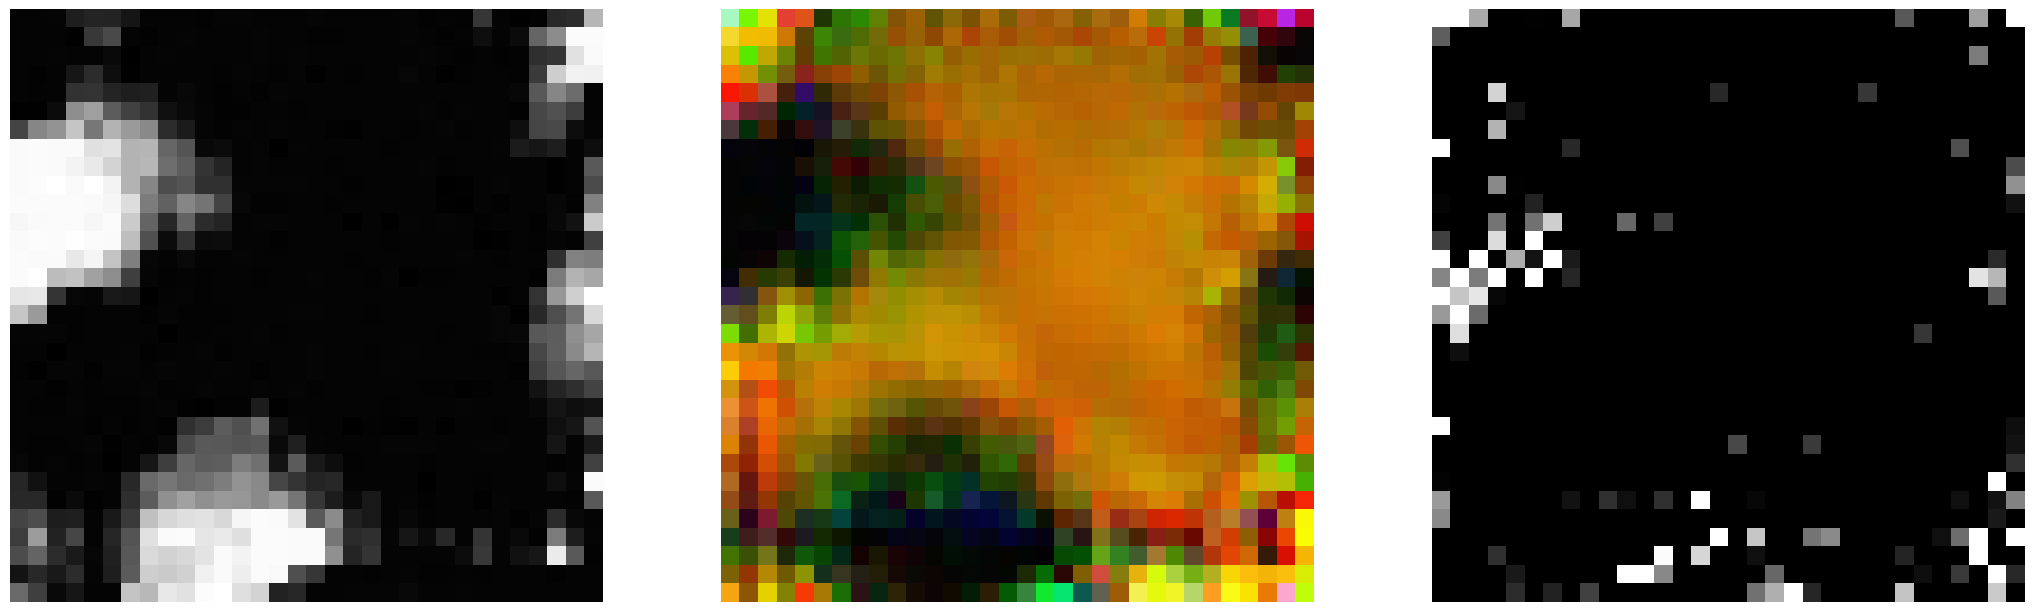

100 0.0117


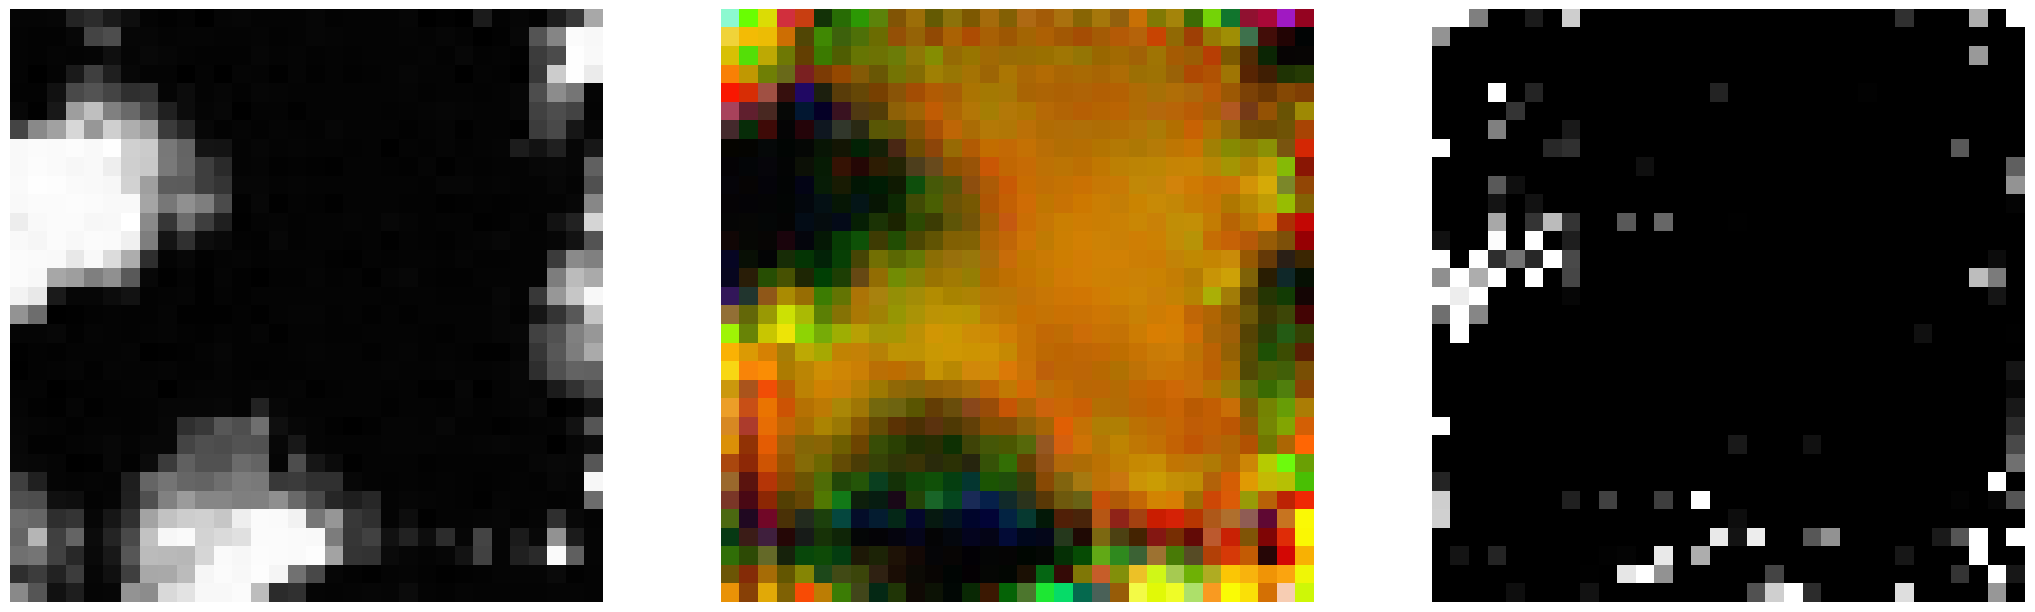

150 0.0132


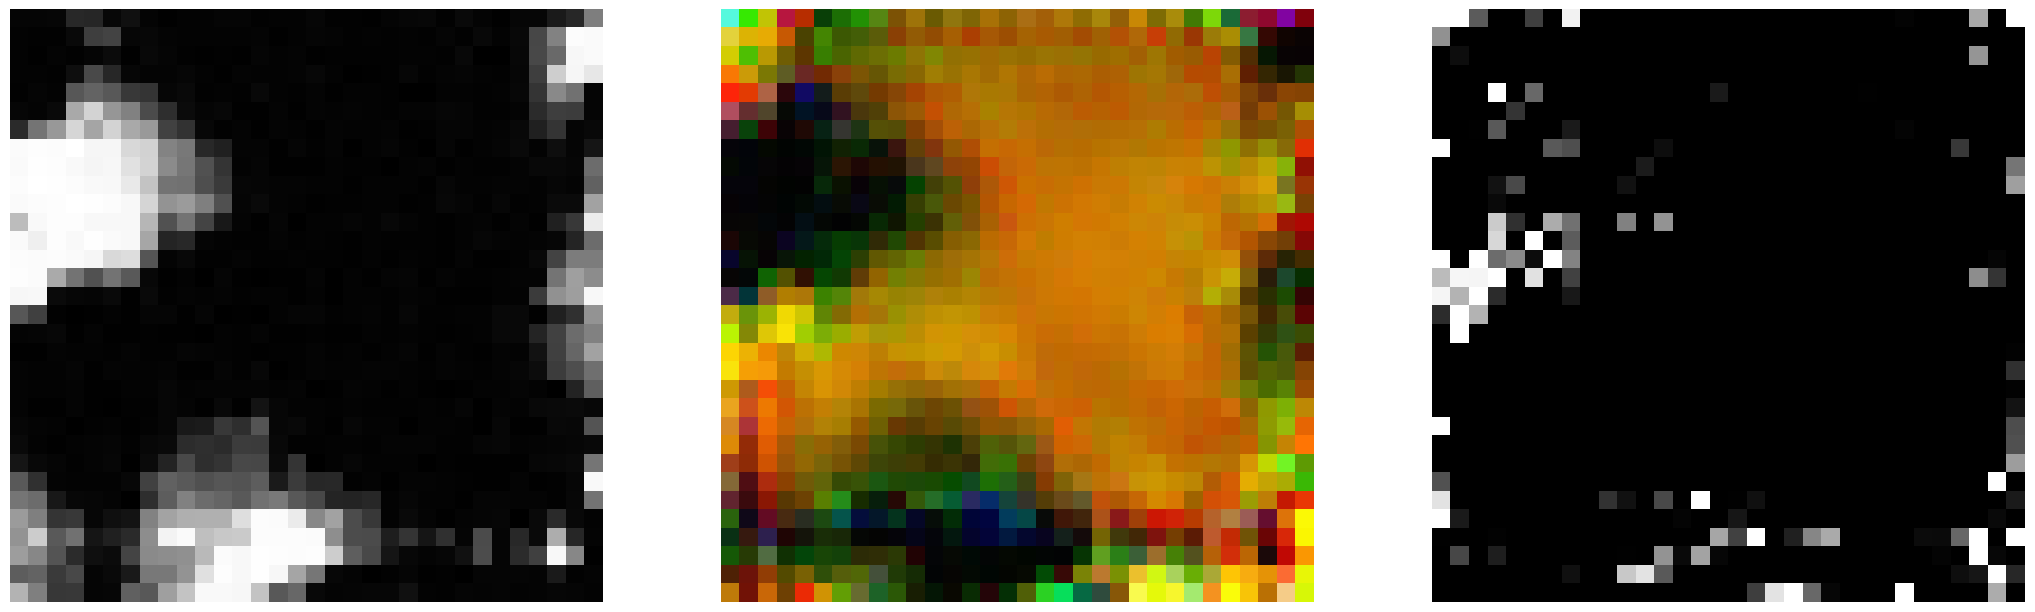

200 0.0117


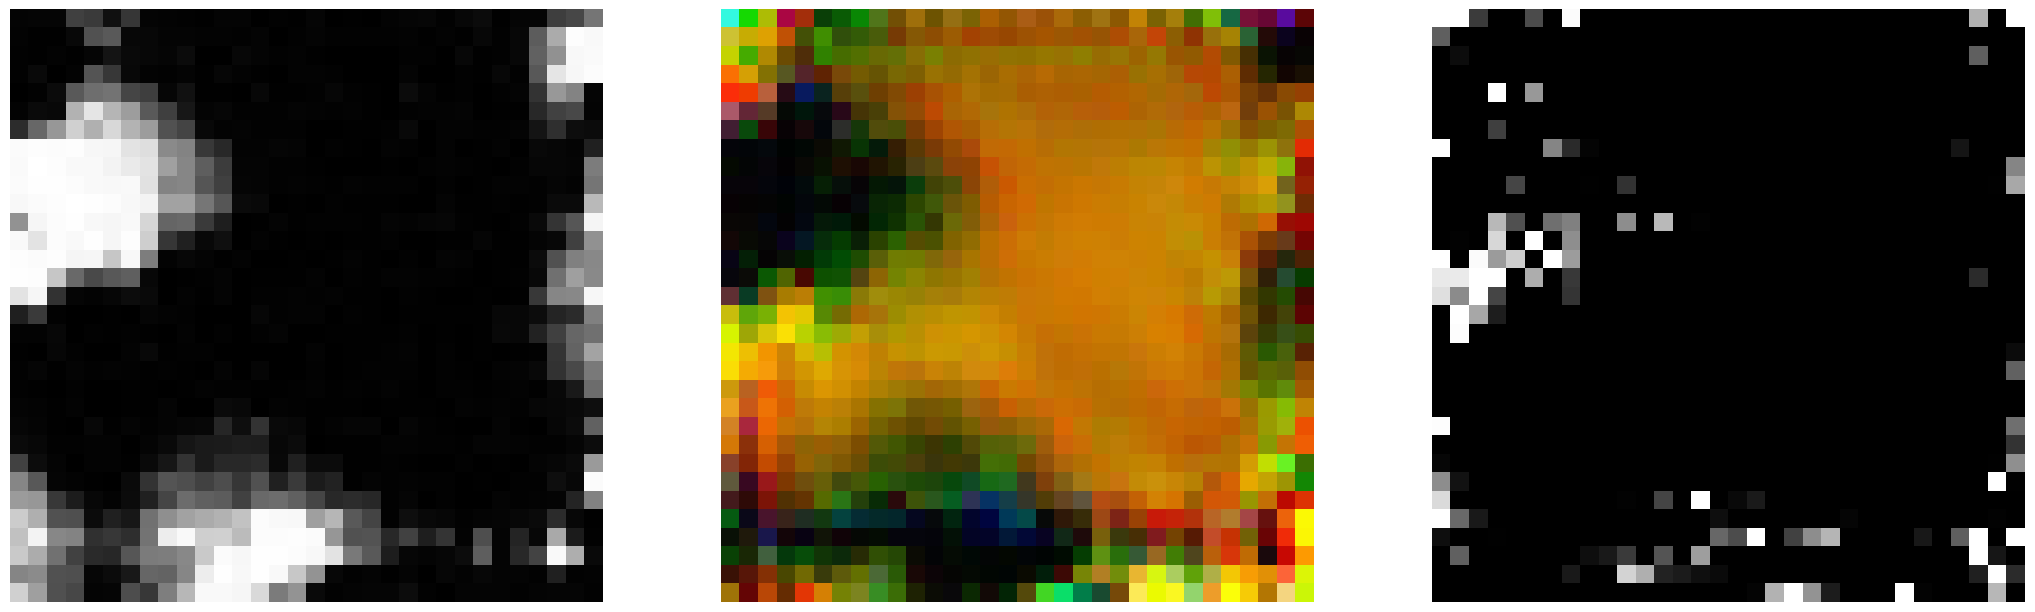

250 0.0121


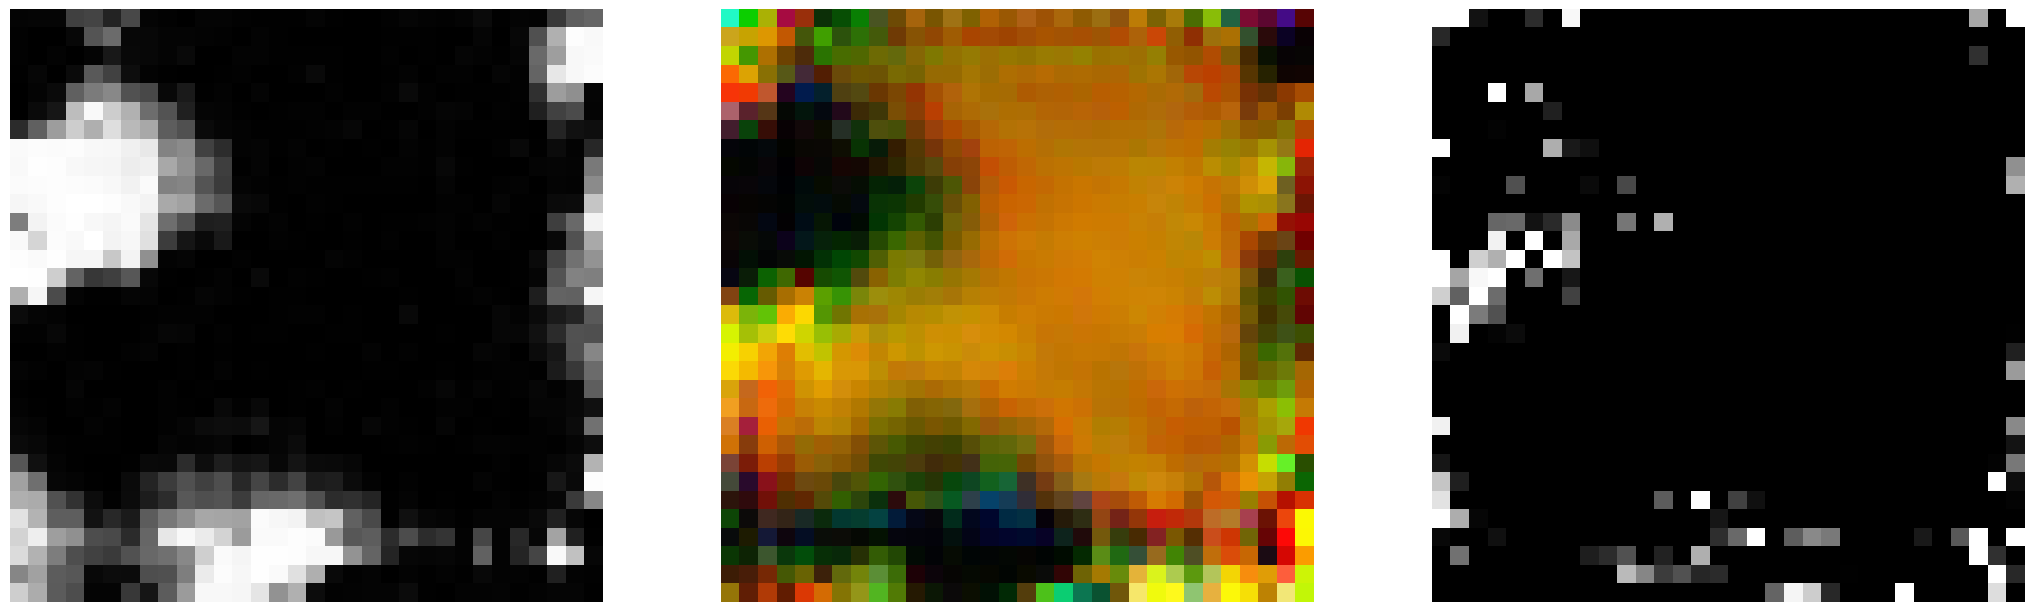

300 0.0129


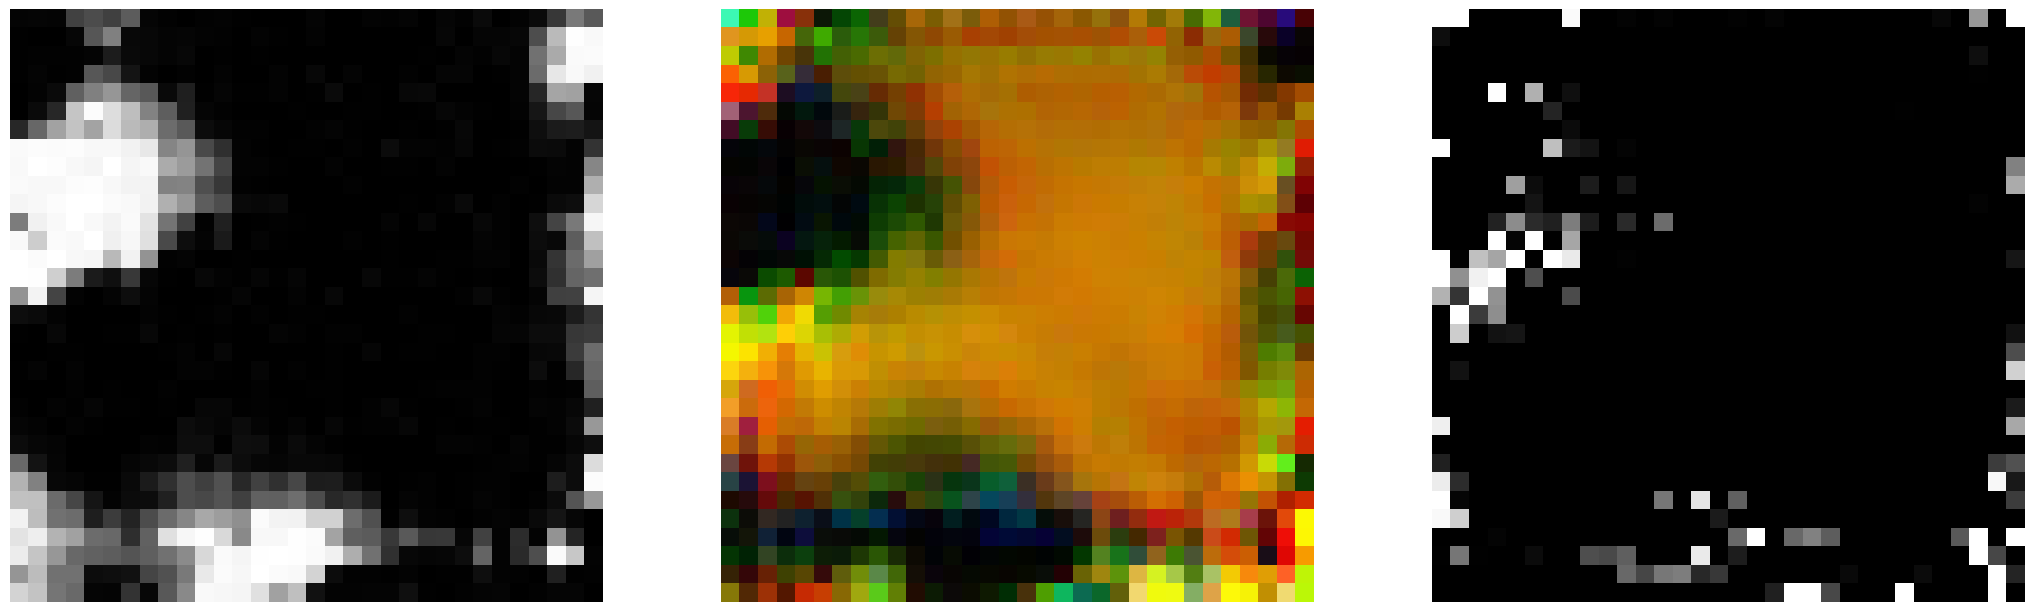

350 0.0119


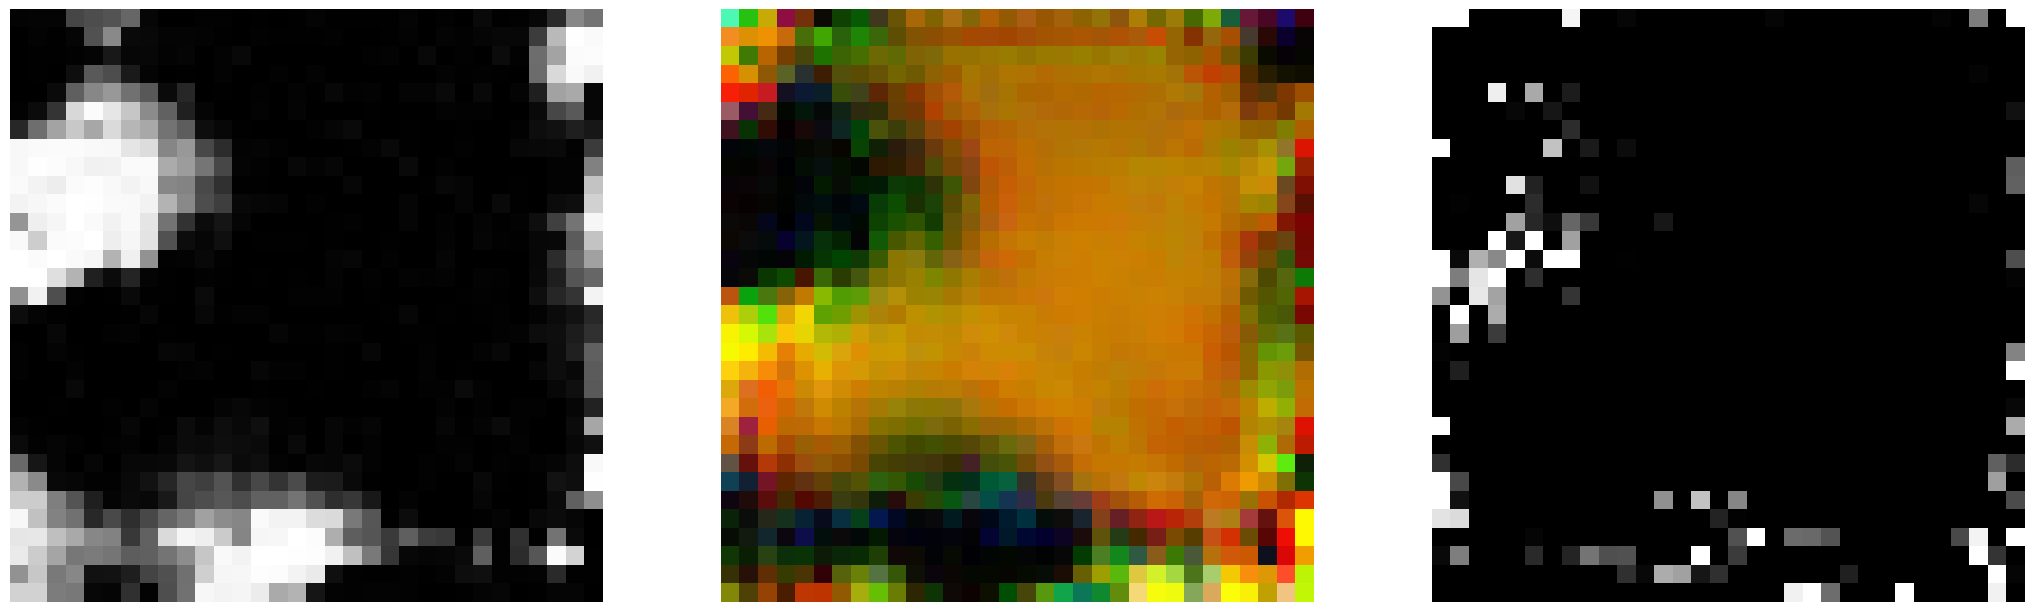

400 0.0112


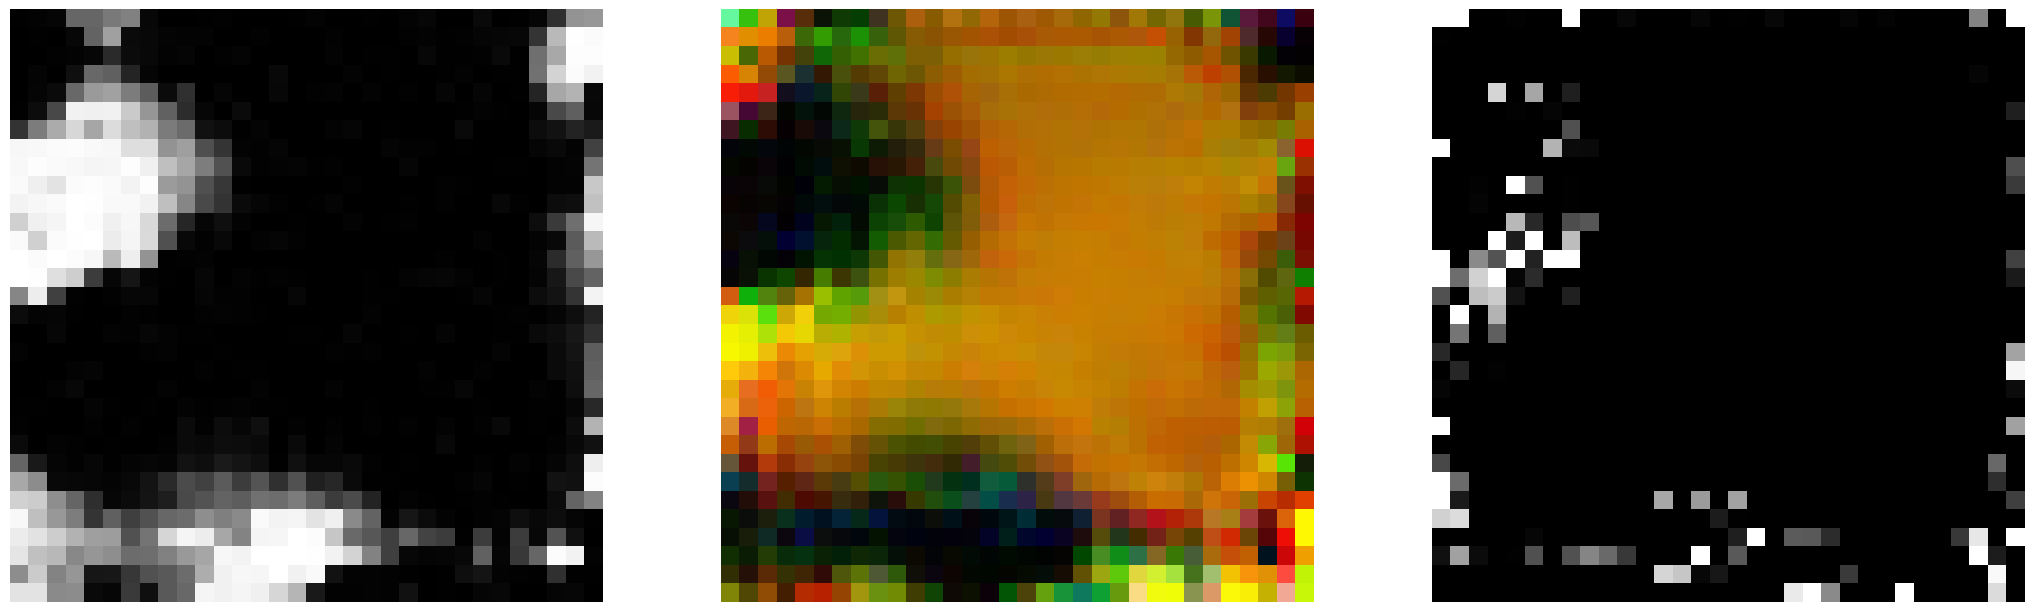

450 0.0111


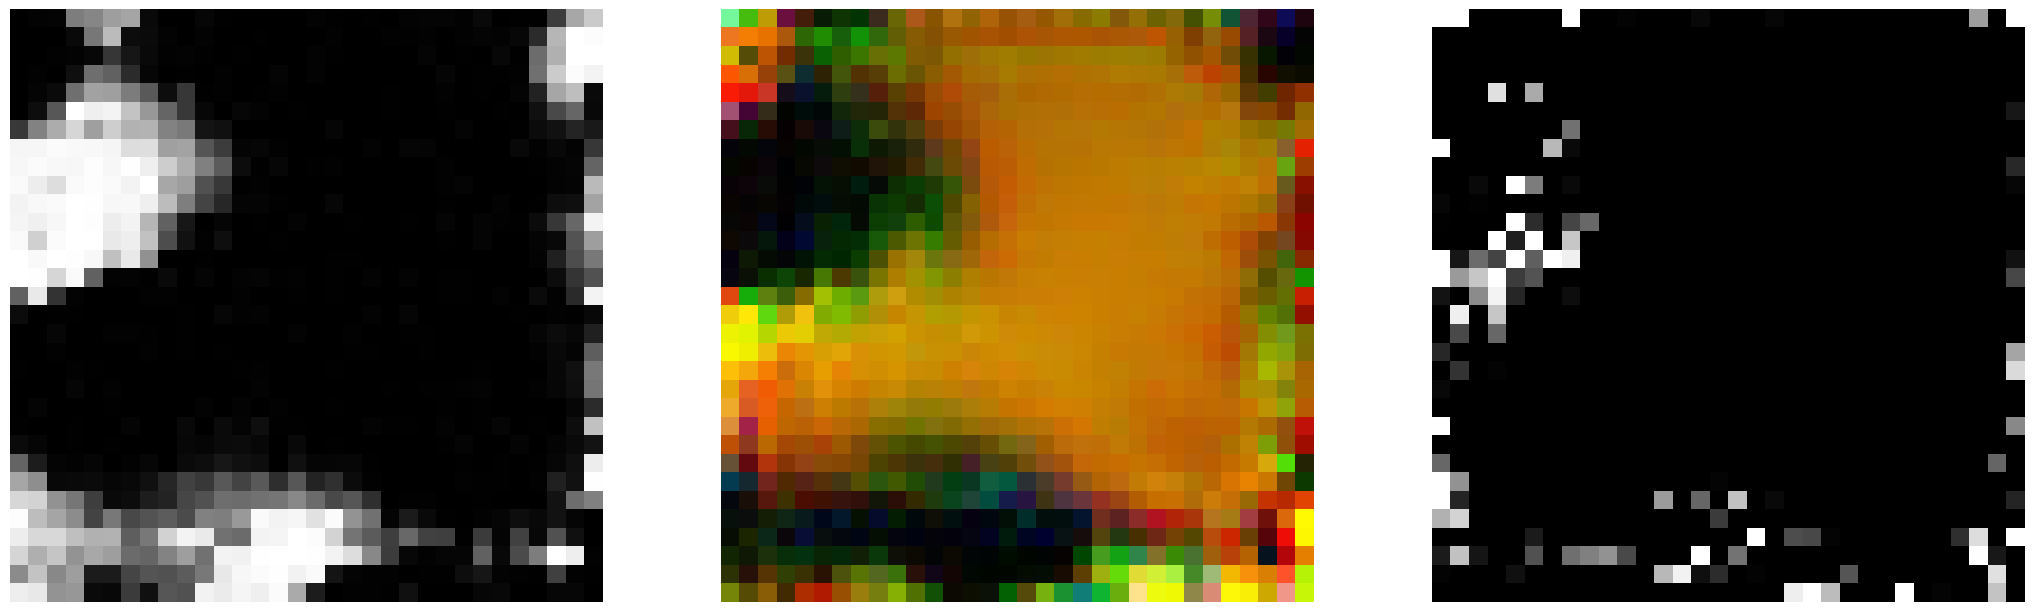

0 0.0116


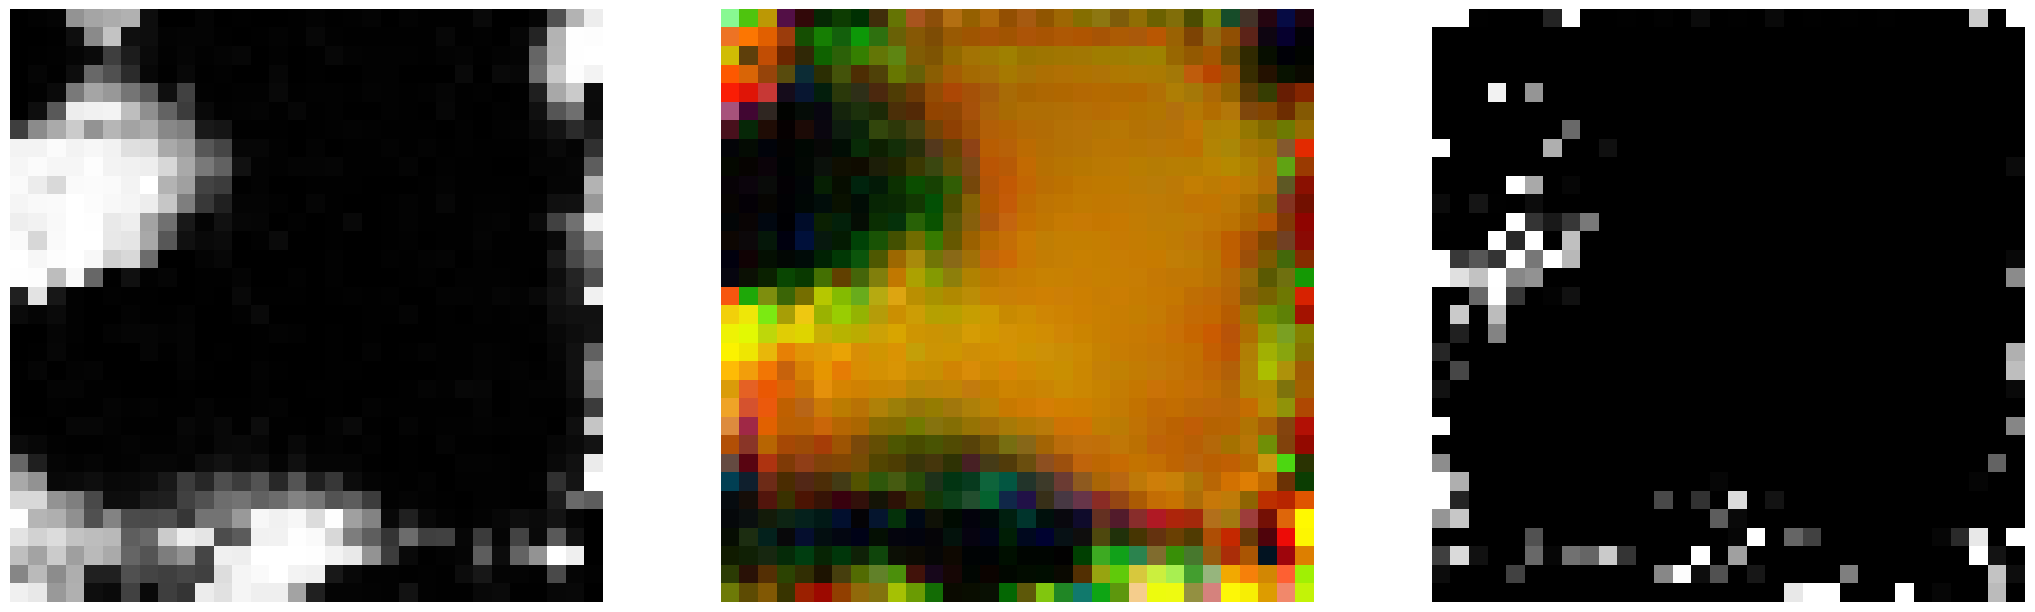

50 0.0112


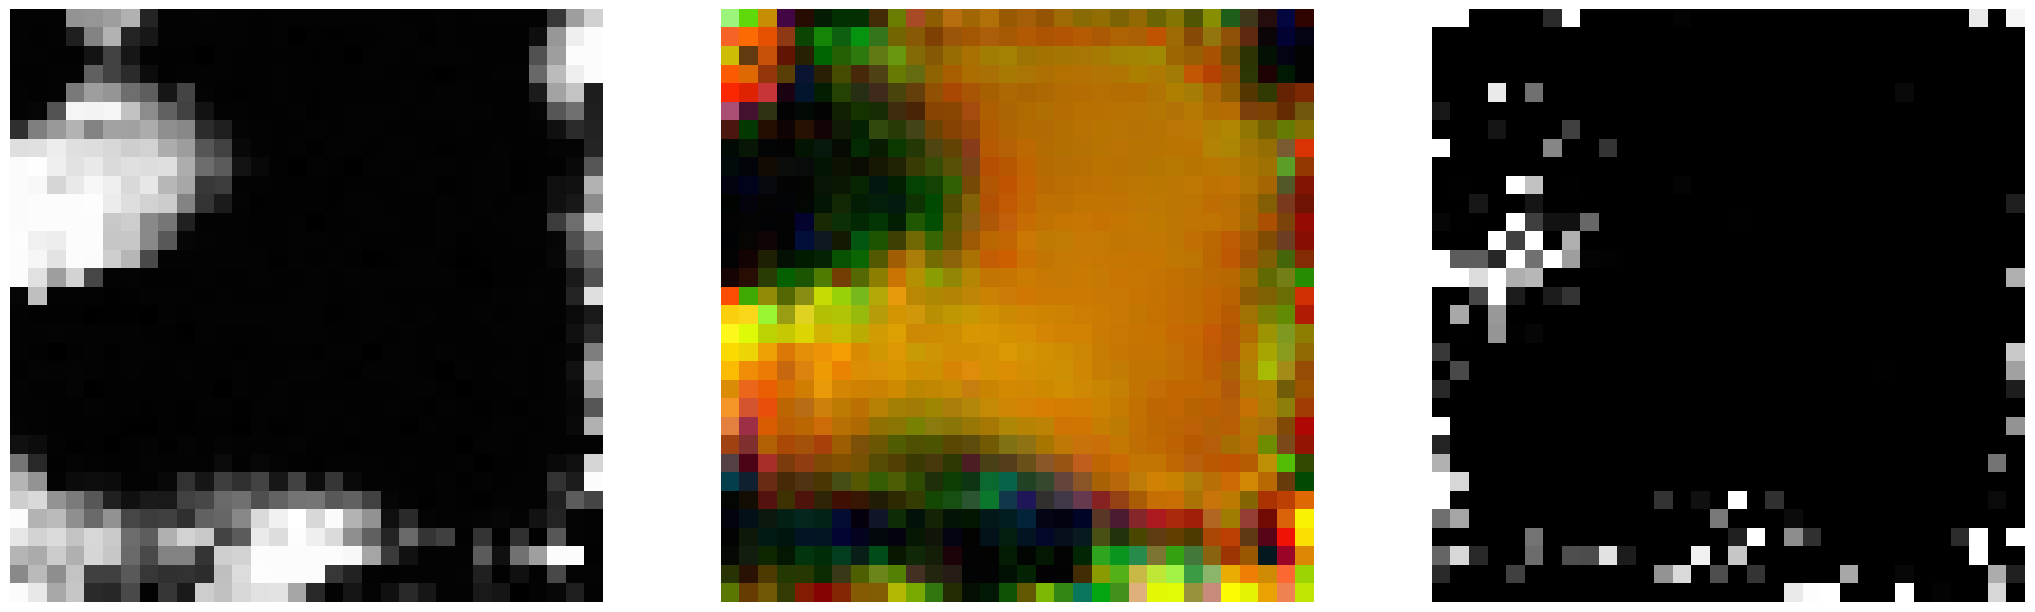

100 0.0103


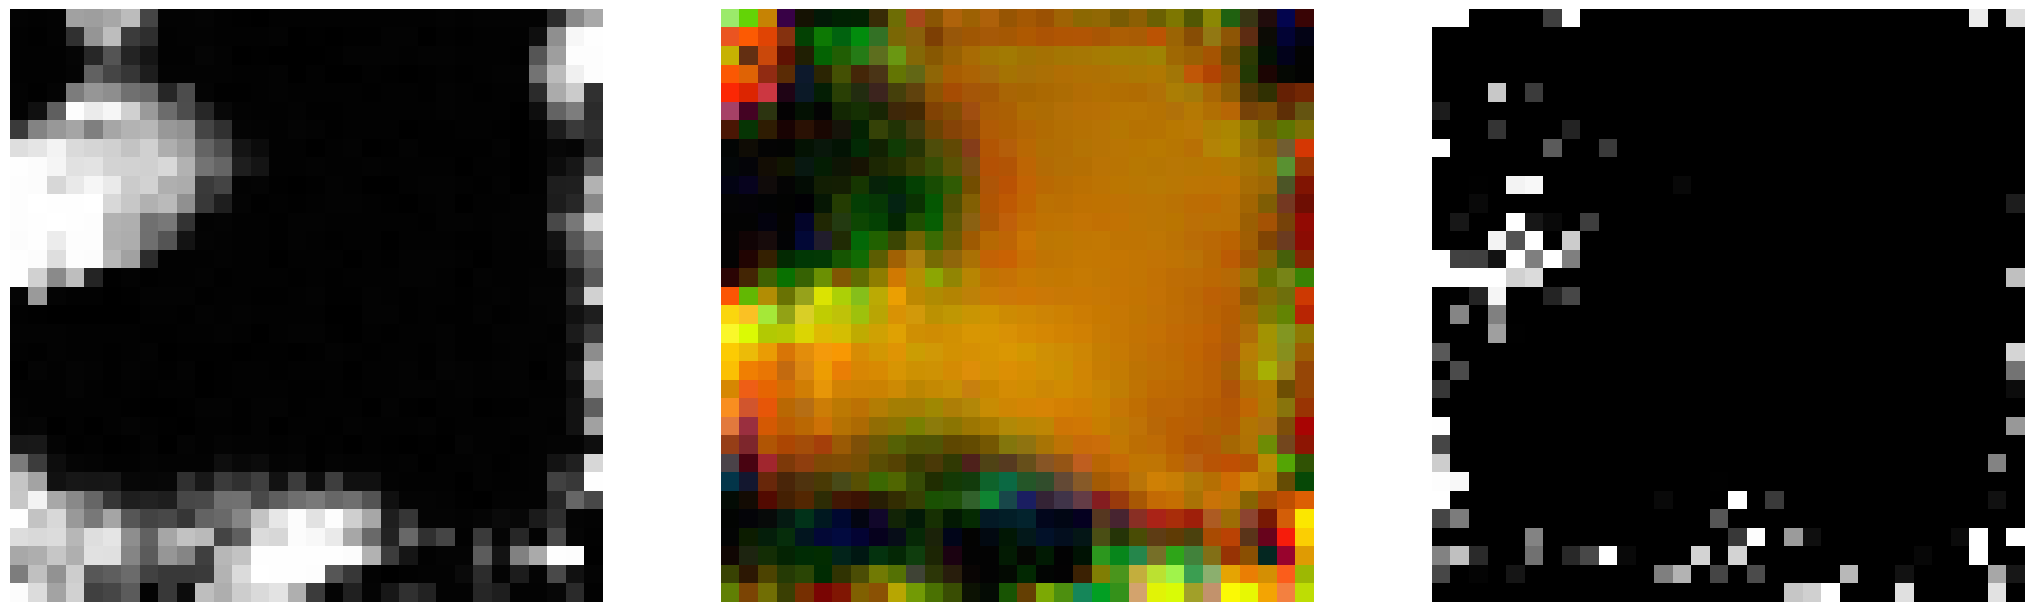

150 0.0115


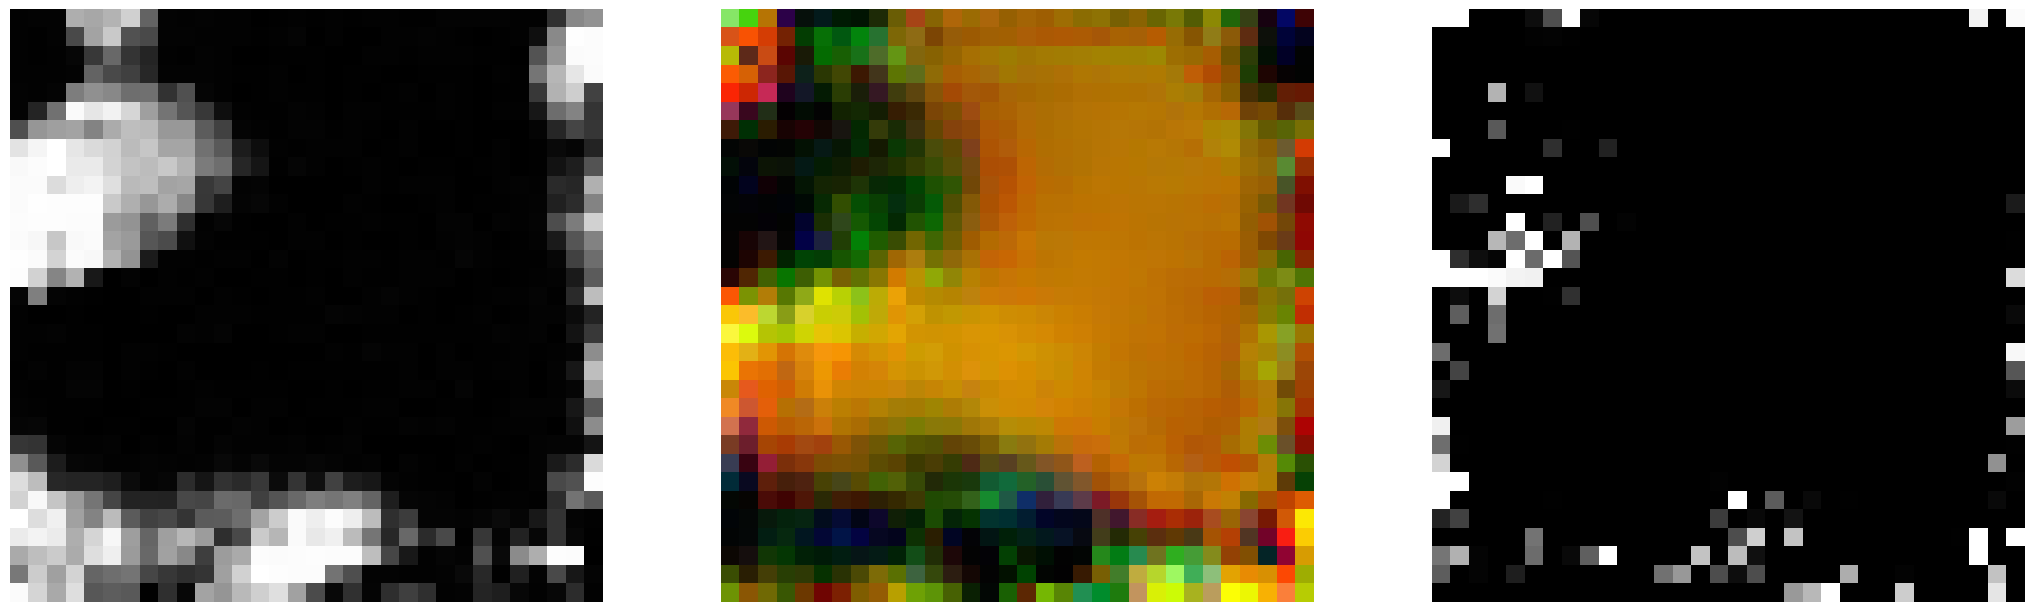

200 0.0119


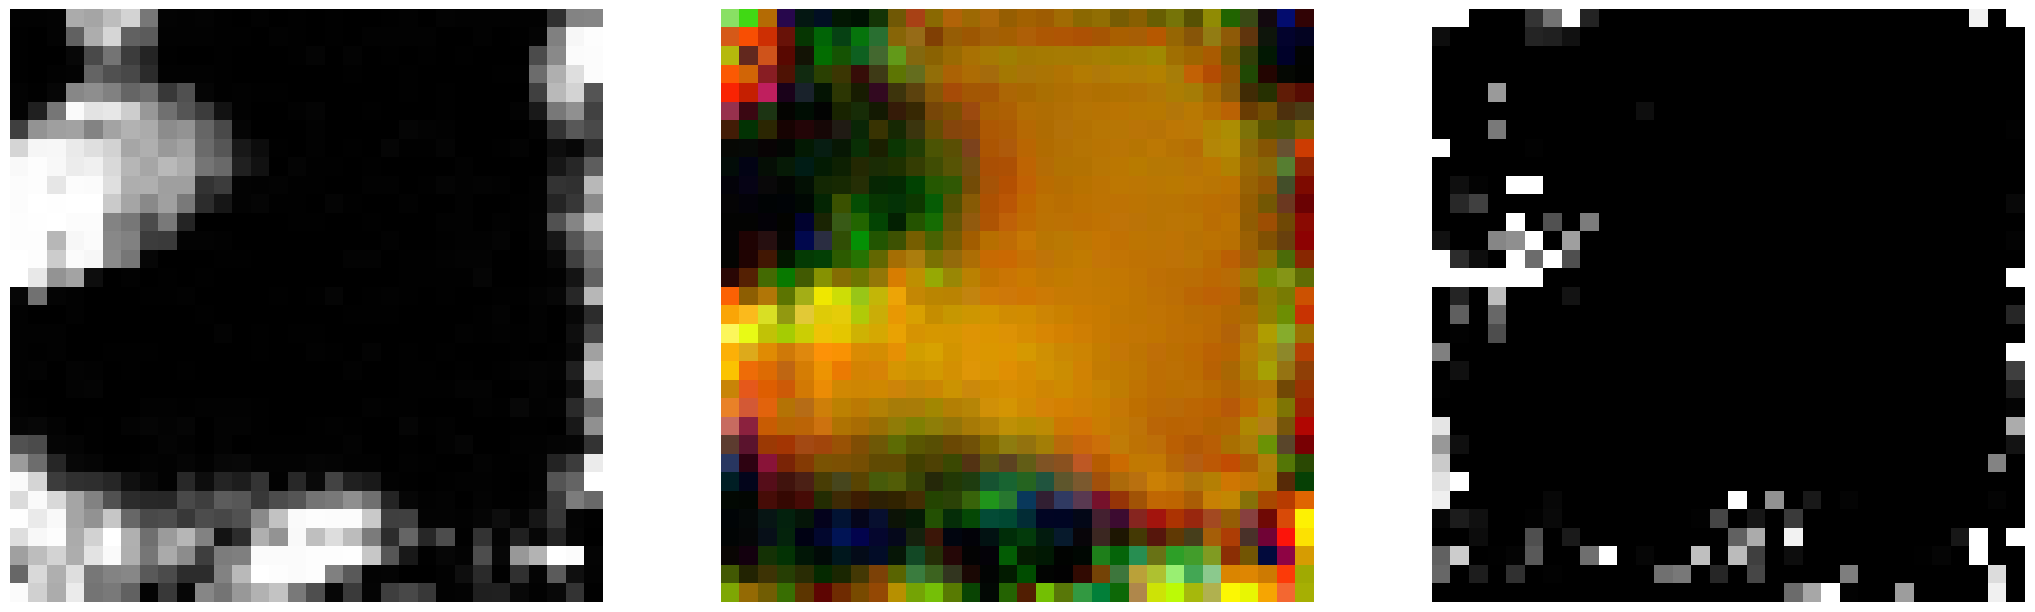

250 0.0113


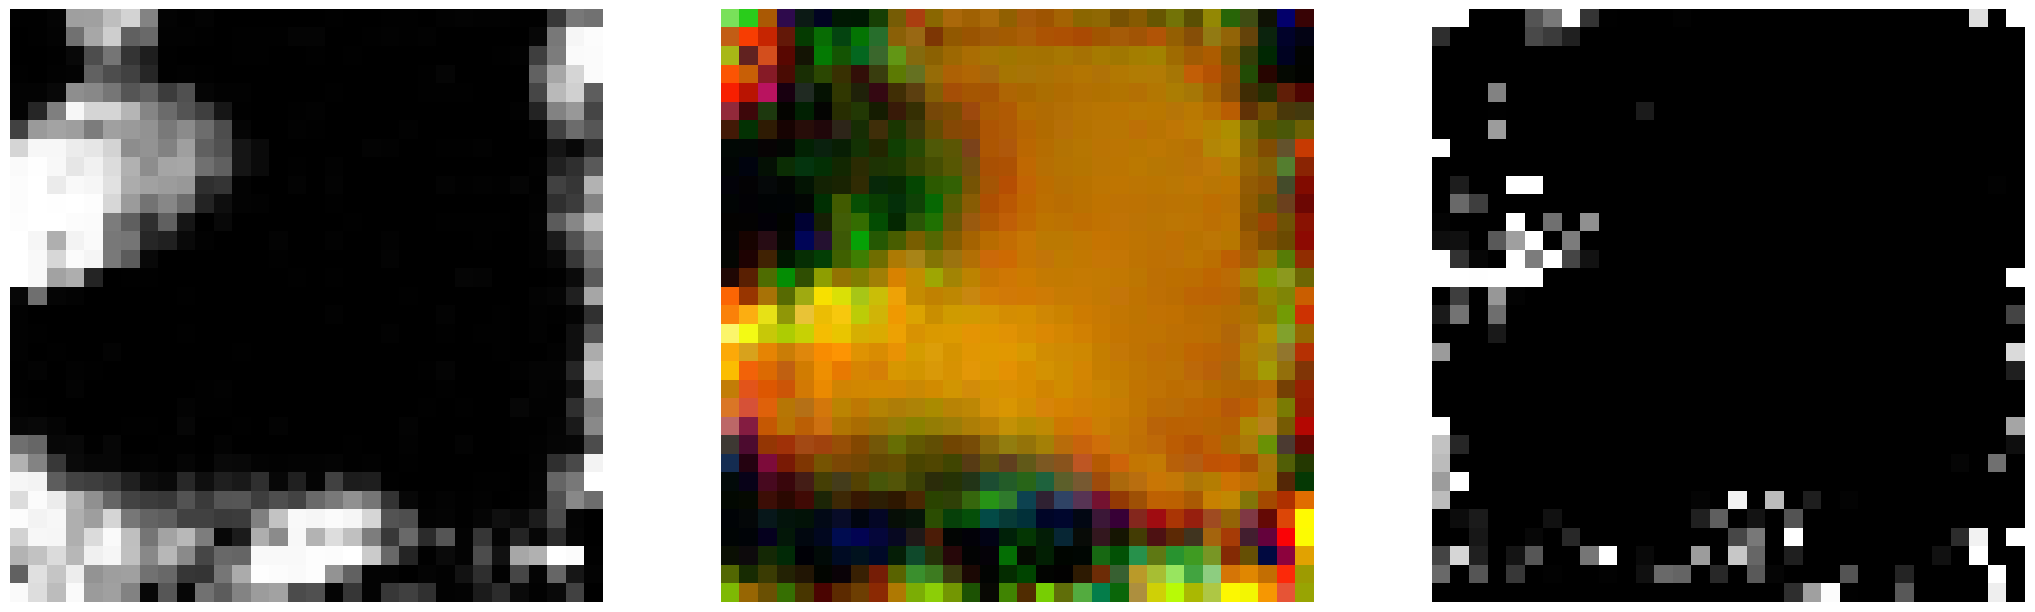

300 0.0124


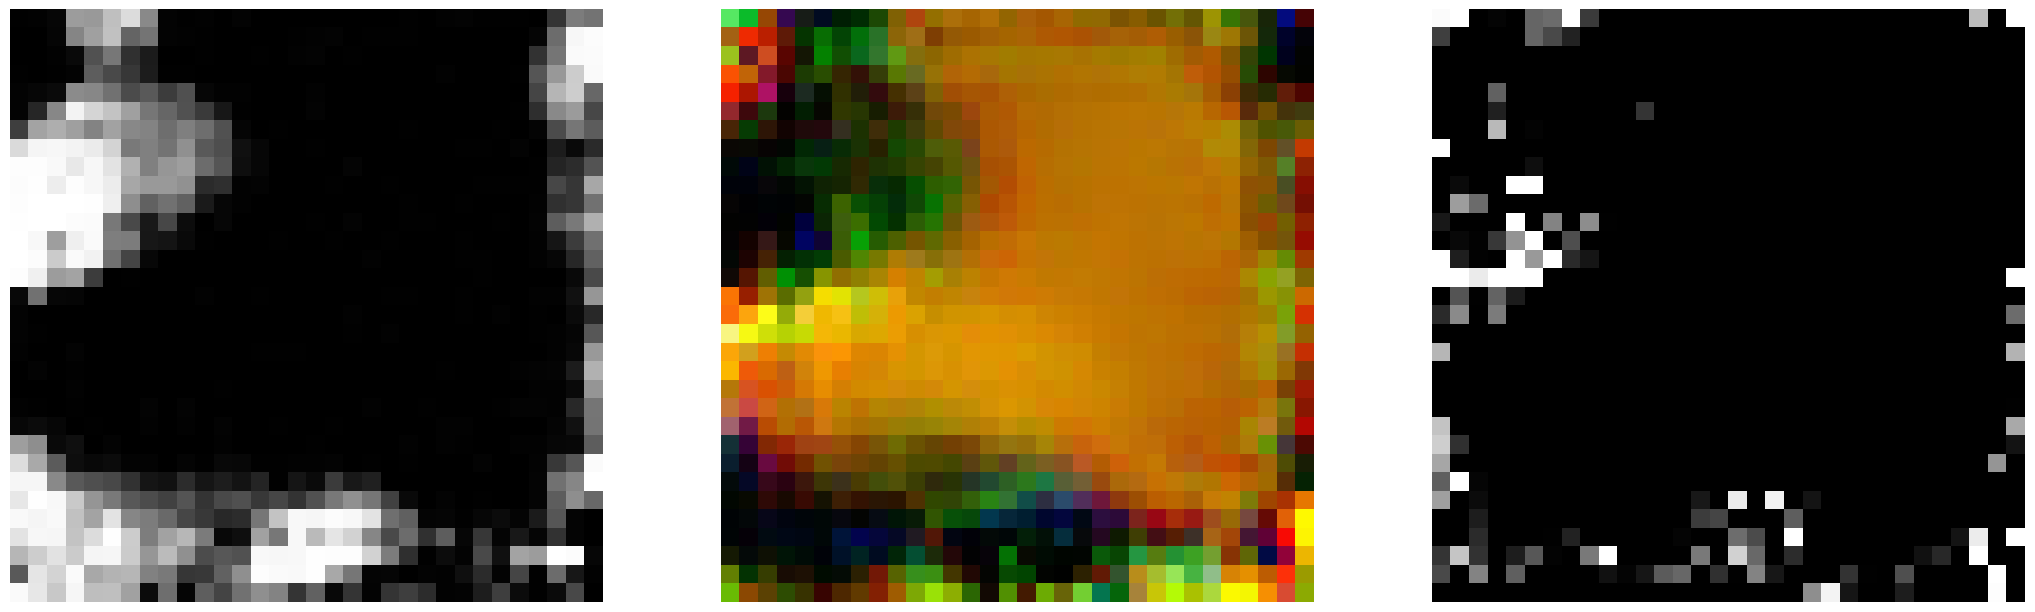

350 0.0120


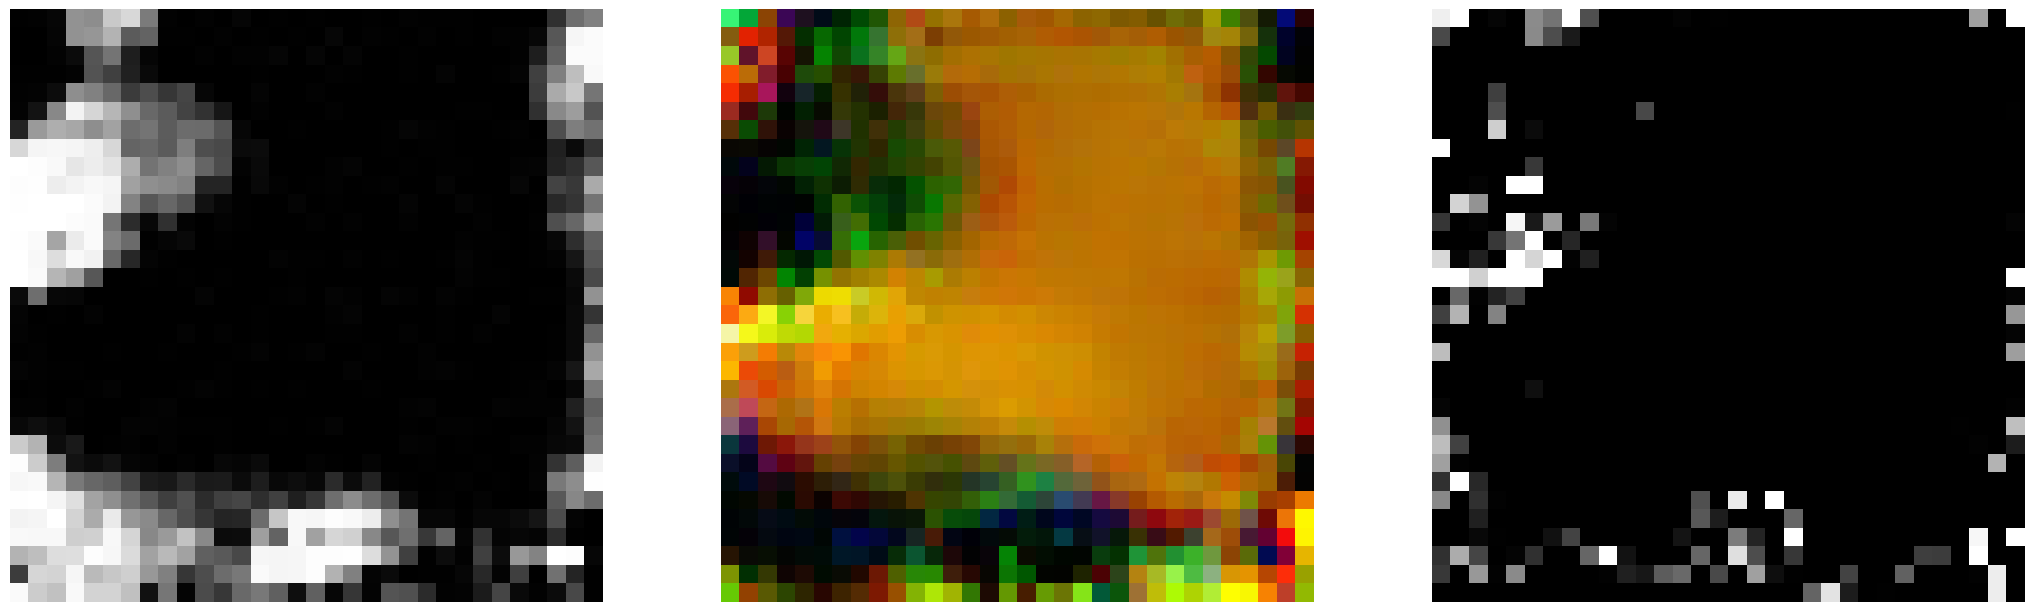

400 0.0123


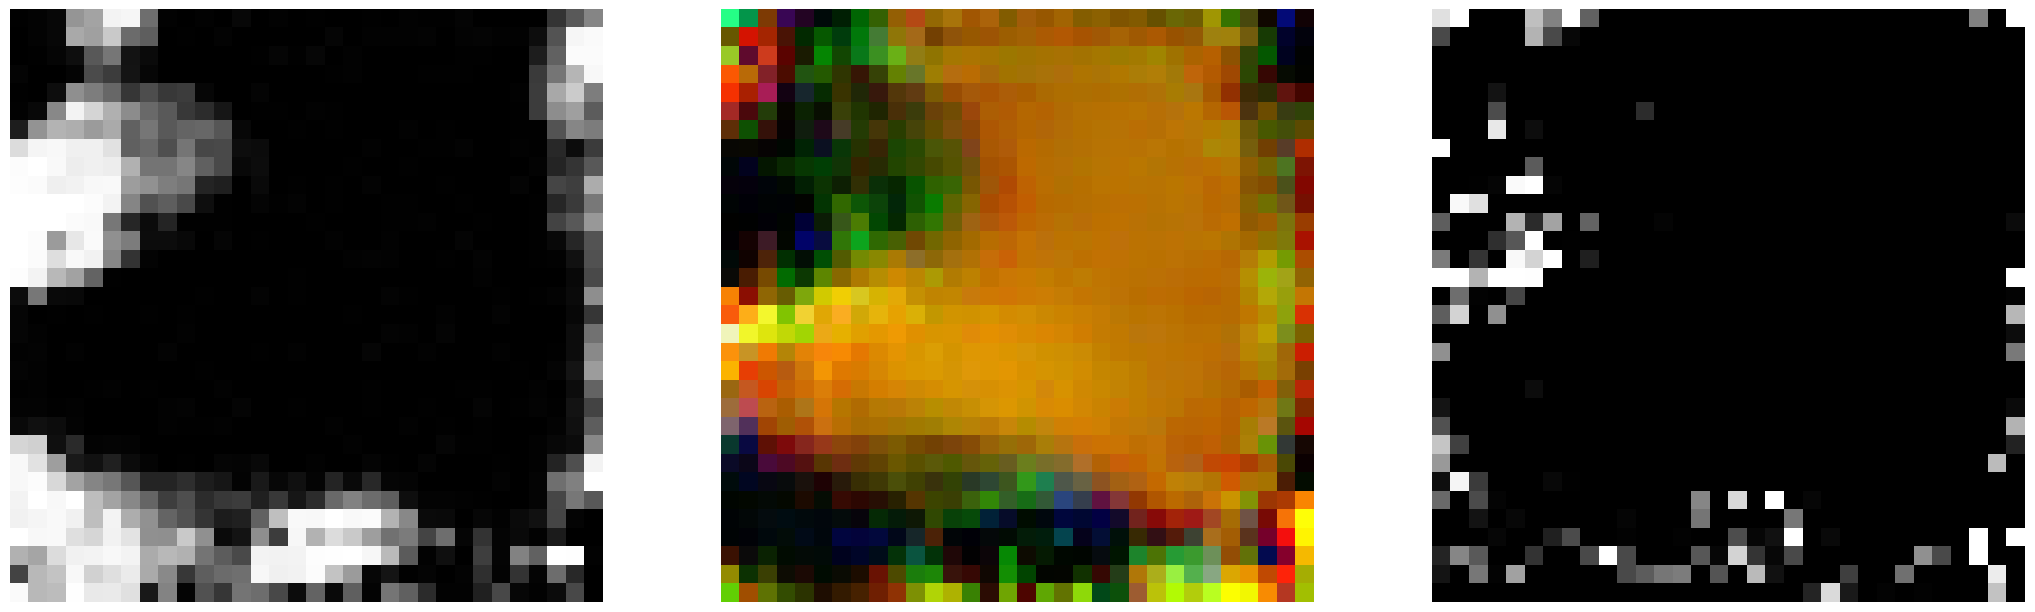

450 0.0115


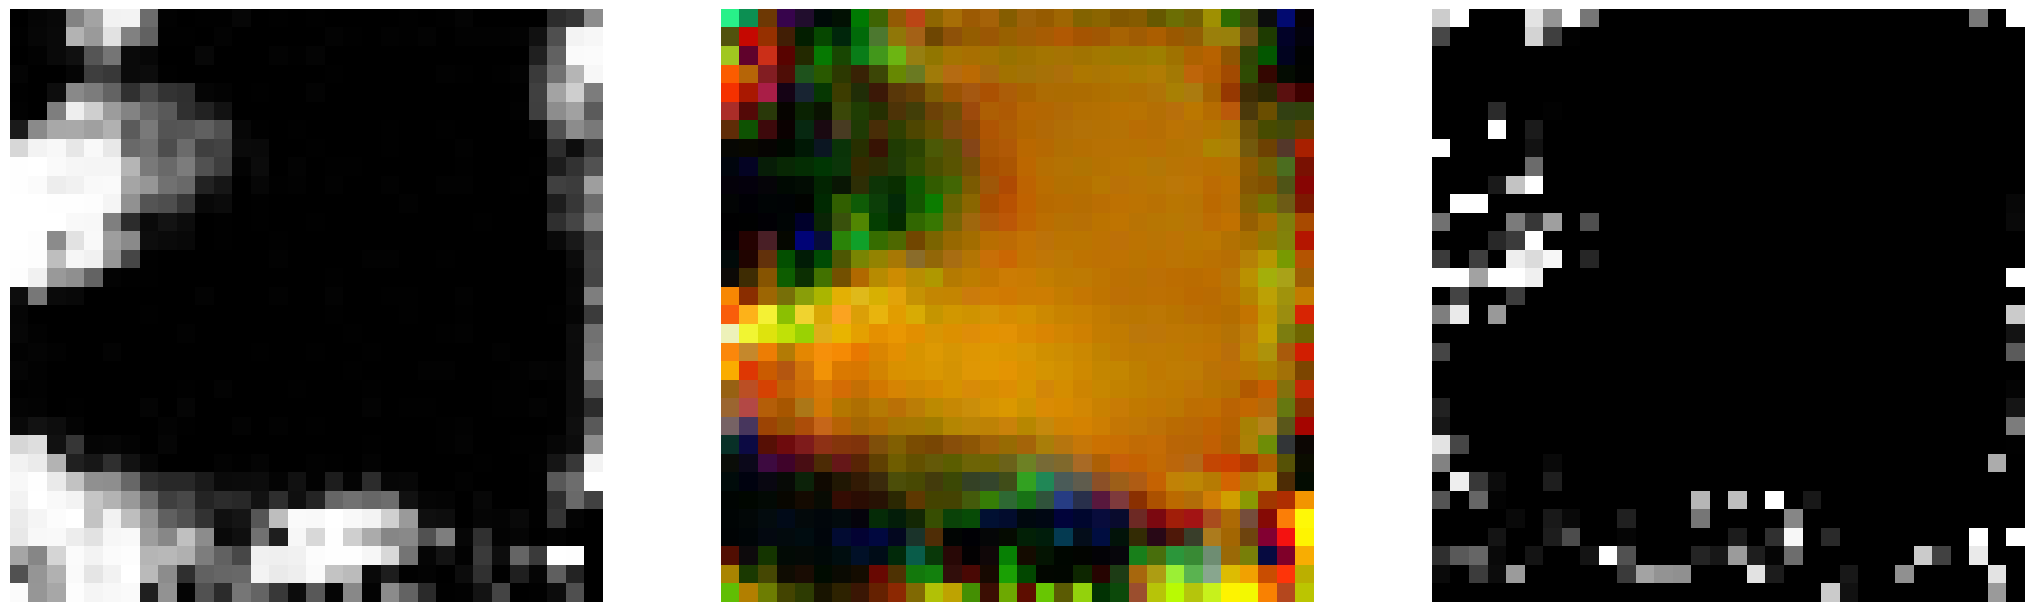

0 0.0146


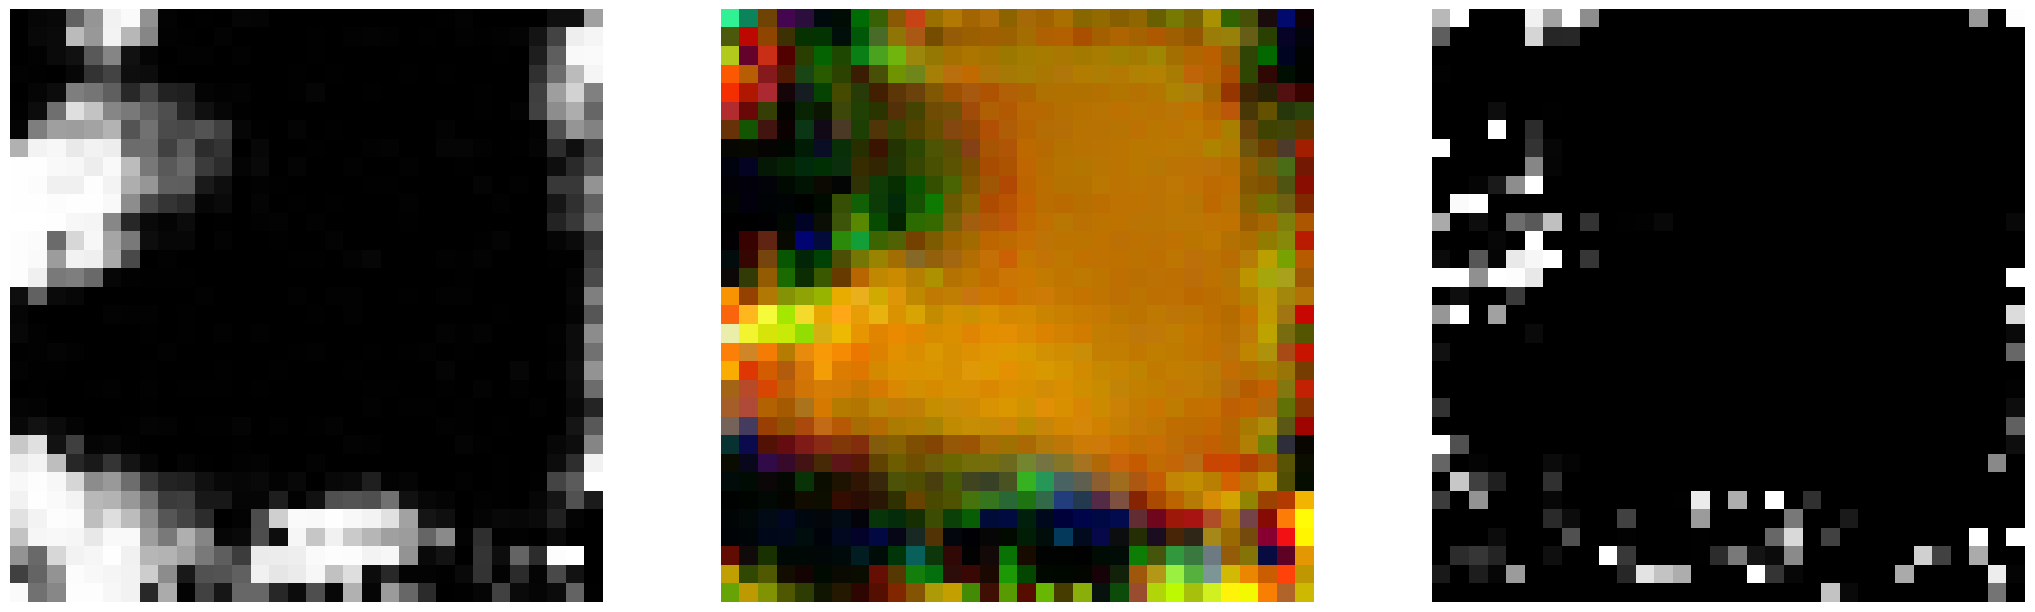

50 0.0139


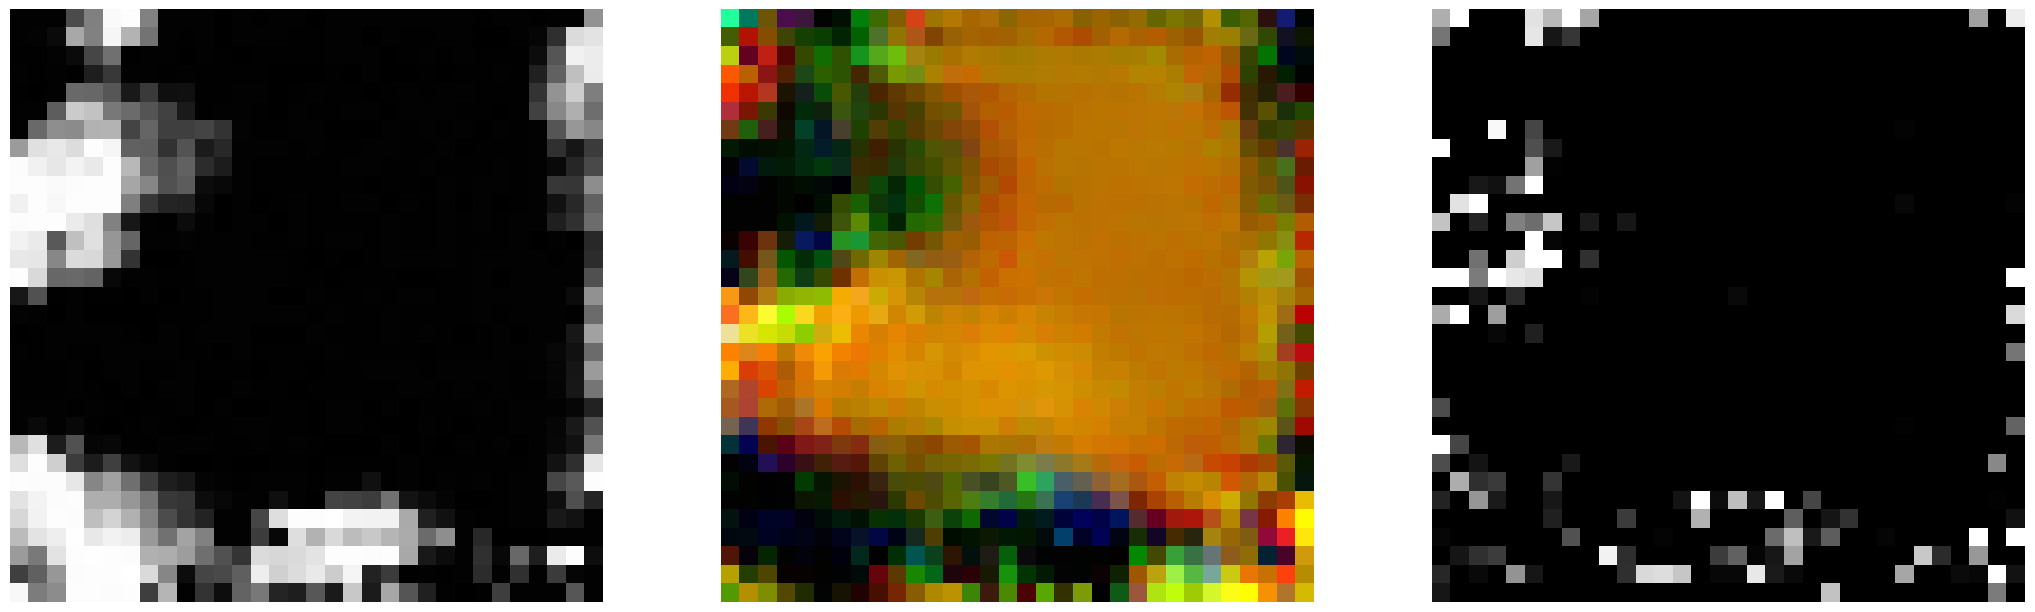

100 0.0143


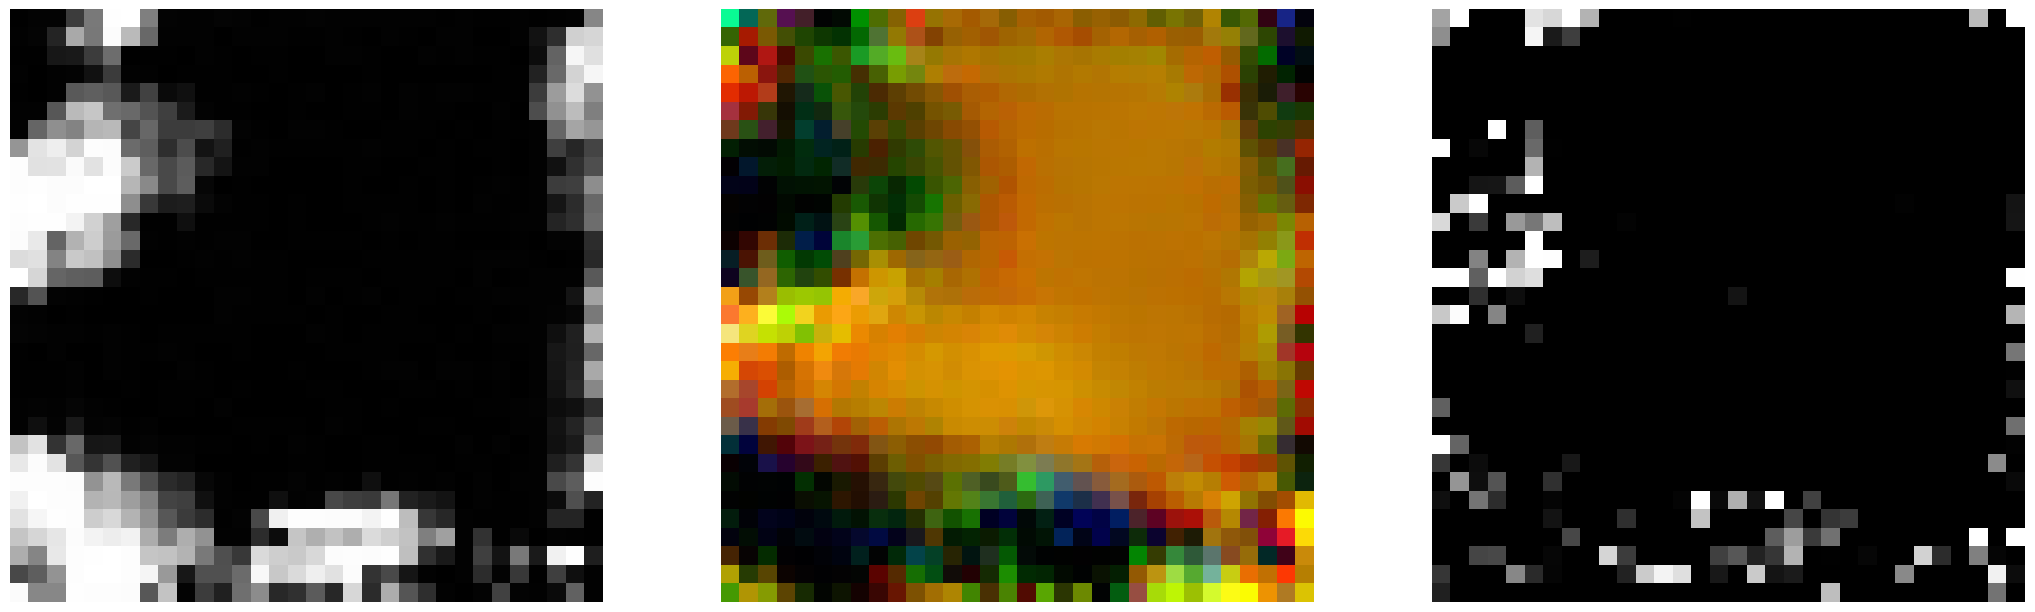

150 0.0140


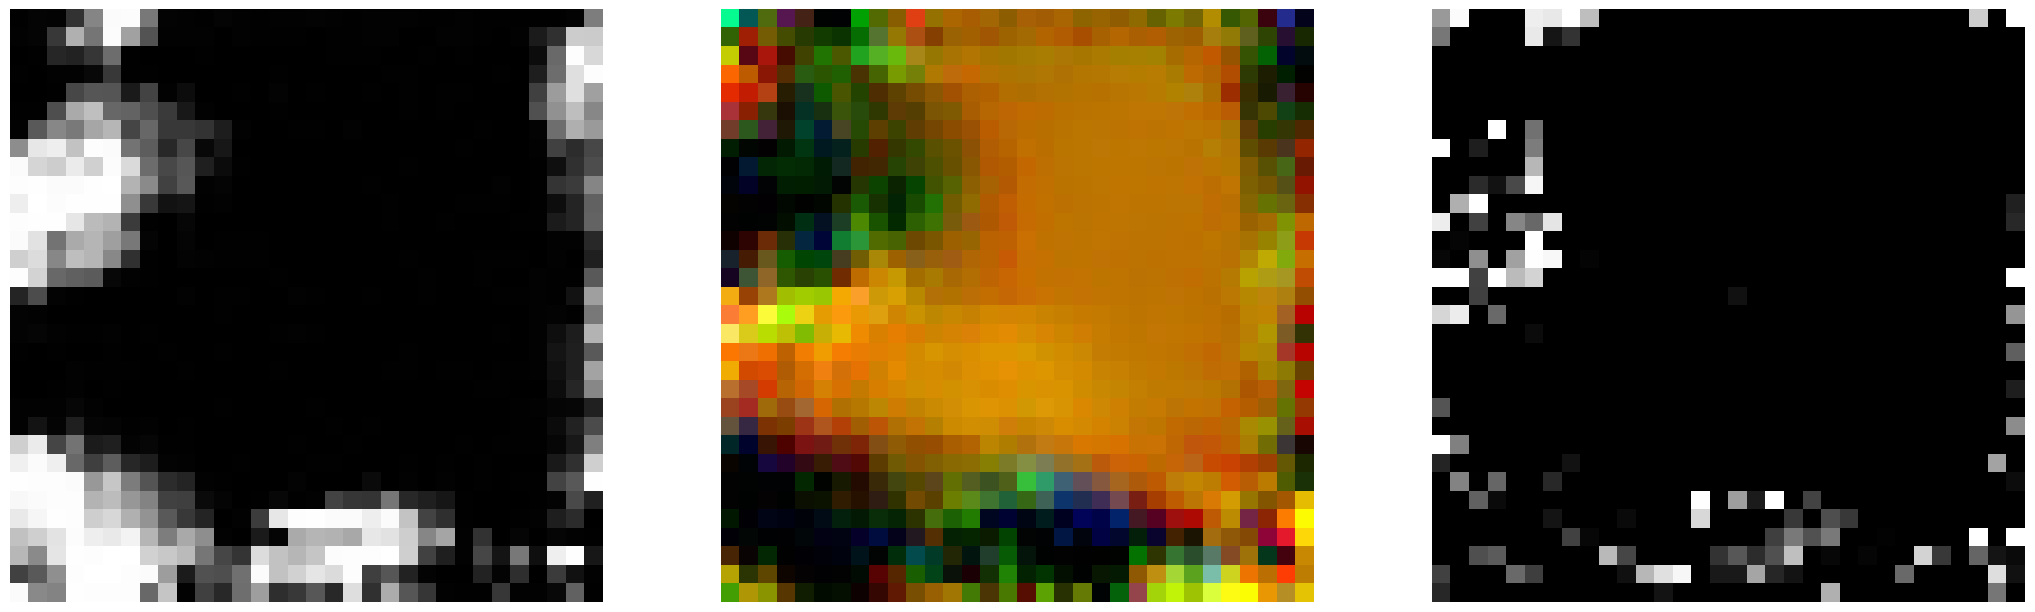

200 0.0133


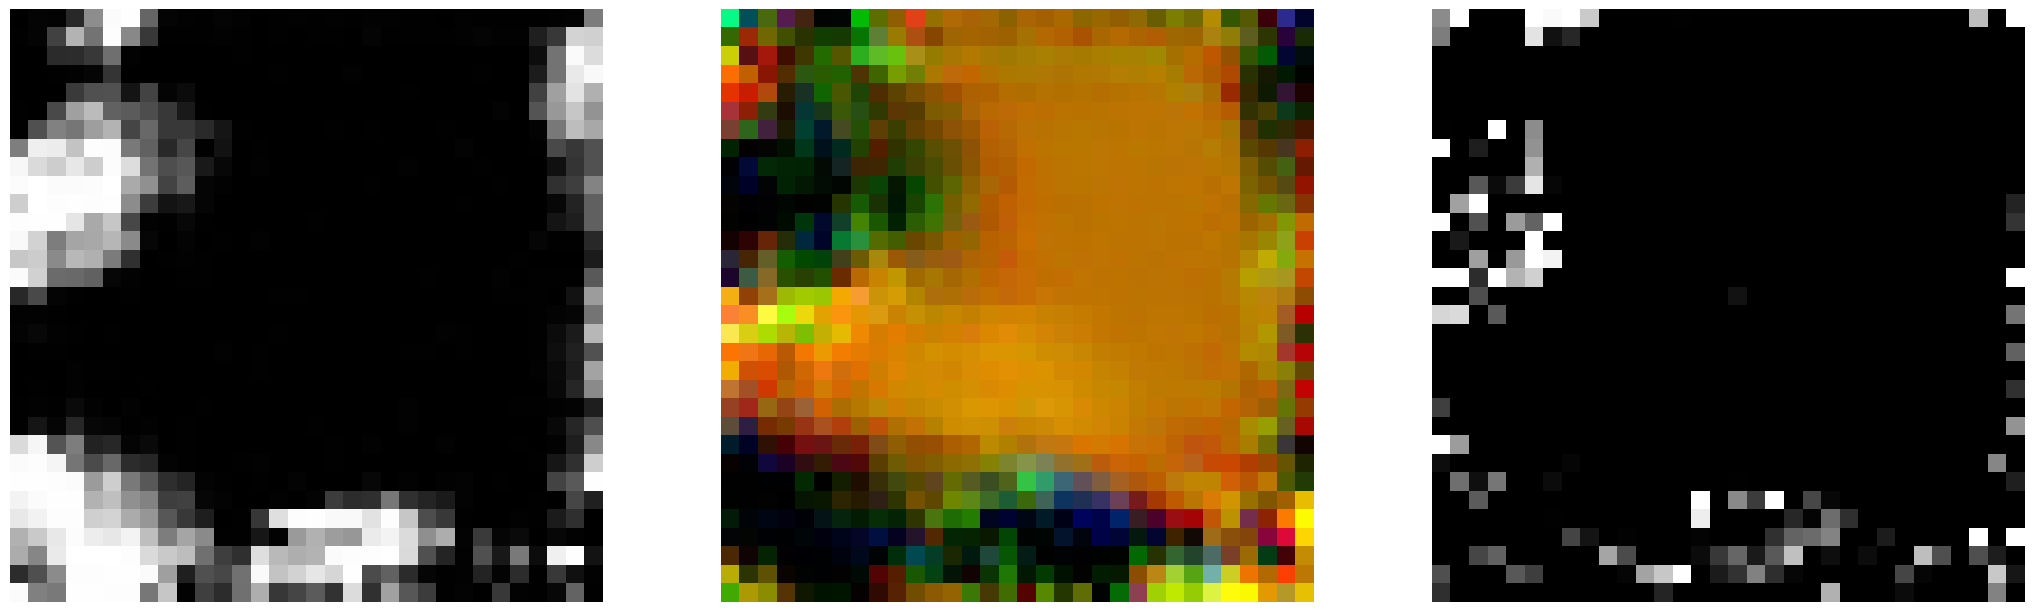

250 0.0138


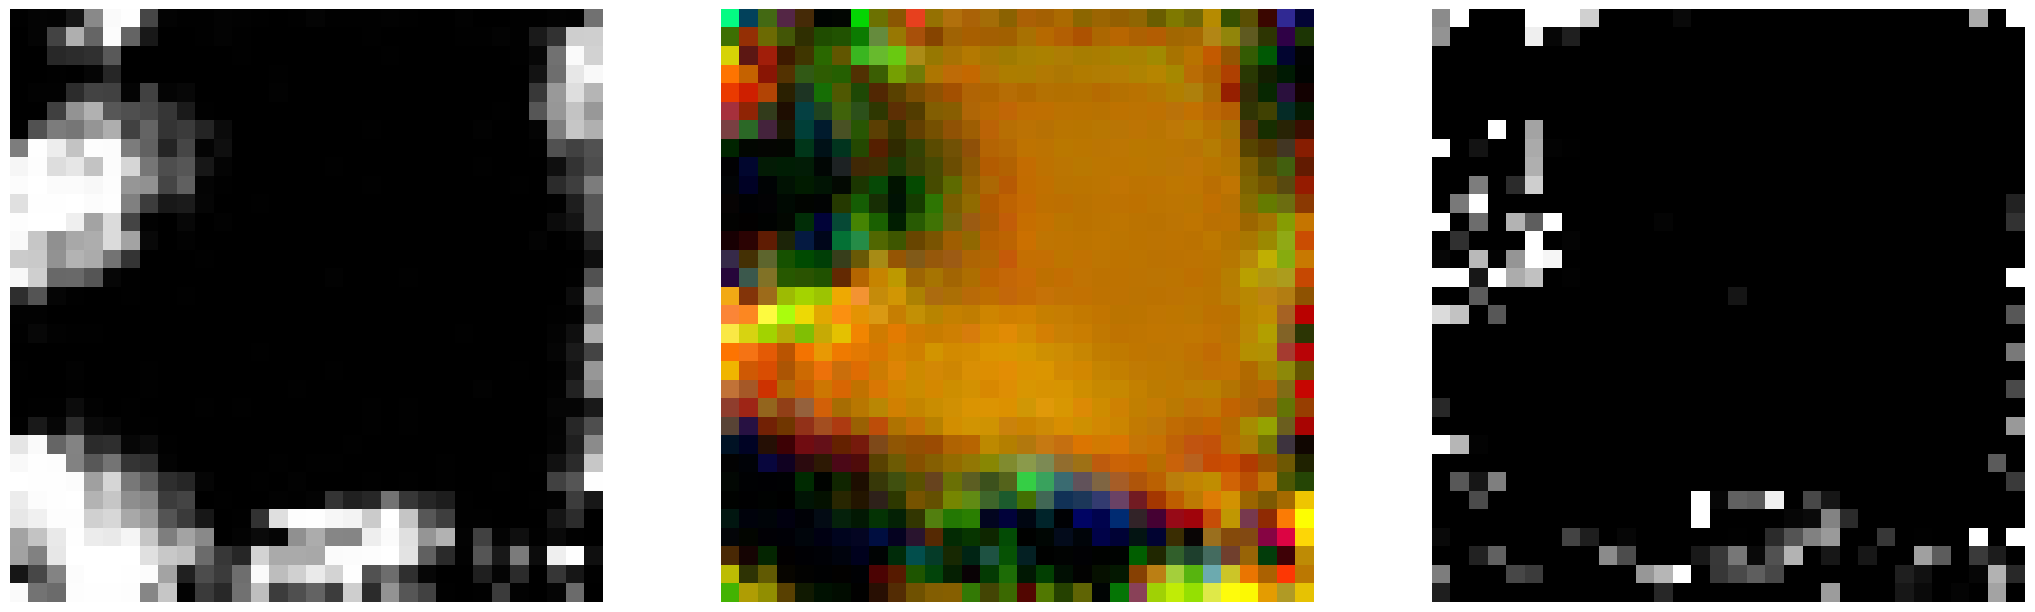

300 0.0140


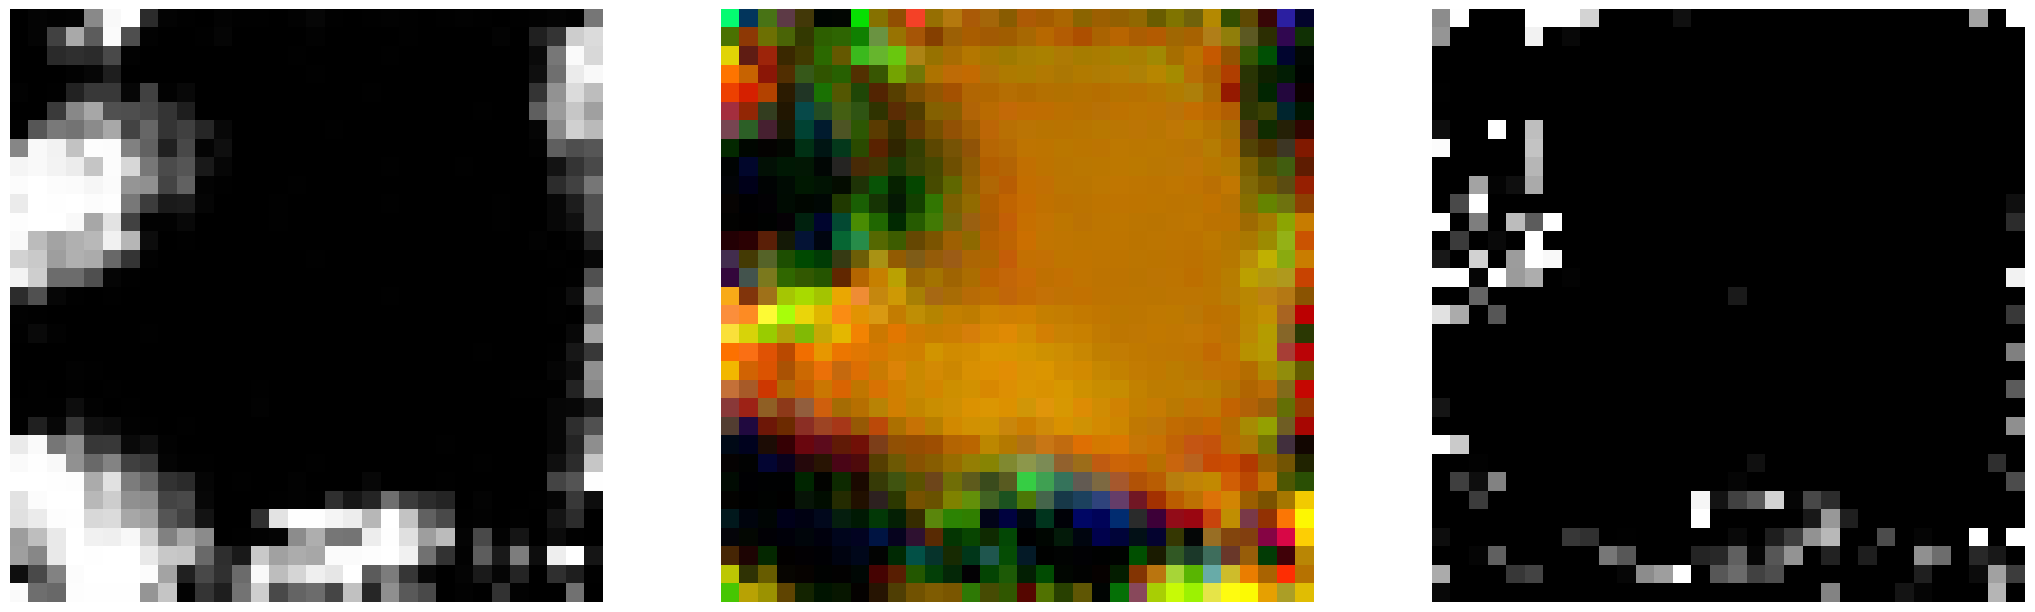

350 0.0136


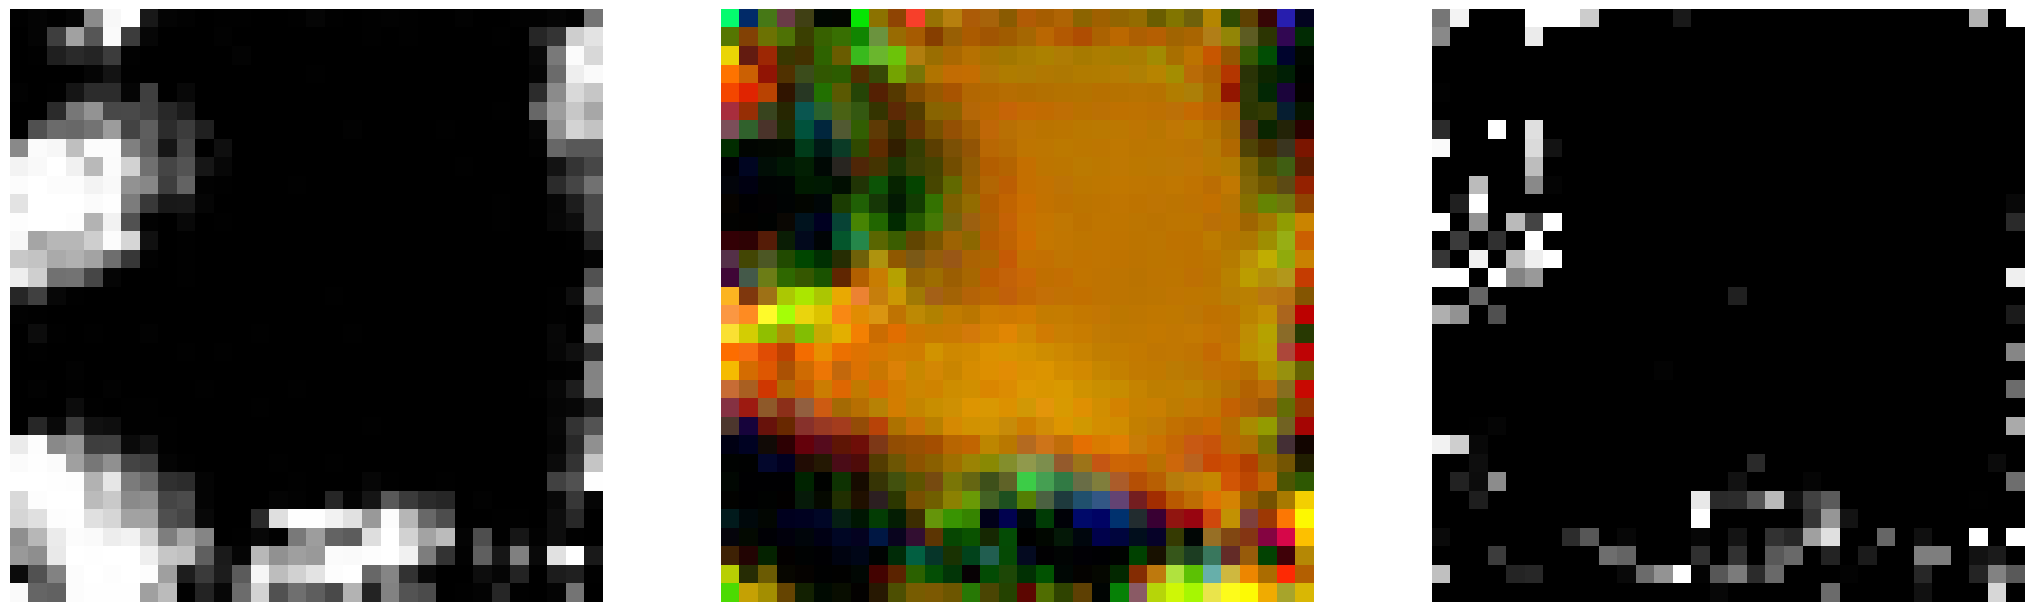

400 0.0140


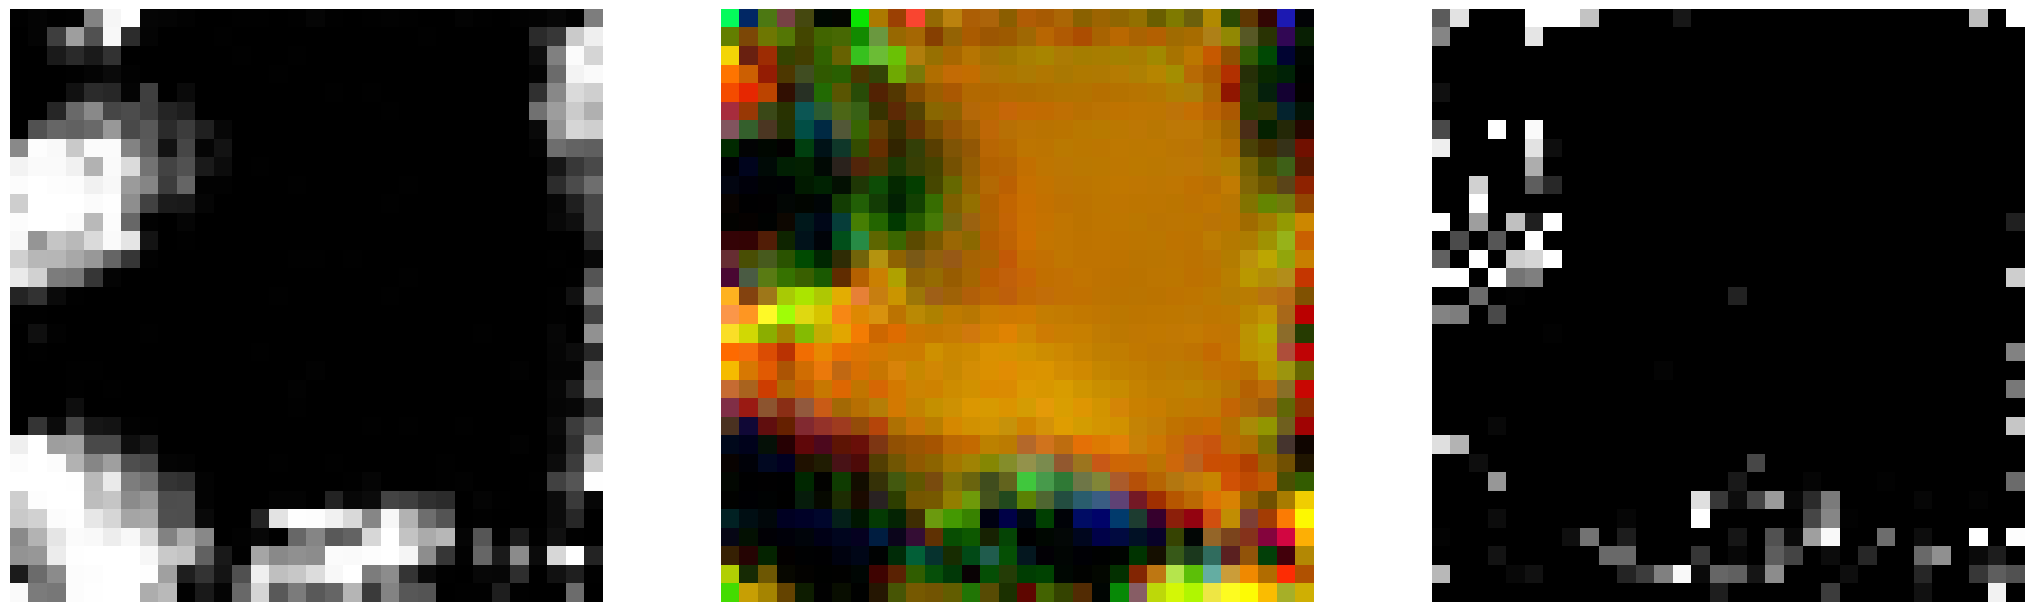

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-5db69ca7cde4>", line 46, in <cell line: 0>
    grads = tape.gradient(grad_diff, [dummy_sample, dummy_label])
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/backprop.py", line 1066, in gradient
    flat_grad = imperative_grad.imperative_grad(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/imperative_grad.py", line 67, in imperative_grad
    return pywrap_tfe.TFE_Py_TapeGradient(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/python/eager/backprop.py", line 148, in _gradient_function
    return grad_fn(mock_op, *out_grads)
           ^^^^^^^^^^^^^^^^^^^^^

In [ ]:
#DLG experiments
import tensorflow_probability as tfp
from scipy.optimize import minimize
model = generate()
initial_weights = model.get_weights()

sample, label = train_generator[4]
sample = sample[:,300:332, 300:332, :]
label = label[:,300:332, 300:332, :]
normal = sample[0][..., :3]
depth = sample[0][..., 3]
show(depth, normal, label[0])


loss_fn = tf.keras.losses.BinaryCrossentropy()

# Compute the output and gradients on the sample
with tf.GradientTape() as tape:
    y = model(sample)
    loss = loss_fn(label, y)

orig_grad = tape.gradient(loss, model.trainable_variables)

dummy_sample = tf.Variable(np.random.normal(loc=0.5, scale=0.1, size=sample.shape), dtype=tf.float32)
dummy_label = tf.Variable(np.random.normal(loc=0.5, scale=0.1, size=label[0].shape), dtype=tf.float32)
show(dummy_sample[0][..., 3], dummy_sample[0][..., :3], dummy_label)

history = []
for i in range(len(dummy_grad)):
  if i < 15:
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.015 - 0.001*i)
  for iters in range(500):
      with tf.GradientTape(persistent=True) as tape:
          dummy_pred = model(dummy_sample)[0]
          dummy_loss = loss_fn(dummy_label, dummy_pred)
          dummy_grad = tape.gradient(dummy_loss, model.trainable_variables)
          grad_diff = tf.add_n([tf.reduce_sum((len(dummy_grad) - j)*(dg - og)**2) for j,(dg,og) in enumerate(zip(dummy_grad[0:i+1], orig_grad[0:i+1]))])
          #cosine similiarity diff
          #grad_diff = tf.add_n([
          #    tf.reduce_sum(
          #        1 - tf.nn.l2_normalize(gx) * tf.nn.l2_normalize(gy)
          #    ) for gx, gy in zip(dummy_grad, orig_grad)
          #])
          penalty = tf.reduce_sum(tf.square(dummy_sample - tf.clip_by_value(dummy_sample, 0.0, 1.0)))
          grad_diff = grad_diff + 2*penalty
      grads = tape.gradient(grad_diff, [dummy_sample, dummy_label])
      del tape
      optimizer.apply_gradients(zip(grads, [dummy_sample, dummy_label]))
      dummy_label.assign(tf.clip_by_value(dummy_label, 0.0, 1.0))
      if iters % 50 == 0:
          print(iters, "%.4f" % grad_diff.numpy())
          #label_binary = tf.where(dummy_label < 0.5, tf.zeros_like(dummy_label), tf.where(dummy_label > 0.5, tf.ones_like(dummy_label), dummy_label))
          show(dummy_sample[0][..., 3], dummy_sample[0][..., :3], dummy_label)

